In [ ]:
import sys
import os

# Adiciona o diretório src ao sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importa os módulos
from process_tiffs import save_masked_tiff, extract_classification_info, plot_tiff_with_classes, plot_time_series, create_time_series, calcular_media_temperatura, combinar_datasets, criar_dataset_completo

In [3]:
import pandas as pd
import numpy as np
import glob
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import seaborn as sns
from shapely.geometry import Point

# Temperatura ao decorrer dos anos

In [4]:
path = '../dados/estacoes'  
all_files = glob.glob(path + "/*.csv")  

In [5]:
all_data = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_data.append(df)

combined_data = pd.concat(all_data, axis=0, ignore_index=True)

In [7]:
combined_data.head()

mes  hora  precipitacao_total  pressao_atm_hora  pressao_atm_max  \
0    5  11.0                 NaN               NaN              NaN   
1    5  14.0                 NaN               NaN              NaN   
2    5  18.0                 NaN               NaN              NaN   
3    5   4.0                 NaN               NaN              NaN   
4    5  11.0                 NaN               NaN              NaN   

   pressao_atm_min  radiacao_global  temperatura_bulbo_hora  \
0              NaN              NaN                     NaN   
1              NaN              NaN                     NaN   
2              NaN              NaN                     NaN   
3              NaN              NaN                     NaN   
4              NaN              NaN                     NaN   

   temperatura_orvalho_hora  temperatura_orvalho_max  ...  umidade_rel_min  \
0                       NaN                      NaN  ...              NaN   
1                       NaN                      NaN  ...              NaN   
2                       NaN                      NaN  ...              NaN   
3                       NaN                      NaN  ...              NaN   
4                       NaN                      NaN  ...              NaN   

   umidade_rel_hora  vento_direcao  vento_rajada_max  vento_velocidade  \
0               NaN            NaN               NaN               NaN   
1               NaN            NaN               NaN               NaN   
2               NaN            NaN               NaN               NaN   
3               NaN            NaN               NaN               NaN   
4               NaN            NaN               NaN               NaN   

   temperatura_min        data  id_estacao   ano temperatura_max  
0        31.184187  2003-05-26        A412  2003       31.006134  
1        31.423990  2003-05-27        A412  2003       31.069967  
2        31.347433  2003-05-27        A412  2003       31.033491  
3        31.179983  2003-05-28        A412  2003       31.019276  
4        31.190351  2003-05-29        A412  2003       30.994087  

[5 rows x 22 columns]

In [68]:
combined_data['id_estacao'].unique()

array(['A305', 'A306', 'A307', 'A308', 'A408', 'A412', 'A310', 'A309',
       'A313', 'A526', 'A539', 'A543', 'A314', 'A315', 'A316', 'A317',
       'A318', 'A319', 'A321', 'A322', 'A323', 'A324', 'A325', 'A327',
       'A329', 'A330', 'A331', 'A332', 'A333', 'A334', 'A336', 'A337',
       'A339', 'A340', 'A413', 'A415', 'A416', 'A417', 'A418', 'A419',
       'A420', 'A423', 'A424', 'A425', 'A426', 'A428', 'A429', 'A430',
       'A432', 'A433', 'A435', 'A436', 'A439', 'A440', 'A441', 'A442',
       'A443', 'A342', 'A349', 'A343', 'A328', 'A345', 'A347', 'A348',
       'A350', 'A351', 'A354', 'A358', 'A359', 'A360', 'A365', 'A366',
       'A367', 'A448', 'A450', 'A559', 'A563', 'A449', 'A454', 'A451',
       'A453', 'A370', 'A371', 'A372', 'A373', 'A368', 'A369', 'A458'],
      dtype=object)

In [6]:
# Novo dataset com as colunas de interesse
temperaturas = combined_data[['data', 'temperatura_max', 'temperatura_min', 'ano']]

# Agrupar por ano
temperatura_anual = temperaturas.groupby('ano').agg({
    'temperatura_max': 'mean',
    'temperatura_min': 'mean'
}).reset_index()

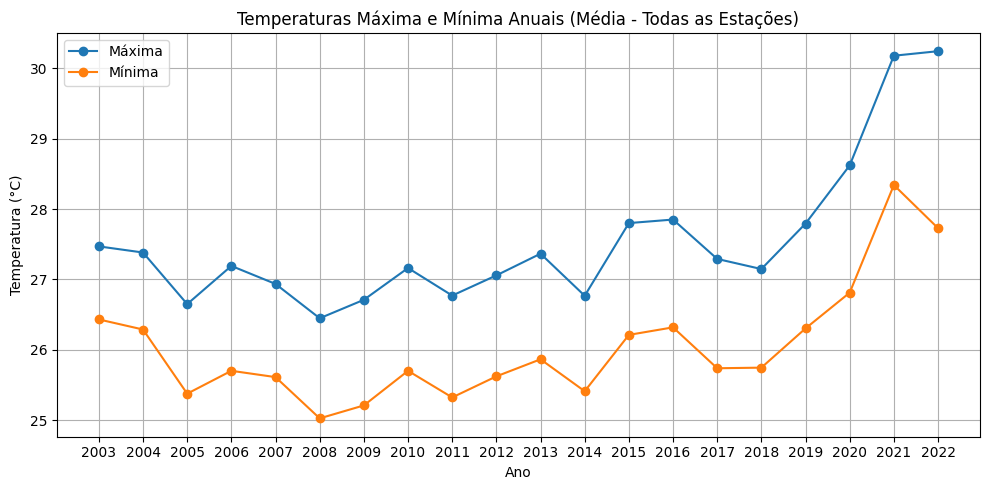

In [9]:
# Visualizar a série temporal
# Criando o gráfico
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_max'], label='Máxima', marker='o')
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_min'], label='Mínima', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais (Média - Todas as Estações)')
plt.xticks(range(2003, 2023))  # Define os ticks do eixo x para cada ano de 2003 a 2022
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta automaticamente os subplots para dar espaço ao conteúdo
plt.show()

# Segmentações ao decorrer dos anos

In [ ]:
# Diretório onde os arquivos serão salvos
save_dir = '../dados/segmentacoes'

# Lista de anos
years = range(2003, 2022)  

# Loop para baixar os arquivos
for year in years:
    # Construindo a URL para o ano atual
    url = f'https://storage.googleapis.com/mapbiomas-public/initiatives/brasil/collection_8/lclu/coverage/brasil_coverage_{year}.tif'
    
    # Nome do arquivo local onde o TIF será salvo
    local_filename = f'{save_dir}brasil_coverage_{year}.tif'

    # Fazendo a requisição para baixar o arquivo
    response = requests.get(url)
    
    # Verificando se a requisição foi bem-sucedida
    if response.status_code == 200:
        # Garantindo que o diretório exista
        os.makedirs(save_dir, exist_ok=True)
        
        # Escrevendo o conteúdo do arquivo baixado no arquivo local
        with open(local_filename, 'wb') as file:
            file.write(response.content)
        print(f'Arquivo {local_filename} baixado e salvo com sucesso.')
    else:
        print(f'Falha ao baixar o arquivo para o ano {year}.')

Arquivo ../dados/segmentacoesbrasil_coverage_2000.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2001.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2002.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2003.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2004.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2005.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2006.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2007.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2008.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2009.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2010.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2011.tif baixado e salvo com sucesso.
Arqu

## Agora precisamos delimitar pelas estações na região da caatinga

In [4]:
import basedosdados as bd

In [5]:
# Caminho para o shapefile dos biomas
biomes_shp = '../dados/Biomas_250mil/lm_bioma_250.shp'

# Carregar o shapefile dos biomas
biomes = gpd.read_file(biomes_shp)

# Filtrar para obter apenas a Caatinga
caatinga = biomes[biomes['Bioma'] == 'Caatinga']

# Para carregar o dado direto no pandas
df_estacoes = bd.read_table(dataset_id='br_inmet_bdmep',
table_id='estacao',
billing_project_id="projetopdi-430718")

# Convertendo o DataFrame em GeoDataFrame
gdf_estacoes = gpd.GeoDataFrame(
    df_estacoes, 
    geometry=gpd.points_from_xy(df_estacoes['longitude'], df_estacoes['latitude']),
    crs="EPSG:4674"
)

# Reprojetar o GeoDataFrame das estações para o mesmo CRS que o shapefile dos biomas
gdf_estacoes = gdf_estacoes.to_crs(caatinga.crs)

# Filtrar as estações que estão dentro da Caatinga
stations_within_caatinga = gdf_estacoes[gdf_estacoes.geometry.within(caatinga.unary_union)]

# Dropar colunas que não serão utilizadas
stations_within_caatinga = stations_within_caatinga.drop(columns=['id_municipio', 'estacao','data_fundacao','altitude'])

Downloading: 100%|██████████| 612/612 [00:00<00:00, 1211.59rows/s]


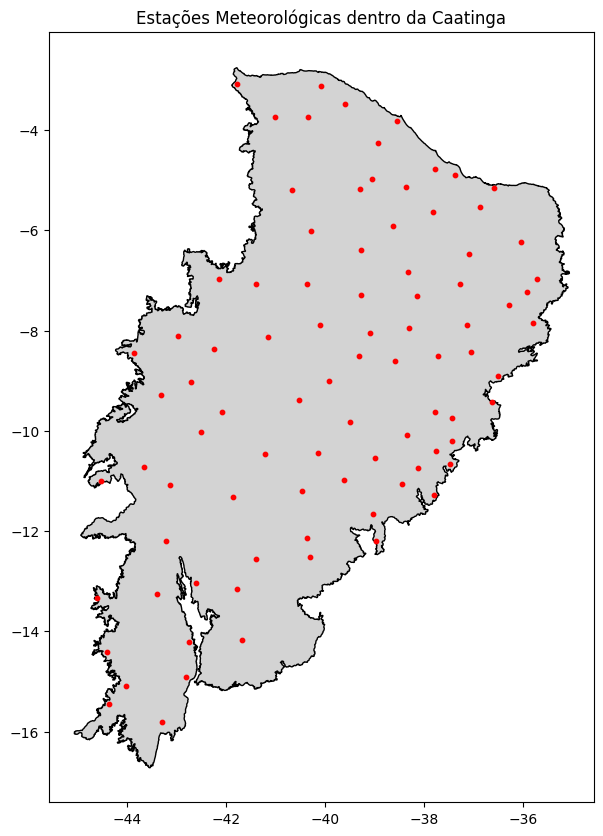

In [291]:
# Plotar um mapa com as estações
fig, ax = plt.subplots(figsize=(10, 10))
caatinga.plot(ax=ax, color='lightgrey', edgecolor='black')
stations_within_caatinga.plot(ax=ax, color='red', markersize=10)
plt.title('Estações Meteorológicas dentro da Caatinga')
plt.show()

Precisamos dividir o mapa de acordo com as estações

In [292]:
# Filtrar as estações que estão dentro da Caatinga
stations_within_caatinga = gdf_estacoes[gdf_estacoes.geometry.within(caatinga.unary_union)]

# Extrair as coordenadas das estações
coords = np.array(list(zip(stations_within_caatinga.geometry.x, stations_within_caatinga.geometry.y)))

# Adicionar pontos fictícios ao redor do perímetro da Caatinga
minx, miny, maxx, maxy = caatinga.total_bounds
padding = 0.5  # Ajuste conforme necessário
extra_points = [
    [minx - padding, miny - padding],
    [minx - padding, maxy + padding],
    [maxx + padding, miny - padding],
    [maxx + padding, maxy + padding]
]

# Adicionar os novos pontos às coordenadas das estações
all_points = np.vstack([coords, extra_points])

# Gerar os polígonos de Voronoi com os pontos adicionais
vor = Voronoi(all_points)

# Criar polígonos de Voronoi a partir dos vértices
polygons = []
for region in vor.regions:
    if not -1 in region and region:
        polygon = Polygon([vor.vertices[i] for i in region])
        polygons.append(polygon)

# Criar um GeoDataFrame com os polígonos de Voronoi
gdf_voronoi = gpd.GeoDataFrame(geometry=polygons, crs=stations_within_caatinga.crs)

# Verificar e corrigir geometrias inválidas antes do clipping
gdf_voronoi['geometry'] = gdf_voronoi['geometry'].buffer(0)

# Clipping com o polígono da Caatinga para garantir que todos os polígonos estejam dentro da região
gdf_voronoi_clipped = gpd.GeoDataFrame(
    geometry=[poly.intersection(caatinga.unary_union) for poly in gdf_voronoi.geometry if not poly.is_empty],
    crs=gdf_voronoi.crs
)

# Remover geometrias vazias
gdf_voronoi_clipped = gdf_voronoi_clipped[~gdf_voronoi_clipped.is_empty]

In [293]:
# Associar o polígono ao ID da estação mais próxima
def find_nearest_station(polygon, stations):
    centroid = polygon.centroid
    distances = stations.geometry.apply(lambda x: centroid.distance(x))
    nearest_station = stations.loc[distances.idxmin()]
    return nearest_station['id_estacao'],nearest_station.geometry.y, nearest_station.geometry.x

# Aplicar a função para encontrar o ID da estação, latitude e longitude
gdf_voronoi_clipped[['id_estacao', 'latitude', 'longitude']] = gdf_voronoi_clipped.geometry.apply(
    lambda poly: find_nearest_station(poly, stations_within_caatinga)
).apply(pd.Series)

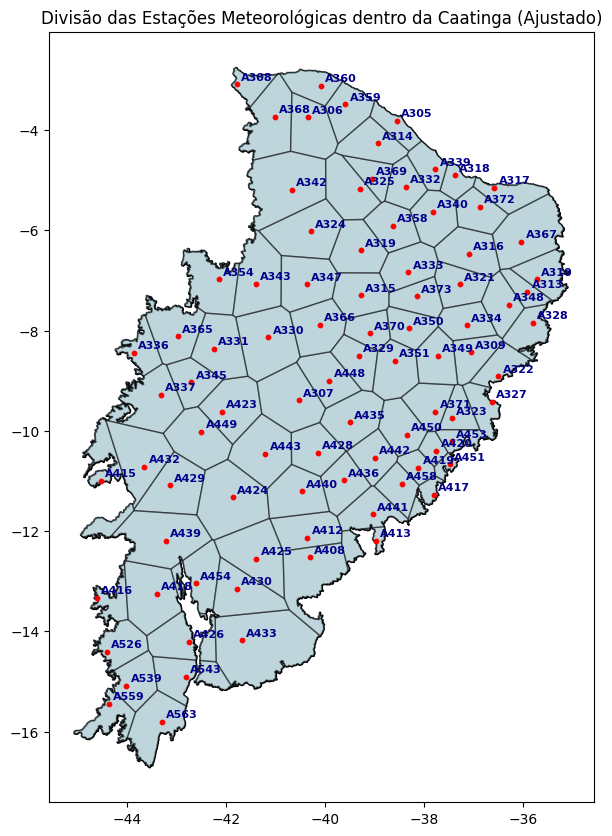

In [294]:
# Plotar o resultado ajustado
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o perímetro da Caatinga
caatinga.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plotar os polígonos de Voronoi
gdf_voronoi_clipped.plot(ax=ax, edgecolor='black', color='lightblue', alpha=0.5)

# Plotar as estações meteorológicas
stations_within_caatinga.plot(ax=ax, color='red', markersize=10)

# Adicionar o ID das estações no plot
for x, y, label in zip(stations_within_caatinga.geometry.x, stations_within_caatinga.geometry.y, stations_within_caatinga['id_estacao']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='darkblue', weight='bold')

plt.title('Divisão das Estações Meteorológicas dentro da Caatinga (Ajustado)')
plt.show()

In [295]:
# Salvar o shapefile resultante
gdf_voronoi_clipped.to_file('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp')
gdf_voronoi_clipped.head()

geometry id_estacao   latitude  \
0  MULTIPOLYGON (((-43.28134 -8.66269, -43.66635 ...       A336  -8.441667   
1  MULTIPOLYGON (((-43.28134 -8.66269, -43.63515 ...       A365  -8.117939   
2  MULTIPOLYGON (((-44.05675 -12.61621, -44.05717...       A416 -13.332500   
3  POLYGON ((-42.21703 -13.71785, -42.21693 -13.7...       A433 -14.181944   
4  POLYGON ((-41.52190 -3.55804, -41.52253 -3.558...       A308  -3.086667   

   longitude  
0 -43.865556  
1 -42.975721  
2 -44.617500  
3 -41.672222  
4 -41.783056

# Separar os arquivos geotif por estação

In [19]:
def process_all_tiffs(segmentacoes_dir, output_base_dir, gdf_voronoi_clipped):
    """
    Processa todos os arquivos GeoTIFF na pasta segmentacoes para todas as estações,
    salvando os resultados em pastas separadas por ano.

    Args:
    segmentacoes_dir (str): Caminho para a pasta contendo os arquivos GeoTIFF de entrada.
    output_base_dir (str): Diretório base onde os GeoTIFFs resultantes serão salvos.
    gdf_voronoi_clipped (GeoDataFrame): GeoDataFrame contendo os polígonos de Voronoi.
    """

    # Listar todos os arquivos GeoTIFF na pasta segmentacoes
    tiff_files = glob.glob(os.path.join(segmentacoes_dir, '*.tif'))

    # Obter os IDs únicos das estações
    estacao_ids = gdf_voronoi_clipped['id_estacao'].unique()

    for tiff_file in tiff_files:
        # Extrair o ano do nome do arquivo GeoTIFF
        year = os.path.basename(tiff_file).split('_')[-1].split('.')[0]

        # Criar diretório para o ano se não existir
        year_dir = os.path.join(output_base_dir, year)
        os.makedirs(year_dir, exist_ok=True)

        for estacao_id in estacao_ids:
            # Aplicar a função para salvar o TIFF mascarado
            save_masked_tiff(tiff_file, estacao_id, year_dir, gdf_voronoi_clipped)
            print(f"Salvo: {year_dir}/coverage_{estacao_id}_{year}.tif")


# Definir caminhos
segmentacoes_dir = '../dados/segmentacoes'
output_base_dir = '../dados/raster_tiff_caating'

# Executar o processamento para todos os arquivos e estações
process_all_tiffs(segmentacoes_dir, output_base_dir, gdf_voronoi_clipped)

Salvo: ../dados/raster_tiff_caating\2003/coverage_A336_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A365_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A416_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A433_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A308_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A368_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A539_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A543_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A526_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A559_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A563_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A454_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A418_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A426_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A430_2003.tif
Salvo: ../dados/raster_tiff_caating\2003

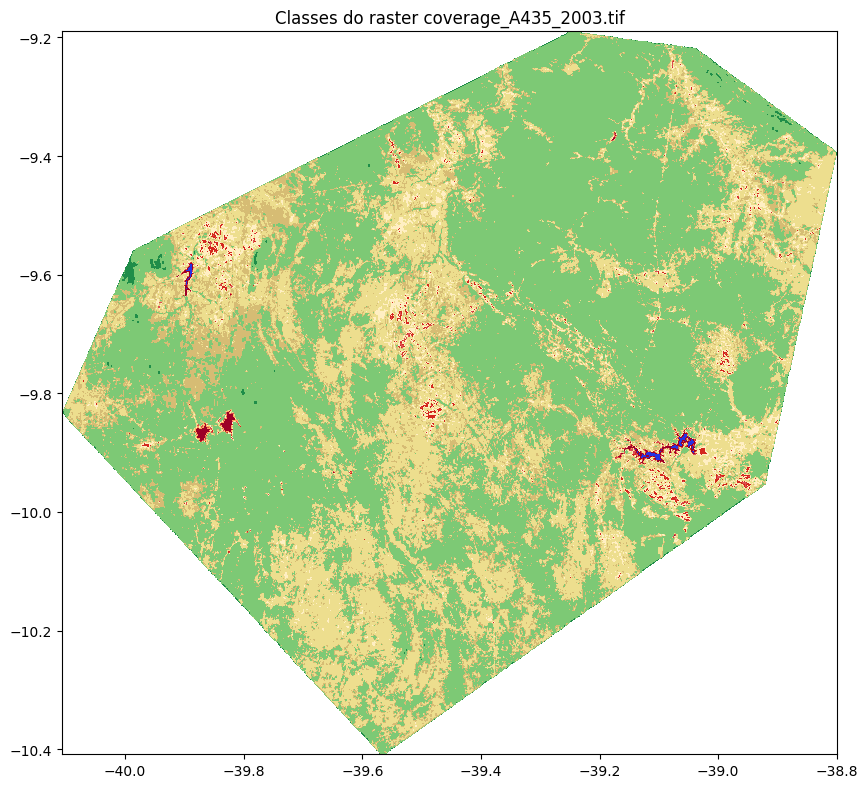

In [24]:
output_tif_path = '../dados/raster_tiff_caating/2003/coverage_A435_2003.tif'
plot_tiff_with_classes(output_tif_path)

In [25]:
# Extrair informações do GeoTIFF salvo
sorted_class_counts = extract_classification_info(output_tif_path)

# Exibir as classificações e contagens
print("Contagem de superpixels por classe (ordenado):", sorted_class_counts)

Contagem de superpixels por classe (ordenado): {48: 178, 41: 286, 3: 10708, 24: 11844, 29: 14454, 30: 18794, 33: 47263, 25: 402308, 15: 1251112, 21: 2389165, 12: 3193358, 4: 6111501, 0: 8481056}


## Série temporal das estações

In [8]:
# Novo dataset com as colunas de interesse
temperaturas = combined_data[['id_estacao','data', 'temperatura_max', 'temperatura_min', 'ano','hora']]
temperaturas.head()

id_estacao        data  temperatura_max  temperatura_min   ano  hora
0       A412  2003-05-26        31.006134        31.184187  2003  11.0
1       A412  2003-05-27        31.069967        31.423990  2003  14.0
2       A412  2003-05-27        31.033491        31.347433  2003  18.0
3       A412  2003-05-28        31.019276        31.179983  2003   4.0
4       A412  2003-05-29        30.994087        31.190351  2003  11.0

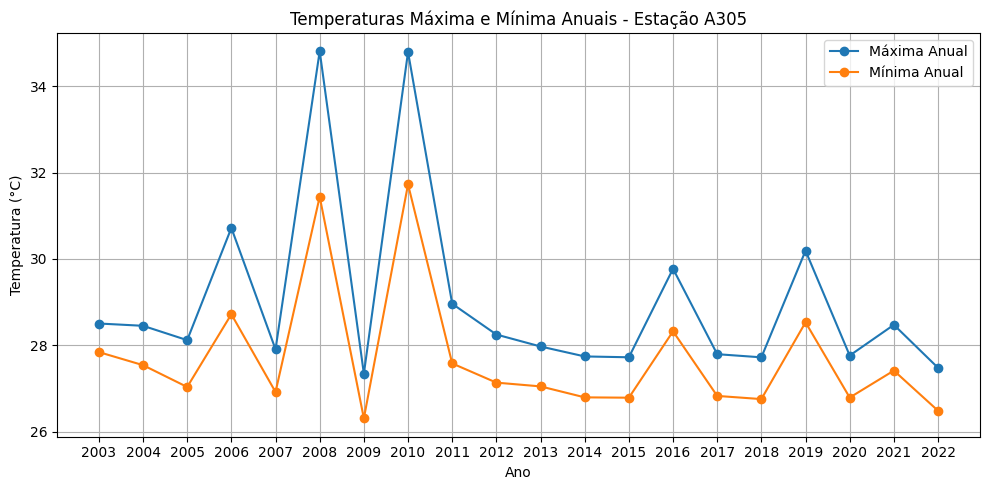

In [9]:
# Filtrar os dados apenas para a estação A305
dados_A305 = temperaturas[temperaturas['id_estacao'] == 'A305']

# Agrupar por ano e calcular a temperatura máxima e mínima anual
temperatura_anual = dados_A305.groupby('ano').agg(
    temperatura_max=('temperatura_max', 'mean'),
    temperatura_min=('temperatura_min', 'mean')
).reset_index()

# Plotar a série temporal anual
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_max'], label='Máxima Anual', marker='o')
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_min'], label='Mínima Anual', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais - Estação A305')
plt.xticks(range(temperatura_anual['ano'].min(), temperatura_anual['ano'].max() + 1))  # Define os ticks do eixo x para cada ano
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

## Série temporal da vegetação na região de cada estação

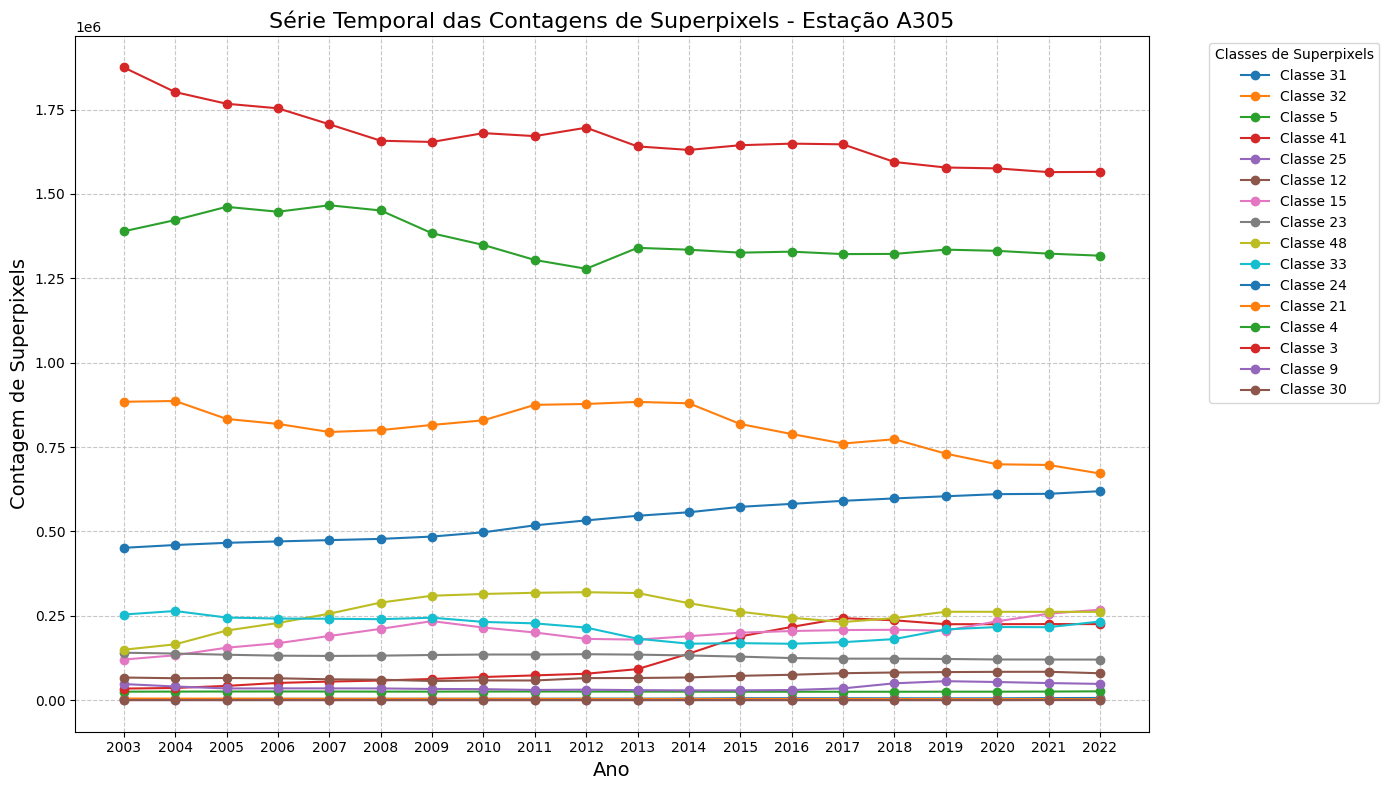

In [10]:
# Definir parâmetros
output_base_dir = '../dados/raster_tiff_caating'
estacao_id = 'A305'
start_year = 2003
end_year = 2022

# Criar a série temporal
df_time_series = create_time_series(output_base_dir, estacao_id, start_year, end_year)
plot_time_series(df_time_series, estacao_id)

## Montagem do dataset para cada estação

In [11]:
output_base_dir = '../dados/raster_tiff_caating'
estacao_id = 'A305'
start_year = 2003
end_year = 2022

# DataFrame inicial com os dados de temperatura
dados_A305 = temperaturas[temperaturas['id_estacao'] == estacao_id]

# Criar o dataset completo para a estação A305
dataset_completo_A305 = criar_dataset_completo(dados_A305, output_base_dir, estacao_id, start_year, end_year)

In [12]:
dataset_completo_A305.head()

ano  temperatura_max  temperatura_min      31      32        5       41  \
0  2003        28.503954        27.842044  2574.0  4683.0  24970.0  34098.0   
1  2004        28.450914        27.539544  2761.0  4410.0  25162.0  35944.0   
2  2005        28.118754        27.033959  3344.0  4303.0  25392.0  42089.0   
3  2006        30.717679        28.718645  3677.0  4081.0  25559.0  50899.0   
4  2007        27.905814        26.917858  3748.0  3909.0  25426.0  54823.0   

        25       12        15        23        48        33        24  \
0  47489.0  66877.0  120126.0  140382.0  149318.0  253628.0  451289.0   
1  40349.0  64771.0  132801.0  137925.0  165220.0  263979.0  459531.0   
2  34459.0  65402.0  155191.0  134406.0  206048.0  244677.0  466019.0   
3  34696.0  64630.0  168667.0  131636.0  228522.0  241594.0  470223.0   
4  34702.0  61626.0  189931.0  130868.0  256069.0  241064.0  474057.0   

         21          4          3    9   30  
0  884053.0  1389258.0  1874707.0  0.0  0.0  
1  886343.0  1422501.0  1801735.0  0.0  0.0  
2  833253.0  1461676.0  1767177.0  0.0  0.0  
3  818379.0  1447196.0  1753663.0  0.0  0.0  
4  794502.0  1466322.0  1706385.0  0.0  0.0

# Utilizando o coeficiente de correlação de Pearson

In [13]:
# Dicionário de mapeamento de IDs para nomes das classes
id_to_class_name = {
    1: "Formação Florestal",
    3: "Formação Florestal",
    4: "Formação Savânica",
    5: "Mangue",
    6: "Floresta Alagável",
    49: "Restinga Arbórea",
    11: "Campo Alagado e Área Pantanosa",
    12: "Formação Campestre ",
    32: "Apicum",
    29: "Afloramento Rochoso",
    50: "Restinga Herbácea",
    13: "Outras Formações Não Florestais",
    14: "Agropecuária",
    15: "Pastagem",
    18: "Agricultura",
    19: "Lavoura Temporária",
    39: "Soja",
    20: "Cana",
    40: "Arroz",
    62: "Algodão (beta)",
    41: "Outras Lavouras Temporárias",
    36: "Lavoura Perene",
    21: "Mosaico de Usos",
    46: "Café",
    47: "Citros",
    35: "Dendê (beta)",
    48: "Outras Lavouras Perenes",
    9: "Silvicultura",
    23: "Praia, Duna e Areal",
    24: "Área Urbanizada",
    30: "Mineração",
    25: "Outras Áreas não Vegetadas",
    33: "Rio, Lago e Oceano ",
    31: "Aquicultura",
    27: "Não Observado",
    26: "Corpo d'água",
    22: "Área não Vegetada",
    10: "Formação Natural não Florestal",
    0: "Não Classificado",

}

Text(143.72222222222223, 0.5, 'Classes de Vegetação')

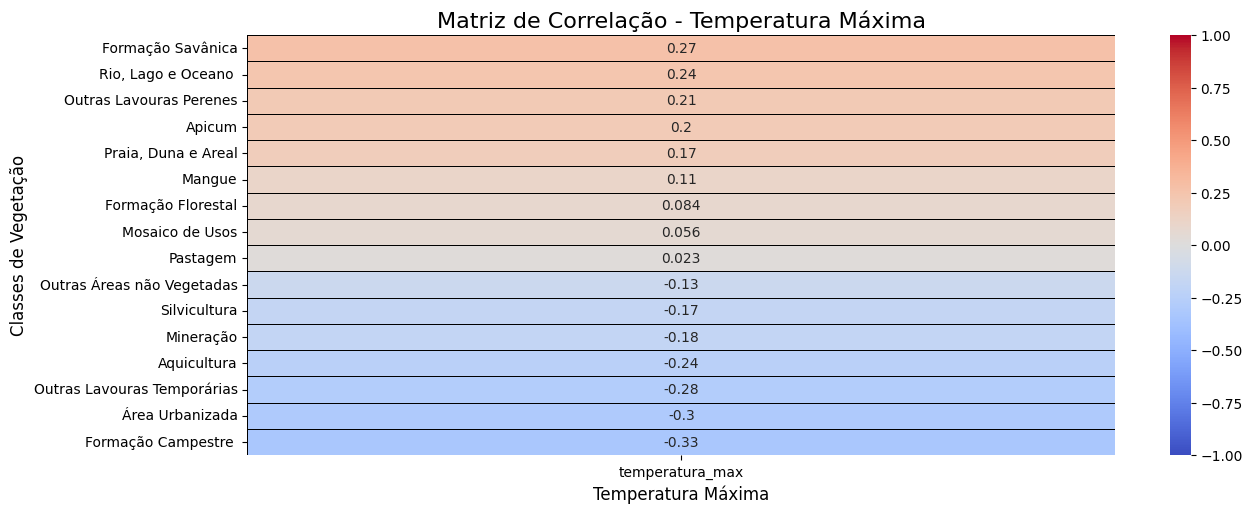

In [14]:
# Calcular a matriz de correlação para todas as colunas
correlation_matrix = dataset_completo_A305.corr(method='pearson')

# Focar apenas na correlação da temperatura máxima com as classes de vegetação
correlation_max = correlation_matrix[['temperatura_max']].drop(['ano', 'temperatura_max', 'temperatura_min'])

# Mapeando os nomes das classes no eixo y
correlation_max.index = correlation_max.index.map(id_to_class_name)

# Focar apenas na correlação da temperatura mínima com as classes de vegetação
correlation_min = correlation_matrix[['temperatura_min']].drop(['ano', 'temperatura_max', 'temperatura_min'])

# Mapeando os nomes das classes no eixo y
correlation_min.index = correlation_min.index.map(id_to_class_name)

# Ordenar as correlações da maior para a menor
correlation_max = correlation_max.sort_values(by='temperatura_max', ascending=False)
correlation_min = correlation_min.sort_values(by='temperatura_min', ascending=False)

# Configurar o tamanho do plot e criar duas subplots
plt.figure(figsize=(14, 12))

# Heatmap para Temperatura Máxima
plt.subplot(2, 1, 1)
sns.heatmap(correlation_max, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')
plt.title('Matriz de Correlação - Temperatura Máxima', fontsize=16)
plt.xlabel('Temperatura Máxima', fontsize=12)
plt.ylabel('Classes de Vegetação', fontsize=12)

Text(143.72222222222223, 0.5, 'Classes de Vegetação')

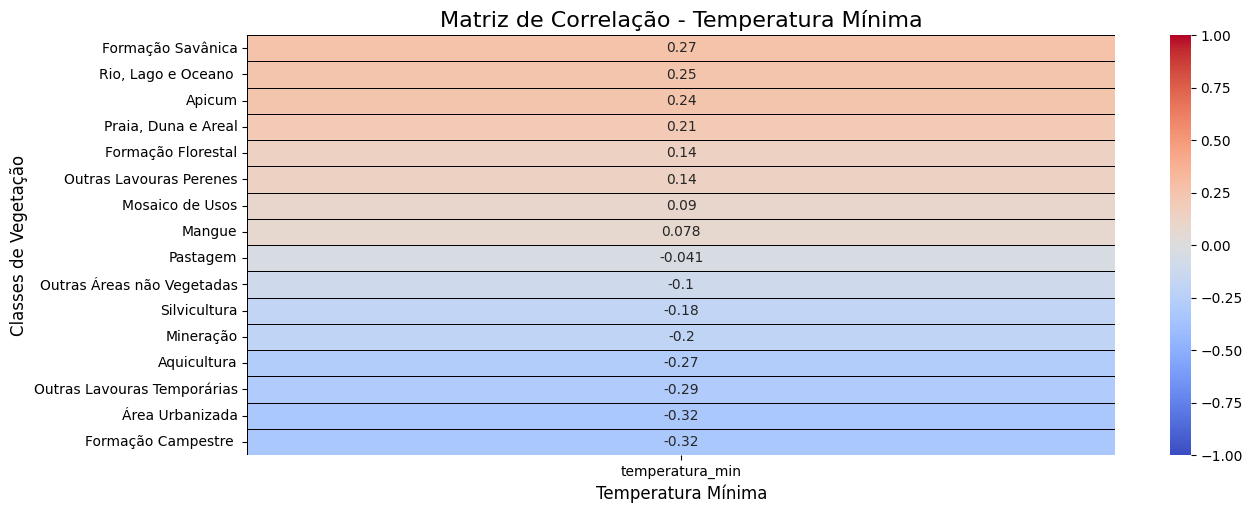

In [15]:
# Heatmap para Temperatura Mínima
plt.figure(figsize=(14, 12))
plt.subplot(2, 1, 2)
sns.heatmap(correlation_min, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')
plt.title('Matriz de Correlação - Temperatura Mínima', fontsize=16)
plt.xlabel('Temperatura Mínima', fontsize=12)
plt.ylabel('Classes de Vegetação', fontsize=12)

# Verificando a correlação utilizando mais de uma estação

In [19]:
# Carregar o shapefile do Voronoi previamente salvo
gdf_voronoi_clipped = gpd.read_file('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp')

# Removendo regiões com uma área muito grande em estacoes_validas
gdf_voronoi_validas_filter = gdf_voronoi_clipped[gdf_voronoi_clipped.area < 0.8]
gdf_voronoi_validas_filter.head()

C:\Users\arthu\AppData\Local\Temp\ipykernel_19788\370575154.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_voronoi_validas_filter = gdf_voronoi_clipped[gdf_voronoi_clipped.area < 0.8]


id_estacao   latitude  longitude  \
0       A336  -8.441667 -43.865556   
2       A416 -13.332500 -44.617500   
4       A308  -3.086667 -41.783056   
6       A539 -15.085958 -44.016036   
8       A526 -14.408333 -44.404167   

                                            geometry  
0  MULTIPOLYGON (((-43.28134 -8.66269, -43.66635 ...  
2  MULTIPOLYGON (((-44.05675 -12.61621, -44.05717...  
4  POLYGON ((-41.5219 -3.55804, -41.52253 -3.5580...  
6  MULTIPOLYGON (((-43.82896 -15.61738, -44.27226...  
8  MULTIPOLYGON (((-44.446 -13.85756, -44.44638 -...

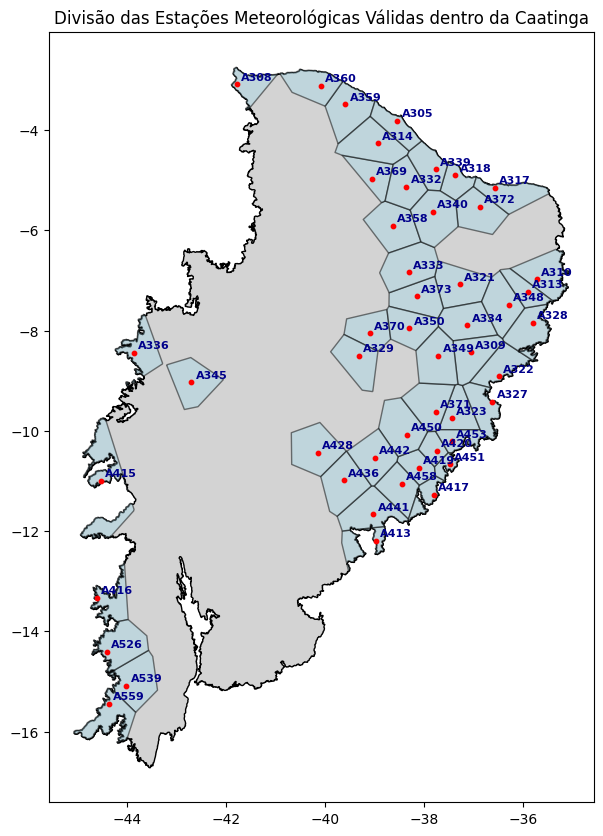

In [7]:
# Filtrar as estações meteorológicas para incluir apenas as estações válidas
stations_validas = stations_within_caatinga[stations_within_caatinga['id_estacao'].isin(gdf_voronoi_validas_filter['id_estacao'])]

# Plotar o resultado ajustado
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o perímetro da Caatinga
caatinga.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plotar os polígonos de Voronoi para as estações válidas
gdf_voronoi_validas_filter.plot(ax=ax, edgecolor='black', color='lightblue', alpha=0.5)

# Plotar as estações meteorológicas válidas
stations_validas.plot(ax=ax, color='red', markersize=10)

# Adicionar o ID das estações válidas no plot
for x, y, label in zip(stations_validas.geometry.x, stations_validas.geometry.y, stations_validas['id_estacao']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='darkblue', weight='bold')

plt.title('Divisão das Estações Meteorológicas Válidas dentro da Caatinga')
plt.show()

In [18]:
# Lista para armazenar os DataFrames de cada estação
datasets_completos = []
output_base_dir = '../dados/raster_tiff_caating'
start_year = 2003
end_year = 2022

# Iterar sobre cada estação e criar o dataset completo
for estacao_id in gdf_voronoi_validas_filter['id_estacao']:
    # Criar o dataset completo para a estação atual
    dataset_completo = criar_dataset_completo(temperaturas, output_base_dir, estacao_id, start_year, end_year)
    
    # Adicionar o ID da estação ao DataFrame
    dataset_completo['id_estacao'] = estacao_id
    
    # Adicionar o dataset da estação à lista
    datasets_completos.append(dataset_completo)

# Concatenar todos os DataFrames em um único DataFrame
dataset_completo_todas_estacoes = pd.concat(datasets_completos, ignore_index=True)

# Substituir valores NaN por 0
dataset_completo_todas_estacoes.fillna(0, inplace=True)

# Remover colunas onde todos os valores são 0
dataset_completo_todas_estacoes = dataset_completo_todas_estacoes.loc[:, (dataset_completo_todas_estacoes != 0).any(axis=0)]

# Exibir as primeiras linhas do DataFrame final
dataset_completo_todas_estacoes.head()

ano  temperatura_max  temperatura_min    39      33      41      24  \
0  2007        29.233161        27.790821  26.0  1268.0  1810.0  7346.0   
1  2008        27.938674        26.199454  87.0  1268.0  1932.0  7440.0   
2  2009        26.887711        25.768109   2.0  1238.0  3698.0  7543.0   
3  2010        28.313253        27.211097   0.0  1179.0  4500.0  7632.0   
4  2011        27.620172        26.396233   0.0  1092.0  3680.0  7730.0   

        25        15        12  ...   46   29   48   31   32    5   23   20  \
0  46448.0  162724.0  134422.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  44194.0  176902.0  133308.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  37061.0  200726.0  145177.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  29335.0  196661.0  189262.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  21856.0  204480.0  209070.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    30   50  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 27 columns]

In [20]:
# salvar o dataset completo
dataset_completo_todas_estacoes.to_csv('../dados/dataset_completo_todas_estacoes_1.csv', index=False)

In [16]:
dataset_completo_todas_estacoes = pd.read_csv('../dados/dataset_completo_todas_estacoes_1.csv')

# quantos anos de dados temos para cada estação?
dataset_completo_todas_estacoes['id_estacao'].value_counts()

id_estacao
A308    20
A305    20
A309    19
A310    19
A313    17
A336    16
A416    16
A539    16
A526    16
A333    16
A329    16
A417    16
A334    16
A415    16
A322    16
A413    16
A321    16
A332    16
A323    16
A314    16
A327    16
A318    16
A340    16
A317    16
A339    16
A348    15
A328    15
A420    15
A428    15
A441    15
A345    15
A359    15
A436    15
A349    15
A442    15
A350    15
A419    15
A358    15
A360    14
A450     8
A559     7
A373     6
A453     6
A451     6
A370     6
A371     6
A372     6
A369     5
A458     5
Name: count, dtype: int64

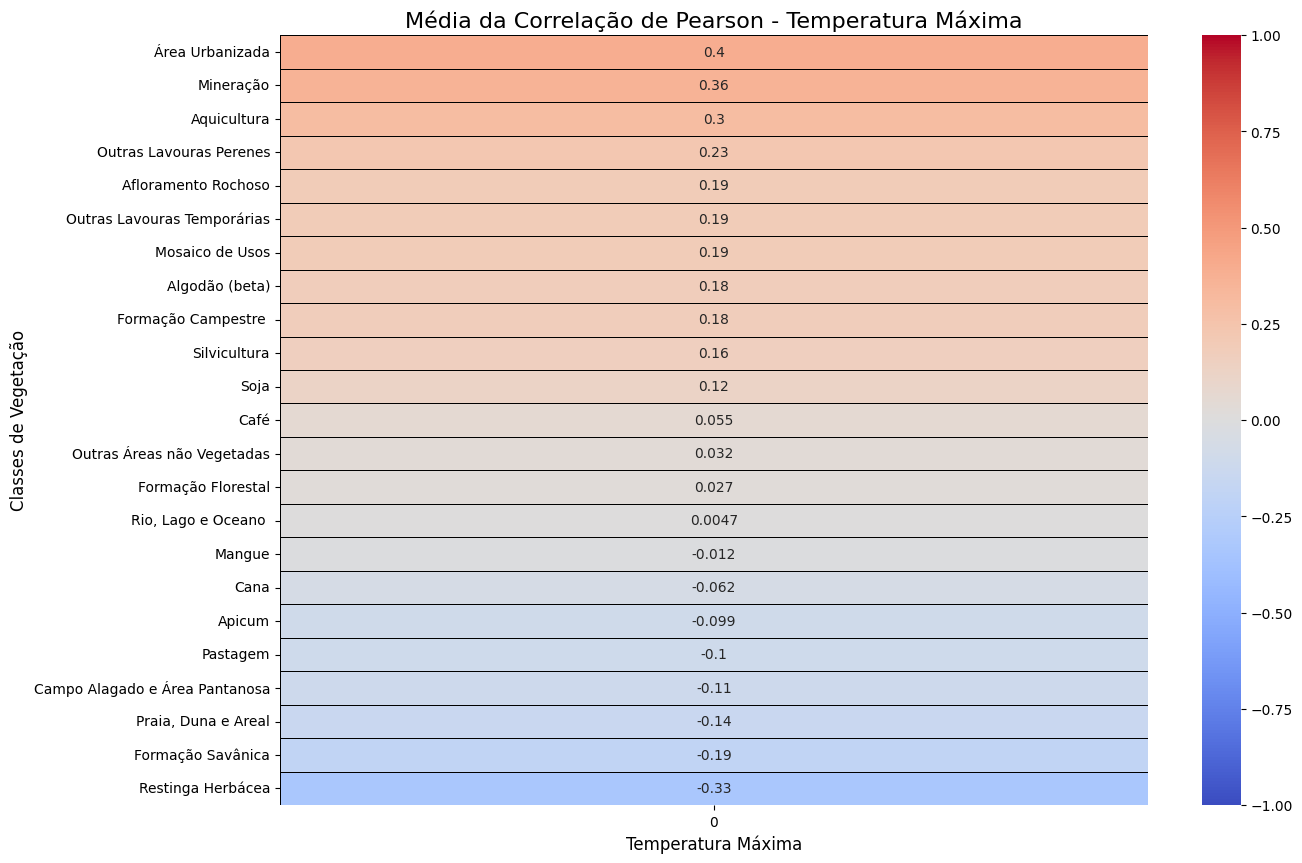

In [20]:
# Dicionário para armazenar as correlações de cada estação
correlacoes_por_estacao = {}

# Iterar por cada estação e calcular a correlação
for estacao_id in gdf_voronoi_validas_filter['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura máxima
    correlacao_temp_max = dados_para_correlacao.corr(method='pearson')['temperatura_max']
    
    # Remover a autocorrelação (correlação da temperatura máxima com ela mesma)
    correlacao_temp_max = correlacao_temp_max.drop(labels=['temperatura_max', 'temperatura_min'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao[estacao_id] = correlacao_temp_max

# Combinar todas as correlações e calcular a média
correlacoes_media = pd.DataFrame(correlacoes_por_estacao).mean(axis=1)

# Converter os índices da série para inteiros antes de mapear os nomes das classes
correlacoes_media.index = correlacoes_media.index.astype(int)

# Mapeando os nomes das classes no eixo y
correlacoes_media.index = correlacoes_media.index.map(id_to_class_name)

# Ordenar as correlações da maior para a menor
correlacoes_media = correlacoes_media.sort_values(ascending=False)

# Plotar a correlação de Pearson média para a temperatura máxima
plt.figure(figsize=(14, 10))
sns.heatmap(correlacoes_media.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black', cbar=True)
plt.title('Média da Correlação de Pearson - Temperatura Máxima', fontsize=16)
plt.ylabel('Classes de Vegetação', fontsize=12)
plt.xlabel('Temperatura Máxima', fontsize=12)
plt.show()

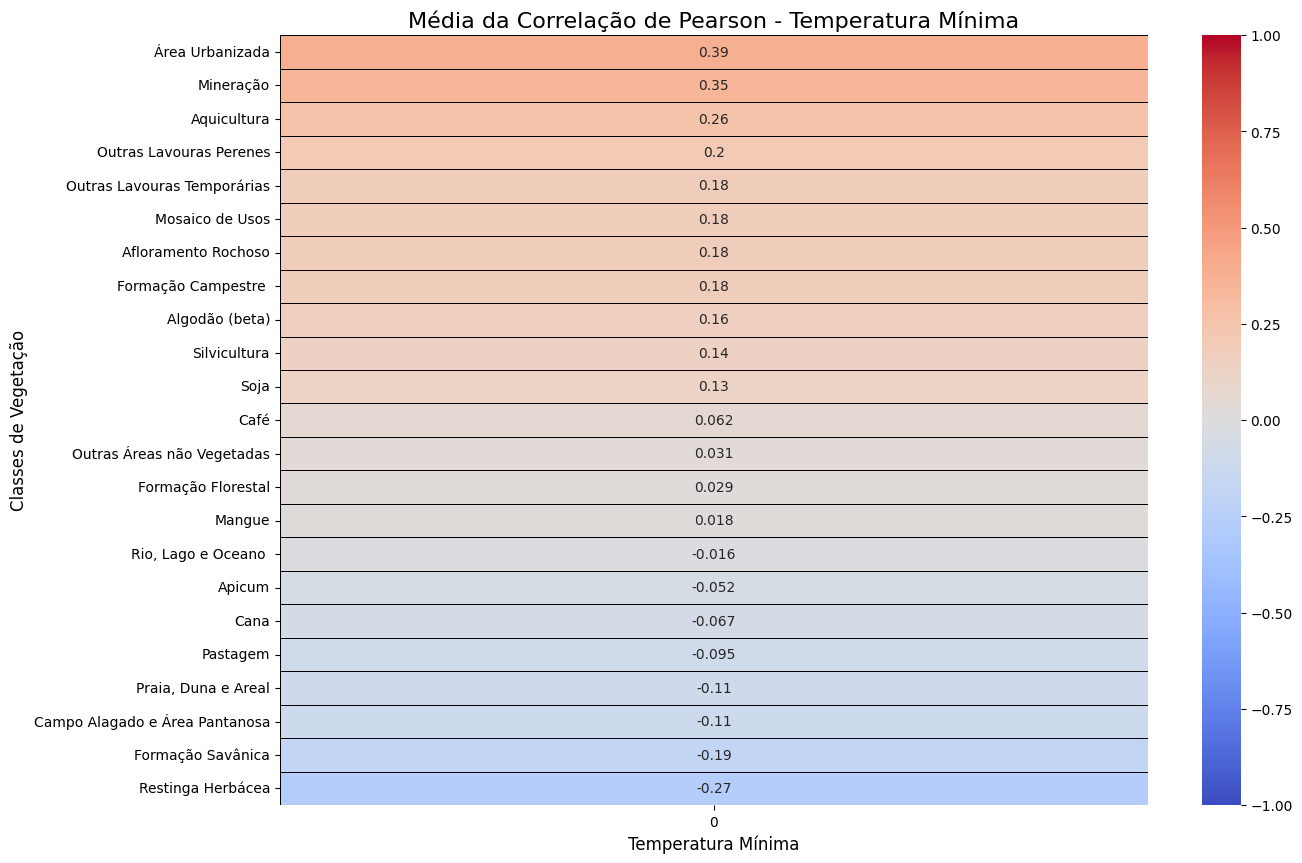

In [21]:
# Dicionário para armazenar as correlações de cada estação para temperatura mínima
correlacoes_por_estacao_min = {}

# Iterar por cada estação e calcular a correlação para a temperatura mínima
for estacao_id in gdf_voronoi_validas_filter['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura mínima
    correlacao_temp_min = dados_para_correlacao.corr(method='pearson')['temperatura_min']
    
    # Remover a autocorrelação (correlação da temperatura mínima com ela mesma)
    correlacao_temp_min = correlacao_temp_min.drop(labels=['temperatura_max', 'temperatura_min'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao_min[estacao_id] = correlacao_temp_min

# Combinar todas as correlações e calcular a média
correlacoes_media_min = pd.DataFrame(correlacoes_por_estacao_min).mean(axis=1)

# Converter os índices da série para inteiros antes de mapear os nomes das classes
correlacoes_media_min.index = correlacoes_media_min.index.astype(int)

# Mapeando os nomes das classes no eixo y
correlacoes_media_min.index = correlacoes_media_min.index.map(id_to_class_name)

# Ordenar as correlações da maior para a menor
correlacoes_media_min = correlacoes_media_min.sort_values(ascending=False)

# Plotar a correlação de Pearson média para a temperatura mínima
plt.figure(figsize=(14, 10))
sns.heatmap(correlacoes_media_min.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black', cbar=True)
plt.title('Média da Correlação de Pearson - Temperatura Mínima', fontsize=16)
plt.ylabel('Classes de Vegetação', fontsize=12)
plt.xlabel('Temperatura Mínima', fontsize=12)
plt.show()

In [47]:
# Lista para armazenar os DataFrames de cada estação
datasets_completos = []
output_base_dir = '../dados/raster_tiff_caating'
start_year = 2003
end_year = 2022

# Iterar sobre cada estação e criar o dataset completo
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Criar o dataset completo para a estação atual
    dataset_completo = criar_dataset_completo(temperaturas, output_base_dir, estacao_id, start_year, end_year)
    
    # Adicionar o ID da estação ao DataFrame
    dataset_completo['id_estacao'] = estacao_id
    
    # Adicionar o dataset da estação à lista
    datasets_completos.append(dataset_completo)

# Concatenar todos os DataFrames em um único DataFrame
dataset_completo_todas_estacoes = pd.concat(datasets_completos, ignore_index=True)

# Substituir valores NaN por 0
dataset_completo_todas_estacoes.fillna(0, inplace=True)

# Remover colunas onde todos os valores são 0
dataset_completo_todas_estacoes = dataset_completo_todas_estacoes.loc[:, (dataset_completo_todas_estacoes != 0).any(axis=0)]

# Exibir as primeiras linhas do DataFrame final
dataset_completo_todas_estacoes.head()

ano  temperatura_max  temperatura_min    39      33      41      24  \
0  2007        29.233161        27.790821  26.0  1268.0  1810.0  7346.0   
1  2008        27.938674        26.199454  87.0  1268.0  1932.0  7440.0   
2  2009        26.887711        25.768109   2.0  1238.0  3698.0  7543.0   
3  2010        28.313253        27.211097   0.0  1179.0  4500.0  7632.0   
4  2011        27.620172        26.396233   0.0  1092.0  3680.0  7730.0   

        25        15        12  ...   48   30   31   32    5   23   20   13  \
0  46448.0  162724.0  134422.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  44194.0  176902.0  133308.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  37061.0  200726.0  145177.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  29335.0  196661.0  189262.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  21856.0  204480.0  209070.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    49   50  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 29 columns]

In [57]:
# Dicionário para armazenar as correlações de cada estação
correlacoes_por_estacao = {}

# Iterar por cada estação e calcular a correlação
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura máxima
    correlacao_temp_max = dados_para_correlacao.corr(method='pearson')['temperatura_max']
    
    # Remover a autocorrelação (correlação da temperatura máxima com ela mesma)
    correlacao_temp_max = correlacao_temp_max.drop(labels=['temperatura_max', 'temperatura_min'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao[estacao_id] = correlacao_temp_max


# Transformar o dicionário de correlações em um DataFrame para temperatura máxima
df_correlacoes_max = pd.DataFrame(correlacoes_por_estacao).T

# Resetar o índice para transformar o 'id_estacao' em uma coluna
df_correlacoes_max.reset_index(inplace=True)

# Renomear a coluna de índice para 'id_estacao'
df_correlacoes_max.rename(columns={'index': 'id_estacao'}, inplace=True)

# Mapear os IDs das classes para os nomes das classes nas colunas
df_correlacoes_max.columns = ['id_estacao'] + [id_to_class_name.get(int(col), col) for col in df_correlacoes_max.columns[1:]]

# Transformar NaN em 0
df_correlacoes_max.fillna(0, inplace=True)

# Exibir o DataFrame de correlações para temperatura máxima
df_correlacoes_max.head()

id_estacao      Soja  Rio, Lago e Oceano   Outras Lavouras Temporárias  \
0       A336  0.159536            -0.419642                     0.285628   
1       A365  0.191754            -0.061914                    -0.118115   
2       A416 -0.322939             0.304682                    -0.119947   
3       A433  0.000000            -0.325320                     0.193207   
4       A308 -0.138934            -0.044846                     0.342758   

   Área Urbanizada  Outras Áreas não Vegetadas  Pastagem  Formação Campestre   \
0         0.304521                    0.207384 -0.067890            -0.064259   
1        -0.022711                    0.538484  0.066544            -0.342919   
2        -0.226619                    0.184891 -0.072953            -0.130615   
3         0.047975                   -0.290466  0.494353             0.292087   
4         0.196615                    0.274033  0.263885             0.183236   

   Mosaico de Usos  Formação Florestal  ...  Outras Lavouras Perenes  \
0         0.128502           -0.418631  ...                 0.000000   
1        -0.590417            0.072746  ...                 0.000000   
2        -0.199982           -0.129211  ...                -0.172807   
3        -0.415567            0.319751  ...                 0.441806   
4         0.134748           -0.105654  ...                 0.159144   

   Mineração  Aquicultura    Apicum    Mangue  Praia, Duna e Areal  Cana  \
0   0.000000     0.000000  0.000000  0.000000             0.000000   0.0   
1   0.000000     0.000000  0.000000  0.000000             0.000000   0.0   
2   0.000000     0.000000  0.000000  0.000000             0.000000   0.0   
3   0.214664     0.000000  0.000000  0.000000             0.000000   0.0   
4   0.000000     0.163899 -0.162945  0.243638            -0.061693   0.0   

   Outras Formações Não Florestais  Restinga Arbórea  Restinga Herbácea  
0                              0.0               0.0                0.0  
1                              0.0               0.0                0.0  
2                              0.0               0.0                0.0  
3                              0.0               0.0                0.0  
4                              0.0               0.0                0.0  

[5 rows x 26 columns]

In [58]:
# Dicionário para armazenar as correlações de cada estação para temperatura mínima
correlacoes_por_estacao_min = {}

# Iterar por cada estação e calcular a correlação para a temperatura mínima
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura mínima
    correlacao_temp_min = dados_para_correlacao.corr(method='pearson')['temperatura_min']
    
    # Remover a autocorrelação (correlação da temperatura mínima com ela mesma)
    correlacao_temp_min = correlacao_temp_min.drop(labels=['temperatura_max', 'temperatura_min'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao_min[estacao_id] = correlacao_temp_min

# Transformar o dicionário de correlações em um DataFrame para temperatura mínima
df_correlacoes_min = pd.DataFrame(correlacoes_por_estacao_min).T

# Resetar o índice para transformar o 'id_estacao' em uma coluna
df_correlacoes_min.reset_index(inplace=True)

# Renomear a coluna de índice para 'id_estacao'
df_correlacoes_min.rename(columns={'index': 'id_estacao'}, inplace=True)

# Mapear os IDs das classes para os nomes das classes nas colunas
df_correlacoes_min.columns = ['id_estacao'] + [id_to_class_name.get(int(col), col) for col in df_correlacoes_min.columns[1:]]

# Transformar NaN em 0
df_correlacoes_min.fillna(0, inplace=True)

# Exibir o DataFrame de correlações para temperatura mínima
df_correlacoes_min.head()

id_estacao      Soja  Rio, Lago e Oceano   Outras Lavouras Temporárias  \
0       A336  0.195073            -0.370917                     0.300006   
1       A365  0.218449            -0.061257                    -0.109325   
2       A416 -0.255334             0.298242                    -0.023807   
3       A433  0.000000            -0.306259                     0.159602   
4       A308 -0.081674            -0.100249                     0.255143   

   Área Urbanizada  Outras Áreas não Vegetadas  Pastagem  Formação Campestre   \
0         0.305729                    0.186774 -0.125188            -0.056721   
1        -0.006862                    0.592300  0.052652            -0.407216   
2        -0.165261                    0.107888 -0.002596            -0.071764   
3        -0.019615                   -0.299610  0.388640             0.250626   
4         0.109799                    0.179620  0.132214             0.216011   

   Mosaico de Usos  Formação Florestal  ...  Outras Lavouras Perenes  \
0         0.163625           -0.404847  ...                 0.000000   
1        -0.606164            0.102371  ...                 0.000000   
2        -0.185564           -0.028923  ...                -0.169213   
3        -0.341942            0.180767  ...                 0.300651   
4         0.066758           -0.058803  ...                 0.077224   

   Mineração  Aquicultura    Apicum    Mangue  Praia, Duna e Areal  Cana  \
0   0.000000     0.000000  0.000000  0.000000             0.000000   0.0   
1   0.000000     0.000000  0.000000  0.000000             0.000000   0.0   
2   0.000000     0.000000  0.000000  0.000000             0.000000   0.0   
3   0.117916     0.000000  0.000000  0.000000             0.000000   0.0   
4   0.000000     0.048841 -0.138699  0.169392             0.035559   0.0   

   Outras Formações Não Florestais  Restinga Arbórea  Restinga Herbácea  
0                              0.0               0.0                0.0  
1                              0.0               0.0                0.0  
2                              0.0               0.0                0.0  
3                              0.0               0.0                0.0  
4                              0.0               0.0                0.0  

[5 rows x 26 columns]

In [59]:
def plot_heatmap_correlacao_por_estacao(df_correlacoes, id_estacao, tipo_temperatura='min', cmap='coolwarm'):
    """
    Plota um heatmap de correlações para uma estação específica com estilo consistente ao heatmap médio.
    
    Parâmetros:
    - df_correlacoes: DataFrame com as correlações das estações (df_correlacoes_min ou df_correlacoes_max).
                       Deve conter uma coluna 'id_estacao' e outras colunas correspondentes aos nomes das classes.
    - id_estacao: ID da estação (string ou inteiro) que você deseja visualizar.
    - tipo_temperatura: 'min' para temperatura mínima ou 'max' para temperatura máxima.
    - cmap: Mapa de cores para o heatmap. Default é 'coolwarm'.
    """
    # Verificar se 'id_estacao' está no DataFrame
    if 'id_estacao' not in df_correlacoes.columns:
        print("O DataFrame fornecido não contém a coluna 'id_estacao'.")
        return
    
    # Filtrar o DataFrame para a estação específica
    station_data = df_correlacoes[df_correlacoes['id_estacao'] == id_estacao]
    
    if station_data.empty:
        print(f"Nenhuma correlação encontrada para a estação {id_estacao}.")
        return
    
    # Remover a coluna 'id_estacao'
    correlations = station_data.drop('id_estacao', axis=1)
    
    # Transpor para ter classes como índice
    correlations = correlations.T
    
    # Renomear a coluna para 'Correlação'
    correlations.columns = ['Correlação']
    
    # Ordenar as correlações da maior para a menor
    correlations_sorted = correlations.sort_values(by='Correlação', ascending=False)
    
    # Configurar o estilo do plot para ser consistente
    plt.figure(figsize=(14, 10))
    sns.set(style="whitegrid")
    
    # Plotar o heatmap
    sns.heatmap(
        correlations_sorted,
        annot=True,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        linecolor='black',
        cbar=True,
        fmt=".2f",
        annot_kws={"size": 12}
    )
    
    # Definir títulos e labels
    plt.title(f'Correlação de Pearson - Temperatura {"Mínima" if tipo_temperatura == "min" else "Máxima"} - Estação {id_estacao}', fontsize=16)
    plt.ylabel('Classes de Vegetação', fontsize=12)
    plt.xlabel(f'Temperatura {"Mínima" if tipo_temperatura == "min" else "Máxima"}', fontsize=12)
    
    # Ajustar layout para melhor visualização
    plt.tight_layout()
    
    # Exibir o heatmap
    plt.show()

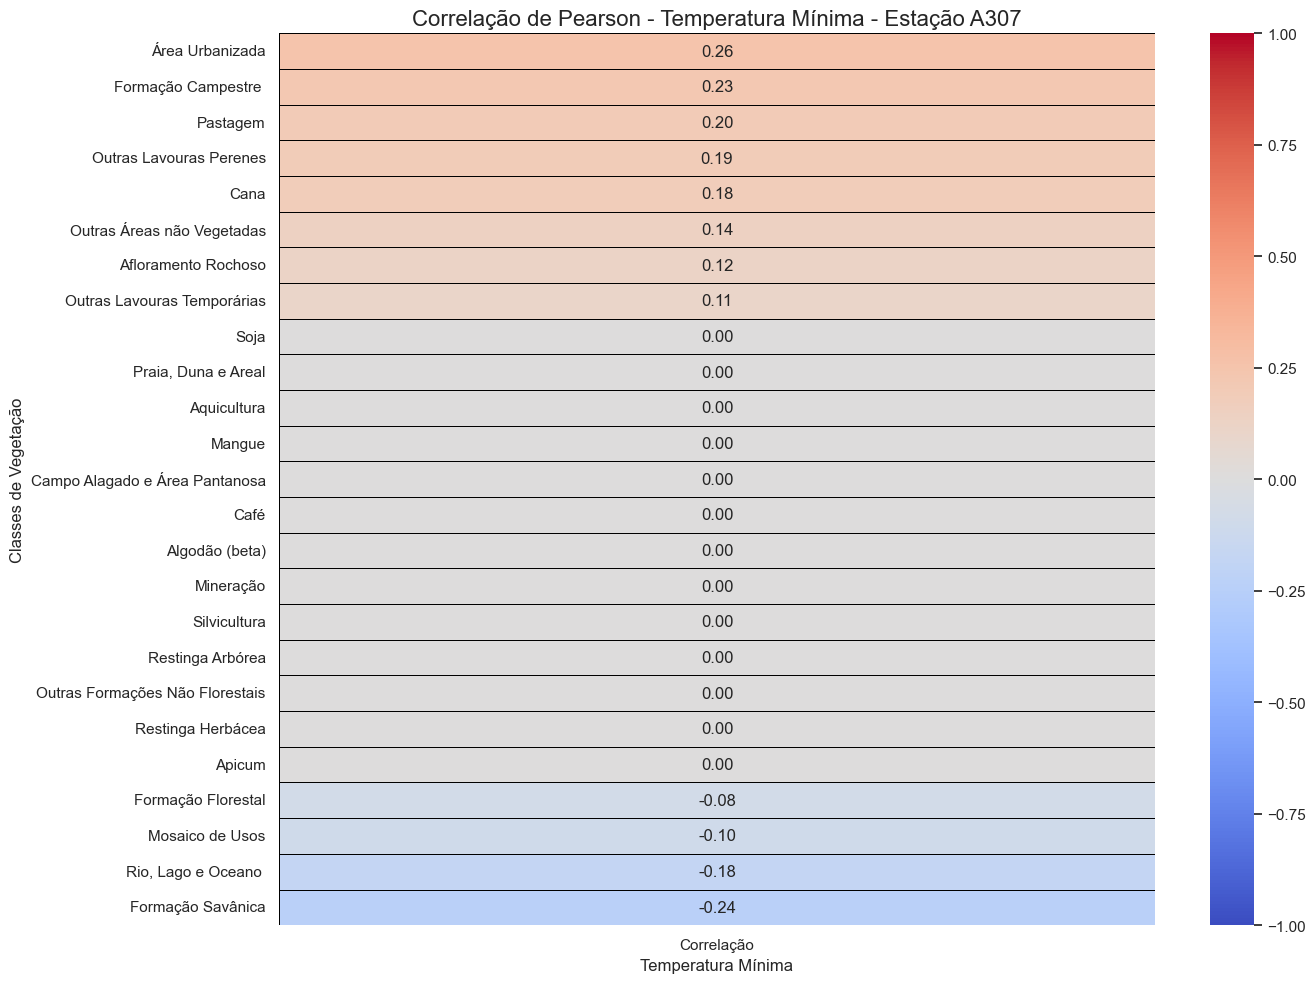

In [60]:
# Plotar o heatmap para a estação com ID '123' para temperatura mínima
plot_heatmap_correlacao_por_estacao(
    df_correlacoes=df_correlacoes_min,
    id_estacao='A307',  
    tipo_temperatura='min',
    cmap='coolwarm'
)

Valores NaN representam as classes que não possuem mudanças, a variância de uma variável constante é zero. Foram preenchidos com 0.

In [52]:
# arredondar para 3 casas decimais
df_correlacoes_max = df_correlacoes_max.round(3)
df_correlacoes_min = df_correlacoes_min.round(3)

# trocar ponto por vírgula
df_correlacoes_max = df_correlacoes_max.applymap(lambda x: str(x).replace('.', ','))
df_correlacoes_min = df_correlacoes_min.applymap(lambda x: str(x).replace('.', ','))

C:\Users\arthu\AppData\Local\Temp\ipykernel_19788\3952907751.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_correlacoes_max = df_correlacoes_max.applymap(lambda x: str(x).replace('.', ','))
C:\Users\arthu\AppData\Local\Temp\ipykernel_19788\3952907751.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_correlacoes_min = df_correlacoes_min.applymap(lambda x: str(x).replace('.', ','))


In [53]:
df_correlacoes_max.head()

id_estacao    Soja Rio, Lago e Oceano  Outras Lavouras Temporárias  \
0       A336    0,16               -0,42                       0,286   
1       A365   0,192              -0,062                      -0,118   
2       A416  -0,323               0,305                       -0,12   
3       A433     0,0              -0,325                       0,193   
4       A308  -0,139              -0,045                       0,343   

  Área Urbanizada Outras Áreas não Vegetadas Pastagem Formação Campestre   \
0           0,305                      0,207   -0,068              -0,064   
1          -0,023                      0,538    0,067              -0,343   
2          -0,227                      0,185   -0,073              -0,131   
3           0,048                      -0,29    0,494               0,292   
4           0,197                      0,274    0,264               0,183   

  Mosaico de Usos Formação Florestal  ... Outras Lavouras Perenes Mineração  \
0           0,129             -0,419  ...                     0,0       0,0   
1           -0,59              0,073  ...                     0,0       0,0   
2            -0,2             -0,129  ...                  -0,173       0,0   
3          -0,416               0,32  ...                   0,442     0,215   
4           0,135             -0,106  ...                   0,159       0,0   

  Aquicultura  Apicum Mangue Praia, Duna e Areal Cana  \
0         0,0     0,0    0,0                 0,0  0,0   
1         0,0     0,0    0,0                 0,0  0,0   
2         0,0     0,0    0,0                 0,0  0,0   
3         0,0     0,0    0,0                 0,0  0,0   
4       0,164  -0,163  0,244              -0,062  0,0   

  Outras Formações Não Florestais Restinga Arbórea Restinga Herbácea  
0                             0,0              0,0               0,0  
1                             0,0              0,0               0,0  
2                             0,0              0,0               0,0  
3                             0,0              0,0               0,0  
4                             0,0              0,0               0,0  

[5 rows x 26 columns]

In [54]:
df_correlacoes_min.head()

id_estacao    Soja Rio, Lago e Oceano  Outras Lavouras Temporárias  \
0       A336   0,195              -0,371                         0,3   
1       A365   0,218              -0,061                      -0,109   
2       A416  -0,255               0,298                      -0,024   
3       A433     0,0              -0,306                        0,16   
4       A308  -0,082                -0,1                       0,255   

  Área Urbanizada Outras Áreas não Vegetadas Pastagem Formação Campestre   \
0           0,306                      0,187   -0,125              -0,057   
1          -0,007                      0,592    0,053              -0,407   
2          -0,165                      0,108   -0,003              -0,072   
3           -0,02                       -0,3    0,389               0,251   
4            0,11                       0,18    0,132               0,216   

  Mosaico de Usos Formação Florestal  ... Outras Lavouras Perenes Mineração  \
0           0,164             -0,405  ...                     0,0       0,0   
1          -0,606              0,102  ...                     0,0       0,0   
2          -0,186             -0,029  ...                  -0,169       0,0   
3          -0,342              0,181  ...                   0,301     0,118   
4           0,067             -0,059  ...                   0,077       0,0   

  Aquicultura  Apicum Mangue Praia, Duna e Areal Cana  \
0         0,0     0,0    0,0                 0,0  0,0   
1         0,0     0,0    0,0                 0,0  0,0   
2         0,0     0,0    0,0                 0,0  0,0   
3         0,0     0,0    0,0                 0,0  0,0   
4       0,049  -0,139  0,169               0,036  0,0   

  Outras Formações Não Florestais Restinga Arbórea Restinga Herbácea  
0                             0,0              0,0               0,0  
1                             0,0              0,0               0,0  
2                             0,0              0,0               0,0  
3                             0,0              0,0               0,0  
4                             0,0              0,0               0,0  

[5 rows x 26 columns]

In [55]:
# Salvar as correlações de temperatura máxima em um CSV
df_correlacoes_max.to_csv('../dados/correlacoes_temperatura_maxima.csv', index=False)

# Salvar as correlações de temperatura mínima em um CSV
df_correlacoes_min.to_csv('../dados/correlacoes_temperatura_minima.csv', index=False)

# Usando dados de temperatura de satélite

In [53]:
# Caminho para o shapefile dos biomas
biomes_shp = '../dados/Biomas_250mil/lm_bioma_250.shp'

# Carregar o shapefile dos biomas
biomes = gpd.read_file(biomes_shp)

# Filtrar para obter apenas a Caatinga
caatinga = biomes[biomes['Bioma'] == 'Caatinga']

# Convertendo em GeoDataFrame
gdf_caatinga = gpd.GeoDataFrame(geometry=[caatinga.unary_union], crs=caatinga.crs)

C:\Users\arthu\AppData\Local\Temp\ipykernel_5408\2916740094.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_caatinga = gpd.GeoDataFrame(geometry=[caatinga.unary_union], crs=caatinga.crs)


In [54]:
# Definir a área de interesse (AOI) como o envelope da Caatinga
aoi = gdf_caatinga.envelope

# Obter os limites da AOI
x_min, y_min, x_max, y_max = aoi.bounds.values[0]

# Gerar a malha de pontos com latitude e longitude no CRS EPSG:4674
# Usamos passos pequenos para gerar pontos (0.5 graus) 
x_coords = np.arange(x_min, x_max, 0.5)
y_coords = np.arange(y_min, y_max, 0.5)
points = [Point(x, y) for x in x_coords for y in y_coords]
grid_gdf = gpd.GeoDataFrame(points, columns=['geometry'], crs=gdf_caatinga.crs)

# Filtrar pontos que estão fora da área da Caatinga
grid_gdf = grid_gdf[grid_gdf.geometry.within(gdf_caatinga.unary_union)]

C:\Users\arthu\AppData\Local\Temp\ipykernel_5408\1524549068.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf = grid_gdf[grid_gdf.geometry.within(gdf_caatinga.unary_union)]


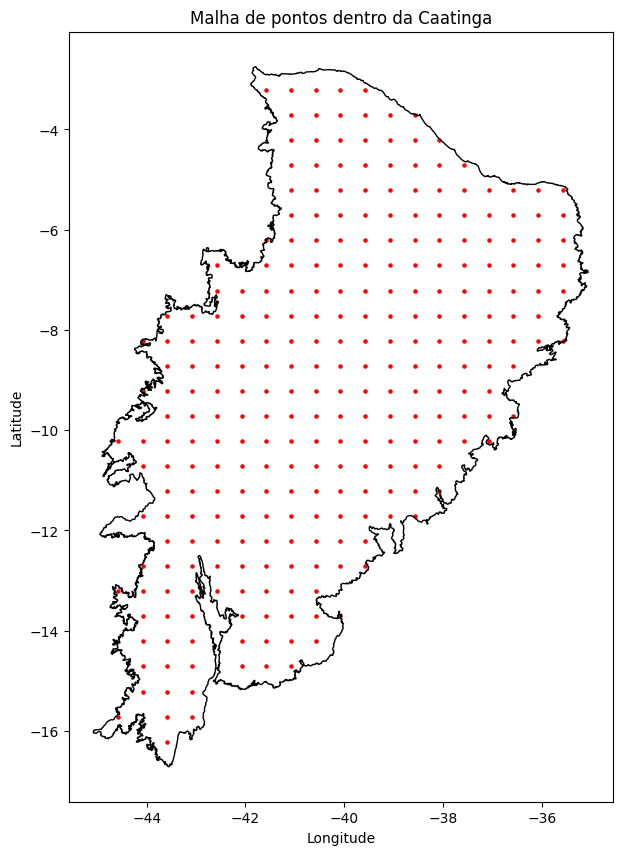

In [55]:
# Plotar a Caatinga e a malha de pontos
fig, ax = plt.subplots(figsize=(10, 10))
gdf_caatinga.boundary.plot(ax=ax, color='black', linewidth=1)
grid_gdf.plot(ax=ax, color='red', markersize=5)
plt.title('Malha de pontos dentro da Caatinga')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# Atribuir IDs únicos a cada ponto
grid_gdf['id'] = ['SAT' + str(i) for i in range(len(grid_gdf))]

# Adicionar pontos fictícios ao redor do perímetro da Caatinga
minx, miny, maxx, maxy = caatinga.total_bounds
padding = 0.5  # Ajuste conforme necessário
extra_points = [
    [minx - padding, miny - padding],
    [minx - padding, maxy + padding],
    [maxx + padding, miny - padding],
    [maxx + padding, maxy + padding]
]

# Adicionar os novos pontos às coordenadas das estações
extra_points_geom = [Point(x, y) for x, y in extra_points]
extra_gdf = gpd.GeoDataFrame(extra_points_geom, columns=['geometry'], crs=gdf_caatinga.crs)

# Concatenar os pontos fictícios ao GeoDataFrame original
all_points_gdf = pd.concat([grid_gdf, extra_gdf], ignore_index=True)

# Extraindo coordenadas para criação dos polígonos de Voronoi
coords = np.array(list(zip(all_points_gdf.geometry.x, all_points_gdf.geometry.y)))

# Gerar os polígonos de Voronoi
vor = Voronoi(coords)

# Criar polígonos de Voronoi a partir dos vértices
polygons = []
for region in vor.regions:
    if not -1 in region and region:
        polygon = Polygon([vor.vertices[i] for i in region])
        polygons.append(polygon)

# Criar um GeoDataFrame com os polígonos de Voronoi
gdf_voronoi = gpd.GeoDataFrame(geometry=polygons, crs=all_points_gdf.crs)

# Verificar e corrigir geometrias inválidas antes do clipping
gdf_voronoi['geometry'] = gdf_voronoi['geometry'].buffer(0)

# Clipping com o polígono da Caatinga para garantir que todos os polígonos estejam dentro da região
gdf_voronoi_clipped = gpd.GeoDataFrame(
    geometry=[poly.intersection(gdf_caatinga.unary_union) for poly in gdf_voronoi.geometry if not poly.is_empty],
    crs=gdf_voronoi.crs
)

# Remover geometrias vazias
gdf_voronoi_clipped = gdf_voronoi_clipped[~gdf_voronoi_clipped.is_empty]

In [57]:
# Associar o polígono ao ID da estação mais próxima
def find_nearest_station(polygon, stations):
    centroid = polygon.centroid
    distances = stations.geometry.apply(lambda x: centroid.distance(x))
    nearest_station = stations.loc[distances.idxmin()]
    return nearest_station['id']

# Aplicar a função para encontrar o ID da estação
gdf_voronoi_clipped['id'] = gdf_voronoi_clipped.geometry.apply(lambda poly: find_nearest_station(poly, grid_gdf))

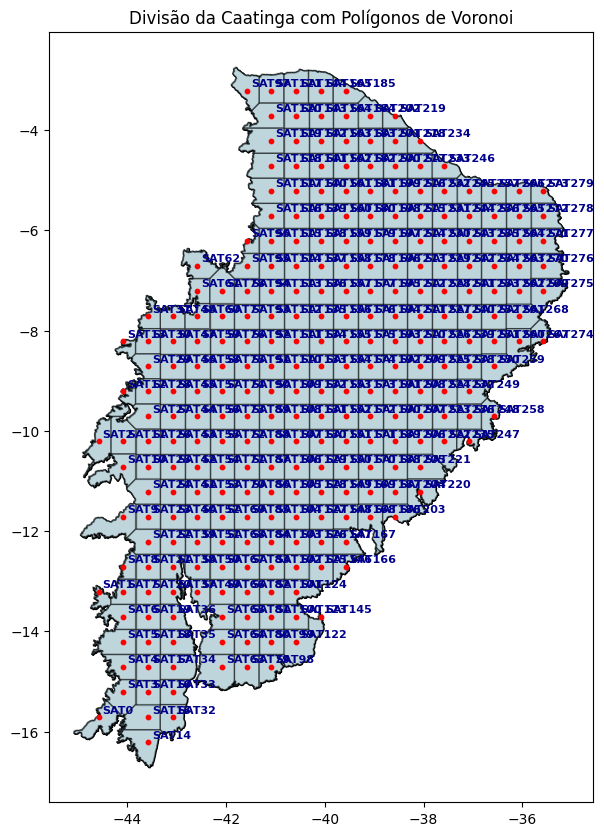

In [66]:
# Plotar o resultado
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o perímetro da Caatinga
gdf_caatinga.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plotar os polígonos de Voronoi
gdf_voronoi_clipped.plot(ax=ax, edgecolor='black', color='lightblue', alpha=0.5)

# Plotar os pontos
grid_gdf.plot(ax=ax, color='red', markersize=10)

# Adicionar o ID dos pontos no plot
for x, y, label in zip(grid_gdf.geometry.x, grid_gdf.geometry.y, grid_gdf['id']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='darkblue', weight='bold')

plt.title('Divisão da Caatinga com Polígonos de Voronoi')
plt.show()

In [65]:
# salvar o shapefile resultante
gdf_voronoi_clipped.to_file('../dados/shapefile_estacoes_divididas/caatinga_territorios_dividido_SAT.shp')

# Recuperando informação de temperatura para cada estação

In [69]:
import ee
import pandas as pd

In [70]:
ee.Authenticate(force=True)
service_account = 'pdi-618@projetopdi-430718.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '../dados/projetopdi-430718-5d4f0b0f6064.json')
ee.Initialize(credentials)


Successfully saved authorization token.


In [7]:
def get_modis_temperature_by_year_range(lat, lon, start_year, end_year):
    """
    Função para obter as temperaturas médias máximas e mínimas de superfície terrestre do MODIS para uma latitude, 
    longitude e intervalo de anos específico.
    
    Parâmetros:
    - lat (float): Latitude do local.
    - lon (float): Longitude do local.
    - start_year (int): Ano inicial do intervalo.
    - end_year (int): Ano final do intervalo.
    
    Retorna:
    - Lista de temperaturas médias máximas e mínimas de superfície terrestre em Celsius para cada ano no intervalo.
    """
    
    # Inicializar o ponto de interesse
    point = ee.Geometry.Point(lon, lat)
    
    # Definir datas de início e fim com base no intervalo de anos
    start_date = f'{start_year}-01-01'
    end_date = f'{end_year}-12-31'
    
    # Coleção de dados MODIS de temperatura da superfície terrestre
    dataset = ee.ImageCollection('MODIS/061/MOD11A1') \
        .filterBounds(point) \
        .filterDate(start_date, end_date) \
        .select(['LST_Day_1km', 'LST_Night_1km'])
    
    # Verificar se imagens foram encontradas
    if dataset.size().getInfo() == 0:
        raise ValueError("Nenhuma imagem encontrada para o intervalo de anos e localização especificados.")
    
    # Lista para armazenar as temperaturas médias máximas e mínimas por ano
    temperaturas_anuais = []
    
    # Loop através dos anos no intervalo
    for year in range(start_year, end_year + 1):
        year_start = f'{year}-01-01'
        year_end = f'{year}-12-31'
        
        # Filtrar a coleção de dados para o ano específico
        year_images = dataset.filterDate(year_start, year_end)
        
        # Calcular as temperaturas médias diurna e noturna para o ano
        mean_temp_day_image = year_images.select('LST_Day_1km').median()
        mean_temp_night_image = year_images.select('LST_Night_1km').median()
        
        # Amostrar os valores das temperaturas no ponto de interesse
        try:
            temp_day_dict = mean_temp_day_image.sample(region=point, scale=1000).first().getInfo()
            temp_night_dict = mean_temp_night_image.sample(region=point, scale=1000).first().getInfo()
            
            if temp_day_dict is None or 'properties' not in temp_day_dict or temp_night_dict is None or 'properties' not in temp_night_dict:
                raise ValueError("Amostragem falhou ou não retornou dados válidos.")
            
            # Converter de Kelvin para Celsius
            temp_max_celsius = temp_day_dict['properties']['LST_Day_1km'] * 0.02 - 273.15
            temp_min_celsius = temp_night_dict['properties']['LST_Night_1km'] * 0.02 - 273.15
            
            temperaturas_anuais.append({'year': year, 'max_temperature': temp_max_celsius, 'min_temperature': temp_min_celsius})
        
        except Exception as e:
            raise ValueError(f"Erro ao obter temperatura para o ano {year}: {e}")
    
    return temperaturas_anuais

In [63]:
# Extraindo as coordenadas e IDs das estações
stations_df = grid_gdf[['id', 'geometry']].copy()
stations_df['latitude'] = stations_df.geometry.y
stations_df['longitude'] = stations_df.geometry.x

# Definir o intervalo de anos
start_year = 2003
end_year = 2022

# Inicializar uma lista para armazenar todos os dados de temperatura
all_temperatures = []

# Iterar sobre cada estação no dataframe
for index, station in stations_df.iterrows():
    lat = station['latitude']
    lon = station['longitude']
    id_estacao = station['id']
    
    try:
        # Obter as temperaturas para a estação atual
        temperaturas = get_modis_temperature_by_year_range(lat, lon, start_year, end_year)
        
        # Adicionar o ID da estação aos dados de temperatura
        for temp in temperaturas:
            temp['id_estacao'] = id_estacao
            temp['latitude'] = lat
            temp['longitude'] = lon
            all_temperatures.append(temp)
    
    except ValueError as e:
        print(f"Erro ao obter temperaturas para a estação {id_estacao}: {e}")

# Converter a lista de temperaturas para um DataFrame
temperature_df = pd.DataFrame(all_temperatures)

# Reorganizar colunas para melhor visualização
temperature_df = temperature_df[['id_estacao', 'year', 'latitude', 'longitude', 'max_temperature', 'min_temperature']]

# Exibir o DataFrame final
temperature_df.head()

id_estacao  year   latitude  longitude  max_temperature  min_temperature
0       SAT0  2003 -15.712637 -44.578141        28.046000        19.590000
1       SAT0  2004 -15.712637 -44.578141        26.398571        18.550000
2       SAT0  2005 -15.712637 -44.578141        27.144444        19.555000
3       SAT0  2006 -15.712637 -44.578141        25.992500        18.613333
4       SAT0  2007 -15.712637 -44.578141        27.308000        19.345000

In [64]:
# salvar o dataframe
temperature_df.to_csv('../dados/temperaturas_estacoes_modis.csv', index=False)

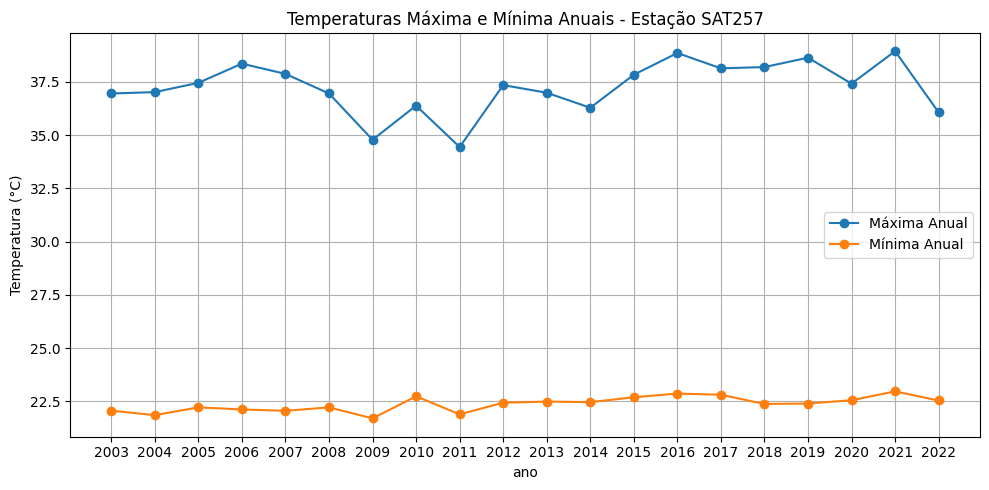

In [47]:
# abrir o arquivo CSV
temperature_df = pd.read_csv('../dados/temperaturas_estacoes_modis.csv')

# Filtrar os dados apenas para a estação SAT0
dados_SAT0 = temperature_df[temperature_df['id_estacao'] == 'SAT257']

# Agrupar por ano e calcular a temperatura máxima e mínima anual
temperatura_anual = dados_SAT0.groupby('year').agg(
    temperatura_max=('max_temperature', 'max'),
    temperatura_min=('min_temperature', 'min')
).reset_index()

# Plotar a série temporal anual
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['year'], temperatura_anual['temperatura_max'], label='Máxima Anual', marker='o')
plt.plot(temperatura_anual['year'], temperatura_anual['temperatura_min'], label='Mínima Anual', marker='o')

plt.xlabel('ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais - Estação SAT257')
plt.xticks(range(temperatura_anual['year'].min(), temperatura_anual['year'].max() + 1))  # Define os ticks do eixo x para cada year
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Separar os arquivos geotif por estação

In [70]:
def process_all_tiffs(segmentacoes_dir, output_base_dir, gdf_voronoi_clipped):
    """
    Processa todos os arquivos GeoTIFF na pasta segmentacoes para todas as estações,
    salvando os resultados em pastas separadas por ano.

    Args:
    segmentacoes_dir (str): Caminho para a pasta contendo os arquivos GeoTIFF de entrada.
    output_base_dir (str): Diretório base onde os GeoTIFFs resultantes serão salvos.
    gdf_voronoi_clipped (GeoDataFrame): GeoDataFrame contendo os polígonos de Voronoi.
    """

    # Listar todos os arquivos GeoTIFF na pasta segmentacoes
    tiff_files = glob.glob(os.path.join(segmentacoes_dir, '*.tif'))

    # Obter os IDs únicos das estações
    estacao_ids = gdf_voronoi_clipped['id_estacao'].unique()

    for tiff_file in tiff_files:
        # Extrair o ano do nome do arquivo GeoTIFF
        year = os.path.basename(tiff_file).split('_')[-1].split('.')[0]

        # Criar diretório para o ano se não existir
        year_dir = os.path.join(output_base_dir, year)
        os.makedirs(year_dir, exist_ok=True)

        for estacao_id in estacao_ids:
            # Aplicar a função para salvar o TIFF mascarado
            save_masked_tiff(tiff_file, estacao_id, year_dir, gdf_voronoi_clipped)
            print(f"Salvo: {year_dir}/coverage_{estacao_id}_{year}.tif")


# Definir caminhos
segmentacoes_dir = '../dados/segmentacoes'
output_base_dir = '../dados/raster_tiff_caating_sat'

# Executar o processamento para todos os arquivos e estações
process_all_tiffs(segmentacoes_dir, output_base_dir, gdf_voronoi_clipped)

Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT144_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT121_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT13_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT11_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT2_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT12_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT165_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT14_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT35_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT153_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT132_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT5_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT18_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT0_2003.tif
Salvo: ../dados/raster_tiff_caat

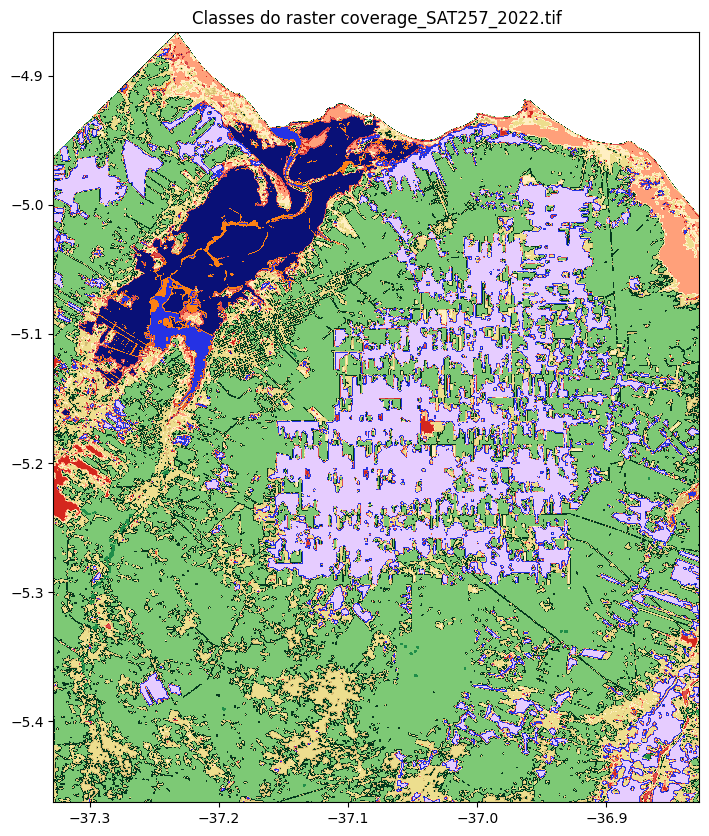

In [48]:
output_tif_path = '../dados/raster_tiff_caating_sat/2022/coverage_SAT257_2022.tif'
plot_tiff_with_classes(output_tif_path)

In [149]:
# Extrair informações do GeoTIFF salvo
sorted_class_counts = extract_classification_info(output_tif_path)

# Exibir as classificações e contagens
print("Contagem de superpixels por classe (ordenado):", sorted_class_counts)

Contagem de superpixels por classe (ordenado): {np.uint8(30): np.int64(1338), np.uint8(25): np.int64(3320), np.uint8(33): np.int64(4915), np.uint8(0): np.int64(7424), np.uint8(41): np.int64(21121), np.uint8(12): np.int64(27223), np.uint8(24): np.int64(42642), np.uint8(21): np.int64(123141), np.uint8(15): np.int64(269771), np.uint8(4): np.int64(1410352), np.uint8(3): np.int64(1537202)}


# Montagem do dataset para cada estação

In [178]:
# Carregar o shapefile do Voronoi previamente salvo
gdf_voronoi_clipped = gpd.read_file('../dados/shapefile_estacoes_divididas/caatinga_territorios_dividido_SAT.shp')
gdf_voronoi_clipped.rename(columns={'id': 'id_estacao'}, inplace=True)
gdf_voronoi_clipped.head()

id_estacao                                           geometry
0     SAT144  POLYGON ((-40.32814 -3.46264, -40.82814 -3.462...
1     SAT121  POLYGON ((-40.82814 -3.46264, -41.32814 -3.462...
2      SAT13  POLYGON ((-43.91258 -8.54708, -43.91273 -8.547...
3      SAT11  MULTIPOLYGON (((-44.32814 -9.72916, -44.32813 ...
4       SAT2  MULTIPOLYGON (((-44.32814 -9.71264, -44.32814 ...

In [179]:
# abrir o arquivo CSV com as temperaturas
temperature_df = pd.read_csv('../dados/temperaturas_estacoes_modis.csv')
# alterar nome max_temperature para temperatura_max e min_temperature para temperatura_min
temperature_df.rename(columns={'max_temperature': 'temperatura_max', 'min_temperature': 'temperatura_min', 'year': 'ano'}, inplace=True)
temperature_df.head()

id_estacao   ano   latitude  longitude  temperatura_max  temperatura_min
0       SAT0  2003 -15.712637 -44.578141        28.046000        19.590000
1       SAT0  2004 -15.712637 -44.578141        26.398571        18.550000
2       SAT0  2005 -15.712637 -44.578141        27.144444        19.555000
3       SAT0  2006 -15.712637 -44.578141        25.992500        18.613333
4       SAT0  2007 -15.712637 -44.578141        27.308000        19.345000

In [193]:
# Lista para armazenar os DataFrames de cada estação
datasets_completos = []
output_base_dir = '../dados/raster_tiff_caating_sat'
start_year = 2003
end_year = 2022

# Iterar sobre cada estação e criar o dataset completo
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Criar o dataset completo para a estação atual
    dataset_completo = criar_dataset_completo(temperature_df, output_base_dir, estacao_id, start_year, end_year)
    
    # Adicionar o ID da estação ao DataFrame
    dataset_completo['id_estacao'] = estacao_id
    
    # Adicionar o dataset da estação à lista
    datasets_completos.append(dataset_completo)

# Concatenar todos os DataFrames em um único DataFrame
dataset_completo_todas_estacoes = pd.concat(datasets_completos, ignore_index=True)

# Substituir valores NaN por 0
dataset_completo_todas_estacoes.fillna(0, inplace=True)

# Remover colunas onde todos os valores são 0
dataset_completo_todas_estacoes = dataset_completo_todas_estacoes.loc[:, (dataset_completo_todas_estacoes != 0).any(axis=0)]

# Exibir as primeiras linhas do DataFrame final
dataset_completo_todas_estacoes.head()

ano  temperatura_max_median  temperatura_min_median     41      12  \
0  2003                  30.938               23.140000  782.0  1015.0   
1  2004                  30.710               23.300000  739.0  1095.0   
2  2005                  35.570               23.700000    7.0   908.0   
3  2006                  31.055               23.240000    0.0   695.0   
4  2007                  32.840               23.463333    0.0   993.0   

       31      24       32       25        5  ...   39   62   29   46   11  \
0  5748.0  6090.0  13199.0  24262.0  44307.0  ...  0.0  0.0  0.0  0.0  0.0   
1  5889.0  6236.0  13400.0  22710.0  44468.0  ...  0.0  0.0  0.0  0.0  0.0   
2  5883.0  6598.0  13387.0  22402.0  44625.0  ...  0.0  0.0  0.0  0.0  0.0   
3  5917.0  6842.0  13444.0  23569.0  44735.0  ...  0.0  0.0  0.0  0.0  0.0   
4  6035.0  7180.0  13387.0  26257.0  44743.0  ...  0.0  0.0  0.0  0.0  0.0   

     9   20   49   50   13  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  

[5 rows x 29 columns]

In [194]:
# quantos anos de dados temos para cada estação?
dataset_completo_todas_estacoes['id_estacao'].value_counts()

id_estacao
SAT93     20
SAT144    20
SAT121    20
SAT13     20
SAT11     20
          ..
SAT18     20
SAT5      20
SAT132    20
SAT153    20
SAT35     20
Name: count, Length: 280, dtype: int64

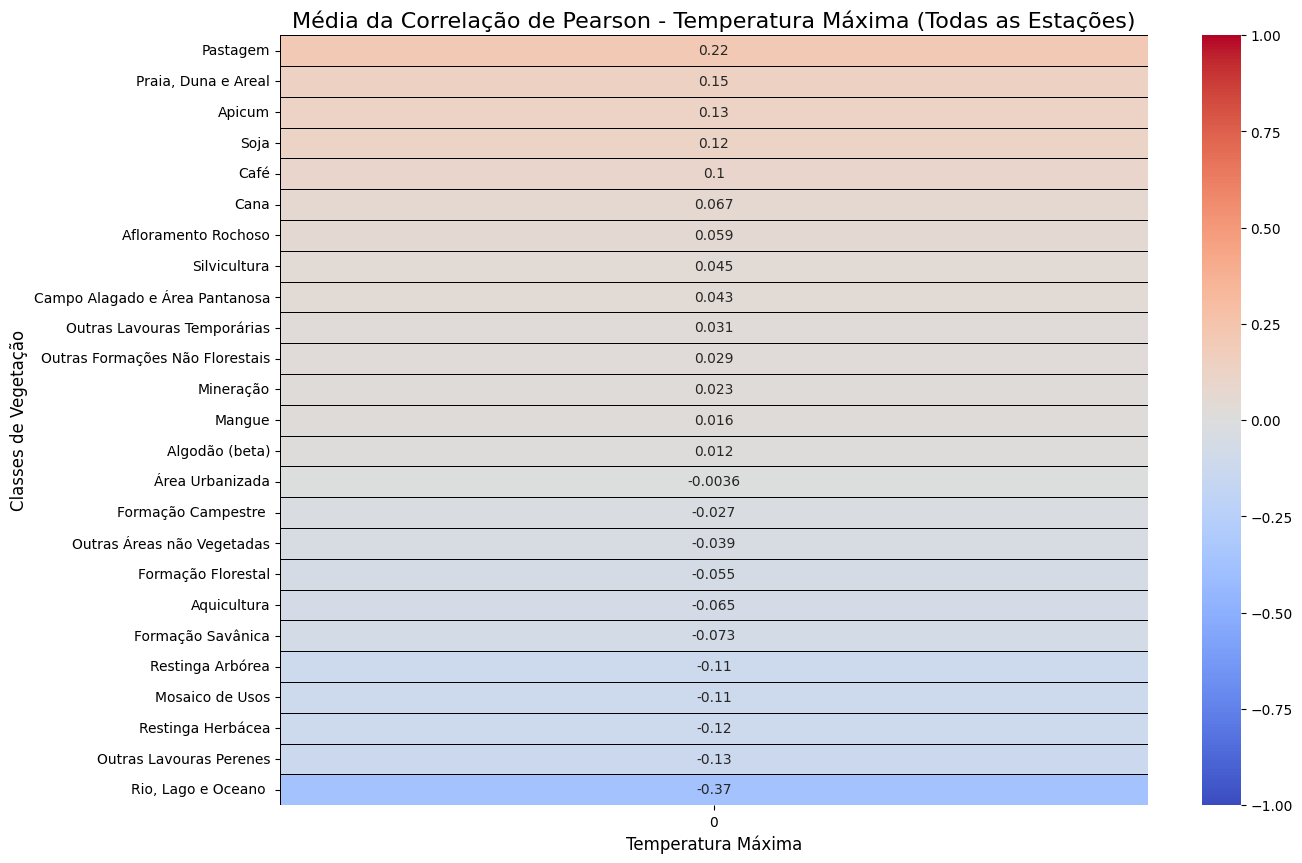

In [198]:
# Dicionário para armazenar as correlações de cada estação
correlacoes_por_estacao = {}

# Iterar por cada estação e calcular a correlação
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura máxima
    correlacao_temp_max = dados_para_correlacao.corr(method='pearson')['temperatura_max_median']
    
    # Remover a autocorrelação (correlação da temperatura máxima com ela mesma)
    correlacao_temp_max = correlacao_temp_max.drop(labels=['temperatura_max_median', 'temperatura_min_median'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao[estacao_id] = correlacao_temp_max

# Combinar todas as correlações e calcular a média
correlacoes_media = pd.DataFrame(correlacoes_por_estacao).mean(axis=1)

# Mapeando os nomes das classes no eixo y
correlacoes_media.index = correlacoes_media.index.map(id_to_class_name)

# Ordenar as correlações da maior para a menor
correlacoes_media = correlacoes_media.sort_values(ascending=False)

# Plotar a correlação de Pearson média para a temperatura máxima
plt.figure(figsize=(14, 10))
sns.heatmap(correlacoes_media.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black', cbar=True)
plt.title('Média da Correlação de Pearson - Temperatura Máxima (Todas as Estações)', fontsize=16)
plt.ylabel('Classes de Vegetação', fontsize=12)
plt.xlabel('Temperatura Máxima', fontsize=12)
plt.show()

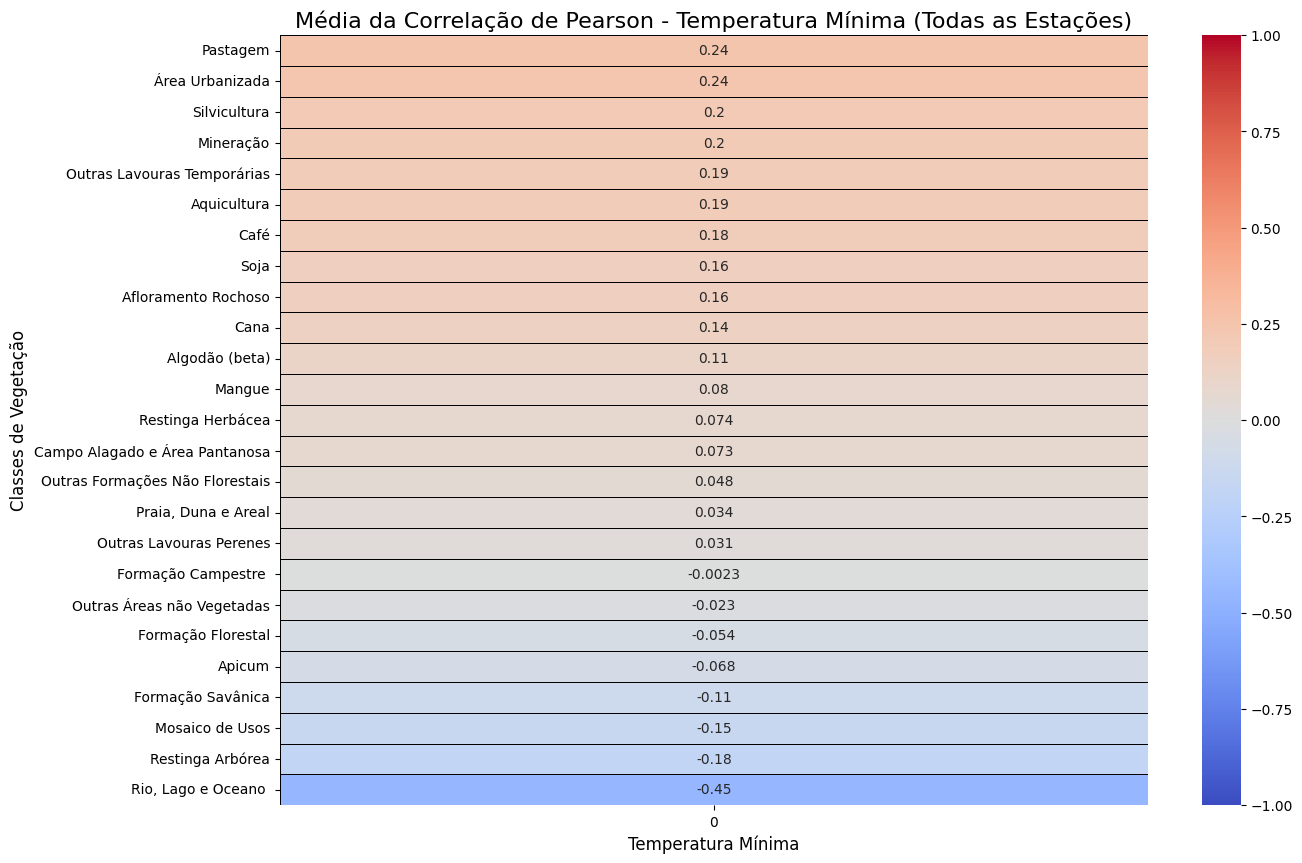

In [199]:
# Dicionário para armazenar as correlações de cada estação para temperatura mínima
correlacoes_por_estacao_min = {}

# Iterar por cada estação e calcular a correlação para a temperatura mínima
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura mínima
    correlacao_temp_min = dados_para_correlacao.corr(method='pearson')['temperatura_min_median']
    
    # Remover a autocorrelação (correlação da temperatura mínima com ela mesma)
    correlacao_temp_min = correlacao_temp_min.drop(labels=['temperatura_max_median', 'temperatura_min_median'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao_min[estacao_id] = correlacao_temp_min

# Combinar todas as correlações e calcular a média
correlacoes_media_min = pd.DataFrame(correlacoes_por_estacao_min).mean(axis=1)

# Mapeando os nomes das classes no eixo y
correlacoes_media_min.index = correlacoes_media_min.index.map(id_to_class_name)

# Ordenar as correlações da maior para a menor
correlacoes_media_min = correlacoes_media_min.sort_values(ascending=False)

# Plotar a correlação de Pearson média para a temperatura mínima
plt.figure(figsize=(14, 10))
sns.heatmap(correlacoes_media_min.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black', cbar=True)
plt.title('Média da Correlação de Pearson - Temperatura Mínima (Todas as Estações)', fontsize=16)
plt.ylabel('Classes de Vegetação', fontsize=12)
plt.xlabel('Temperatura Mínima', fontsize=12)
plt.show()

# Diferença entre temperatura da estação para temperatura do satélite

In [6]:
import cdsapi
from requests.exceptions import HTTPError
import xarray as xr
import time

In [ ]:
# Abrir o shapefile de estações
gdf_voronoi = gpd.read_file(('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp'))

In [8]:
# Calcular a média das temperaturas máxima e mínima para cada linha
combined_data['temperatura_media'] = (combined_data['temperatura_max'] + combined_data['temperatura_min']) / 2

# Agrupar por 'id_estacao' e 'ano' e calcular a média da temperatura_media
df_temperaturas_estacoes = combined_data.groupby(['id_estacao', 'ano']).agg({
    'temperatura_media': 'mean'
}).reset_index()

# Renomear a coluna para 'temperatura'
df_temperaturas_estacoes.rename(columns={'temperatura_media': 'temperatura'}, inplace=True)

# Exibir as primeiras linhas do DataFrame resultante
df_temperaturas_estacoes.head()

id_estacao   ano  temperatura
0       A305  2003    28.172999
1       A305  2004    27.995229
2       A305  2005    27.576356
3       A305  2006    29.718162
4       A305  2007    27.411836

In [11]:
def get_era5_temperature_by_year_range(lat, lon, start_year, end_year, output_dir='../dados/era5_temp'):
    """
    Função para obter as temperaturas médias anuais do ar a 2 metros de altura do ERA5 para uma latitude, 
    longitude e intervalo de anos específico.

    Parâmetros:
    - lat (float): Latitude do local.
    - lon (float): Longitude do local.
    - start_year (int): Ano inicial do intervalo.
    - end_year (int): Ano final do intervalo.
    - output_dir (str): Diretório para salvar os arquivos NetCDF.

    Retorna:
    - Lista de temperaturas médias anuais do ar em Celsius.
    """
    
    # Inicializar o cliente da API do CDS
    try:
        c = cdsapi.Client()
    except Exception as e:
        print(f"Erro ao inicializar o cliente CDS: {e}")
        return []
    
    # Garantir que o diretório de saída exista
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    temperaturas_anuais = []
    
    for year in range(start_year, end_year + 1):
        print(f"Baixando dados para o ano {year}...")
        
        try:
            # Definir parâmetros de download usando o dataset de médias mensais
            c.retrieve(
                'reanalysis-era5-single-levels-monthly-means',
                {
                    'product_type': 'monthly_averaged_reanalysis',
                    'variable': '2m_temperature',
                    'year': str(year),
                    'month': [f"{m:02d}" for m in range(1, 13)],
                    'time': '00:00',
                    'area': [
                        lat + 1.0, lon - 1.0,  # North, West
                        lat - 1.0, lon + 1.0   # South, East
                    ],
                    'format': 'netcdf',
                },
                f'{output_dir}/era5_temp_{year}.nc'
            )
            
            print(f"Dados para o ano {year} baixados com sucesso. Processando...")
            
            # Processar os dados NetCDF
            ds = xr.open_dataset(f'{output_dir}/era5_temp_{year}.nc')
            
            # Selecionar a temperatura a 2m no ponto específico
            temp = ds['t2m'].sel(
                latitude=lat,
                longitude=lon,
                method='nearest'
            )
            
            # Converter de Kelvin para Celsius
            temp_celsius = temp - 273.15
            
            # Calcular a média anual a partir das médias mensais
            temperatura_media = temp_celsius.mean(dim='date').item()
            
            temperaturas_anuais.append({'year': year, 'temperature': temperatura_media})
            
            # Fechar o dataset para liberar memória
            ds.close()
            print(f"Temperatura média para o ano {year}: {temperatura_media:.2f}°C")
            
        except HTTPError as http_err:
            print(f"HTTP error occurred ao baixar dados para o ano {year}: {http_err}")
            if http_err.response is not None:
                print(f"Conteúdo da resposta: {http_err.response.text}")
        except Exception as e:
            print(f"Erro ao baixar/processar dados para o ano {year}: {e}")
            continue
        
        # Pausa de 5 segundos para evitar sobrecarga na API
        time.sleep(5)
    
    return temperaturas_anuais

In [12]:
# Criar uma lista para armazenar os resultados
resultados = []

# Iterar sobre cada estação no GeoDataFrame
for idx, row in gdf_voronoi.iterrows():
    id_estacao = row['id_estacao']
    lat = row['latitude']
    lon = row['longitude']
    
    try:
        # Obter as temperaturas ERA5 para o intervalo de 2003 a 2022
        temperaturas_anuais = get_era5_temperature_by_year_range(lat, lon, 2003, 2022)
        
        # Adicionar os resultados ao dataframe
        for temp_data in temperaturas_anuais:
            resultados.append({
                'id_estacao': id_estacao,
                'year': temp_data['year'],
                'temperature': temp_data['temperature']  # Temperatura do Ar
            })
    
    except Exception as e:
        print(f"Erro ao obter dados para a estação {id_estacao}: {e}")
        continue

# Criar um DataFrame a partir da lista de resultados
df_temperaturas_reanalisada = pd.DataFrame(resultados)

Baixando dados para o ano 2003...


2024-09-19 15:48:26,314 INFO Request ID is 19f04dad-24ca-4a7f-9e1d-c995d08e57ec
2024-09-19 15:48:26,514 INFO status has been updated to accepted
2024-09-19 15:51:18,815 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 15:51:20,802 INFO Request ID is 4ea75e3d-9bc4-4089-97f3-ecd6163cecf4
2024-09-19 15:51:20,983 INFO status has been updated to accepted
2024-09-19 15:54:13,226 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.02°C
Baixando dados para o ano 2005...


2024-09-19 15:54:20,162 INFO Request ID is aa58a9b9-7a77-47b6-8565-e872fa7a2fd8
2024-09-19 15:54:20,338 INFO status has been updated to accepted
2024-09-19 15:57:12,495 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.89°C
Baixando dados para o ano 2006...


2024-09-19 15:57:19,626 INFO Request ID is 238b1d8f-150e-4bc1-b147-b039c42a2d43
2024-09-19 15:57:19,805 INFO status has been updated to accepted
2024-09-19 16:00:12,044 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.88°C
Baixando dados para o ano 2007...


2024-09-19 16:00:18,986 INFO Request ID is cac72b45-c4ce-46b9-b3cb-ce5981f9c9b3
2024-09-19 16:00:19,188 INFO status has been updated to accepted
2024-09-19 16:03:11,595 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.45°C
Baixando dados para o ano 2008...


2024-09-19 16:03:18,679 INFO Request ID is 4a45f69c-f712-4a22-8789-cf292508ecf5
2024-09-19 16:03:18,848 INFO status has been updated to accepted
2024-09-19 16:06:11,043 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.73°C
Baixando dados para o ano 2009...


2024-09-19 16:06:17,991 INFO Request ID is d55436c2-7d5a-4381-9c45-0acdb1f53e0d
2024-09-19 16:06:18,186 INFO status has been updated to accepted
2024-09-19 16:09:10,370 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.49°C
Baixando dados para o ano 2010...


2024-09-19 16:09:17,439 INFO Request ID is da7036b8-ccf9-4cb0-9499-299fe94be325
2024-09-19 16:09:17,620 INFO status has been updated to accepted
2024-09-19 16:12:09,910 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.25°C
Baixando dados para o ano 2011...


2024-09-19 16:12:16,825 INFO Request ID is 434feda9-5cbd-4f6a-8656-6f95d6f37219
2024-09-19 16:12:17,016 INFO status has been updated to accepted
2024-09-19 16:15:09,171 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.53°C
Baixando dados para o ano 2012...


2024-09-19 16:15:16,191 INFO Request ID is 7881f7ed-c67e-45dc-a7b8-65fb1a28f14a
2024-09-19 16:15:16,382 INFO status has been updated to accepted
2024-09-19 16:18:08,567 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.99°C
Baixando dados para o ano 2013...


2024-09-19 16:18:15,457 INFO Request ID is 2e79e2b2-4f4b-4152-a19f-cace75a4a54d
2024-09-19 16:18:15,648 INFO status has been updated to accepted
2024-09-19 16:21:07,806 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.96°C
Baixando dados para o ano 2014...


2024-09-19 16:21:14,824 INFO Request ID is 5b86e9cd-77c7-4f99-8169-cffee328c91d
2024-09-19 16:21:15,020 INFO status has been updated to accepted
2024-09-19 16:24:07,210 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.81°C
Baixando dados para o ano 2015...


2024-09-19 16:24:14,170 INFO Request ID is 82969e40-73b6-437c-b896-52886b049f2b
2024-09-19 16:24:14,360 INFO status has been updated to accepted
2024-09-19 16:27:06,646 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.54°C
Baixando dados para o ano 2016...


2024-09-19 16:27:13,726 INFO Request ID is 35d6262e-ec62-47aa-a478-086c683a3f76
2024-09-19 16:27:13,907 INFO status has been updated to accepted
2024-09-19 16:30:06,148 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.52°C
Baixando dados para o ano 2017...


2024-09-19 16:30:13,003 INFO Request ID is 5a3f0d8c-b29a-4c4a-86e5-262816f320b4
2024-09-19 16:30:13,183 INFO status has been updated to accepted
2024-09-19 16:33:05,396 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.89°C
Baixando dados para o ano 2018...


2024-09-19 16:33:12,449 INFO Request ID is c4d030cd-b2b6-47ff-b9eb-b4c4d2632faf
2024-09-19 16:33:12,631 INFO status has been updated to accepted
2024-09-19 16:36:04,885 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.58°C
Baixando dados para o ano 2019...


2024-09-19 16:36:12,076 INFO Request ID is 23167169-5bd1-4f8a-8f26-bc212e1b6c8c
2024-09-19 16:36:12,255 INFO status has been updated to accepted
2024-09-19 16:39:04,622 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.23°C
Baixando dados para o ano 2020...


2024-09-19 16:39:12,322 INFO Request ID is ccf85081-dd0d-470c-a5bd-82aa2f66e3f3
2024-09-19 16:39:12,492 INFO status has been updated to accepted
2024-09-19 16:42:04,688 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.56°C
Baixando dados para o ano 2021...


2024-09-19 16:42:11,559 INFO Request ID is 59cdd00c-a5bf-4c8c-9037-72ec04ed0fe1
2024-09-19 16:42:11,734 INFO status has been updated to accepted
2024-09-19 16:45:03,954 INFO status has been updated to running
2024-09-19 16:46:31,017 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.98°C
Baixando dados para o ano 2022...


2024-09-19 16:46:38,088 INFO Request ID is 1b99863c-0a66-4560-9ff5-fc7cb5ff3e12
2024-09-19 16:46:38,277 INFO status has been updated to accepted
2024-09-19 16:49:30,664 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.82°C
Baixando dados para o ano 2003...


2024-09-19 16:49:38,124 INFO Request ID is 24738c3a-4265-4e87-933a-921707c76c7c
2024-09-19 16:49:38,304 INFO status has been updated to accepted
2024-09-19 16:52:30,510 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 16:52:32,607 INFO Request ID is 660be3e5-a6a7-4eec-91a4-d1ae355e9c9a
2024-09-19 16:52:32,800 INFO status has been updated to accepted
2024-09-19 16:56:52,319 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.46°C
Baixando dados para o ano 2005...


2024-09-19 16:56:59,230 INFO Request ID is fb2211d5-2eaa-4c3e-a5a3-f5bafcec0267
2024-09-19 16:56:59,402 INFO status has been updated to accepted
2024-09-19 16:59:51,575 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.43°C
Baixando dados para o ano 2006...


2024-09-19 16:59:58,698 INFO Request ID is 2271afbb-a5db-48c1-a5aa-2beabd282b3b
2024-09-19 16:59:58,876 INFO status has been updated to accepted
2024-09-19 17:02:51,112 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.38°C
Baixando dados para o ano 2007...


2024-09-19 17:02:58,038 INFO Request ID is 8f63bc9a-7b75-460a-850c-13c5d282d3a4
2024-09-19 17:02:58,212 INFO status has been updated to accepted
2024-09-19 17:05:50,398 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.96°C
Baixando dados para o ano 2008...


2024-09-19 17:05:57,668 INFO Request ID is 4a49ae94-6a81-42da-a8fb-70c2b707dca6
2024-09-19 17:05:57,844 INFO status has been updated to accepted
2024-09-19 17:08:50,035 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.21°C
Baixando dados para o ano 2009...


2024-09-19 17:08:56,877 INFO Request ID is 69fa4ecd-4c53-4867-b5cb-cc212e01e120
2024-09-19 17:08:57,045 INFO status has been updated to accepted
2024-09-19 17:11:49,275 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.01°C
Baixando dados para o ano 2010...


2024-09-19 17:11:56,596 INFO Request ID is 320f796c-18d2-49a3-8ae5-dc359ac3e0a7
2024-09-19 17:11:56,771 INFO status has been updated to accepted
2024-09-19 17:16:16,036 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.64°C
Baixando dados para o ano 2011...


2024-09-19 17:16:22,974 INFO Request ID is 17d232b0-cdcd-4b2c-8708-763da86b3c5f
2024-09-19 17:16:23,151 INFO status has been updated to accepted
2024-09-19 17:19:15,367 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.10°C
Baixando dados para o ano 2012...


2024-09-19 17:19:22,437 INFO Request ID is e7dfcc58-b767-47b6-bd60-3f907db6dae2
2024-09-19 17:19:22,617 INFO status has been updated to accepted
2024-09-19 17:22:14,820 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.55°C
Baixando dados para o ano 2013...


2024-09-19 17:22:21,694 INFO Request ID is 923df4de-26a4-4e74-b1b3-af1322532186
2024-09-19 17:22:21,883 INFO status has been updated to accepted
2024-09-19 17:25:14,009 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.59°C
Baixando dados para o ano 2014...


2024-09-19 17:25:21,039 INFO Request ID is ab6fcdf2-1bc6-4fe2-9ceb-a76a219ba260
2024-09-19 17:25:21,210 INFO status has been updated to accepted
2024-09-19 17:28:13,446 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 28.38°C
Baixando dados para o ano 2015...


2024-09-19 17:28:20,281 INFO Request ID is bc29d3b5-e255-498f-abd6-71f36e0a8b62
2024-09-19 17:28:20,451 INFO status has been updated to accepted
2024-09-19 17:32:39,745 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 29.19°C
Baixando dados para o ano 2016...


2024-09-19 17:32:46,895 INFO Request ID is 870ee741-797b-40a2-9cb5-9c4505e02c0a
2024-09-19 17:32:47,070 INFO status has been updated to accepted
2024-09-19 17:35:39,223 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 29.01°C
Baixando dados para o ano 2017...


2024-09-19 17:35:46,068 INFO Request ID is 2898e76c-084b-40a8-9a7f-f3c6834ba895
2024-09-19 17:35:46,242 INFO status has been updated to accepted
2024-09-19 17:38:38,418 INFO status has been updated to running
2024-09-19 17:40:05,457 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.26°C
Baixando dados para o ano 2018...


2024-09-19 17:40:12,721 INFO Request ID is cc1f1e94-d98a-49ec-8699-8a149d0176dc
2024-09-19 17:40:12,914 INFO status has been updated to accepted
2024-09-19 17:43:05,267 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 28.00°C
Baixando dados para o ano 2019...


2024-09-19 17:43:12,115 INFO Request ID is ca257b3d-269b-44c1-9f0d-6ab92aecf3bb
2024-09-19 17:43:12,287 INFO status has been updated to accepted
2024-09-19 17:46:04,544 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.53°C
Baixando dados para o ano 2020...


2024-09-19 17:46:11,620 INFO Request ID is 731088fb-e379-481a-a72d-f99e334168f8
2024-09-19 17:46:11,794 INFO status has been updated to accepted
2024-09-19 17:49:03,990 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.96°C
Baixando dados para o ano 2021...


2024-09-19 17:49:10,854 INFO Request ID is c8da7ace-154c-4156-8aa5-2548a2bee7b4
2024-09-19 17:49:11,036 INFO status has been updated to accepted
2024-09-19 17:51:05,037 INFO status has been updated to running
2024-09-19 17:52:03,231 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.38°C
Baixando dados para o ano 2022...


2024-09-19 17:52:10,326 INFO Request ID is d1d59fa1-5485-40cc-9aed-f222252f6889
2024-09-19 17:52:10,496 INFO status has been updated to accepted
2024-09-19 17:55:02,653 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.10°C
Baixando dados para o ano 2003...


2024-09-19 17:55:10,304 INFO Request ID is 61c757e4-e105-4437-8140-33d04363e951
2024-09-19 17:55:10,473 INFO status has been updated to accepted
2024-09-19 17:58:02,639 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 17:58:04,619 INFO Request ID is d2305403-51fe-407c-ad61-ebaa40b22f53
2024-09-19 17:58:04,802 INFO status has been updated to accepted
2024-09-19 18:00:56,987 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.46°C
Baixando dados para o ano 2005...


2024-09-19 18:01:04,325 INFO Request ID is 97d3972a-78c9-4024-b214-0d3247a34e2e
2024-09-19 18:01:04,496 INFO status has been updated to accepted
2024-09-19 18:03:56,771 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.65°C
Baixando dados para o ano 2006...


2024-09-19 18:04:03,862 INFO Request ID is fea1199d-a0ec-4910-9930-53e9c06594fa
2024-09-19 18:04:04,058 INFO status has been updated to accepted
2024-09-19 18:05:58,062 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.37°C
Baixando dados para o ano 2007...


2024-09-19 18:06:04,992 INFO Request ID is 97e1c3a4-ef09-42bd-946b-c2b5c11103b4
2024-09-19 18:06:05,166 INFO status has been updated to accepted
2024-09-19 18:07:59,285 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.22°C
Baixando dados para o ano 2008...


2024-09-19 18:08:06,238 INFO Request ID is e953ade9-daf1-40c4-9f4b-6797f72cfd8f
2024-09-19 18:08:06,414 INFO status has been updated to accepted
2024-09-19 18:10:00,431 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.78°C
Baixando dados para o ano 2009...


2024-09-19 18:10:07,475 INFO Request ID is e692f815-7663-4f1f-8740-a96f92d86639
2024-09-19 18:10:07,653 INFO status has been updated to accepted
2024-09-19 18:12:01,660 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 24.86°C
Baixando dados para o ano 2010...


2024-09-19 18:12:08,513 INFO Request ID is ce873b53-4ab2-447b-9c9c-37ab8c617221
2024-09-19 18:12:08,691 INFO status has been updated to accepted
2024-09-19 18:14:02,685 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.19°C
Baixando dados para o ano 2011...


2024-09-19 18:14:09,573 INFO Request ID is b7566978-4a31-423f-ba78-3031addd7370
2024-09-19 18:14:09,745 INFO status has been updated to accepted
2024-09-19 18:16:03,827 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.31°C
Baixando dados para o ano 2012...


2024-09-19 18:16:10,857 INFO Request ID is 0cb6d2ce-bab7-423a-bc49-4daf84951536
2024-09-19 18:16:11,035 INFO status has been updated to accepted
2024-09-19 18:18:05,041 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.41°C
Baixando dados para o ano 2013...


2024-09-19 18:18:12,152 INFO Request ID is 74f9bfd0-1ea1-4e93-a2a7-1ca40bb6b40d
2024-09-19 18:18:12,338 INFO status has been updated to accepted
2024-09-19 18:20:06,316 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.50°C
Baixando dados para o ano 2014...


2024-09-19 18:20:13,180 INFO Request ID is 6b1be0f0-bfea-43f7-93d7-7db9c7934e65
2024-09-19 18:20:13,356 INFO status has been updated to accepted
2024-09-19 18:22:07,380 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.41°C
Baixando dados para o ano 2015...


2024-09-19 18:22:14,464 INFO Request ID is ef9a249a-b28c-4382-8940-3ede1a938f18
2024-09-19 18:22:14,644 INFO status has been updated to accepted
2024-09-19 18:23:30,075 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.29°C
Baixando dados para o ano 2016...


2024-09-19 18:23:37,023 INFO Request ID is 9316ed77-044a-4fb6-b89c-d7134bf7fa03
2024-09-19 18:23:37,203 INFO status has been updated to accepted
2024-09-19 18:24:52,656 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.22°C
Baixando dados para o ano 2017...


2024-09-19 18:24:59,716 INFO Request ID is d2aa8dcc-d330-4eab-af3f-e465b855d3e2
2024-09-19 18:24:59,894 INFO status has been updated to accepted
2024-09-19 18:26:15,345 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.55°C
Baixando dados para o ano 2018...


2024-09-19 18:26:22,244 INFO Request ID is ef4733fd-8e12-47ea-b7f9-ca8d3f230889
2024-09-19 18:26:22,417 INFO status has been updated to accepted
2024-09-19 18:28:16,493 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.45°C
Baixando dados para o ano 2019...


2024-09-19 18:28:23,728 INFO Request ID is 475982f7-98dc-4783-a201-bf963a956f83
2024-09-19 18:28:23,936 INFO status has been updated to accepted
2024-09-19 18:29:39,356 INFO status has been updated to running
2024-09-19 18:30:17,992 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.23°C
Baixando dados para o ano 2020...


2024-09-19 18:30:24,921 INFO Request ID is 099dd915-34d8-4910-9c18-1ff6f52a58df
2024-09-19 18:30:25,098 INFO status has been updated to accepted
2024-09-19 18:31:14,659 INFO status has been updated to running
2024-09-19 18:31:40,460 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.36°C
Baixando dados para o ano 2021...


2024-09-19 18:31:47,371 INFO Request ID is d2fdd0de-c5ec-44fa-844d-5142bc215cfb
2024-09-19 18:31:47,560 INFO status has been updated to accepted
2024-09-19 18:32:19,922 INFO status has been updated to running
2024-09-19 18:32:37,193 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.74°C
Baixando dados para o ano 2022...


2024-09-19 18:32:44,112 INFO Request ID is 69bb3577-3fcc-4d43-9812-ff3aac7b5f33
2024-09-19 18:32:44,311 INFO status has been updated to accepted
2024-09-19 18:33:16,604 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.41°C
Baixando dados para o ano 2003...


2024-09-19 18:33:24,074 INFO Request ID is 17fe3fe1-9cb1-47a5-85e2-fe6045990d60
2024-09-19 18:33:24,254 INFO status has been updated to accepted
2024-09-19 18:33:56,511 INFO status has been updated to running
2024-09-19 18:34:13,776 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 18:34:16,486 INFO Request ID is bdf8a5f2-eabc-493f-8d94-9dee5009a06f
2024-09-19 18:34:16,656 INFO status has been updated to accepted
2024-09-19 18:35:06,214 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 23.63°C
Baixando dados para o ano 2005...


2024-09-19 18:35:13,788 INFO Request ID is 6d1b7349-041e-4cf5-96ad-8d63e292beb6
2024-09-19 18:35:14,018 INFO status has been updated to accepted
2024-09-19 18:36:03,564 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.29°C
Baixando dados para o ano 2006...


2024-09-19 18:36:10,570 INFO Request ID is 7e845d00-efff-427d-97d5-479923d3fb76
2024-09-19 18:36:10,747 INFO status has been updated to accepted
2024-09-19 18:37:00,366 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 23.87°C
Baixando dados para o ano 2007...


2024-09-19 18:37:07,493 INFO Request ID is a2ee368c-bcc5-4e67-bd9a-a4511a19ccaf
2024-09-19 18:37:07,666 INFO status has been updated to accepted
2024-09-19 18:37:57,213 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.13°C
Baixando dados para o ano 2008...


2024-09-19 18:38:04,024 INFO Request ID is 48113615-78e3-4927-9bcb-c50a3be068e9
2024-09-19 18:38:04,198 INFO status has been updated to accepted
2024-09-19 18:38:53,758 INFO status has been updated to running
2024-09-19 18:39:19,567 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.41°C
Baixando dados para o ano 2009...


2024-09-19 18:39:26,497 INFO Request ID is 943bb951-2c85-428c-88b5-1a77e4b44f8f
2024-09-19 18:39:26,677 INFO status has been updated to accepted
2024-09-19 18:39:58,944 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.00°C
Baixando dados para o ano 2010...


2024-09-19 18:40:06,103 INFO Request ID is 82f2bdfd-f6b2-4278-982b-be044a2b3b94
2024-09-19 18:40:06,278 INFO status has been updated to accepted
2024-09-19 18:40:55,824 INFO status has been updated to running
2024-09-19 18:41:21,633 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.16°C
Baixando dados para o ano 2011...


2024-09-19 18:41:28,651 INFO Request ID is d5f924f8-26b8-43d4-b076-fd96191acfdc
2024-09-19 18:41:28,836 INFO status has been updated to accepted
2024-09-19 18:42:18,383 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.30°C
Baixando dados para o ano 2012...


2024-09-19 18:42:25,455 INFO Request ID is bc887e79-2680-42d6-93cb-ff9a36a142a8
2024-09-19 18:42:25,638 INFO status has been updated to accepted
2024-09-19 18:43:15,175 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 24.93°C
Baixando dados para o ano 2013...


2024-09-19 18:43:22,225 INFO Request ID is 82105d1b-3792-4265-b8f3-7b4843a734c4
2024-09-19 18:43:22,385 INFO status has been updated to accepted
2024-09-19 18:43:54,653 INFO status has been updated to running
2024-09-19 18:44:11,927 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.13°C
Baixando dados para o ano 2014...


2024-09-19 18:44:18,741 INFO Request ID is 49c7e89d-24c7-4695-89da-219274813e55
2024-09-19 18:44:18,931 INFO status has been updated to accepted
2024-09-19 18:44:51,200 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 24.61°C
Baixando dados para o ano 2015...


2024-09-19 18:44:58,492 INFO Request ID is 74a40ca8-9a91-4e32-bf3e-8ec54c55acf8
2024-09-19 18:44:58,668 INFO status has been updated to accepted
2024-09-19 18:45:19,356 INFO status has been updated to running
2024-09-19 18:45:30,944 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.46°C
Baixando dados para o ano 2016...


2024-09-19 18:45:38,021 INFO Request ID is 7c22ac4d-2f6d-4058-b36d-73f36e017e74
2024-09-19 18:45:38,219 INFO status has been updated to accepted
2024-09-19 18:46:10,541 INFO status has been updated to running
2024-09-19 18:46:27,812 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.12°C
Baixando dados para o ano 2017...


2024-09-19 18:46:34,702 INFO Request ID is f878612a-1651-4d6c-a25b-fc6061e8f0e3
2024-09-19 18:46:34,876 INFO status has been updated to accepted
2024-09-19 18:47:24,404 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.49°C
Baixando dados para o ano 2018...


2024-09-19 18:47:31,294 INFO Request ID is 3a62781c-8f4d-4d40-877f-a58c11c0c76c
2024-09-19 18:47:31,464 INFO status has been updated to accepted
2024-09-19 18:48:03,725 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 24.47°C
Baixando dados para o ano 2019...


2024-09-19 18:48:10,636 INFO Request ID is 6b07ffa9-c35b-4de3-baa0-abf0176473d3
2024-09-19 18:48:10,808 INFO status has been updated to accepted
2024-09-19 18:48:43,380 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.62°C
Baixando dados para o ano 2020...


2024-09-19 18:48:50,235 INFO Request ID is c76e52e5-024a-4fc4-a0cd-9dfb2eb31388
2024-09-19 18:48:50,407 INFO status has been updated to accepted
2024-09-19 18:49:22,673 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.30°C
Baixando dados para o ano 2021...


2024-09-19 18:49:29,599 INFO Request ID is c075e1c1-008b-4211-9972-dd4411be1f93
2024-09-19 18:49:29,772 INFO status has been updated to accepted
2024-09-19 18:50:02,101 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.58°C
Baixando dados para o ano 2022...


2024-09-19 18:50:09,172 INFO Request ID is 1755aaf0-a28a-4e03-b657-a45b72cdece3
2024-09-19 18:50:09,345 INFO status has been updated to accepted
2024-09-19 18:50:41,601 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.16°C
Baixando dados para o ano 2003...


2024-09-19 18:50:48,857 INFO Request ID is 4aff1321-59a6-40ad-a23c-058a0b7b6771
2024-09-19 18:50:49,023 INFO status has been updated to accepted
2024-09-19 18:51:21,293 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 18:51:23,158 INFO Request ID is d81c4017-a07e-4bc0-b20c-2e85ce5cf56d
2024-09-19 18:51:23,374 INFO status has been updated to accepted
2024-09-19 18:51:55,854 INFO status has been updated to running
2024-09-19 18:52:13,110 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.92°C
Baixando dados para o ano 2005...


2024-09-19 18:52:19,954 INFO Request ID is c2215d79-d98f-4826-85eb-1296cd028a01
2024-09-19 18:52:20,136 INFO status has been updated to accepted
2024-09-19 18:52:52,425 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.46°C
Baixando dados para o ano 2006...


2024-09-19 18:52:59,332 INFO Request ID is d9ce6cef-a49a-4211-947e-96732c05190c
2024-09-19 18:52:59,505 INFO status has been updated to accepted
2024-09-19 18:53:20,195 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 28.11°C
Baixando dados para o ano 2007...


2024-09-19 18:53:27,446 INFO Request ID is f1a3bd06-a8fb-4d3a-a7bc-0a38e07da6e0
2024-09-19 18:53:27,606 INFO status has been updated to accepted
2024-09-19 18:53:59,858 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 28.34°C
Baixando dados para o ano 2008...


2024-09-19 18:54:06,693 INFO Request ID is bba67d08-1173-473e-8029-9b855425f3f6
2024-09-19 18:54:06,868 INFO status has been updated to accepted
2024-09-19 18:54:56,403 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.94°C
Baixando dados para o ano 2009...


2024-09-19 18:55:03,320 INFO Request ID is 8bc924e9-9b8c-4e70-a357-e331d0f3e1f6
2024-09-19 18:55:03,513 INFO status has been updated to accepted
2024-09-19 18:55:53,185 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.71°C
Baixando dados para o ano 2010...


2024-09-19 18:56:00,082 INFO Request ID is a8fb4675-2988-469c-b8ef-24ef077e5714
2024-09-19 18:56:00,262 INFO status has been updated to accepted
2024-09-19 18:56:49,815 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.95°C
Baixando dados para o ano 2011...


2024-09-19 18:56:56,905 INFO Request ID is 3974f4fb-4371-492f-954e-55aee3018625
2024-09-19 18:56:57,088 INFO status has been updated to accepted
2024-09-19 18:57:46,625 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 28.00°C
Baixando dados para o ano 2012...


2024-09-19 18:57:53,486 INFO Request ID is 180af1c6-0e53-4c95-bcd4-ffaf6e809b9f
2024-09-19 18:57:53,667 INFO status has been updated to accepted
2024-09-19 18:58:43,219 INFO status has been updated to running
2024-09-19 18:59:09,029 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.81°C
Baixando dados para o ano 2013...


2024-09-19 18:59:15,959 INFO Request ID is 3b5e7a59-45f0-4645-8c5c-031711672f56
2024-09-19 18:59:16,138 INFO status has been updated to accepted
2024-09-19 19:00:05,774 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.82°C
Baixando dados para o ano 2014...


2024-09-19 19:00:12,651 INFO Request ID is 623fe504-57d5-4eb2-88a2-ac76474bdcd7
2024-09-19 19:00:12,821 INFO status has been updated to accepted
2024-09-19 19:01:02,496 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 28.33°C
Baixando dados para o ano 2015...


2024-09-19 19:01:09,383 INFO Request ID is ce0338d1-85e0-400a-b1c9-4127ccfcb817
2024-09-19 19:01:09,553 INFO status has been updated to accepted
2024-09-19 19:01:59,149 INFO status has been updated to running
2024-09-19 19:02:24,957 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.43°C
Baixando dados para o ano 2016...


2024-09-19 19:02:31,936 INFO Request ID is e711f35b-6db1-4004-a4b3-10b17bdbe910
2024-09-19 19:02:32,106 INFO status has been updated to accepted
2024-09-19 19:03:21,648 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.68°C
Baixando dados para o ano 2017...


2024-09-19 19:03:28,748 INFO Request ID is 0a845577-5515-4456-bc0a-229888bea851
2024-09-19 19:03:28,938 INFO status has been updated to accepted
2024-09-19 19:04:18,499 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.31°C
Baixando dados para o ano 2018...


2024-09-19 19:04:25,350 INFO Request ID is ded77b56-2816-4f18-bdcb-21f136077923
2024-09-19 19:04:25,520 INFO status has been updated to accepted
2024-09-19 19:05:15,261 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.90°C
Baixando dados para o ano 2019...


2024-09-19 19:05:22,237 INFO Request ID is 7933563e-0704-4055-8f60-4486f2539ec0
2024-09-19 19:05:22,405 INFO status has been updated to accepted
2024-09-19 19:06:11,924 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.10°C
Baixando dados para o ano 2020...


2024-09-19 19:06:18,734 INFO Request ID is b4047300-1376-48a3-9941-9303f624b7ca
2024-09-19 19:06:18,904 INFO status has been updated to accepted
2024-09-19 19:07:08,466 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 28.04°C
Baixando dados para o ano 2021...


2024-09-19 19:07:15,313 INFO Request ID is 7f7b5fa7-3f1e-4504-a971-1f09474b2a37
2024-09-19 19:07:15,476 INFO status has been updated to accepted
2024-09-19 19:07:47,730 INFO status has been updated to running
2024-09-19 19:08:04,998 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.08°C
Baixando dados para o ano 2022...


2024-09-19 19:08:11,854 INFO Request ID is 49408478-81d6-45cc-950b-62e7148a1809
2024-09-19 19:08:12,035 INFO status has been updated to accepted
2024-09-19 19:09:01,583 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.59°C
Baixando dados para o ano 2003...


2024-09-19 19:09:08,841 INFO Request ID is 5d343f4a-5565-4eb3-ad3d-ba14fee2343d
2024-09-19 19:09:09,013 INFO status has been updated to accepted
2024-09-19 19:10:24,374 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 19:10:26,219 INFO Request ID is 8cedafb7-85c6-4ab6-95de-da2462a006bf
2024-09-19 19:10:26,397 INFO status has been updated to accepted
2024-09-19 19:11:15,956 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.30°C
Baixando dados para o ano 2005...


2024-09-19 19:11:22,825 INFO Request ID is 20d5b400-10ff-426a-b920-75b1d2e06486
2024-09-19 19:11:23,005 INFO status has been updated to accepted
2024-09-19 19:12:12,608 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.04°C
Baixando dados para o ano 2006...


2024-09-19 19:12:19,485 INFO Request ID is 17ac0446-d41f-4c86-8a04-f18856faa291
2024-09-19 19:12:19,662 INFO status has been updated to accepted
2024-09-19 19:13:09,228 INFO status has been updated to running
2024-09-19 19:13:35,084 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.63°C
Baixando dados para o ano 2007...


2024-09-19 19:13:42,132 INFO Request ID is 22f339af-5672-49fd-bab6-53ae047ad1e7
2024-09-19 19:13:42,315 INFO status has been updated to accepted
2024-09-19 19:14:14,645 INFO status has been updated to running
2024-09-19 19:14:31,909 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.73°C
Baixando dados para o ano 2008...


2024-09-19 19:14:38,757 INFO Request ID is 04104ffc-d17d-44c2-be57-10b6d5db5f25
2024-09-19 19:14:38,950 INFO status has been updated to accepted
2024-09-19 19:15:11,201 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.33°C
Baixando dados para o ano 2009...


2024-09-19 19:15:18,068 INFO Request ID is 449adaf2-3109-4115-b166-512da64612a1
2024-09-19 19:15:18,379 INFO status has been updated to accepted
2024-09-19 19:15:39,090 INFO status has been updated to running
2024-09-19 19:15:50,682 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.02°C
Baixando dados para o ano 2010...


2024-09-19 19:15:57,548 INFO Request ID is 7bce2ad4-d8b8-413b-a7a0-48eb8d0bc4d6
2024-09-19 19:15:57,751 INFO status has been updated to accepted
2024-09-19 19:16:30,038 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.36°C
Baixando dados para o ano 2011...


2024-09-19 19:16:36,863 INFO Request ID is ccc5e734-c627-4c30-a1dd-7610efb4341e
2024-09-19 19:16:37,037 INFO status has been updated to accepted
2024-09-19 19:16:57,799 INFO status has been updated to running
2024-09-19 19:17:09,367 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.06°C
Baixando dados para o ano 2012...


2024-09-19 19:17:16,304 INFO Request ID is 99b64579-5a44-40f1-81f0-454921465aa7
2024-09-19 19:17:16,507 INFO status has been updated to accepted
2024-09-19 19:17:37,201 INFO status has been updated to running
2024-09-19 19:17:49,101 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.38°C
Baixando dados para o ano 2013...


2024-09-19 19:17:55,973 INFO Request ID is fda8176e-edbd-4240-b770-0d42882123f5
2024-09-19 19:17:56,152 INFO status has been updated to accepted
2024-09-19 19:18:16,856 INFO status has been updated to running
2024-09-19 19:18:28,422 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.31°C
Baixando dados para o ano 2014...


2024-09-19 19:18:35,254 INFO Request ID is d3b83e8d-4b25-44fc-a196-5f35b5fc5f4d
2024-09-19 19:18:35,427 INFO status has been updated to accepted
2024-09-19 19:19:07,706 INFO status has been updated to running
2024-09-19 19:19:24,977 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.78°C
Baixando dados para o ano 2015...


2024-09-19 19:19:31,820 INFO Request ID is 26a052ee-dc70-4e07-9ca3-8cbc9ec11811
2024-09-19 19:19:32,013 INFO status has been updated to accepted
2024-09-19 19:20:04,279 INFO status has been updated to running
2024-09-19 19:20:21,544 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.81°C
Baixando dados para o ano 2016...


2024-09-19 19:20:28,432 INFO Request ID is 343e11ff-2d69-44e6-bdc5-41ec9badb323
2024-09-19 19:20:28,615 INFO status has been updated to accepted
2024-09-19 19:21:18,292 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.01°C
Baixando dados para o ano 2017...


2024-09-19 19:21:25,161 INFO Request ID is 845d0d62-554e-468c-a4ac-5cd53b5852b4
2024-09-19 19:21:25,339 INFO status has been updated to accepted
2024-09-19 19:21:57,652 INFO status has been updated to running
2024-09-19 19:22:14,920 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.82°C
Baixando dados para o ano 2018...


2024-09-19 19:22:21,810 INFO Request ID is aef11ac4-475d-4916-b1ef-f7f3e17772b2
2024-09-19 19:22:21,987 INFO status has been updated to accepted
2024-09-19 19:23:11,539 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.32°C
Baixando dados para o ano 2019...


2024-09-19 19:23:18,410 INFO Request ID is 2ce4a90a-fa96-4c8a-8dd3-d56ccf718fc7
2024-09-19 19:23:18,608 INFO status has been updated to accepted
2024-09-19 19:24:08,149 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.50°C
Baixando dados para o ano 2020...


2024-09-19 19:24:15,070 INFO Request ID is 43eb2390-0a00-474f-ac4d-29e1010b3e99
2024-09-19 19:24:15,244 INFO status has been updated to accepted
2024-09-19 19:24:47,548 INFO status has been updated to running
2024-09-19 19:25:04,878 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.20°C
Baixando dados para o ano 2021...


2024-09-19 19:25:11,737 INFO Request ID is ddf111f9-2673-4ee5-9bff-a36ce6588442
2024-09-19 19:25:11,928 INFO status has been updated to accepted
2024-09-19 19:25:44,251 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.48°C
Baixando dados para o ano 2022...


2024-09-19 19:25:51,140 INFO Request ID is 5483e7c7-a656-4c98-b85f-b96483501c85
2024-09-19 19:25:51,315 INFO status has been updated to accepted
2024-09-19 19:26:23,581 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.93°C
Baixando dados para o ano 2003...


2024-09-19 19:26:31,018 INFO Request ID is 0e6f759e-ce00-42d5-b4e7-2d28d0b6f28a
2024-09-19 19:26:31,194 INFO status has been updated to accepted
2024-09-19 19:26:51,938 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 19:26:53,824 INFO Request ID is 91c25dc9-46e7-4966-a455-ff4f992743e6
2024-09-19 19:26:54,001 INFO status has been updated to accepted
2024-09-19 19:27:01,683 INFO status has been updated to running
2024-09-19 19:27:26,283 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.89°C
Baixando dados para o ano 2005...


2024-09-19 19:27:33,115 INFO Request ID is 5fe0bff8-f615-453e-a27d-3c9867670c7c
2024-09-19 19:27:33,291 INFO status has been updated to accepted
2024-09-19 19:28:05,601 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.48°C
Baixando dados para o ano 2006...


2024-09-19 19:28:12,490 INFO Request ID is bac9d98c-c9ac-408c-908f-deb36dc32ee5
2024-09-19 19:28:12,668 INFO status has been updated to accepted
2024-09-19 19:28:44,986 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.10°C
Baixando dados para o ano 2007...


2024-09-19 19:28:51,956 INFO Request ID is 8388af33-12cd-4294-87cf-8e4af59c64dc
2024-09-19 19:28:52,141 INFO status has been updated to accepted
2024-09-19 19:29:24,460 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.84°C
Baixando dados para o ano 2008...


2024-09-19 19:29:31,872 INFO Request ID is 4500f8ba-40cc-464a-9712-45434b29b1e0
2024-09-19 19:29:32,046 INFO status has been updated to accepted
2024-09-19 19:30:04,343 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.54°C
Baixando dados para o ano 2009...


2024-09-19 19:30:11,227 INFO Request ID is abc38003-567f-43e3-9451-1ab166384338
2024-09-19 19:30:11,403 INFO status has been updated to accepted
2024-09-19 19:30:43,694 INFO status has been updated to running
2024-09-19 19:31:00,972 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.77°C
Baixando dados para o ano 2010...


2024-09-19 19:31:07,888 INFO Request ID is a07aa3c6-5854-4cb1-963a-d2b9b952f444
2024-09-19 19:31:08,104 INFO status has been updated to accepted
2024-09-19 19:31:40,427 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.89°C
Baixando dados para o ano 2011...


2024-09-19 19:31:47,315 INFO Request ID is 53d27632-f4ff-4c4b-861e-5d6b064ea347
2024-09-19 19:31:47,495 INFO status has been updated to accepted
2024-09-19 19:32:08,191 INFO status has been updated to running
2024-09-19 19:32:19,765 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.15°C
Baixando dados para o ano 2012...


2024-09-19 19:32:26,658 INFO Request ID is 8abf4928-0174-4b2e-8ee5-fd2f50b267e6
2024-09-19 19:32:26,889 INFO status has been updated to accepted
2024-09-19 19:32:59,206 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.23°C
Baixando dados para o ano 2013...


2024-09-19 19:33:06,048 INFO Request ID is cf9c48c7-b257-46bb-bfd8-9db621eb14ef
2024-09-19 19:33:06,223 INFO status has been updated to accepted
2024-09-19 19:33:38,533 INFO status has been updated to running
2024-09-19 19:33:55,828 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.47°C
Baixando dados para o ano 2014...


2024-09-19 19:34:02,785 INFO Request ID is d943b7dd-5823-4420-aae2-52e2e70cd0cb
2024-09-19 19:34:02,964 INFO status has been updated to accepted
2024-09-19 19:34:35,277 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.66°C
Baixando dados para o ano 2015...


2024-09-19 19:34:42,166 INFO Request ID is e5c0c284-7b40-404b-ae94-731e094666cd
2024-09-19 19:34:42,348 INFO status has been updated to accepted
2024-09-19 19:35:14,650 INFO status has been updated to running
2024-09-19 19:35:31,923 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.60°C
Baixando dados para o ano 2016...


2024-09-19 19:35:39,042 INFO Request ID is 33c266f4-9690-4897-9d09-8f3f9e2a7a5d
2024-09-19 19:35:39,251 INFO status has been updated to accepted
2024-09-19 19:35:46,932 INFO status has been updated to running
2024-09-19 19:35:59,959 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.08°C
Baixando dados para o ano 2017...


2024-09-19 19:36:06,844 INFO Request ID is 5704f3cf-b0b7-491c-a011-7c7a1bbcb832
2024-09-19 19:36:07,025 INFO status has been updated to accepted
2024-09-19 19:36:14,715 INFO status has been updated to running
2024-09-19 19:36:19,963 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.50°C
Baixando dados para o ano 2018...


2024-09-19 19:36:26,827 INFO Request ID is 807bbe1a-620c-4645-919f-88ca71e90b1b
2024-09-19 19:36:27,004 INFO status has been updated to accepted
2024-09-19 19:36:39,942 INFO status has been updated to running
2024-09-19 19:36:47,724 INFO status has been updated to accepted
2024-09-19 19:36:59,294 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.22°C
Baixando dados para o ano 2019...


2024-09-19 19:37:06,216 INFO Request ID is 4864e6ae-bc52-4f5f-a102-a0c4cd1d34c0
2024-09-19 19:37:06,392 INFO status has been updated to accepted
2024-09-19 19:37:38,686 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.30°C
Baixando dados para o ano 2020...


2024-09-19 19:37:45,687 INFO Request ID is c6616633-4279-4072-8677-4d3ad45c23d6
2024-09-19 19:37:45,869 INFO status has been updated to accepted
2024-09-19 19:38:06,593 INFO status has been updated to running
2024-09-19 19:38:18,182 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.29°C
Baixando dados para o ano 2021...


2024-09-19 19:38:25,295 INFO Request ID is 65cd296e-ea7a-47c7-acb9-3482553993fe
2024-09-19 19:38:25,481 INFO status has been updated to accepted
2024-09-19 19:38:46,229 INFO status has been updated to running
2024-09-19 19:38:57,812 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.56°C
Baixando dados para o ano 2022...


2024-09-19 19:39:05,319 INFO Request ID is 44c644e0-9dbc-4251-86cd-bdb3d1eed27a
2024-09-19 19:39:05,498 INFO status has been updated to accepted
2024-09-19 19:39:37,816 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.11°C
Baixando dados para o ano 2003...


2024-09-19 19:39:45,089 INFO Request ID is d8c51302-fbbc-4be1-95e6-ace8b4d361b3
2024-09-19 19:39:45,268 INFO status has been updated to accepted
2024-09-19 19:40:17,615 INFO status has been updated to running
2024-09-19 19:40:34,889 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 19:40:36,766 INFO Request ID is b0111060-4c33-4826-9572-6b937317e493
2024-09-19 19:40:36,945 INFO status has been updated to accepted
2024-09-19 19:41:26,530 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 23.02°C
Baixando dados para o ano 2005...


2024-09-19 19:41:33,394 INFO Request ID is 93b5968f-88db-4cf9-88bc-ac3cdc70231a
2024-09-19 19:41:33,571 INFO status has been updated to accepted
2024-09-19 19:42:05,887 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 23.54°C
Baixando dados para o ano 2006...


2024-09-19 19:42:12,862 INFO Request ID is 6f27cfc3-83ba-4920-8842-9231ec708de9
2024-09-19 19:42:13,037 INFO status has been updated to accepted
2024-09-19 19:42:33,819 INFO status has been updated to running
2024-09-19 19:42:45,408 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 23.20°C
Baixando dados para o ano 2007...


2024-09-19 19:42:52,307 INFO Request ID is 879d168f-6f27-4a6c-8637-62fd12eef671
2024-09-19 19:42:52,486 INFO status has been updated to accepted
2024-09-19 19:43:13,222 INFO status has been updated to running
2024-09-19 19:43:24,798 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 23.67°C
Baixando dados para o ano 2008...


2024-09-19 19:43:31,782 INFO Request ID is 058a14d8-4d3d-4cc5-92c0-f89b4df9f79e
2024-09-19 19:43:31,968 INFO status has been updated to accepted
2024-09-19 19:43:44,912 INFO status has been updated to running
2024-09-19 19:43:52,704 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 23.63°C
Baixando dados para o ano 2009...


2024-09-19 19:43:59,570 INFO Request ID is b51cba02-cd87-4848-a8fc-1509e0e0c238
2024-09-19 19:43:59,745 INFO status has been updated to accepted
2024-09-19 19:44:20,522 INFO status has been updated to running
2024-09-19 19:44:32,095 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 24.07°C
Baixando dados para o ano 2010...


2024-09-19 19:44:38,948 INFO Request ID is 5f352e68-21a5-4c8c-9937-b3a3596c3666
2024-09-19 19:44:39,141 INFO status has been updated to accepted
2024-09-19 19:44:59,885 INFO status has been updated to running
2024-09-19 19:45:28,730 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.14°C
Baixando dados para o ano 2011...


2024-09-19 19:45:35,735 INFO Request ID is 61bd06d2-59bb-47c1-86fa-a54989e33578
2024-09-19 19:45:35,918 INFO status has been updated to accepted
2024-09-19 19:46:08,197 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 23.44°C
Baixando dados para o ano 2012...


2024-09-19 19:46:15,166 INFO Request ID is 31e328dc-e966-4e36-95f8-292726792f6a
2024-09-19 19:46:15,354 INFO status has been updated to accepted
2024-09-19 19:46:47,695 INFO status has been updated to running
2024-09-19 19:47:04,981 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 24.19°C
Baixando dados para o ano 2013...


2024-09-19 19:47:11,880 INFO Request ID is 3deaeb4e-eb95-4d50-8ad2-72593725807f
2024-09-19 19:47:12,054 INFO status has been updated to accepted
2024-09-19 19:47:44,356 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 24.38°C
Baixando dados para o ano 2014...


2024-09-19 19:47:51,238 INFO Request ID is 802aa6b2-5448-4f49-80ec-f885b12fb412
2024-09-19 19:47:51,419 INFO status has been updated to accepted
2024-09-19 19:48:41,034 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 24.42°C
Baixando dados para o ano 2015...


2024-09-19 19:48:48,134 INFO Request ID is 05e6df3d-5b4b-4282-abdf-747f0c2250f2
2024-09-19 19:48:48,322 INFO status has been updated to accepted
2024-09-19 19:49:09,343 INFO status has been updated to running
2024-09-19 19:49:20,923 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.36°C
Baixando dados para o ano 2016...


2024-09-19 19:49:27,888 INFO Request ID is cfcc8e3d-a176-47c0-9c32-ebe730e08c37
2024-09-19 19:49:28,067 INFO status has been updated to accepted
2024-09-19 19:49:48,781 INFO status has been updated to running
2024-09-19 19:50:00,360 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 24.88°C
Baixando dados para o ano 2017...


2024-09-19 19:50:08,325 INFO Request ID is 03a61f3e-bca6-46c3-9ee9-b9e309791e26
2024-09-19 19:50:08,505 INFO status has been updated to accepted
2024-09-19 19:50:29,211 INFO status has been updated to running
2024-09-19 19:50:40,796 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.17°C
Baixando dados para o ano 2018...


2024-09-19 19:50:47,711 INFO Request ID is 41596a42-186d-4fb2-83d1-0f316ebacc7f
2024-09-19 19:50:47,892 INFO status has been updated to accepted
2024-09-19 19:51:00,893 INFO status has been updated to running
2024-09-19 19:51:08,673 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 24.17°C
Baixando dados para o ano 2019...


2024-09-19 19:51:15,591 INFO Request ID is c3c91639-f5ea-4eb6-a1b7-c95c9a009fc1
2024-09-19 19:51:15,789 INFO status has been updated to accepted
2024-09-19 19:51:19,930 INFO status has been updated to running
2024-09-19 19:51:28,740 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.25°C
Baixando dados para o ano 2020...


2024-09-19 19:51:35,648 INFO Request ID is 365c923f-2a1d-48e5-9bb1-f9def723f017
2024-09-19 19:51:35,825 INFO status has been updated to accepted
2024-09-19 19:51:56,568 INFO status has been updated to running
2024-09-19 19:52:08,147 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 23.60°C
Baixando dados para o ano 2021...


2024-09-19 19:52:15,076 INFO Request ID is 692a61bd-bcb8-4ca5-869c-e868aa4d4a23
2024-09-19 19:52:15,278 INFO status has been updated to accepted
2024-09-19 19:52:47,575 INFO status has been updated to running
2024-09-19 19:53:04,853 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 23.75°C
Baixando dados para o ano 2022...


2024-09-19 19:53:11,799 INFO Request ID is 16d7e55c-fd4c-4b64-997d-9dd17f202fa8
2024-09-19 19:53:11,975 INFO status has been updated to accepted
2024-09-19 19:53:44,626 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 23.47°C
Baixando dados para o ano 2003...


2024-09-19 19:53:52,057 INFO Request ID is 7074837f-9fd0-4db1-b5d1-40479aabb821
2024-09-19 19:53:52,234 INFO status has been updated to accepted
2024-09-19 19:54:12,963 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 19:54:15,199 INFO Request ID is 6a754742-f0ab-440b-828a-81b958799493
2024-09-19 19:54:15,376 INFO status has been updated to accepted
2024-09-19 19:54:36,111 INFO status has been updated to running
2024-09-19 19:54:47,679 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.53°C
Baixando dados para o ano 2005...


2024-09-19 19:54:54,559 INFO Request ID is 076a3688-66f8-4663-a899-9ec0bf2a23fe
2024-09-19 19:54:54,738 INFO status has been updated to accepted
2024-09-19 19:55:27,018 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.94°C
Baixando dados para o ano 2006...


2024-09-19 19:55:33,923 INFO Request ID is f1ee39d8-b34f-4114-b242-35adbe247817
2024-09-19 19:55:34,097 INFO status has been updated to accepted
2024-09-19 19:56:06,355 INFO status has been updated to running
2024-09-19 19:56:23,633 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.64°C
Baixando dados para o ano 2007...


2024-09-19 19:56:30,511 INFO Request ID is 508bd877-c154-42c1-87f2-651a528d4ec1
2024-09-19 19:56:30,718 INFO status has been updated to accepted
2024-09-19 19:57:20,285 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.44°C
Baixando dados para o ano 2008...


2024-09-19 19:57:27,451 INFO Request ID is 005d0aeb-d6d3-4568-be17-7b454f3d5799
2024-09-19 19:57:27,659 INFO status has been updated to accepted
2024-09-19 19:57:40,901 INFO status has been updated to running
2024-09-19 19:57:48,676 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.04°C
Baixando dados para o ano 2009...


2024-09-19 19:57:55,513 INFO Request ID is ebef4622-d255-4693-b201-63d8e013034c
2024-09-19 19:57:55,693 INFO status has been updated to accepted
2024-09-19 19:58:16,483 INFO status has been updated to running
2024-09-19 19:58:28,070 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.20°C
Baixando dados para o ano 2010...


2024-09-19 19:58:35,004 INFO Request ID is 0dc93570-2da7-45d2-945a-50520228fb2e
2024-09-19 19:58:35,176 INFO status has been updated to accepted
2024-09-19 19:59:07,428 INFO status has been updated to running
2024-09-19 19:59:24,688 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.47°C
Baixando dados para o ano 2011...


2024-09-19 19:59:31,537 INFO Request ID is 771fb1a5-2f2d-4839-bd7c-e2747e406e50
2024-09-19 19:59:31,715 INFO status has been updated to accepted
2024-09-19 20:00:04,023 INFO status has been updated to running
2024-09-19 20:00:21,285 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.66°C
Baixando dados para o ano 2012...


2024-09-19 20:00:28,920 INFO Request ID is 473ff82c-2f75-48f0-8402-17902a5bff44
2024-09-19 20:00:29,103 INFO status has been updated to accepted
2024-09-19 20:01:19,041 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.73°C
Baixando dados para o ano 2013...


2024-09-19 20:01:25,967 INFO Request ID is 1c1e2a88-0dbc-45bd-936d-d9e2f31d15d0
2024-09-19 20:01:26,157 INFO status has been updated to accepted
2024-09-19 20:01:58,460 INFO status has been updated to running
2024-09-19 20:02:15,734 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.91°C
Baixando dados para o ano 2014...


2024-09-19 20:02:22,677 INFO Request ID is c4f6b555-000a-43e3-acc5-b2504866ecb6
2024-09-19 20:02:22,851 INFO status has been updated to accepted
2024-09-19 20:03:12,430 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.01°C
Baixando dados para o ano 2015...


2024-09-19 20:03:19,390 INFO Request ID is 16bcf209-faee-4f92-889b-fe8d664b0cf5
2024-09-19 20:03:19,596 INFO status has been updated to accepted
2024-09-19 20:03:32,521 INFO status has been updated to running
2024-09-19 20:03:40,297 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.92°C
Baixando dados para o ano 2016...


2024-09-19 20:03:47,541 INFO Request ID is cecf750b-c275-4fba-8cdd-ffeddfca2e66
2024-09-19 20:03:47,714 INFO status has been updated to accepted
2024-09-19 20:04:37,255 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.53°C
Baixando dados para o ano 2017...


2024-09-19 20:04:44,196 INFO Request ID is fe606ec5-a0ec-43fe-ab55-7d0fccedeca4
2024-09-19 20:04:44,369 INFO status has been updated to accepted
2024-09-19 20:05:16,626 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.12°C
Baixando dados para o ano 2018...


2024-09-19 20:05:23,523 INFO Request ID is 777e4533-97a6-4195-8902-89f9a9e4c660
2024-09-19 20:05:23,699 INFO status has been updated to accepted
2024-09-19 20:05:36,632 INFO status has been updated to running
2024-09-19 20:05:44,422 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.84°C
Baixando dados para o ano 2019...


2024-09-19 20:05:51,321 INFO Request ID is 5bea3793-b63f-4eab-9b1d-427bd7f81d8d
2024-09-19 20:05:51,516 INFO status has been updated to accepted
2024-09-19 20:06:23,813 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.77°C
Baixando dados para o ano 2020...


2024-09-19 20:06:30,638 INFO Request ID is 556c5756-97ed-4863-bca5-682237268d95
2024-09-19 20:06:30,816 INFO status has been updated to accepted
2024-09-19 20:06:51,557 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.76°C
Baixando dados para o ano 2021...


2024-09-19 20:06:58,455 INFO Request ID is 3cd6c15c-7e78-4f29-835e-49fe0650dfce
2024-09-19 20:06:58,639 INFO status has been updated to accepted
2024-09-19 20:07:11,561 INFO status has been updated to running
2024-09-19 20:07:30,921 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.17°C
Baixando dados para o ano 2022...


2024-09-19 20:07:37,759 INFO Request ID is 1c344136-fa03-43aa-be35-32444ce66833
2024-09-19 20:07:37,940 INFO status has been updated to accepted
2024-09-19 20:07:58,728 INFO status has been updated to running
2024-09-19 20:08:10,294 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.75°C
Baixando dados para o ano 2003...


2024-09-19 20:08:17,534 INFO Request ID is ca02ef64-ef8a-4780-b6c0-ab09afe54d8d
2024-09-19 20:08:17,715 INFO status has been updated to accepted
2024-09-19 20:08:38,427 INFO status has been updated to running
2024-09-19 20:08:50,010 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 20:08:51,894 INFO Request ID is e55fafc3-3850-488d-bec6-e2bc922a9819
2024-09-19 20:08:52,080 INFO status has been updated to accepted
2024-09-19 20:09:12,789 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.54°C
Baixando dados para o ano 2005...


2024-09-19 20:09:19,713 INFO Request ID is 22565fee-2e62-4d32-a47c-8f1573a5a777
2024-09-19 20:09:19,896 INFO status has been updated to accepted
2024-09-19 20:09:32,819 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.09°C
Baixando dados para o ano 2006...


2024-09-19 20:09:39,706 INFO Request ID is e6859004-39c4-4628-a16a-cb208f61e45f
2024-09-19 20:09:39,886 INFO status has been updated to accepted
2024-09-19 20:09:44,019 INFO status has been updated to running
2024-09-19 20:09:52,846 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.59°C
Baixando dados para o ano 2007...


2024-09-19 20:09:59,739 INFO Request ID is 4a7c2497-c4a2-49d4-8a2e-9319351acca6
2024-09-19 20:09:59,919 INFO status has been updated to accepted
2024-09-19 20:10:12,830 INFO status has been updated to running
2024-09-19 20:10:20,600 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.39°C
Baixando dados para o ano 2008...


2024-09-19 20:10:27,477 INFO Request ID is a70a409f-68fd-4041-bfb9-29c85584b858
2024-09-19 20:10:27,653 INFO status has been updated to accepted
2024-09-19 20:10:40,630 INFO status has been updated to running
2024-09-19 20:10:48,406 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.11°C
Baixando dados para o ano 2009...


2024-09-19 20:10:55,338 INFO Request ID is 0ce270d4-aacf-4050-96bc-d64f80a72b45
2024-09-19 20:10:55,894 INFO status has been updated to accepted
2024-09-19 20:11:00,025 INFO status has been updated to running
2024-09-19 20:11:03,597 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.25°C
Baixando dados para o ano 2010...


2024-09-19 20:11:10,489 INFO Request ID is 9dd8a6e2-2046-4b2a-a823-cd658d476a41
2024-09-19 20:11:10,669 INFO status has been updated to accepted
2024-09-19 20:11:18,384 INFO status has been updated to running
2024-09-19 20:11:23,639 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.33°C
Baixando dados para o ano 2011...


2024-09-19 20:11:30,505 INFO Request ID is ab4a0bfa-f9ed-49e5-b1b4-bdeee2510eb0
2024-09-19 20:11:30,682 INFO status has been updated to accepted
2024-09-19 20:11:43,634 INFO status has been updated to running
2024-09-19 20:11:51,418 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.61°C
Baixando dados para o ano 2012...


2024-09-19 20:11:58,343 INFO Request ID is 59e40bd3-2262-45bf-9cb8-c9d6b8edfcda
2024-09-19 20:11:58,523 INFO status has been updated to accepted
2024-09-19 20:12:11,460 INFO status has been updated to running
2024-09-19 20:12:19,242 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.68°C
Baixando dados para o ano 2013...


2024-09-19 20:12:26,138 INFO Request ID is e4353a9e-3340-46df-b73b-2d5e882b0b9b
2024-09-19 20:12:26,329 INFO status has been updated to accepted
2024-09-19 20:12:39,274 INFO status has been updated to running
2024-09-19 20:12:47,046 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.91°C
Baixando dados para o ano 2014...


2024-09-19 20:12:54,115 INFO Request ID is ee8af284-de9b-4bab-8a98-104eff787821
2024-09-19 20:12:54,294 INFO status has been updated to accepted
2024-09-19 20:13:14,999 INFO status has been updated to running
2024-09-19 20:13:26,575 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.18°C
Baixando dados para o ano 2015...


2024-09-19 20:13:33,620 INFO Request ID is c2393638-1b1b-400a-9722-2a8c47923859
2024-09-19 20:13:33,806 INFO status has been updated to accepted
2024-09-19 20:13:41,511 INFO status has been updated to running
2024-09-19 20:13:46,762 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.18°C
Baixando dados para o ano 2016...


2024-09-19 20:13:53,595 INFO Request ID is 26a25638-535b-45dd-963d-3333acf94c27
2024-09-19 20:13:53,776 INFO status has been updated to accepted
2024-09-19 20:14:01,458 INFO status has been updated to running
2024-09-19 20:14:06,711 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.53°C
Baixando dados para o ano 2017...


2024-09-19 20:14:14,105 INFO Request ID is 22d0f376-1397-41c0-9f07-29495c0e6cde
2024-09-19 20:14:14,280 INFO status has been updated to accepted
2024-09-19 20:14:34,972 INFO status has been updated to running
2024-09-19 20:14:46,560 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.05°C
Baixando dados para o ano 2018...


2024-09-19 20:14:53,883 INFO Request ID is 57fec7e3-9735-465e-9f23-e54e063e6bb9
2024-09-19 20:14:54,057 INFO status has been updated to accepted
2024-09-19 20:15:07,061 INFO status has been updated to running
2024-09-19 20:15:14,848 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.80°C
Baixando dados para o ano 2019...


2024-09-19 20:15:21,736 INFO Request ID is c8ac4d8c-55d4-4f03-ac0c-f0f1a65d3f3e
2024-09-19 20:15:21,913 INFO status has been updated to accepted
2024-09-19 20:15:42,649 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.81°C
Baixando dados para o ano 2020...


2024-09-19 20:15:49,612 INFO Request ID is 83d21317-19bd-409b-9564-267973174852
2024-09-19 20:15:49,802 INFO status has been updated to accepted
2024-09-19 20:16:02,749 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.81°C
Baixando dados para o ano 2021...


2024-09-19 20:16:09,701 INFO Request ID is 51a8e24f-db43-4ded-ab5b-64ccb633568d
2024-09-19 20:16:09,927 INFO status has been updated to accepted
2024-09-19 20:16:11,611 INFO status has been updated to running
2024-09-19 20:16:17,616 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.02°C
Baixando dados para o ano 2022...


2024-09-19 20:16:24,785 INFO Request ID is 46687bbb-e970-47ad-86cb-848c4f0cab68
2024-09-19 20:16:24,965 INFO status has been updated to accepted
2024-09-19 20:16:26,650 INFO status has been updated to running
2024-09-19 20:16:32,643 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.67°C
Baixando dados para o ano 2003...


2024-09-19 20:16:39,982 INFO Request ID is 83ffca97-5b37-40c3-8019-7b6bad37cfc3
2024-09-19 20:16:40,161 INFO status has been updated to accepted
2024-09-19 20:17:00,906 INFO status has been updated to running
2024-09-19 20:17:12,486 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 20:17:14,557 INFO Request ID is f23a12e2-6b34-431b-8070-c73b32b09e9a
2024-09-19 20:17:14,739 INFO status has been updated to accepted
2024-09-19 20:17:47,410 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.29°C
Baixando dados para o ano 2005...


2024-09-19 20:17:54,370 INFO Request ID is 5937bf28-c564-49ae-a698-013b0e1ba3cf
2024-09-19 20:17:54,558 INFO status has been updated to accepted
2024-09-19 20:18:07,484 INFO status has been updated to running
2024-09-19 20:18:26,844 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.96°C
Baixando dados para o ano 2006...


2024-09-19 20:18:34,001 INFO Request ID is 32bcb481-d6a2-4edb-b2d0-a1b3d3bcfab2
2024-09-19 20:18:34,178 INFO status has been updated to accepted
2024-09-19 20:18:47,129 INFO status has been updated to running
2024-09-19 20:18:54,905 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.50°C
Baixando dados para o ano 2007...


2024-09-19 20:19:01,778 INFO Request ID is 205d0834-2625-4fd3-942f-28ab5fc44fea
2024-09-19 20:19:01,960 INFO status has been updated to accepted
2024-09-19 20:19:22,685 INFO status has been updated to running
2024-09-19 20:19:34,283 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.18°C
Baixando dados para o ano 2008...


2024-09-19 20:19:41,247 INFO Request ID is 3bda9758-0cea-4bdc-9a77-93d18fd7b9af
2024-09-19 20:19:41,425 INFO status has been updated to accepted
2024-09-19 20:20:02,135 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.08°C
Baixando dados para o ano 2009...


2024-09-19 20:20:09,045 INFO Request ID is 75518e2f-9dd0-4487-a3d3-c5f650824d87
2024-09-19 20:20:09,222 INFO status has been updated to accepted
2024-09-19 20:20:29,933 INFO status has been updated to running
2024-09-19 20:20:41,499 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.31°C
Baixando dados para o ano 2010...


2024-09-19 20:20:48,374 INFO Request ID is 9c58c6e5-841f-4f01-b943-75ed0c60c73f
2024-09-19 20:20:48,550 INFO status has been updated to accepted
2024-09-19 20:21:09,256 INFO status has been updated to running
2024-09-19 20:21:20,826 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.26°C
Baixando dados para o ano 2011...


2024-09-19 20:21:27,698 INFO Request ID is 52f21cab-446f-43ba-b4ed-365b61efa98e
2024-09-19 20:21:27,880 INFO status has been updated to accepted
2024-09-19 20:21:40,844 INFO status has been updated to running
2024-09-19 20:21:48,627 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.50°C
Baixando dados para o ano 2012...


2024-09-19 20:21:55,936 INFO Request ID is 71b0ff26-6be7-4033-8d28-7abcce7f9c13
2024-09-19 20:21:56,124 INFO status has been updated to accepted
2024-09-19 20:22:00,250 INFO status has been updated to running
2024-09-19 20:22:09,094 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.52°C
Baixando dados para o ano 2013...


2024-09-19 20:22:16,435 INFO Request ID is 1f6c0619-de73-44ae-b3a6-c54eb717b5a3
2024-09-19 20:22:16,656 INFO status has been updated to accepted
2024-09-19 20:22:29,595 INFO status has been updated to running
2024-09-19 20:22:37,372 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.76°C
Baixando dados para o ano 2014...


2024-09-19 20:22:44,628 INFO Request ID is 42bd75a9-af82-4ca3-b075-9339fe7806c2
2024-09-19 20:22:44,808 INFO status has been updated to accepted
2024-09-19 20:22:48,928 INFO status has been updated to running
2024-09-19 20:22:57,726 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.00°C
Baixando dados para o ano 2015...


2024-09-19 20:23:04,591 INFO Request ID is 87b47704-f962-4d05-81f9-a5d153f17030
2024-09-19 20:23:04,786 INFO status has been updated to accepted
2024-09-19 20:23:12,474 INFO status has been updated to running
2024-09-19 20:23:25,490 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.08°C
Baixando dados para o ano 2016...


2024-09-19 20:23:32,376 INFO Request ID is 351f2577-5b94-4cde-b33d-8b73c49abd7b
2024-09-19 20:23:32,578 INFO status has been updated to accepted
2024-09-19 20:23:45,557 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.27°C
Baixando dados para o ano 2017...


2024-09-19 20:23:52,433 INFO Request ID is 83eb8cdb-b827-4fbf-b8d1-bfebe792b98f
2024-09-19 20:23:52,626 INFO status has been updated to accepted
2024-09-19 20:23:56,754 INFO status has been updated to running
2024-09-19 20:24:05,551 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.62°C
Baixando dados para o ano 2018...


2024-09-19 20:24:12,429 INFO Request ID is d5244085-b375-409c-b974-e56b3471eb1d
2024-09-19 20:24:12,617 INFO status has been updated to accepted
2024-09-19 20:24:25,631 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.55°C
Baixando dados para o ano 2019...


2024-09-19 20:24:32,512 INFO Request ID is 3a0b566a-91dc-4d73-a3fe-5e5b757a53c6
2024-09-19 20:24:32,691 INFO status has been updated to accepted
2024-09-19 20:24:36,825 INFO status has been updated to running
2024-09-19 20:24:45,628 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.76°C
Baixando dados para o ano 2020...


2024-09-19 20:24:52,511 INFO Request ID is e5e1ea7e-9126-43d9-a2f7-d0312555a03f
2024-09-19 20:24:52,685 INFO status has been updated to accepted
2024-09-19 20:24:56,968 INFO status has been updated to running
2024-09-19 20:25:05,775 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.91°C
Baixando dados para o ano 2021...


2024-09-19 20:25:12,722 INFO Request ID is 18cbb026-59f8-4818-b3b0-3771bcd8ffd3
2024-09-19 20:25:12,903 INFO status has been updated to accepted
2024-09-19 20:25:20,592 INFO status has been updated to running
2024-09-19 20:25:25,843 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.98°C
Baixando dados para o ano 2022...


2024-09-19 20:25:32,684 INFO Request ID is d966ca76-3b14-4ce0-9d09-b4b8559b8532
2024-09-19 20:25:32,866 INFO status has been updated to accepted
2024-09-19 20:25:34,557 INFO status has been updated to running
2024-09-19 20:25:45,803 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.58°C
Baixando dados para o ano 2003...


2024-09-19 20:25:53,039 INFO Request ID is 7243fe31-f475-45da-9d55-04dd5594e529
2024-09-19 20:25:53,207 INFO status has been updated to accepted
2024-09-19 20:25:54,890 INFO status has been updated to running
2024-09-19 20:26:00,883 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 20:26:02,753 INFO Request ID is fc60af38-fa63-4fff-b3c3-7651e2a79c16
2024-09-19 20:26:02,929 INFO status has been updated to accepted
2024-09-19 20:26:07,044 INFO status has been updated to running
2024-09-19 20:26:15,854 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.27°C
Baixando dados para o ano 2005...


2024-09-19 20:26:22,772 INFO Request ID is 91c615e8-e89c-4b30-8ea5-a943775fe74a
2024-09-19 20:26:22,944 INFO status has been updated to accepted
2024-09-19 20:26:24,644 INFO status has been updated to running
2024-09-19 20:26:30,641 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.54°C
Baixando dados para o ano 2006...


2024-09-19 20:26:37,552 INFO Request ID is 025aba7c-484e-40f4-8314-1518cf9d4c0c
2024-09-19 20:26:37,734 INFO status has been updated to accepted
2024-09-19 20:26:41,843 INFO status has been updated to running
2024-09-19 20:26:50,659 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.39°C
Baixando dados para o ano 2007...


2024-09-19 20:26:57,573 INFO Request ID is a0ed2606-0fa5-4809-85e2-51508a400831
2024-09-19 20:26:58,411 INFO status has been updated to accepted
2024-09-19 20:27:11,324 INFO status has been updated to running
2024-09-19 20:27:19,100 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.74°C
Baixando dados para o ano 2008...


2024-09-19 20:27:25,982 INFO Request ID is c45e17f8-ab07-4eab-ba29-d3ab7a764e5a
2024-09-19 20:27:26,184 INFO status has been updated to accepted
2024-09-19 20:27:33,858 INFO status has been updated to running
2024-09-19 20:27:39,096 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.83°C
Baixando dados para o ano 2009...


2024-09-19 20:27:45,956 INFO Request ID is 3ae2a26f-bd7d-4b3a-a9b8-79b64802e1e7
2024-09-19 20:27:46,134 INFO status has been updated to accepted
2024-09-19 20:27:50,286 INFO status has been updated to running
2024-09-19 20:27:59,096 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.16°C
Baixando dados para o ano 2010...


2024-09-19 20:28:06,058 INFO Request ID is 25e8a339-7a8e-4ea6-9a29-a97ed0ff160e
2024-09-19 20:28:06,227 INFO status has been updated to accepted
2024-09-19 20:28:10,335 INFO status has been updated to running
2024-09-19 20:28:19,139 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.23°C
Baixando dados para o ano 2011...


2024-09-19 20:28:25,963 INFO Request ID is 6b34f368-9009-4688-99d7-fb8d6eaf259d
2024-09-19 20:28:26,133 INFO status has been updated to accepted
2024-09-19 20:28:39,093 INFO status has been updated to running
2024-09-19 20:28:46,854 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.55°C
Baixando dados para o ano 2012...


2024-09-19 20:28:53,741 INFO Request ID is 9f73365b-95f5-467e-a83b-6f6f426eb809
2024-09-19 20:28:53,927 INFO status has been updated to accepted
2024-09-19 20:28:58,039 INFO status has been updated to running
2024-09-19 20:29:01,591 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.35°C
Baixando dados para o ano 2013...


2024-09-19 20:29:08,603 INFO Request ID is 38a8b49a-e977-4f97-aaaf-d9bce3dda10f
2024-09-19 20:29:08,790 INFO status has been updated to accepted
2024-09-19 20:29:16,477 INFO status has been updated to running
2024-09-19 20:29:29,545 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.62°C
Baixando dados para o ano 2014...


2024-09-19 20:29:36,535 INFO Request ID is 4c872bbf-b2bb-483f-bcfb-9daa15525f7c
2024-09-19 20:29:36,706 INFO status has been updated to accepted
2024-09-19 20:29:38,384 INFO status has been updated to running
2024-09-19 20:29:44,362 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.05°C
Baixando dados para o ano 2015...


2024-09-19 20:29:51,201 INFO Request ID is 988d71c5-24dd-4696-811b-bbc4fba9305e
2024-09-19 20:29:51,371 INFO status has been updated to accepted
2024-09-19 20:29:55,689 INFO status has been updated to running
2024-09-19 20:30:04,481 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.97°C
Baixando dados para o ano 2016...


2024-09-19 20:30:11,352 INFO Request ID is 0a3bb697-7a20-41d4-989e-45137d0e80b4
2024-09-19 20:30:11,532 INFO status has been updated to accepted
2024-09-19 20:30:13,211 INFO status has been updated to running
2024-09-19 20:30:19,199 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.62°C
Baixando dados para o ano 2017...


2024-09-19 20:30:27,042 INFO Request ID is 3b9faa32-4ab1-4362-89e3-039b7841cfa7
2024-09-19 20:30:27,214 INFO status has been updated to accepted
2024-09-19 20:30:34,884 INFO status has been updated to running
2024-09-19 20:30:40,121 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.28°C
Baixando dados para o ano 2018...


2024-09-19 20:30:46,999 INFO Request ID is fce74389-4487-4c42-a7a0-e411bcf22ed7
2024-09-19 20:30:47,173 INFO status has been updated to accepted
2024-09-19 20:31:00,099 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.20°C
Baixando dados para o ano 2019...


2024-09-19 20:31:06,998 INFO Request ID is d36cb211-ccef-47a9-be8e-dd0b8a8baac7
2024-09-19 20:31:07,172 INFO status has been updated to accepted
2024-09-19 20:31:11,288 INFO status has been updated to running
2024-09-19 20:31:14,855 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.05°C
Baixando dados para o ano 2020...


2024-09-19 20:31:21,800 INFO Request ID is 47a32c7f-e601-49fd-ab29-203a41843616
2024-09-19 20:31:21,974 INFO status has been updated to accepted
2024-09-19 20:31:23,649 INFO status has been updated to running
2024-09-19 20:31:29,628 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.60°C
Baixando dados para o ano 2021...


2024-09-19 20:31:36,538 INFO Request ID is ec238da8-fe2b-4d52-a72d-77ba9a9a6ba7
2024-09-19 20:31:36,710 INFO status has been updated to accepted
2024-09-19 20:31:38,386 INFO status has been updated to running
2024-09-19 20:31:49,666 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.81°C
Baixando dados para o ano 2022...


2024-09-19 20:31:56,528 INFO Request ID is e423cbf3-f428-42cd-9064-70d206ef000c
2024-09-19 20:31:56,716 INFO status has been updated to accepted
2024-09-19 20:31:58,395 INFO status has been updated to running
2024-09-19 20:32:04,380 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.56°C
Baixando dados para o ano 2003...


2024-09-19 20:32:11,569 INFO Request ID is 6671fdc6-e9ef-466b-a715-6ad2d5f1345d
2024-09-19 20:32:11,748 INFO status has been updated to accepted
2024-09-19 20:32:15,874 INFO status has been updated to running
2024-09-19 20:32:19,431 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 20:32:21,252 INFO Request ID is c8d51e7d-8890-4fc5-8fc7-6c23b74f86cd
2024-09-19 20:32:21,426 INFO status has been updated to accepted
2024-09-19 20:32:23,104 INFO status has been updated to running
2024-09-19 20:32:29,089 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.37°C
Baixando dados para o ano 2005...


2024-09-19 20:32:35,937 INFO Request ID is 330501d4-c035-4a0a-84bc-12dbd0e8553d
2024-09-19 20:32:36,122 INFO status has been updated to accepted
2024-09-19 20:32:37,799 INFO status has been updated to running
2024-09-19 20:32:43,794 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.54°C
Baixando dados para o ano 2006...


2024-09-19 20:32:50,845 INFO Request ID is 10b7f0d0-d66f-4ff7-bdeb-881e5b59b2ac
2024-09-19 20:32:51,016 INFO status has been updated to accepted
2024-09-19 20:32:58,673 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.38°C
Baixando dados para o ano 2007...


2024-09-19 20:33:05,663 INFO Request ID is 71447735-a5d8-4842-95b2-d5f91d49b1e1
2024-09-19 20:33:05,833 INFO status has been updated to accepted
2024-09-19 20:33:13,488 INFO status has been updated to running
2024-09-19 20:33:18,744 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.05°C
Baixando dados para o ano 2008...


2024-09-19 20:33:26,791 INFO Request ID is e60d3bfb-0d22-4e68-bcbd-418f45663a4f
2024-09-19 20:33:26,964 INFO status has been updated to accepted
2024-09-19 20:33:28,681 INFO status has been updated to running
2024-09-19 20:33:39,922 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.78°C
Baixando dados para o ano 2009...


2024-09-19 20:33:46,849 INFO Request ID is 15e361b8-dee3-42ca-8e8c-d0bbbdaaf00f
2024-09-19 20:33:47,023 INFO status has been updated to accepted
2024-09-19 20:33:48,707 INFO status has been updated to running
2024-09-19 20:33:59,946 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.99°C
Baixando dados para o ano 2010...


2024-09-19 20:34:07,177 INFO Request ID is 2836604e-110a-4862-8ec8-99cdf2e94eaf
2024-09-19 20:34:07,347 INFO status has been updated to accepted
2024-09-19 20:34:09,025 INFO status has been updated to running
2024-09-19 20:34:20,249 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.31°C
Baixando dados para o ano 2011...


2024-09-19 20:34:27,259 INFO Request ID is a837d2c7-a6be-4b6a-b249-9351fac77b1a
2024-09-19 20:34:27,430 INFO status has been updated to accepted
2024-09-19 20:34:29,107 INFO status has been updated to running
2024-09-19 20:34:48,111 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.47°C
Baixando dados para o ano 2012...


2024-09-19 20:34:54,986 INFO Request ID is 54a4f743-ebaa-43d8-bc19-31ebb08e8d65
2024-09-19 20:34:55,157 INFO status has been updated to accepted
2024-09-19 20:34:56,843 INFO status has been updated to running
2024-09-19 20:35:02,831 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.57°C
Baixando dados para o ano 2013...


2024-09-19 20:35:09,713 INFO Request ID is 2791e083-efab-4f5f-add3-0aba7aba64b0
2024-09-19 20:35:09,899 INFO status has been updated to accepted
2024-09-19 20:35:17,560 INFO status has been updated to running
2024-09-19 20:35:22,824 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.81°C
Baixando dados para o ano 2014...


2024-09-19 20:35:29,663 INFO Request ID is e45b0d34-2e3f-4573-aa3b-946bd620283b
2024-09-19 20:35:29,833 INFO status has been updated to accepted
2024-09-19 20:35:31,515 INFO status has been updated to running
2024-09-19 20:35:37,507 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.46°C
Baixando dados para o ano 2015...


2024-09-19 20:35:44,435 INFO Request ID is 5b3d4757-0790-4fb2-8ed5-efc2627a7612
2024-09-19 20:35:44,604 INFO status has been updated to accepted
2024-09-19 20:35:46,283 INFO status has been updated to running
2024-09-19 20:35:52,279 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.46°C
Baixando dados para o ano 2016...


2024-09-19 20:35:59,133 INFO Request ID is c7a35c91-fdba-4a5d-8158-7f438817d460
2024-09-19 20:35:59,307 INFO status has been updated to accepted
2024-09-19 20:36:00,987 INFO status has been updated to running
2024-09-19 20:36:06,977 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.05°C
Baixando dados para o ano 2017...


2024-09-19 20:36:13,802 INFO Request ID is 8b93d551-0ab9-4023-aef3-e83e55e6d8c2
2024-09-19 20:36:13,977 INFO status has been updated to accepted
2024-09-19 20:36:15,655 INFO status has been updated to running
2024-09-19 20:36:26,923 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.47°C
Baixando dados para o ano 2018...


2024-09-19 20:36:33,773 INFO Request ID is e1623b11-96d4-4b04-9c1d-439e9ba4ee34
2024-09-19 20:36:33,978 INFO status has been updated to accepted
2024-09-19 20:36:35,676 INFO status has been updated to running
2024-09-19 20:36:41,680 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.51°C
Baixando dados para o ano 2019...


2024-09-19 20:36:48,589 INFO Request ID is 9525a3dc-6680-4983-b5f3-26eb725a68a5
2024-09-19 20:36:48,767 INFO status has been updated to accepted
2024-09-19 20:36:50,450 INFO status has been updated to running
2024-09-19 20:36:56,439 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.35°C
Baixando dados para o ano 2020...


2024-09-19 20:37:03,298 INFO Request ID is cdc72cae-3957-4891-a586-258afd5194df
2024-09-19 20:37:03,473 INFO status has been updated to accepted
2024-09-19 20:37:05,159 INFO status has been updated to running
2024-09-19 20:37:11,126 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.34°C
Baixando dados para o ano 2021...


2024-09-19 20:37:17,978 INFO Request ID is 10c00e0e-716a-431b-8e34-af3dceb88faf
2024-09-19 20:37:18,154 INFO status has been updated to accepted
2024-09-19 20:37:22,267 INFO status has been updated to running
2024-09-19 20:37:25,812 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.76°C
Baixando dados para o ano 2022...


2024-09-19 20:37:32,676 INFO Request ID is c4bb0a7d-a154-478a-ac6a-6c8e758f70e4
2024-09-19 20:37:32,849 INFO status has been updated to accepted
2024-09-19 20:37:34,529 INFO status has been updated to running
2024-09-19 20:37:40,547 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.44°C
Baixando dados para o ano 2003...


2024-09-19 20:37:47,817 INFO Request ID is be6b1b1d-c814-47f5-83f3-685775f636b7
2024-09-19 20:37:47,989 INFO status has been updated to accepted
2024-09-19 20:37:49,670 INFO status has been updated to running
2024-09-19 20:37:55,684 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 20:37:57,496 INFO Request ID is 63a76dd8-e6ba-44e2-9aac-228cdbd52f45
2024-09-19 20:37:57,670 INFO status has been updated to accepted
2024-09-19 20:37:59,373 INFO status has been updated to running
2024-09-19 20:38:05,379 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 23.71°C
Baixando dados para o ano 2005...


2024-09-19 20:38:12,253 INFO Request ID is 21d9795c-955d-4d0b-9415-cbe5532bc926
2024-09-19 20:38:12,443 INFO status has been updated to accepted
2024-09-19 20:38:16,549 INFO status has been updated to running
2024-09-19 20:38:20,107 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.08°C
Baixando dados para o ano 2006...


2024-09-19 20:38:27,169 INFO Request ID is a3c37d65-8b71-48d9-9488-d33308e5dfbc
2024-09-19 20:38:27,351 INFO status has been updated to accepted
2024-09-19 20:38:35,030 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 23.79°C
Baixando dados para o ano 2007...


2024-09-19 20:38:41,940 INFO Request ID is 0eec3f23-49c6-4246-8453-2d33c7ee3e49
2024-09-19 20:38:42,122 INFO status has been updated to accepted
2024-09-19 20:38:43,818 INFO status has been updated to running
2024-09-19 20:38:49,805 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.27°C
Baixando dados para o ano 2008...


2024-09-19 20:38:56,893 INFO Request ID is 52589db3-0e0c-461f-96e8-859a405f364a
2024-09-19 20:38:57,069 INFO status has been updated to accepted
2024-09-19 20:38:58,760 INFO status has been updated to running
2024-09-19 20:39:04,749 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.33°C
Baixando dados para o ano 2009...


2024-09-19 20:39:11,824 INFO Request ID is 7dc32bbd-7135-423f-a565-e35f07b786a6
2024-09-19 20:39:12,006 INFO status has been updated to accepted
2024-09-19 20:39:13,688 INFO status has been updated to running
2024-09-19 20:39:24,918 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 24.80°C
Baixando dados para o ano 2010...


2024-09-19 20:39:31,854 INFO Request ID is 3531b3e7-7b62-4f96-8d8d-a094f5725b99
2024-09-19 20:39:32,031 INFO status has been updated to accepted
2024-09-19 20:39:33,715 INFO status has been updated to running
2024-09-19 20:39:44,960 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.93°C
Baixando dados para o ano 2011...


2024-09-19 20:39:51,778 INFO Request ID is a0a63a41-7f93-46d7-9f6e-1d426691c28c
2024-09-19 20:39:51,950 INFO status has been updated to accepted
2024-09-19 20:39:53,644 INFO status has been updated to running
2024-09-19 20:40:04,850 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.04°C
Baixando dados para o ano 2012...


2024-09-19 20:40:11,759 INFO Request ID is d2c46f48-b7d9-4a0a-b132-b6c72f507302
2024-09-19 20:40:11,934 INFO status has been updated to accepted
2024-09-19 20:40:16,055 INFO status has been updated to running
2024-09-19 20:40:24,857 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 24.83°C
Baixando dados para o ano 2013...


2024-09-19 20:40:31,714 INFO Request ID is bb50d05e-c24a-44b1-be2b-30f29c80faa1
2024-09-19 20:40:31,881 INFO status has been updated to accepted
2024-09-19 20:40:36,002 INFO status has been updated to running
2024-09-19 20:40:52,561 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.12°C
Baixando dados para o ano 2014...


2024-09-19 20:40:59,646 INFO Request ID is c30263b5-fb46-413a-a00b-b985ef809b4f
2024-09-19 20:40:59,827 INFO status has been updated to accepted
2024-09-19 20:41:01,515 INFO status has been updated to running
2024-09-19 20:41:07,497 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.00°C
Baixando dados para o ano 2015...


2024-09-19 20:41:14,427 INFO Request ID is fab9d4dc-2c36-41b0-b2a5-22a8c5aaa96c
2024-09-19 20:41:14,596 INFO status has been updated to accepted
2024-09-19 20:41:18,715 INFO status has been updated to running
2024-09-19 20:41:35,318 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.90°C
Baixando dados para o ano 2016...


2024-09-19 20:41:42,281 INFO Request ID is 6f0bc57e-323d-4a2f-a5e8-d9dfbebc4f5c
2024-09-19 20:41:42,473 INFO status has been updated to accepted
2024-09-19 20:41:44,169 INFO status has been updated to running
2024-09-19 20:41:55,423 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.35°C
Baixando dados para o ano 2017...


2024-09-19 20:42:03,169 INFO Request ID is f2ebcfc4-786d-4550-bba7-d3b1a6a401b0
2024-09-19 20:42:03,351 INFO status has been updated to accepted
2024-09-19 20:42:05,054 INFO status has been updated to running
2024-09-19 20:42:11,038 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.90°C
Baixando dados para o ano 2018...


2024-09-19 20:42:17,986 INFO Request ID is e6610fd4-b251-4b9d-9e02-dca1704c2327
2024-09-19 20:42:18,163 INFO status has been updated to accepted
2024-09-19 20:42:25,890 INFO status has been updated to running
2024-09-19 20:42:31,132 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 24.85°C
Baixando dados para o ano 2019...


2024-09-19 20:42:38,053 INFO Request ID is 1ebf4ba9-13fb-467e-8334-2ae99cb6017d
2024-09-19 20:42:38,228 INFO status has been updated to accepted
2024-09-19 20:42:39,915 INFO status has been updated to running
2024-09-19 20:42:59,099 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.84°C
Baixando dados para o ano 2020...


2024-09-19 20:43:06,047 INFO Request ID is 59cc85fe-3898-4f03-ba45-8ffe2f7f514a
2024-09-19 20:43:06,222 INFO status has been updated to accepted
2024-09-19 20:43:07,908 INFO status has been updated to running
2024-09-19 20:43:13,885 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.23°C
Baixando dados para o ano 2021...


2024-09-19 20:43:20,761 INFO Request ID is 3eeab80d-9f85-43ae-8663-0671571c4cc8
2024-09-19 20:43:20,935 INFO status has been updated to accepted
2024-09-19 20:43:22,619 INFO status has been updated to running
2024-09-19 20:43:41,657 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.59°C
Baixando dados para o ano 2022...


2024-09-19 20:43:48,653 INFO Request ID is 4f1bfe5b-c6a1-46fe-8e08-3b8fbbe171de
2024-09-19 20:43:48,834 INFO status has been updated to accepted
2024-09-19 20:43:50,514 INFO status has been updated to running
2024-09-19 20:43:56,520 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.08°C
Baixando dados para o ano 2003...


2024-09-19 20:44:03,911 INFO Request ID is 493ecda9-3122-4bc9-834b-0e3d6fc237f4
2024-09-19 20:44:04,106 INFO status has been updated to accepted
2024-09-19 20:44:08,249 INFO status has been updated to running
2024-09-19 20:44:17,056 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 20:44:18,989 INFO Request ID is cf944bd1-b0ce-488f-87ec-aee3de496f51
2024-09-19 20:44:19,185 INFO status has been updated to accepted
2024-09-19 20:44:23,302 INFO status has been updated to running
2024-09-19 20:44:32,122 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 19.80°C
Baixando dados para o ano 2005...


2024-09-19 20:44:39,061 INFO Request ID is 1967fec7-100f-4fc2-a5e4-f4355256e96a
2024-09-19 20:44:39,244 INFO status has been updated to accepted
2024-09-19 20:44:43,378 INFO status has been updated to running
2024-09-19 20:44:46,937 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 19.92°C
Baixando dados para o ano 2006...


2024-09-19 20:44:54,013 INFO Request ID is 2d83a78f-4d06-47e1-9864-b7a15fd901fd
2024-09-19 20:44:54,193 INFO status has been updated to accepted
2024-09-19 20:45:01,886 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 19.84°C
Baixando dados para o ano 2007...


2024-09-19 20:45:08,861 INFO Request ID is e8ff9168-0a65-4952-a4d5-001828a5ef90
2024-09-19 20:45:09,042 INFO status has been updated to accepted
2024-09-19 20:45:10,748 INFO status has been updated to running
2024-09-19 20:45:16,739 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 19.91°C
Baixando dados para o ano 2008...


2024-09-19 20:45:23,694 INFO Request ID is b908e92c-9881-4474-a294-a30f919dc2d5
2024-09-19 20:45:23,875 INFO status has been updated to accepted
2024-09-19 20:45:25,582 INFO status has been updated to running
2024-09-19 20:45:31,586 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 20.24°C
Baixando dados para o ano 2009...


2024-09-19 20:45:38,676 INFO Request ID is 0be83f0f-2bfd-4eda-b51e-5b8e5f65f2a0
2024-09-19 20:45:38,857 INFO status has been updated to accepted
2024-09-19 20:45:40,547 INFO status has been updated to running
2024-09-19 20:45:46,552 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 20.60°C
Baixando dados para o ano 2010...


2024-09-19 20:45:53,563 INFO Request ID is 158fd9e5-6a5a-4de6-afe7-e4d2bddee6ad
2024-09-19 20:45:53,767 INFO status has been updated to accepted
2024-09-19 20:46:01,858 INFO status has been updated to running
2024-09-19 20:46:07,105 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 20.60°C
Baixando dados para o ano 2011...


2024-09-19 20:46:14,234 INFO Request ID is 0f09090d-5170-49af-8d67-bed5a7c77e3a
2024-09-19 20:46:14,410 INFO status has been updated to accepted
2024-09-19 20:46:18,543 INFO status has been updated to running
2024-09-19 20:46:27,358 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 19.88°C
Baixando dados para o ano 2012...


2024-09-19 20:46:34,702 INFO Request ID is 2c9bfeeb-6dd7-467e-9694-accddb4b180f
2024-09-19 20:46:34,887 INFO status has been updated to accepted
2024-09-19 20:46:36,590 INFO status has been updated to running
2024-09-19 20:46:42,589 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 20.42°C
Baixando dados para o ano 2013...


2024-09-19 20:46:49,539 INFO Request ID is e7b3571f-77b9-47d5-9b8f-9c3fceb37523
2024-09-19 20:46:49,732 INFO status has been updated to accepted
2024-09-19 20:46:53,842 INFO status has been updated to running
2024-09-19 20:47:02,660 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 20.70°C
Baixando dados para o ano 2014...


2024-09-19 20:47:09,826 INFO Request ID is 77216c6c-6f35-44de-b1e2-86032483dca0
2024-09-19 20:47:10,004 INFO status has been updated to accepted
2024-09-19 20:47:17,684 INFO status has been updated to running
2024-09-19 20:47:30,709 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 20.04°C
Baixando dados para o ano 2015...


2024-09-19 20:47:37,849 INFO Request ID is d1c24f21-802f-4986-a435-b8514a424c76
2024-09-19 20:47:38,049 INFO status has been updated to accepted
2024-09-19 20:47:45,763 INFO status has been updated to running
2024-09-19 20:47:58,813 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 20.81°C
Baixando dados para o ano 2016...


2024-09-19 20:48:05,786 INFO Request ID is 9bcfb79e-0131-4689-86cc-bc93e23a3b1b
2024-09-19 20:48:05,965 INFO status has been updated to accepted
2024-09-19 20:48:13,633 INFO status has been updated to running
2024-09-19 20:48:18,875 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 20.68°C
Baixando dados para o ano 2017...


2024-09-19 20:48:25,938 INFO Request ID is 1b0f173b-1338-4bb8-b47f-77fcfd284f14
2024-09-19 20:48:26,116 INFO status has been updated to accepted
2024-09-19 20:48:30,227 INFO status has been updated to running
2024-09-19 20:48:39,058 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 20.19°C
Baixando dados para o ano 2018...


2024-09-19 20:48:45,999 INFO Request ID is f770d31f-b36c-49e3-b96b-430610040c1d
2024-09-19 20:48:46,185 INFO status has been updated to accepted
2024-09-19 20:48:50,574 INFO status has been updated to running
2024-09-19 20:48:59,374 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 20.19°C
Baixando dados para o ano 2019...


2024-09-19 20:49:06,311 INFO Request ID is f3ff34ef-b963-4023-b379-d27f913e2d80
2024-09-19 20:49:06,522 INFO status has been updated to accepted
2024-09-19 20:49:14,223 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 21.06°C
Baixando dados para o ano 2020...


2024-09-19 20:49:21,333 INFO Request ID is 1a7b3de9-2a2e-4cc1-97a9-a8a14ddeacaa
2024-09-19 20:49:21,518 INFO status has been updated to accepted
2024-09-19 20:49:23,202 INFO status has been updated to running
2024-09-19 20:49:29,188 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 20.14°C
Baixando dados para o ano 2021...


2024-09-19 20:49:36,168 INFO Request ID is 986ecc9a-6d9d-4115-8af1-3c4f433f864b
2024-09-19 20:49:36,397 INFO status has been updated to accepted
2024-09-19 20:49:40,511 INFO status has been updated to running
2024-09-19 20:49:44,075 INFO status has been updated to accepted
2024-09-19 20:49:49,323 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 20.22°C
Baixando dados para o ano 2022...


2024-09-19 20:49:56,344 INFO Request ID is 83a6a790-1cbf-4f1b-a85d-cd44cce4d268
2024-09-19 20:49:56,526 INFO status has been updated to accepted
2024-09-19 20:50:09,522 INFO status has been updated to running
2024-09-19 20:50:17,299 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 19.92°C
Baixando dados para o ano 2003...


2024-09-19 20:50:24,588 INFO Request ID is 5ca03047-a84c-4e6c-9435-8ffad69d1bb8
2024-09-19 20:50:24,770 INFO status has been updated to accepted
2024-09-19 20:50:32,475 INFO status has been updated to running
2024-09-19 20:50:37,727 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 20:50:39,651 INFO Request ID is a6fd86ca-cbd3-4406-97c5-4e8ee97c1964
2024-09-19 20:50:39,842 INFO status has been updated to accepted
2024-09-19 20:50:47,522 INFO status has been updated to running
2024-09-19 20:50:52,767 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.76°C
Baixando dados para o ano 2005...


2024-09-19 20:50:59,996 INFO Request ID is 0cc4919b-c3e3-4f53-bd17-13a3dcf3264f
2024-09-19 20:51:00,185 INFO status has been updated to accepted
2024-09-19 20:51:01,883 INFO status has been updated to running
2024-09-19 20:51:07,904 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.67°C
Baixando dados para o ano 2006...


2024-09-19 20:51:14,841 INFO Request ID is d7f25f07-3652-446e-b4df-b0816bb0ec68
2024-09-19 20:51:15,020 INFO status has been updated to accepted
2024-09-19 20:51:22,737 INFO status has been updated to running
2024-09-19 20:51:27,994 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.49°C
Baixando dados para o ano 2007...


2024-09-19 20:51:34,997 INFO Request ID is a9888704-53df-4e33-a48f-1167d6ffe4a1
2024-09-19 20:51:35,181 INFO status has been updated to accepted
2024-09-19 20:51:36,872 INFO status has been updated to running
2024-09-19 20:51:55,921 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.80°C
Baixando dados para o ano 2008...


2024-09-19 20:52:02,880 INFO Request ID is 040498e2-8f78-48fd-9d85-efe3b3ee26d1
2024-09-19 20:52:03,057 INFO status has been updated to accepted
2024-09-19 20:52:07,231 INFO status has been updated to running
2024-09-19 20:52:16,080 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.44°C
Baixando dados para o ano 2009...


2024-09-19 20:52:23,099 INFO Request ID is 273abdae-076f-4b8e-9b95-cac4c3c5cac5
2024-09-19 20:52:23,273 INFO status has been updated to accepted
2024-09-19 20:52:24,969 INFO status has been updated to running
2024-09-19 20:52:31,024 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.15°C
Baixando dados para o ano 2010...


2024-09-19 20:52:37,919 INFO Request ID is 784ad9e2-b66b-4655-b48e-2ebf159f2753
2024-09-19 20:52:38,247 INFO status has been updated to accepted
2024-09-19 20:52:39,945 INFO status has been updated to running
2024-09-19 20:52:45,943 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.73°C
Baixando dados para o ano 2011...


2024-09-19 20:52:52,938 INFO Request ID is b8fb158d-4cb7-4c13-8442-4e1639bc34ff
2024-09-19 20:52:53,123 INFO status has been updated to accepted
2024-09-19 20:53:13,839 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.12°C
Baixando dados para o ano 2012...


2024-09-19 20:53:20,802 INFO Request ID is 013dd7fe-3a03-4880-a427-ffec6da5df1e
2024-09-19 20:53:20,983 INFO status has been updated to accepted
2024-09-19 20:53:42,054 INFO status has been updated to running
2024-09-19 20:53:53,659 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.47°C
Baixando dados para o ano 2013...


2024-09-19 20:54:00,578 INFO Request ID is 2c53073b-497a-49a4-80dc-5917be2274c7
2024-09-19 20:54:00,776 INFO status has been updated to accepted
2024-09-19 20:54:13,772 INFO status has been updated to running
2024-09-19 20:54:21,562 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.72°C
Baixando dados para o ano 2014...


2024-09-19 20:54:28,602 INFO Request ID is f274cc8d-6823-4d25-9661-46e203667ab2
2024-09-19 20:54:28,783 INFO status has been updated to accepted
2024-09-19 20:54:41,719 INFO status has been updated to running
2024-09-19 20:55:01,070 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.07°C
Baixando dados para o ano 2015...


2024-09-19 20:55:08,082 INFO Request ID is e290c3e3-7af6-446f-a1ff-097e192daf4e
2024-09-19 20:55:08,272 INFO status has been updated to accepted
2024-09-19 20:55:12,385 INFO status has been updated to running
2024-09-19 20:55:21,187 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.12°C
Baixando dados para o ano 2016...


2024-09-19 20:55:28,273 INFO Request ID is de7e664d-8a3d-4408-8011-9ecc85451b37
2024-09-19 20:55:28,463 INFO status has been updated to accepted
2024-09-19 20:55:32,599 INFO status has been updated to running
2024-09-19 20:55:41,422 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.89°C
Baixando dados para o ano 2017...


2024-09-19 20:55:48,388 INFO Request ID is 60c7e552-a4de-4765-8382-ae19b7af16a2
2024-09-19 20:55:48,571 INFO status has been updated to accepted
2024-09-19 20:56:01,515 INFO status has been updated to running
2024-09-19 20:56:09,309 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.55°C
Baixando dados para o ano 2018...


2024-09-19 20:56:16,328 INFO Request ID is c40d796d-30b5-44ef-9ec0-9ab89ef3060e
2024-09-19 20:56:16,514 INFO status has been updated to accepted
2024-09-19 20:56:18,197 INFO status has been updated to running
2024-09-19 20:56:24,235 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.06°C
Baixando dados para o ano 2019...


2024-09-19 20:56:31,321 INFO Request ID is af39f2a3-dc5a-4479-8980-31bc6c72db35
2024-09-19 20:56:31,504 INFO status has been updated to accepted
2024-09-19 20:56:39,206 INFO status has been updated to running
2024-09-19 20:56:44,457 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.95°C
Baixando dados para o ano 2020...


2024-09-19 20:56:51,387 INFO Request ID is b4e067f4-2b7a-4792-b35d-a925006a2478
2024-09-19 20:56:51,563 INFO status has been updated to accepted
2024-09-19 20:57:12,407 INFO status has been updated to running
2024-09-19 20:57:23,983 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.38°C
Baixando dados para o ano 2021...


2024-09-19 20:57:30,999 INFO Request ID is fae11b35-025e-4183-ab36-8b53988ed49f
2024-09-19 20:57:31,188 INFO status has been updated to accepted
2024-09-19 20:57:51,927 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.64°C
Baixando dados para o ano 2022...


2024-09-19 20:57:59,088 INFO Request ID is cb1b78fe-52af-4d0b-a889-b12d392bf4e3
2024-09-19 20:57:59,270 INFO status has been updated to accepted
2024-09-19 20:58:06,985 INFO status has been updated to running
2024-09-19 20:58:12,233 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.43°C
Baixando dados para o ano 2003...


2024-09-19 20:58:19,630 INFO Request ID is d9ec3474-a554-4305-a603-c0e712bc9de9
2024-09-19 20:58:19,940 INFO status has been updated to running
2024-09-19 20:58:27,608 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 20:58:29,631 INFO Request ID is 382cc0c9-87cb-4d03-be41-a259fdc7d872
2024-09-19 20:58:29,815 INFO status has been updated to accepted
2024-09-19 20:58:31,511 INFO status has been updated to running
2024-09-19 20:58:33,957 INFO status has been updated to accepted
2024-09-19 20:58:37,523 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.73°C
Baixando dados para o ano 2005...


2024-09-19 20:58:44,474 INFO Request ID is 14fdb5f7-8010-4afc-be32-078c6126ba95
2024-09-19 20:58:44,650 INFO status has been updated to accepted
2024-09-19 20:58:57,578 INFO status has been updated to running
2024-09-19 20:59:05,361 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.35°C
Baixando dados para o ano 2006...


2024-09-19 20:59:12,301 INFO Request ID is 61efa377-db59-4305-b361-4ca4e54899ce
2024-09-19 20:59:12,501 INFO status has been updated to accepted
2024-09-19 20:59:16,621 INFO status has been updated to running
2024-09-19 20:59:20,176 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.40°C
Baixando dados para o ano 2007...


2024-09-19 20:59:27,145 INFO Request ID is 77450a50-b289-41f8-a1b6-d634ae48e32a
2024-09-19 20:59:27,337 INFO status has been updated to accepted
2024-09-19 20:59:35,012 INFO status has been updated to running
2024-09-19 20:59:40,268 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.71°C
Baixando dados para o ano 2008...


2024-09-19 20:59:47,188 INFO Request ID is 576968fa-a4b4-4858-8822-705fdb9d4282
2024-09-19 20:59:47,366 INFO status has been updated to accepted
2024-09-19 20:59:51,490 INFO status has been updated to running
2024-09-19 21:00:00,305 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.21°C
Baixando dados para o ano 2009...


2024-09-19 21:00:07,258 INFO Request ID is 6ab17e4a-1d64-455a-a10d-aeed359d678d
2024-09-19 21:00:07,433 INFO status has been updated to accepted
2024-09-19 21:00:28,176 INFO status has been updated to running
2024-09-19 21:00:39,761 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.12°C
Baixando dados para o ano 2010...


2024-09-19 21:00:46,706 INFO Request ID is 549e8d7f-7245-41b7-a467-78e14554e45d
2024-09-19 21:00:46,896 INFO status has been updated to accepted
2024-09-19 21:01:07,605 INFO status has been updated to running
2024-09-19 21:01:19,181 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.66°C
Baixando dados para o ano 2011...


2024-09-19 21:01:26,145 INFO Request ID is 3342bc08-d51c-4ba3-9561-f0f8e8a5d98f
2024-09-19 21:01:26,325 INFO status has been updated to accepted
2024-09-19 21:01:47,048 INFO status has been updated to running
2024-09-19 21:01:58,623 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.01°C
Baixando dados para o ano 2012...


2024-09-19 21:02:05,538 INFO Request ID is ef053730-5e43-4a83-8254-8f5aec39c9ac
2024-09-19 21:02:05,712 INFO status has been updated to accepted
2024-09-19 21:02:26,449 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.33°C
Baixando dados para o ano 2013...


2024-09-19 21:02:33,436 INFO Request ID is 81ce88ed-c2f2-4c27-9915-9728aca2ab20
2024-09-19 21:02:33,616 INFO status has been updated to accepted
2024-09-19 21:02:54,346 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.64°C
Baixando dados para o ano 2014...


2024-09-19 21:03:01,474 INFO Request ID is 7ed92efe-c0e0-43e3-8d11-c1dd54ee5282
2024-09-19 21:03:01,657 INFO status has been updated to accepted
2024-09-19 21:03:33,969 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.84°C
Baixando dados para o ano 2015...


2024-09-19 21:03:40,912 INFO Request ID is 4ff57a5b-2a90-4444-a5aa-f0ce8ea5cf01
2024-09-19 21:03:41,101 INFO status has been updated to accepted
2024-09-19 21:04:13,384 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.98°C
Baixando dados para o ano 2016...


2024-09-19 21:04:20,380 INFO Request ID is 53c9da17-45d2-4e3c-b16a-db8a0af895ae
2024-09-19 21:04:20,574 INFO status has been updated to accepted
2024-09-19 21:04:52,886 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.71°C
Baixando dados para o ano 2017...


2024-09-19 21:04:59,839 INFO Request ID is 81bb10a2-6e7a-4563-a9a2-22ca834e0145
2024-09-19 21:05:00,014 INFO status has been updated to accepted
2024-09-19 21:05:32,337 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.27°C
Baixando dados para o ano 2018...


2024-09-19 21:05:39,370 INFO Request ID is 055b6b21-d072-4151-acd7-09bae5be931c
2024-09-19 21:05:39,546 INFO status has been updated to accepted
2024-09-19 21:06:11,850 INFO status has been updated to running
2024-09-19 21:06:29,232 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.69°C
Baixando dados para o ano 2019...


2024-09-19 21:06:36,338 INFO Request ID is d60aef40-564c-4681-afaa-ac1407e6c66f
2024-09-19 21:06:36,517 INFO status has been updated to accepted
2024-09-19 21:06:57,237 INFO status has been updated to running
2024-09-19 21:07:08,813 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.55°C
Baixando dados para o ano 2020...


2024-09-19 21:07:15,982 INFO Request ID is 864b9a38-f182-4387-a497-71586002c776
2024-09-19 21:07:16,159 INFO status has been updated to accepted
2024-09-19 21:07:48,434 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.18°C
Baixando dados para o ano 2021...


2024-09-19 21:07:55,340 INFO Request ID is cdae913b-713f-4987-b036-70131a905264
2024-09-19 21:07:55,515 INFO status has been updated to accepted
2024-09-19 21:08:27,799 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.43°C
Baixando dados para o ano 2022...


2024-09-19 21:08:34,716 INFO Request ID is b106fed8-4d7e-4858-a0e9-3d3aef21d981
2024-09-19 21:08:34,893 INFO status has been updated to accepted
2024-09-19 21:09:07,151 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.20°C
Baixando dados para o ano 2003...


2024-09-19 21:09:14,384 INFO Request ID is 13594499-dea6-4f61-8e7c-0dde782016a2
2024-09-19 21:09:14,554 INFO status has been updated to accepted
2024-09-19 21:09:46,807 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 21:09:48,717 INFO Request ID is 37f3c09c-fc68-45a2-9b64-ed2aaa728393
2024-09-19 21:09:48,887 INFO status has been updated to accepted
2024-09-19 21:10:21,172 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.73°C
Baixando dados para o ano 2005...


2024-09-19 21:10:28,113 INFO Request ID is 9343b1ae-73ac-41b0-a691-8775c8b95e51
2024-09-19 21:10:28,286 INFO status has been updated to accepted
2024-09-19 21:11:00,558 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.79°C
Baixando dados para o ano 2006...


2024-09-19 21:11:07,410 INFO Request ID is ede7ef8b-3a42-4e72-bd98-ebbf0c92d97f
2024-09-19 21:11:07,595 INFO status has been updated to accepted
2024-09-19 21:11:28,331 INFO status has been updated to running
2024-09-19 21:11:39,902 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.83°C
Baixando dados para o ano 2007...


2024-09-19 21:11:46,779 INFO Request ID is 7ec571f7-93dd-4867-b254-cd6963cdc93c
2024-09-19 21:11:46,958 INFO status has been updated to accepted
2024-09-19 21:12:00,029 INFO status has been updated to running
2024-09-19 21:12:07,795 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.12°C
Baixando dados para o ano 2008...


2024-09-19 21:12:14,664 INFO Request ID is c5e0f1a9-44d1-4b26-898e-90ba7cd8eb1a
2024-09-19 21:12:14,841 INFO status has been updated to accepted
2024-09-19 21:12:22,538 INFO status has been updated to running
2024-09-19 21:12:35,566 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.03°C
Baixando dados para o ano 2009...


2024-09-19 21:12:42,434 INFO Request ID is 3c37de54-b826-48d6-9e11-b53ca56135f8
2024-09-19 21:12:42,610 INFO status has been updated to accepted
2024-09-19 21:12:50,270 INFO status has been updated to running
2024-09-19 21:12:55,527 INFO status has been updated to accepted
2024-09-19 21:13:03,311 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.03°C
Baixando dados para o ano 2010...


2024-09-19 21:13:10,578 INFO Request ID is e11d005c-d0bc-4c68-8d9b-297ec1a28e13
2024-09-19 21:13:10,765 INFO status has been updated to accepted
2024-09-19 21:13:23,697 INFO status has been updated to running
2024-09-19 21:13:31,461 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.23°C
Baixando dados para o ano 2011...


2024-09-19 21:13:38,334 INFO Request ID is 8a8a939b-59ba-470e-b0b9-4f74cd6c06ad
2024-09-19 21:13:38,505 INFO status has been updated to accepted
2024-09-19 21:13:51,560 INFO status has been updated to running
2024-09-19 21:13:59,330 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.54°C
Baixando dados para o ano 2012...


2024-09-19 21:14:06,195 INFO Request ID is 9da0b3ca-b1e9-4527-8303-20a3cbaf2770
2024-09-19 21:14:06,370 INFO status has been updated to accepted
2024-09-19 21:14:27,059 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.67°C
Baixando dados para o ano 2013...


2024-09-19 21:14:33,927 INFO Request ID is aa33c169-e69b-449c-9119-0881baedabce
2024-09-19 21:14:34,113 INFO status has been updated to accepted
2024-09-19 21:14:47,023 INFO status has been updated to running
2024-09-19 21:14:54,799 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.96°C
Baixando dados para o ano 2014...


2024-09-19 21:15:01,630 INFO Request ID is f6c3bc6e-9c8c-44d4-9642-df97db456bb6
2024-09-19 21:15:01,812 INFO status has been updated to accepted
2024-09-19 21:15:22,510 INFO status has been updated to running
2024-09-19 21:15:34,075 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.33°C
Baixando dados para o ano 2015...


2024-09-19 21:15:40,931 INFO Request ID is 0c0370a6-cc60-4132-84fc-07d97ef97b09
2024-09-19 21:15:41,120 INFO status has been updated to accepted
2024-09-19 21:16:01,851 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.20°C
Baixando dados para o ano 2016...


2024-09-19 21:16:08,691 INFO Request ID is 68fbb768-cc44-4e4b-a72d-58ab6f794077
2024-09-19 21:16:08,892 INFO status has been updated to accepted
2024-09-19 21:16:16,598 INFO status has been updated to running
2024-09-19 21:16:21,839 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.79°C
Baixando dados para o ano 2017...


2024-09-19 21:16:28,685 INFO Request ID is 32f56278-0a0b-4549-b4ce-e89c34a0632f
2024-09-19 21:16:28,862 INFO status has been updated to accepted
2024-09-19 21:16:49,569 INFO status has been updated to running
2024-09-19 21:17:01,180 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.80°C
Baixando dados para o ano 2018...


2024-09-19 21:17:09,042 INFO Request ID is 7c9c611c-95bc-4934-8238-22fa41b4194c
2024-09-19 21:17:09,214 INFO status has been updated to accepted
2024-09-19 21:17:29,884 INFO status has been updated to running
2024-09-19 21:17:41,461 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.50°C
Baixando dados para o ano 2019...


2024-09-19 21:17:48,493 INFO Request ID is c4833a83-b4a8-418f-b661-97687cbd43ce
2024-09-19 21:17:48,676 INFO status has been updated to accepted
2024-09-19 21:18:09,368 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.34°C
Baixando dados para o ano 2020...


2024-09-19 21:18:16,304 INFO Request ID is fb8a44cf-7255-4a06-96a7-ca188d02d215
2024-09-19 21:18:16,477 INFO status has been updated to accepted
2024-09-19 21:18:48,741 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.85°C
Baixando dados para o ano 2021...


2024-09-19 21:18:55,681 INFO Request ID is 429d818f-285e-42a3-991f-07d19b9bdfae
2024-09-19 21:18:55,888 INFO status has been updated to accepted
2024-09-19 21:19:16,661 INFO status has been updated to running
2024-09-19 21:19:28,232 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.19°C
Baixando dados para o ano 2022...


2024-09-19 21:19:35,204 INFO Request ID is 8ec946e7-adc8-4c35-bd27-30537565cecd
2024-09-19 21:19:35,381 INFO status has been updated to accepted
2024-09-19 21:20:07,695 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.95°C
Baixando dados para o ano 2003...


2024-09-19 21:20:14,927 INFO Request ID is 4d5b1b46-8249-4831-9707-c001a4c9474e
2024-09-19 21:20:15,106 INFO status has been updated to accepted
2024-09-19 21:20:47,443 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 21:20:49,277 INFO Request ID is 59618933-94d5-4c73-b826-50d16f2f2b12
2024-09-19 21:20:49,456 INFO status has been updated to accepted
2024-09-19 21:21:10,192 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.91°C
Baixando dados para o ano 2005...


2024-09-19 21:21:17,120 INFO Request ID is a7c56864-f0de-4411-9bb7-49d7d9d2b92c
2024-09-19 21:21:17,316 INFO status has been updated to accepted
2024-09-19 21:21:30,237 INFO status has been updated to running
2024-09-19 21:21:38,011 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.98°C
Baixando dados para o ano 2006...


2024-09-19 21:21:44,848 INFO Request ID is 957e109f-5d16-4b02-a740-454baa90ab1f
2024-09-19 21:21:45,021 INFO status has been updated to accepted
2024-09-19 21:21:57,944 INFO status has been updated to running
2024-09-19 21:22:05,721 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.00°C
Baixando dados para o ano 2007...


2024-09-19 21:22:12,558 INFO Request ID is 1740e324-e820-41be-b45f-25b386ce0213
2024-09-19 21:22:12,733 INFO status has been updated to accepted
2024-09-19 21:22:33,671 INFO status has been updated to running
2024-09-19 21:22:45,245 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.41°C
Baixando dados para o ano 2008...


2024-09-19 21:22:52,363 INFO Request ID is 401b4ee3-4f09-47dd-b7e3-4f6f80302b97
2024-09-19 21:22:52,540 INFO status has been updated to accepted
2024-09-19 21:22:56,692 INFO status has been updated to running
2024-09-19 21:23:00,254 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.28°C
Baixando dados para o ano 2009...


2024-09-19 21:23:07,134 INFO Request ID is 9bf7ec90-7f82-4911-9133-0fbe3b8ac749
2024-09-19 21:23:07,322 INFO status has been updated to accepted
2024-09-19 21:23:14,998 INFO status has been updated to running
2024-09-19 21:23:20,259 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.45°C
Baixando dados para o ano 2010...


2024-09-19 21:23:27,086 INFO Request ID is 64b2c688-0683-4c6c-af35-8b92373c82dc
2024-09-19 21:23:27,275 INFO status has been updated to accepted
2024-09-19 21:23:31,409 INFO status has been updated to running
2024-09-19 21:23:40,220 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.60°C
Baixando dados para o ano 2011...


2024-09-19 21:23:47,602 INFO Request ID is 15a046c3-690f-4d60-bfef-f3217a959872
2024-09-19 21:23:47,777 INFO status has been updated to accepted
2024-09-19 21:23:55,476 INFO status has been updated to running
2024-09-19 21:24:00,729 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.89°C
Baixando dados para o ano 2012...


2024-09-19 21:24:07,633 INFO Request ID is 463ad3de-bb2e-4907-adbc-7ffe930954b8
2024-09-19 21:24:07,823 INFO status has been updated to accepted
2024-09-19 21:24:11,961 INFO status has been updated to running
2024-09-19 21:24:20,782 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.98°C
Baixando dados para o ano 2013...


2024-09-19 21:24:27,689 INFO Request ID is e35fbee0-2771-43de-bd88-a9a86cbf8919
2024-09-19 21:24:27,886 INFO status has been updated to accepted
2024-09-19 21:24:40,811 INFO status has been updated to running
2024-09-19 21:24:48,590 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.24°C
Baixando dados para o ano 2014...


2024-09-19 21:24:55,431 INFO Request ID is 15f69281-7bd2-434f-8f0a-89e7f05723cd
2024-09-19 21:24:55,619 INFO status has been updated to accepted
2024-09-19 21:25:03,338 INFO status has been updated to running
2024-09-19 21:25:08,584 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.66°C
Baixando dados para o ano 2015...


2024-09-19 21:25:15,510 INFO Request ID is 2dde44c0-67a3-44ff-b69b-3142d4941b1e
2024-09-19 21:25:15,690 INFO status has been updated to accepted
2024-09-19 21:25:19,811 INFO status has been updated to running
2024-09-19 21:25:36,404 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.54°C
Baixando dados para o ano 2016...


2024-09-19 21:25:43,437 INFO Request ID is d84c59a7-d1f0-4eaa-aaa7-000a16ad7849
2024-09-19 21:25:43,611 INFO status has been updated to accepted
2024-09-19 21:25:56,557 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.18°C
Baixando dados para o ano 2017...


2024-09-19 21:26:03,387 INFO Request ID is 08e90630-0aee-4f1e-99ce-d45cf537495d
2024-09-19 21:26:03,574 INFO status has been updated to accepted
2024-09-19 21:26:07,719 INFO status has been updated to running
2024-09-19 21:26:16,521 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.00°C
Baixando dados para o ano 2018...


2024-09-19 21:26:23,436 INFO Request ID is b64c379d-6134-459d-91cc-e532567a337d
2024-09-19 21:26:23,621 INFO status has been updated to accepted
2024-09-19 21:26:31,456 INFO status has been updated to running
2024-09-19 21:26:36,705 INFO status has been updated to accepted
2024-09-19 21:26:44,518 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.80°C
Baixando dados para o ano 2019...


2024-09-19 21:26:51,401 INFO Request ID is ee6995d2-5d6e-485b-bf47-e30c533af91f
2024-09-19 21:26:51,580 INFO status has been updated to accepted
2024-09-19 21:26:55,699 INFO status has been updated to running
2024-09-19 21:27:04,508 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.70°C
Baixando dados para o ano 2020...


2024-09-19 21:27:11,436 INFO Request ID is 6e828857-2175-4f44-abec-3ffdc4a99a2f
2024-09-19 21:27:11,613 INFO status has been updated to accepted
2024-09-19 21:27:15,737 INFO status has been updated to running
2024-09-19 21:27:19,304 INFO status has been updated to accepted
2024-09-19 21:27:24,552 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.09°C
Baixando dados para o ano 2021...


2024-09-19 21:27:31,455 INFO Request ID is 0ab0b627-c531-4ab4-a62b-ce177c6f7945
2024-09-19 21:27:31,654 INFO status has been updated to accepted
2024-09-19 21:27:44,603 INFO status has been updated to running
2024-09-19 21:27:52,374 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.42°C
Baixando dados para o ano 2022...


2024-09-19 21:27:59,384 INFO Request ID is 2919d0f7-cdd5-4026-86c9-f8b78572c7fc
2024-09-19 21:27:59,561 INFO status has been updated to accepted
2024-09-19 21:28:07,228 INFO status has been updated to running
2024-09-19 21:28:20,260 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.21°C
Baixando dados para o ano 2003...


2024-09-19 21:28:27,460 INFO Request ID is 0a5b5399-bad4-4418-bf1c-5c2675f96a2d
2024-09-19 21:28:27,635 INFO status has been updated to accepted
2024-09-19 21:28:29,320 INFO status has been updated to running
2024-09-19 21:28:40,554 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 21:28:42,354 INFO Request ID is 4cc12a43-1bf3-4758-803c-474761e3cfe8
2024-09-19 21:28:42,542 INFO status has been updated to accepted
2024-09-19 21:28:44,224 INFO status has been updated to running
2024-09-19 21:28:50,253 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.21°C
Baixando dados para o ano 2005...


2024-09-19 21:28:57,094 INFO Request ID is 9592e873-1128-4c5f-be38-da36a90cdefb
2024-09-19 21:28:57,274 INFO status has been updated to accepted
2024-09-19 21:28:58,981 INFO status has been updated to running
2024-09-19 21:29:10,283 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.31°C
Baixando dados para o ano 2006...


2024-09-19 21:29:17,179 INFO Request ID is 42a74121-4703-4453-bc73-4fc2e111e648
2024-09-19 21:29:17,368 INFO status has been updated to accepted
2024-09-19 21:29:19,067 INFO status has been updated to running
2024-09-19 21:29:25,087 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.15°C
Baixando dados para o ano 2007...


2024-09-19 21:29:32,017 INFO Request ID is 78a81b79-bdc0-4b80-8ec8-2bc32ec84769
2024-09-19 21:29:32,200 INFO status has been updated to accepted
2024-09-19 21:29:36,321 INFO status has been updated to running
2024-09-19 21:29:45,157 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.72°C
Baixando dados para o ano 2008...


2024-09-19 21:29:52,063 INFO Request ID is e7df74b1-f57e-4a3f-8e97-00bbc418a3c1
2024-09-19 21:29:52,251 INFO status has been updated to accepted
2024-09-19 21:29:53,943 INFO status has been updated to running
2024-09-19 21:29:59,928 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.30°C
Baixando dados para o ano 2009...


2024-09-19 21:30:06,846 INFO Request ID is 3af0bb83-6624-421e-9d80-277839577e46
2024-09-19 21:30:07,033 INFO status has been updated to accepted
2024-09-19 21:30:08,717 INFO status has been updated to running
2024-09-19 21:30:14,716 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.20°C
Baixando dados para o ano 2010...


2024-09-19 21:30:21,648 INFO Request ID is d203d996-4ceb-496e-9c62-8905484bb4f7
2024-09-19 21:30:21,832 INFO status has been updated to accepted
2024-09-19 21:30:23,511 INFO status has been updated to running
2024-09-19 21:30:34,744 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.54°C
Baixando dados para o ano 2011...


2024-09-19 21:30:41,653 INFO Request ID is 2c3fcfa3-2229-4984-bdc1-b0d849ddb705
2024-09-19 21:30:41,844 INFO status has been updated to accepted
2024-09-19 21:30:45,963 INFO status has been updated to running
2024-09-19 21:30:54,790 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.74°C
Baixando dados para o ano 2012...


2024-09-19 21:31:01,655 INFO Request ID is 9ae8bd67-141a-4242-9184-85ab97d198f7
2024-09-19 21:31:01,832 INFO status has been updated to accepted
2024-09-19 21:31:09,529 INFO status has been updated to running
2024-09-19 21:31:14,780 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.03°C
Baixando dados para o ano 2013...


2024-09-19 21:31:21,614 INFO Request ID is 886ffb9f-093b-4ba1-bec7-6d0aad741486
2024-09-19 21:31:21,802 INFO status has been updated to accepted
2024-09-19 21:31:29,494 INFO status has been updated to running
2024-09-19 21:31:42,516 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.22°C
Baixando dados para o ano 2014...


2024-09-19 21:31:49,351 INFO Request ID is bd572c07-f10a-44bf-8a44-ce64710eb8bf
2024-09-19 21:31:49,531 INFO status has been updated to accepted
2024-09-19 21:32:10,220 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.88°C
Baixando dados para o ano 2015...


2024-09-19 21:32:17,104 INFO Request ID is a34ea435-71e6-421a-918a-31403399dd85
2024-09-19 21:32:17,285 INFO status has been updated to accepted
2024-09-19 21:32:37,997 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.73°C
Baixando dados para o ano 2016...


2024-09-19 21:32:44,887 INFO Request ID is 0a31ab9c-4b34-4ca1-8e15-beb8e72076a2
2024-09-19 21:32:45,061 INFO status has been updated to accepted
2024-09-19 21:32:57,993 INFO status has been updated to running
2024-09-19 21:33:05,818 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.70°C
Baixando dados para o ano 2017...


2024-09-19 21:33:12,678 INFO Request ID is e90c3dc0-9df0-4dfc-96ea-85466b4c8349
2024-09-19 21:33:12,880 INFO status has been updated to accepted
2024-09-19 21:33:25,913 INFO status has been updated to running
2024-09-19 21:33:33,692 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.25°C
Baixando dados para o ano 2018...


2024-09-19 21:33:40,682 INFO Request ID is a5f4aba2-2ca8-49e4-a548-17bd498dcc9d
2024-09-19 21:33:40,862 INFO status has been updated to accepted
2024-09-19 21:34:13,146 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.00°C
Baixando dados para o ano 2019...


2024-09-19 21:34:20,051 INFO Request ID is 54ea86ab-4710-46b0-8f28-75447a3fc373
2024-09-19 21:34:20,225 INFO status has been updated to accepted
2024-09-19 21:34:27,905 INFO status has been updated to running
2024-09-19 21:34:33,161 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.86°C
Baixando dados para o ano 2020...


2024-09-19 21:34:40,110 INFO Request ID is eac0e3e2-e68b-411c-a5ab-93b0d07685d2
2024-09-19 21:34:40,288 INFO status has been updated to accepted
2024-09-19 21:34:41,978 INFO status has been updated to running
2024-09-19 21:34:47,972 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.24°C
Baixando dados para o ano 2021...


2024-09-19 21:34:54,833 INFO Request ID is bc975b69-0840-428f-89a9-d47b749bfc7e
2024-09-19 21:34:55,009 INFO status has been updated to accepted
2024-09-19 21:34:56,699 INFO status has been updated to running
2024-09-19 21:35:02,698 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.57°C
Baixando dados para o ano 2022...


2024-09-19 21:35:09,580 INFO Request ID is 529f1a38-c1b0-469f-98f0-6cadbe74b560
2024-09-19 21:35:09,765 INFO status has been updated to accepted
2024-09-19 21:35:11,443 INFO status has been updated to running
2024-09-19 21:35:30,486 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.19°C
Baixando dados para o ano 2003...


2024-09-19 21:35:37,758 INFO Request ID is f0eee53e-763b-4228-8f9e-d2949bd74f90
2024-09-19 21:35:37,947 INFO status has been updated to accepted
2024-09-19 21:35:39,620 INFO status has been updated to running
2024-09-19 21:35:45,618 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 21:35:47,416 INFO Request ID is e68f57b3-b10c-4d05-803e-eb84ca3e6ebe
2024-09-19 21:35:47,591 INFO status has been updated to accepted
2024-09-19 21:35:51,716 INFO status has been updated to running
2024-09-19 21:35:55,283 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.88°C
Baixando dados para o ano 2005...


2024-09-19 21:36:02,177 INFO Request ID is 13459e16-5219-4ebb-bc8c-e8b74ad10a7f
2024-09-19 21:36:02,350 INFO status has been updated to accepted
2024-09-19 21:36:06,455 INFO status has been updated to running
2024-09-19 21:36:15,264 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.85°C
Baixando dados para o ano 2006...


2024-09-19 21:36:22,188 INFO Request ID is 58141d01-f426-404c-8514-4f1631612eb6
2024-09-19 21:36:22,359 INFO status has been updated to accepted
2024-09-19 21:36:26,471 INFO status has been updated to running
2024-09-19 21:36:35,288 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.84°C
Baixando dados para o ano 2007...


2024-09-19 21:36:42,136 INFO Request ID is 2f769071-dcba-433f-a3ce-e8d2d8e78fc2
2024-09-19 21:36:42,304 INFO status has been updated to accepted
2024-09-19 21:36:43,984 INFO status has been updated to running
2024-09-19 21:36:49,975 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.18°C
Baixando dados para o ano 2008...


2024-09-19 21:36:56,927 INFO Request ID is d68f2c3b-90fb-4b94-8dcf-68ac630e31d8
2024-09-19 21:36:57,099 INFO status has been updated to accepted
2024-09-19 21:37:10,008 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.89°C
Baixando dados para o ano 2009...


2024-09-19 21:37:16,865 INFO Request ID is 25a3506e-cf41-4051-b326-f3dc743c7705
2024-09-19 21:37:17,040 INFO status has been updated to accepted
2024-09-19 21:37:18,734 INFO status has been updated to running
2024-09-19 21:37:24,762 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.86°C
Baixando dados para o ano 2010...


2024-09-19 21:37:31,679 INFO Request ID is 1cce1ee1-081d-4cda-bf04-7b31adc3287c
2024-09-19 21:37:31,853 INFO status has been updated to accepted
2024-09-19 21:37:52,539 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.18°C
Baixando dados para o ano 2011...


2024-09-19 21:37:59,439 INFO Request ID is 99d1ce98-e93c-46fc-9f6a-206fb8bb1cf8
2024-09-19 21:37:59,622 INFO status has been updated to accepted
2024-09-19 21:38:12,526 INFO status has been updated to running
2024-09-19 21:38:20,293 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.51°C
Baixando dados para o ano 2012...


2024-09-19 21:38:27,148 INFO Request ID is e161fefd-2193-4daf-a2d7-df332d404e26
2024-09-19 21:38:27,318 INFO status has been updated to accepted
2024-09-19 21:38:35,003 INFO status has been updated to running
2024-09-19 21:38:48,035 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.67°C
Baixando dados para o ano 2013...


2024-09-19 21:38:54,877 INFO Request ID is 33e9a475-14f4-4a9a-ac15-397a99c09b72
2024-09-19 21:38:55,076 INFO status has been updated to accepted
2024-09-19 21:38:59,211 INFO status has been updated to running
2024-09-19 21:39:08,018 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.84°C
Baixando dados para o ano 2014...


2024-09-19 21:39:14,986 INFO Request ID is 054c73da-969b-4d5e-a2b8-2aaefb78075f
2024-09-19 21:39:15,161 INFO status has been updated to accepted
2024-09-19 21:39:16,850 INFO status has been updated to running
2024-09-19 21:39:35,873 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.43°C
Baixando dados para o ano 2015...


2024-09-19 21:39:42,753 INFO Request ID is 58382834-e9d3-4931-90dc-f5c8838a74da
2024-09-19 21:39:42,928 INFO status has been updated to accepted
2024-09-19 21:39:47,045 INFO status has been updated to running
2024-09-19 21:39:50,613 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.33°C
Baixando dados para o ano 2016...


2024-09-19 21:39:57,480 INFO Request ID is 18b1e847-f513-4d8e-9f4b-549cba1c1fc3
2024-09-19 21:39:57,655 INFO status has been updated to accepted
2024-09-19 21:39:59,341 INFO status has been updated to running
2024-09-19 21:40:01,773 INFO status has been updated to accepted
2024-09-19 21:40:05,336 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.96°C
Baixando dados para o ano 2017...


2024-09-19 21:40:12,235 INFO Request ID is a2174f1c-3960-406c-8803-e42296f56990
2024-09-19 21:40:12,423 INFO status has been updated to accepted
2024-09-19 21:40:14,414 INFO status has been updated to running
2024-09-19 21:40:16,848 INFO status has been updated to accepted
2024-09-19 21:40:20,410 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.92°C
Baixando dados para o ano 2018...


2024-09-19 21:40:27,278 INFO Request ID is 36696d26-6ec7-4048-bc1a-05425b0c8164
2024-09-19 21:40:27,451 INFO status has been updated to accepted
2024-09-19 21:40:31,566 INFO status has been updated to running
2024-09-19 21:40:40,377 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.57°C
Baixando dados para o ano 2019...


2024-09-19 21:40:47,219 INFO Request ID is f4396b22-b7e9-4210-9207-b0b3372cc91e
2024-09-19 21:40:47,394 INFO status has been updated to accepted
2024-09-19 21:40:49,074 INFO status has been updated to running
2024-09-19 21:40:55,053 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.38°C
Baixando dados para o ano 2020...


2024-09-19 21:41:01,961 INFO Request ID is 5c8f38d5-5a14-472f-8342-d9796d6e127f
2024-09-19 21:41:02,195 INFO status has been updated to accepted
2024-09-19 21:41:06,316 INFO status has been updated to running
2024-09-19 21:41:15,118 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.86°C
Baixando dados para o ano 2021...


2024-09-19 21:41:22,065 INFO Request ID is 7d29e0cf-8e37-4ef7-86cc-0b396f3bcab3
2024-09-19 21:41:22,237 INFO status has been updated to accepted
2024-09-19 21:41:42,928 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.16°C
Baixando dados para o ano 2022...


2024-09-19 21:41:49,882 INFO Request ID is 8a9901fe-7240-40cf-9278-0f45049b2e16
2024-09-19 21:41:50,062 INFO status has been updated to accepted
2024-09-19 21:41:57,775 INFO status has been updated to running
2024-09-19 21:42:03,021 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.94°C
Baixando dados para o ano 2003...


2024-09-19 21:42:10,194 INFO Request ID is c8bb4d30-607e-4f50-a06b-7c5b104bf533
2024-09-19 21:42:10,366 INFO status has been updated to accepted
2024-09-19 21:42:14,489 INFO status has been updated to running
2024-09-19 21:42:23,274 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 21:42:25,137 INFO Request ID is ea7de9ae-9b27-43e9-a121-7b2d003a92d5
2024-09-19 21:42:25,331 INFO status has been updated to accepted
2024-09-19 21:42:29,449 INFO status has been updated to running
2024-09-19 21:42:38,257 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.63°C
Baixando dados para o ano 2005...


2024-09-19 21:42:45,147 INFO Request ID is 9f7d618e-94f4-4e15-a87b-e226750e07d9
2024-09-19 21:42:45,316 INFO status has been updated to accepted
2024-09-19 21:42:47,013 INFO status has been updated to running
2024-09-19 21:42:53,016 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.62°C
Baixando dados para o ano 2006...


2024-09-19 21:43:00,032 INFO Request ID is cdacb599-9e44-4b11-9a9f-1d80db7c0c01
2024-09-19 21:43:00,205 INFO status has been updated to accepted
2024-09-19 21:43:01,884 INFO status has been updated to running
2024-09-19 21:43:07,869 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.39°C
Baixando dados para o ano 2007...


2024-09-19 21:43:14,732 INFO Request ID is 3c95aa62-c883-43db-acaa-6e7f73e350cc
2024-09-19 21:43:14,934 INFO status has been updated to accepted
2024-09-19 21:43:16,619 INFO status has been updated to running
2024-09-19 21:43:22,600 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.62°C
Baixando dados para o ano 2008...


2024-09-19 21:43:29,449 INFO Request ID is 898cfaba-6f21-40dd-95e8-b73f90a447d9
2024-09-19 21:43:29,627 INFO status has been updated to accepted
2024-09-19 21:43:33,733 INFO status has been updated to running
2024-09-19 21:43:37,284 INFO status has been updated to accepted
2024-09-19 21:43:42,516 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.52°C
Baixando dados para o ano 2009...


2024-09-19 21:43:49,537 INFO Request ID is 59e23a66-da6b-42c0-8b11-740e2cdc5793
2024-09-19 21:43:49,703 INFO status has been updated to accepted
2024-09-19 21:43:53,824 INFO status has been updated to running
2024-09-19 21:43:57,388 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.49°C
Baixando dados para o ano 2010...


2024-09-19 21:44:04,253 INFO Request ID is e9724484-3e1b-4da6-8efd-c5f921b5ebb7
2024-09-19 21:44:04,425 INFO status has been updated to accepted
2024-09-19 21:44:08,536 INFO status has been updated to running
2024-09-19 21:44:17,340 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.92°C
Baixando dados para o ano 2011...


2024-09-19 21:44:24,187 INFO Request ID is 43d32717-e247-4f6d-9f90-aa990bca7995
2024-09-19 21:44:24,364 INFO status has been updated to accepted
2024-09-19 21:44:32,050 INFO status has been updated to running
2024-09-19 21:44:37,297 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.44°C
Baixando dados para o ano 2012...


2024-09-19 21:44:44,177 INFO Request ID is 4a72dec1-be2b-4edd-aec5-9bbbb9507b0d
2024-09-19 21:44:44,381 INFO status has been updated to accepted
2024-09-19 21:44:57,288 INFO status has been updated to running
2024-09-19 21:45:05,071 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.26°C
Baixando dados para o ano 2013...


2024-09-19 21:45:11,920 INFO Request ID is 2c08fbc7-a618-4aa8-869d-93a08d38eb5d
2024-09-19 21:45:12,088 INFO status has been updated to accepted
2024-09-19 21:45:16,183 INFO status has been updated to running
2024-09-19 21:45:24,975 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.34°C
Baixando dados para o ano 2014...


2024-09-19 21:45:31,857 INFO Request ID is 4b888cb3-32b8-4655-aeed-8131274ecb6b
2024-09-19 21:45:32,035 INFO status has been updated to accepted
2024-09-19 21:45:44,946 INFO status has been updated to running
2024-09-19 21:45:52,732 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.87°C
Baixando dados para o ano 2015...


2024-09-19 21:45:59,580 INFO Request ID is f3a9602b-55c4-4931-8e9b-3a7c6e5f682c
2024-09-19 21:45:59,755 INFO status has been updated to accepted
2024-09-19 21:46:12,678 INFO status has been updated to running
2024-09-19 21:46:20,450 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.62°C
Baixando dados para o ano 2016...


2024-09-19 21:46:27,372 INFO Request ID is 00b04b06-6e25-4f54-88b7-4b7bd9683784
2024-09-19 21:46:27,545 INFO status has been updated to accepted
2024-09-19 21:46:48,220 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.47°C
Baixando dados para o ano 2017...


2024-09-19 21:46:55,282 INFO Request ID is f3e2200d-cbff-40b0-a88b-bc9834a3de58
2024-09-19 21:46:55,453 INFO status has been updated to accepted
2024-09-19 21:47:08,412 INFO status has been updated to running
2024-09-19 21:47:27,780 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.35°C
Baixando dados para o ano 2018...


2024-09-19 21:47:34,812 INFO Request ID is 7e2e0780-7790-4def-8eff-ac6fc8760ef2
2024-09-19 21:47:35,016 INFO status has been updated to accepted
2024-09-19 21:47:42,705 INFO status has been updated to running
2024-09-19 21:47:47,950 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.90°C
Baixando dados para o ano 2019...


2024-09-19 21:47:54,804 INFO Request ID is 4564d08e-0526-47ea-ada6-f24d6853dba7
2024-09-19 21:47:55,000 INFO status has been updated to accepted
2024-09-19 21:48:07,950 INFO status has been updated to running
2024-09-19 21:48:15,722 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.61°C
Baixando dados para o ano 2020...


2024-09-19 21:48:22,761 INFO Request ID is c701d2ae-6b7f-4d63-88be-113a45cfc750
2024-09-19 21:48:22,931 INFO status has been updated to accepted
2024-09-19 21:48:30,614 INFO status has been updated to running
2024-09-19 21:48:35,868 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.37°C
Baixando dados para o ano 2021...


2024-09-19 21:48:42,783 INFO Request ID is 9cb32f12-155b-4bce-812d-fe1ee12ac75b
2024-09-19 21:48:42,959 INFO status has been updated to accepted
2024-09-19 21:48:50,648 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.70°C
Baixando dados para o ano 2022...


2024-09-19 21:48:57,501 INFO Request ID is e1410967-8062-4715-8a64-47abcea89a03
2024-09-19 21:48:57,683 INFO status has been updated to accepted
2024-09-19 21:48:59,366 INFO status has been updated to running
2024-09-19 21:49:05,350 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.37°C
Baixando dados para o ano 2003...


2024-09-19 21:49:12,526 INFO Request ID is 10c89718-25d7-45d2-96f4-31c1f4419548
2024-09-19 21:49:12,698 INFO status has been updated to accepted
2024-09-19 21:49:14,389 INFO status has been updated to running
2024-09-19 21:49:20,386 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 21:49:22,185 INFO Request ID is 7ed4351b-3f01-4116-b26b-d5e2d0b9d0b7
2024-09-19 21:49:22,366 INFO status has been updated to accepted
2024-09-19 21:49:24,060 INFO status has been updated to running
2024-09-19 21:49:30,046 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.16°C
Baixando dados para o ano 2005...


2024-09-19 21:49:37,228 INFO Request ID is 34cf04d2-e7d1-4be5-a846-5ebc81915126
2024-09-19 21:49:37,419 INFO status has been updated to accepted
2024-09-19 21:49:39,104 INFO status has been updated to running
2024-09-19 21:49:45,196 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.23°C
Baixando dados para o ano 2006...


2024-09-19 21:49:52,085 INFO Request ID is 8b4d9b8d-edd3-44cc-b68e-22f754fa95fb
2024-09-19 21:49:52,264 INFO status has been updated to accepted
2024-09-19 21:49:56,383 INFO status has been updated to running
2024-09-19 21:49:59,943 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.02°C
Baixando dados para o ano 2007...


2024-09-19 21:50:06,860 INFO Request ID is 347200b7-f34f-4cff-95db-37d1c911c57f
2024-09-19 21:50:07,033 INFO status has been updated to accepted
2024-09-19 21:50:08,726 INFO status has been updated to running
2024-09-19 21:50:14,769 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.17°C
Baixando dados para o ano 2008...


2024-09-19 21:50:21,714 INFO Request ID is 028a35bf-63df-42ae-99a9-68adb19737c7
2024-09-19 21:50:21,888 INFO status has been updated to accepted
2024-09-19 21:50:23,574 INFO status has been updated to running
2024-09-19 21:50:29,571 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.02°C
Baixando dados para o ano 2009...


2024-09-19 21:50:36,469 INFO Request ID is 9ce9492c-566a-481a-9dc8-0700a46a5d7c
2024-09-19 21:50:36,645 INFO status has been updated to accepted
2024-09-19 21:50:40,786 INFO status has been updated to running
2024-09-19 21:50:49,597 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.97°C
Baixando dados para o ano 2010...


2024-09-19 21:50:56,462 INFO Request ID is b2753aee-7f88-4a63-bdc5-f2b0f6f59b98
2024-09-19 21:50:56,643 INFO status has been updated to accepted
2024-09-19 21:50:58,323 INFO status has been updated to running
2024-09-19 21:51:04,357 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.42°C
Baixando dados para o ano 2011...


2024-09-19 21:51:11,201 INFO Request ID is d4fa4a93-5878-44ac-aef8-2f86e45e9f73
2024-09-19 21:51:11,432 INFO status has been updated to accepted
2024-09-19 21:51:15,547 INFO status has been updated to running
2024-09-19 21:51:24,356 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.83°C
Baixando dados para o ano 2012...


2024-09-19 21:51:31,272 INFO Request ID is 8b73e3c5-a128-4ed2-a7d9-8f731ff4ea09
2024-09-19 21:51:31,447 INFO status has been updated to accepted
2024-09-19 21:51:44,380 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.84°C
Baixando dados para o ano 2013...


2024-09-19 21:51:51,284 INFO Request ID is 3e05bd8a-80a5-4c25-b023-1e1862f32572
2024-09-19 21:51:51,460 INFO status has been updated to accepted
2024-09-19 21:51:59,255 INFO status has been updated to running
2024-09-19 21:52:04,505 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.98°C
Baixando dados para o ano 2014...


2024-09-19 21:52:11,439 INFO Request ID is 4397b2e9-1882-41ee-bd8f-818fd802c170
2024-09-19 21:52:11,617 INFO status has been updated to accepted
2024-09-19 21:52:24,589 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.36°C
Baixando dados para o ano 2015...


2024-09-19 21:52:31,432 INFO Request ID is ee0afc65-42fe-444c-861f-f313f7e6615d
2024-09-19 21:52:31,625 INFO status has been updated to accepted
2024-09-19 21:52:35,736 INFO status has been updated to running
2024-09-19 21:52:44,560 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.31°C
Baixando dados para o ano 2016...


2024-09-19 21:52:51,463 INFO Request ID is d988968a-93d1-4175-a90e-b5a3bc6e5e4f
2024-09-19 21:52:51,641 INFO status has been updated to accepted
2024-09-19 21:52:53,371 INFO status has been updated to running
2024-09-19 21:53:04,753 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.93°C
Baixando dados para o ano 2017...


2024-09-19 21:53:13,569 INFO Request ID is b834b4a0-22ab-4d7f-a12b-fab432feae6b
2024-09-19 21:53:13,772 INFO status has been updated to accepted
2024-09-19 21:53:17,946 INFO status has been updated to running
2024-09-19 21:53:26,743 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.00°C
Baixando dados para o ano 2018...


2024-09-19 21:53:33,792 INFO Request ID is e9a1a599-b06a-459c-b1fb-e6b238d8b681
2024-09-19 21:53:34,017 INFO status has been updated to accepted
2024-09-19 21:53:54,971 INFO status has been updated to running
2024-09-19 21:54:06,565 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.53°C
Baixando dados para o ano 2019...


2024-09-19 21:54:13,841 INFO Request ID is 91b7b1fd-3494-478f-944e-ca4185f7d3f3
2024-09-19 21:54:14,023 INFO status has been updated to accepted
2024-09-19 21:54:34,771 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.36°C
Baixando dados para o ano 2020...


2024-09-19 21:54:41,906 INFO Request ID is 8a98277b-6a12-40f2-b582-648ba5e6c981
2024-09-19 21:54:42,228 INFO status has been updated to accepted
2024-09-19 21:54:49,989 INFO status has been updated to running
2024-09-19 21:54:55,272 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.90°C
Baixando dados para o ano 2021...


2024-09-19 21:55:02,637 INFO Request ID is f7928a1a-16c7-4dfb-be61-bb406f75fc67
2024-09-19 21:55:02,813 INFO status has been updated to accepted
2024-09-19 21:55:04,695 INFO status has been updated to running
2024-09-19 21:55:10,717 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.26°C
Baixando dados para o ano 2022...


2024-09-19 21:55:18,328 INFO Request ID is a678e319-a8bc-4697-badb-5bba6fe6f7a7
2024-09-19 21:55:18,515 INFO status has been updated to accepted
2024-09-19 21:55:26,311 INFO status has been updated to running
2024-09-19 21:55:39,698 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.95°C
Baixando dados para o ano 2003...


2024-09-19 21:55:47,586 INFO Request ID is dfd20bdc-7ae1-4bbb-a0db-1c644a77cc4a
2024-09-19 21:55:47,782 INFO status has been updated to accepted
2024-09-19 21:55:55,473 INFO status has been updated to running
2024-09-19 21:56:08,507 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 21:56:11,166 INFO Request ID is 17c00abd-ac56-4db5-a087-3a1aa9620db4
2024-09-19 21:56:11,442 INFO status has been updated to accepted
2024-09-19 21:56:20,568 INFO status has been updated to running
2024-09-19 21:56:25,866 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 23.97°C
Baixando dados para o ano 2005...


2024-09-19 21:56:33,278 INFO Request ID is 66d91155-0c92-4a82-b939-1370ed446c10
2024-09-19 21:56:33,515 INFO status has been updated to accepted
2024-09-19 21:56:35,704 INFO status has been updated to running
2024-09-19 21:56:46,959 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 23.90°C
Baixando dados para o ano 2006...


2024-09-19 21:56:53,856 INFO Request ID is 6b0b7141-7ab5-4388-b5e1-493328f107de
2024-09-19 21:56:54,032 INFO status has been updated to accepted
2024-09-19 21:56:55,732 INFO status has been updated to running
2024-09-19 21:57:01,735 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 23.80°C
Baixando dados para o ano 2007...


2024-09-19 21:57:08,649 INFO Request ID is 1ccc279e-cfcb-4550-aa78-d95ccf76273b
2024-09-19 21:57:08,823 INFO status has been updated to accepted
2024-09-19 21:57:12,961 INFO status has been updated to running
2024-09-19 21:57:29,587 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 23.94°C
Baixando dados para o ano 2008...


2024-09-19 21:57:38,225 INFO Request ID is 6ae5a84f-4150-45b5-a09f-524612faa0da
2024-09-19 21:57:38,450 INFO status has been updated to accepted
2024-09-19 21:57:42,606 INFO status has been updated to running
2024-09-19 21:58:10,851 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.38°C
Baixando dados para o ano 2009...


2024-09-19 21:58:17,780 INFO Request ID is 11f787db-dee2-422f-8aef-41cbdf3064ae
2024-09-19 21:58:17,956 INFO status has been updated to accepted
2024-09-19 21:58:50,573 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 24.61°C
Baixando dados para o ano 2010...


2024-09-19 21:58:57,481 INFO Request ID is 6057ca3a-9a66-4595-aa76-0c6944a288f2
2024-09-19 21:58:57,657 INFO status has been updated to accepted
2024-09-19 21:59:10,604 INFO status has been updated to running
2024-09-19 21:59:18,796 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.54°C
Baixando dados para o ano 2011...


2024-09-19 21:59:25,904 INFO Request ID is 0143bc99-a5d1-4a02-83d0-e8ff23d309d2
2024-09-19 21:59:26,079 INFO status has been updated to accepted
2024-09-19 21:59:46,825 INFO status has been updated to running
2024-09-19 21:59:58,399 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 23.90°C
Baixando dados para o ano 2012...


2024-09-19 22:00:05,306 INFO Request ID is bc0c2ad8-c5e3-4855-9d5e-3106e5d2b014
2024-09-19 22:00:05,613 INFO status has been updated to accepted
2024-09-19 22:00:27,463 INFO status has been updated to running
2024-09-19 22:00:39,046 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 24.75°C
Baixando dados para o ano 2013...


2024-09-19 22:00:45,855 INFO Request ID is 6efae7fd-7e4e-4540-857b-588e45ebf556
2024-09-19 22:00:46,032 INFO status has been updated to accepted
2024-09-19 22:01:06,766 INFO status has been updated to running
2024-09-19 22:01:21,445 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.00°C
Baixando dados para o ano 2014...


2024-09-19 22:01:29,273 INFO Request ID is ebc4e9e1-639e-4c1f-9de6-9a39863bed7d
2024-09-19 22:01:29,453 INFO status has been updated to accepted
2024-09-19 22:01:50,190 INFO status has been updated to running
2024-09-19 22:02:01,779 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 24.22°C
Baixando dados para o ano 2015...


2024-09-19 22:02:09,460 INFO Request ID is 6baf4fe7-7568-4658-bdf1-f85d33fa65c5
2024-09-19 22:02:09,657 INFO status has been updated to accepted
2024-09-19 22:02:30,382 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.02°C
Baixando dados para o ano 2016...


2024-09-19 22:02:37,494 INFO Request ID is 2b7e07e7-56ea-4a7d-8469-a7be60d8b522
2024-09-19 22:02:37,667 INFO status has been updated to accepted
2024-09-19 22:02:50,638 INFO status has been updated to running
2024-09-19 22:02:58,420 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 24.66°C
Baixando dados para o ano 2017...


2024-09-19 22:03:05,285 INFO Request ID is 01b76129-a3d0-4876-b0cf-c0f02c0e12b2
2024-09-19 22:03:05,458 INFO status has been updated to accepted
2024-09-19 22:03:18,402 INFO status has been updated to running
2024-09-19 22:03:26,183 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.65°C
Baixando dados para o ano 2018...


2024-09-19 22:03:33,015 INFO Request ID is 249cdb14-eed2-4674-8ad4-a2d3f2d3a45f
2024-09-19 22:03:33,190 INFO status has been updated to accepted
2024-09-19 22:03:53,907 INFO status has been updated to running
2024-09-19 22:04:05,483 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 24.25°C
Baixando dados para o ano 2019...


2024-09-19 22:04:12,412 INFO Request ID is a5f498b6-4c88-45d3-9513-900eaa248c8b
2024-09-19 22:04:12,588 INFO status has been updated to accepted
2024-09-19 22:04:33,468 INFO status has been updated to running
2024-09-19 22:04:45,038 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.28°C
Baixando dados para o ano 2020...


2024-09-19 22:04:52,094 INFO Request ID is 4225df2c-4bd3-45d4-9906-8bcd0542b3dd
2024-09-19 22:04:52,269 INFO status has been updated to accepted
2024-09-19 22:05:13,558 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.18°C
Baixando dados para o ano 2021...


2024-09-19 22:05:21,140 INFO Request ID is 566d1199-a07d-44a8-9e09-39b999250393
2024-09-19 22:05:21,321 INFO status has been updated to accepted
2024-09-19 22:05:34,260 INFO status has been updated to running
2024-09-19 22:05:42,053 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.35°C
Baixando dados para o ano 2022...


2024-09-19 22:05:49,008 INFO Request ID is b5bd8283-0158-4277-bee1-fb42170f82f9
2024-09-19 22:05:49,182 INFO status has been updated to accepted
2024-09-19 22:05:56,898 INFO status has been updated to running
2024-09-19 22:06:02,172 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.06°C
Baixando dados para o ano 2003...


2024-09-19 22:06:10,595 INFO Request ID is 9e59014f-b986-471f-986b-c30c2a8b8cce
2024-09-19 22:06:10,776 INFO status has been updated to accepted
2024-09-19 22:06:23,713 INFO status has been updated to running
2024-09-19 22:06:31,515 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 22:06:33,763 INFO Request ID is 3c90cb74-c23f-40eb-8749-d920a35eeb7d
2024-09-19 22:06:33,939 INFO status has been updated to accepted
2024-09-19 22:06:46,870 INFO status has been updated to running
2024-09-19 22:06:54,651 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 28.24°C
Baixando dados para o ano 2005...


2024-09-19 22:07:01,960 INFO Request ID is f976e4f6-567f-4c5b-8c8d-796987c40ea1
2024-09-19 22:07:02,158 INFO status has been updated to accepted
2024-09-19 22:07:10,591 INFO status has been updated to running
2024-09-19 22:07:15,841 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.57°C
Baixando dados para o ano 2006...


2024-09-19 22:07:22,787 INFO Request ID is 7b9145ff-9239-4648-8c67-22c2ef811451
2024-09-19 22:07:23,030 INFO status has been updated to accepted
2024-09-19 22:07:36,379 INFO status has been updated to running
2024-09-19 22:07:44,220 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.96°C
Baixando dados para o ano 2007...


2024-09-19 22:07:51,182 INFO Request ID is d759d334-fc60-4ddc-82b9-ba73d096b102
2024-09-19 22:07:51,354 INFO status has been updated to accepted
2024-09-19 22:08:04,320 INFO status has been updated to running
2024-09-19 22:08:12,135 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 29.00°C
Baixando dados para o ano 2008...


2024-09-19 22:08:19,006 INFO Request ID is 53560e09-65c0-4e0d-9be8-8fcfc9868a50
2024-09-19 22:08:19,205 INFO status has been updated to accepted
2024-09-19 22:08:32,126 INFO status has been updated to running
2024-09-19 22:08:39,902 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 28.04°C
Baixando dados para o ano 2009...


2024-09-19 22:08:46,787 INFO Request ID is c279ae83-7b55-42ac-8526-fa9615c2d3ac
2024-09-19 22:08:46,959 INFO status has been updated to accepted
2024-09-19 22:08:59,941 INFO status has been updated to running
2024-09-19 22:09:07,721 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.98°C
Baixando dados para o ano 2010...


2024-09-19 22:09:14,555 INFO Request ID is 7656d654-f262-4250-bb17-47d0225930fb
2024-09-19 22:09:14,749 INFO status has been updated to accepted
2024-09-19 22:09:22,466 INFO status has been updated to running
2024-09-19 22:09:27,726 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.97°C
Baixando dados para o ano 2011...


2024-09-19 22:09:34,826 INFO Request ID is d5341bed-9db9-44bf-8db5-4bbf9cd5cda0
2024-09-19 22:09:34,999 INFO status has been updated to accepted
2024-09-19 22:09:47,961 INFO status has been updated to running
2024-09-19 22:09:55,745 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 28.05°C
Baixando dados para o ano 2012...


2024-09-19 22:10:02,751 INFO Request ID is 5e710cac-93b7-408e-9450-dfd0b710bb5b
2024-09-19 22:10:02,929 INFO status has been updated to accepted
2024-09-19 22:10:15,843 INFO status has been updated to running
2024-09-19 22:10:23,626 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 29.50°C
Baixando dados para o ano 2013...


2024-09-19 22:10:30,448 INFO Request ID is 6a60942f-b01d-4c3e-9b24-fd8f132a318f
2024-09-19 22:10:30,633 INFO status has been updated to accepted
2024-09-19 22:10:38,347 INFO status has been updated to running
2024-09-19 22:10:43,594 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 29.43°C
Baixando dados para o ano 2014...


2024-09-19 22:10:50,537 INFO Request ID is e85dac78-84bd-452b-b1de-b2577346b1e1
2024-09-19 22:10:50,709 INFO status has been updated to accepted
2024-09-19 22:11:03,647 INFO status has been updated to running
2024-09-19 22:11:11,431 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 28.96°C
Baixando dados para o ano 2015...


2024-09-19 22:11:18,285 INFO Request ID is abc12dd3-d848-4601-a390-66edc50fd732
2024-09-19 22:11:18,460 INFO status has been updated to accepted
2024-09-19 22:11:31,375 INFO status has been updated to running
2024-09-19 22:11:39,143 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 29.67°C
Baixando dados para o ano 2016...


2024-09-19 22:11:45,994 INFO Request ID is 53c4f57d-0de5-4cda-957f-8812d668bf42
2024-09-19 22:11:46,164 INFO status has been updated to accepted
2024-09-19 22:11:59,101 INFO status has been updated to running
2024-09-19 22:12:06,877 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 29.98°C
Baixando dados para o ano 2017...


2024-09-19 22:12:13,737 INFO Request ID is 78a1c3af-6a0d-478f-b279-8ff792da3a86
2024-09-19 22:12:13,919 INFO status has been updated to accepted
2024-09-19 22:12:34,637 INFO status has been updated to running
2024-09-19 22:12:46,221 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.85°C
Baixando dados para o ano 2018...


2024-09-19 22:12:53,128 INFO Request ID is 8be59c66-9d38-4d3e-8031-d73256ce73c3
2024-09-19 22:12:53,317 INFO status has been updated to accepted
2024-09-19 22:13:06,272 INFO status has been updated to running
2024-09-19 22:13:14,052 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 28.87°C
Baixando dados para o ano 2019...


2024-09-19 22:13:20,879 INFO Request ID is 63252d28-b0bc-432b-8fb6-7c3b6d5878c4
2024-09-19 22:13:21,055 INFO status has been updated to accepted
2024-09-19 22:13:41,774 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.98°C
Baixando dados para o ano 2020...


2024-09-19 22:13:48,768 INFO Request ID is e174550f-63c1-4157-a717-3f33fbecd5d6
2024-09-19 22:13:48,939 INFO status has been updated to accepted
2024-09-19 22:14:21,200 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.98°C
Baixando dados para o ano 2021...


2024-09-19 22:14:28,036 INFO Request ID is e558f10e-db50-4657-a333-05e8283e4e45
2024-09-19 22:14:28,208 INFO status has been updated to accepted
2024-09-19 22:14:48,935 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.46°C
Baixando dados para o ano 2022...


2024-09-19 22:14:55,876 INFO Request ID is 966d78ed-352e-49dd-9bd9-8fe9abd40f05
2024-09-19 22:14:56,058 INFO status has been updated to accepted
2024-09-19 22:15:16,754 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.74°C
Baixando dados para o ano 2003...


2024-09-19 22:15:23,933 INFO Request ID is 3662e608-5621-4f85-95fb-bede472ce99d
2024-09-19 22:15:24,112 INFO status has been updated to accepted
2024-09-19 22:15:37,045 INFO status has been updated to running
2024-09-19 22:15:44,823 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 22:15:46,657 INFO Request ID is 740eeaef-7577-4c9c-821a-8ca250e939cd
2024-09-19 22:15:46,841 INFO status has been updated to accepted
2024-09-19 22:15:59,817 INFO status has been updated to running
2024-09-19 22:16:07,591 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.42°C
Baixando dados para o ano 2005...


2024-09-19 22:16:14,446 INFO Request ID is 037bdc7c-5c4c-455f-968a-00d693c7b9d7
2024-09-19 22:16:14,636 INFO status has been updated to accepted
2024-09-19 22:16:22,333 INFO status has been updated to running
2024-09-19 22:16:27,957 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.28°C
Baixando dados para o ano 2006...


2024-09-19 22:16:34,989 INFO Request ID is 357675c2-885f-40aa-8e2e-8562333cd2a8
2024-09-19 22:16:35,173 INFO status has been updated to accepted
2024-09-19 22:16:48,132 INFO status has been updated to running
2024-09-19 22:16:55,911 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.20°C
Baixando dados para o ano 2007...


2024-09-19 22:17:02,815 INFO Request ID is 3a2c7bff-8b08-4e59-b312-9db5e9c9c6e3
2024-09-19 22:17:03,130 INFO status has been updated to accepted
2024-09-19 22:17:35,403 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.76°C
Baixando dados para o ano 2008...


2024-09-19 22:17:42,316 INFO Request ID is b0d94c83-e234-41a1-96f7-0b3ce3d155ec
2024-09-19 22:17:42,497 INFO status has been updated to accepted
2024-09-19 22:18:03,196 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.23°C
Baixando dados para o ano 2009...


2024-09-19 22:18:10,039 INFO Request ID is ddc6995e-abc2-4e69-a17c-c830a8d14f51
2024-09-19 22:18:10,220 INFO status has been updated to accepted
2024-09-19 22:18:30,966 INFO status has been updated to running
2024-09-19 22:18:42,545 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.18°C
Baixando dados para o ano 2010...


2024-09-19 22:18:49,419 INFO Request ID is b12782d5-7d8f-4f29-8ea1-0c83cf4e3fd7
2024-09-19 22:18:49,593 INFO status has been updated to accepted
2024-09-19 22:19:10,365 INFO status has been updated to running
2024-09-19 22:19:21,933 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.82°C
Baixando dados para o ano 2011...


2024-09-19 22:19:28,944 INFO Request ID is 6b480484-acdf-4c44-bc7b-112958e76a43
2024-09-19 22:19:29,121 INFO status has been updated to accepted
2024-09-19 22:19:49,846 INFO status has been updated to running
2024-09-19 22:20:01,438 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.32°C
Baixando dados para o ano 2012...


2024-09-19 22:20:08,365 INFO Request ID is 6d38f938-beff-483c-9382-a6b624a38e87
2024-09-19 22:20:08,538 INFO status has been updated to accepted
2024-09-19 22:20:21,491 INFO status has been updated to running
2024-09-19 22:20:40,841 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.65°C
Baixando dados para o ano 2013...


2024-09-19 22:20:47,736 INFO Request ID is 429c89c8-6363-4dab-8deb-f60ca7e32274
2024-09-19 22:20:47,911 INFO status has been updated to accepted
2024-09-19 22:21:08,669 INFO status has been updated to running
2024-09-19 22:21:20,244 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.32°C
Baixando dados para o ano 2014...


2024-09-19 22:21:27,117 INFO Request ID is 4a719ee8-0b33-466f-8929-35d9b5134bbe
2024-09-19 22:21:27,298 INFO status has been updated to accepted
2024-09-19 22:22:16,865 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.83°C
Baixando dados para o ano 2015...


2024-09-19 22:22:23,940 INFO Request ID is 3895f2e1-edae-4182-8e06-dbe808b9dcd3
2024-09-19 22:22:24,271 INFO status has been updated to accepted
2024-09-19 22:23:13,849 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.74°C
Baixando dados para o ano 2016...


2024-09-19 22:23:20,739 INFO Request ID is 7995974c-5a11-4861-9d5c-50d874fac42c
2024-09-19 22:23:20,919 INFO status has been updated to accepted
2024-09-19 22:23:41,773 INFO status has been updated to running
2024-09-19 22:24:10,622 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.78°C
Baixando dados para o ano 2017...


2024-09-19 22:24:17,474 INFO Request ID is cf33c150-8d4b-4657-ab44-ea42ad1d993b
2024-09-19 22:24:17,652 INFO status has been updated to accepted
2024-09-19 22:24:30,594 INFO status has been updated to running
2024-09-19 22:24:38,410 INFO status has been updated to accepted
2024-09-19 22:24:49,993 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.23°C
Baixando dados para o ano 2018...


2024-09-19 22:24:56,868 INFO Request ID is 436091db-f6c1-4191-b9f8-6d4727cb48bf
2024-09-19 22:24:57,050 INFO status has been updated to accepted
2024-09-19 22:25:10,000 INFO status has been updated to running
2024-09-19 22:25:17,959 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.60°C
Baixando dados para o ano 2019...


2024-09-19 22:25:24,986 INFO Request ID is 9d466bfc-2a39-41fa-b370-167e38e65621
2024-09-19 22:25:25,397 INFO status has been updated to accepted
2024-09-19 22:25:57,700 INFO status has been updated to running
2024-09-19 22:26:14,965 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.28°C
Baixando dados para o ano 2020...


2024-09-19 22:26:21,852 INFO Request ID is 8214dfc6-39ca-4637-96d8-6df25dcdb8a5
2024-09-19 22:26:22,035 INFO status has been updated to accepted
2024-09-19 22:26:54,358 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.09°C
Baixando dados para o ano 2021...


2024-09-19 22:27:01,249 INFO Request ID is d1d1ff05-2108-4d8b-bfa2-a633d7616358
2024-09-19 22:27:01,421 INFO status has been updated to accepted
2024-09-19 22:27:33,704 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.69°C
Baixando dados para o ano 2022...


2024-09-19 22:27:40,792 INFO Request ID is d659ab40-f158-4566-8cbc-98308cb7c8c6
2024-09-19 22:27:40,964 INFO status has been updated to accepted
2024-09-19 22:28:13,235 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.68°C
Baixando dados para o ano 2003...


2024-09-19 22:28:20,684 INFO Request ID is 36057c4e-20c7-4129-ac22-5399df67dd7b
2024-09-19 22:28:20,855 INFO status has been updated to accepted
2024-09-19 22:28:53,347 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 22:28:55,185 INFO Request ID is 45932bdd-d83e-424d-936b-e451f55357c8
2024-09-19 22:28:55,357 INFO status has been updated to accepted
2024-09-19 22:29:16,359 INFO status has been updated to running
2024-09-19 22:29:27,937 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 28.02°C
Baixando dados para o ano 2005...


2024-09-19 22:29:34,943 INFO Request ID is b9fb4a5e-22f0-41c7-8202-c01d779305d0
2024-09-19 22:29:35,118 INFO status has been updated to accepted
2024-09-19 22:29:55,827 INFO status has been updated to running
2024-09-19 22:30:07,389 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.83°C
Baixando dados para o ano 2006...


2024-09-19 22:30:14,229 INFO Request ID is 532075e7-48c0-4268-8442-86ade1632cee
2024-09-19 22:30:14,407 INFO status has been updated to accepted
2024-09-19 22:31:03,958 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.72°C
Baixando dados para o ano 2007...


2024-09-19 22:31:10,814 INFO Request ID is 96cadb89-e625-4625-b965-c175d47616fb
2024-09-19 22:31:11,043 INFO status has been updated to accepted
2024-09-19 22:31:43,312 INFO status has been updated to running
2024-09-19 22:32:00,577 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 28.42°C
Baixando dados para o ano 2008...


2024-09-19 22:32:07,451 INFO Request ID is 74b9d390-cb5c-4d47-a0b7-db240473009d
2024-09-19 22:32:07,626 INFO status has been updated to accepted
2024-09-19 22:32:39,931 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.66°C
Baixando dados para o ano 2009...


2024-09-19 22:32:46,964 INFO Request ID is 634491f3-c895-43f0-8a13-aa4f20a11f00
2024-09-19 22:32:47,179 INFO status has been updated to accepted
2024-09-19 22:33:36,731 INFO status has been updated to running
2024-09-19 22:34:02,566 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.55°C
Baixando dados para o ano 2010...


2024-09-19 22:34:09,441 INFO Request ID is e7f58cff-8847-41cd-89f0-c17880bdaeee
2024-09-19 22:34:09,620 INFO status has been updated to accepted
2024-09-19 22:34:59,214 INFO status has been updated to running
2024-09-19 22:35:25,027 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.37°C
Baixando dados para o ano 2011...


2024-09-19 22:35:31,927 INFO Request ID is fecd514d-2cb4-48ae-83fc-a31ccb5d0890
2024-09-19 22:35:32,105 INFO status has been updated to accepted
2024-09-19 22:36:21,760 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.74°C
Baixando dados para o ano 2012...


2024-09-19 22:36:28,690 INFO Request ID is 271d4d0e-ca4b-493c-a5bc-9f3a0faa2f2c
2024-09-19 22:36:28,942 INFO status has been updated to accepted
2024-09-19 22:37:01,235 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 29.26°C
Baixando dados para o ano 2013...


2024-09-19 22:37:08,100 INFO Request ID is b0fa6c71-eda3-4316-9b04-9294aef31fe5
2024-09-19 22:37:08,279 INFO status has been updated to accepted
2024-09-19 22:37:28,985 INFO status has been updated to running
2024-09-19 22:37:40,571 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.80°C
Baixando dados para o ano 2014...


2024-09-19 22:37:47,709 INFO Request ID is b90620f4-67ce-4119-afe6-4d1fdfff953a
2024-09-19 22:37:47,887 INFO status has been updated to accepted
2024-09-19 22:38:08,604 INFO status has been updated to running
2024-09-19 22:38:20,182 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 28.37°C
Baixando dados para o ano 2015...


2024-09-19 22:38:27,225 INFO Request ID is 7d969a07-c0ba-47cf-bf66-ffeed2ec19f7
2024-09-19 22:38:27,398 INFO status has been updated to accepted
2024-09-19 22:38:59,682 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 29.65°C
Baixando dados para o ano 2016...


2024-09-19 22:39:06,681 INFO Request ID is 03d6c47e-e205-428f-aa85-7e5a1dbe5f5f
2024-09-19 22:39:06,863 INFO status has been updated to accepted
2024-09-19 22:39:56,478 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 29.27°C
Baixando dados para o ano 2017...


2024-09-19 22:40:03,632 INFO Request ID is 4a9d6a19-eb79-4ce4-8418-491eb59c33cd
2024-09-19 22:40:03,814 INFO status has been updated to accepted
2024-09-19 22:40:53,737 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.49°C
Baixando dados para o ano 2018...


2024-09-19 22:41:00,652 INFO Request ID is 3afe578b-f990-462f-98a9-57da98d632ae
2024-09-19 22:41:00,855 INFO status has been updated to accepted
2024-09-19 22:42:16,248 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 28.17°C
Baixando dados para o ano 2019...


2024-09-19 22:42:23,194 INFO Request ID is 267142f6-b93d-4c9e-aa70-1759dce67b7e
2024-09-19 22:42:23,374 INFO status has been updated to accepted
2024-09-19 22:43:12,932 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 29.05°C
Baixando dados para o ano 2020...


2024-09-19 22:43:20,053 INFO Request ID is fd548235-5d91-4e70-9140-21f03353238f
2024-09-19 22:43:20,225 INFO status has been updated to accepted
2024-09-19 22:44:09,812 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.36°C
Baixando dados para o ano 2021...


2024-09-19 22:44:16,687 INFO Request ID is 43d0390e-bc48-4501-9088-6b934260a56e
2024-09-19 22:44:16,865 INFO status has been updated to accepted
2024-09-19 22:45:06,407 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.95°C
Baixando dados para o ano 2022...


2024-09-19 22:45:13,447 INFO Request ID is 68b58343-a375-4be3-92c7-969865246ae3
2024-09-19 22:45:13,622 INFO status has been updated to accepted
2024-09-19 22:46:03,211 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.61°C
Baixando dados para o ano 2003...


2024-09-19 22:46:10,522 INFO Request ID is bba55993-00ef-4705-92de-8e73b2448f80
2024-09-19 22:46:10,691 INFO status has been updated to accepted
2024-09-19 22:47:00,225 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 22:47:02,078 INFO Request ID is 3b12d24b-3421-4a1d-ad67-8b1375edd3ae
2024-09-19 22:47:02,257 INFO status has been updated to accepted
2024-09-19 22:47:51,799 INFO status has been updated to successful
                                                                                         

Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.57°C


Baixando dados para o ano 2005...


2024-09-19 22:47:58,696 INFO Request ID is adb66c82-cef1-4302-a534-d13d9acbdd9e
2024-09-19 22:47:58,876 INFO status has been updated to accepted
2024-09-19 22:48:48,435 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.13°C
Baixando dados para o ano 2006...


2024-09-19 22:48:55,448 INFO Request ID is 25056432-6e70-4810-ac27-8edabab1eb45
2024-09-19 22:48:55,633 INFO status has been updated to accepted
2024-09-19 22:49:27,922 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.95°C
Baixando dados para o ano 2007...


2024-09-19 22:49:35,333 INFO Request ID is 1c2c4ee6-50a5-4f79-b4b8-ca6c2cdac107
2024-09-19 22:49:35,511 INFO status has been updated to accepted
2024-09-19 22:50:07,775 INFO status has been updated to running
2024-09-19 22:50:25,044 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.90°C
Baixando dados para o ano 2008...


2024-09-19 22:50:31,968 INFO Request ID is 9d6d78e1-9913-4899-a855-5d382d28610c
2024-09-19 22:50:32,141 INFO status has been updated to accepted
2024-09-19 22:51:21,736 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.52°C
Baixando dados para o ano 2009...


2024-09-19 22:51:28,722 INFO Request ID is 808ab179-ff01-4389-873a-c3e5f2709fde
2024-09-19 22:51:28,901 INFO status has been updated to accepted
2024-09-19 22:52:44,238 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.18°C
Baixando dados para o ano 2010...


2024-09-19 22:52:51,196 INFO Request ID is 99bf34e0-7fb0-46c2-9d71-2ebd4ac1ba33
2024-09-19 22:52:51,366 INFO status has been updated to accepted
2024-09-19 22:53:40,912 INFO status has been updated to running
2024-09-19 22:54:06,721 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.47°C
Baixando dados para o ano 2011...


2024-09-19 22:54:13,839 INFO Request ID is 245adb26-e5c7-4298-a6d6-7252134b7205
2024-09-19 22:54:14,034 INFO status has been updated to accepted
2024-09-19 22:55:03,560 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.26°C
Baixando dados para o ano 2012...


2024-09-19 22:55:10,513 INFO Request ID is 4d8705b3-3ba0-4e8e-8714-6a0932fabe80
2024-09-19 22:55:10,697 INFO status has been updated to accepted
2024-09-19 22:56:00,316 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.22°C
Baixando dados para o ano 2013...


2024-09-19 22:56:07,181 INFO Request ID is 22939a27-d1d0-4896-aa8e-8fead84d3440
2024-09-19 22:56:07,378 INFO status has been updated to accepted
2024-09-19 22:56:39,970 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.48°C
Baixando dados para o ano 2014...


2024-09-19 22:56:46,878 INFO Request ID is 9b7f16a3-f677-4185-852e-837bd4cfc7c5
2024-09-19 22:56:47,071 INFO status has been updated to accepted
2024-09-19 22:57:19,307 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.96°C
Baixando dados para o ano 2015...


2024-09-19 22:57:26,241 INFO Request ID is 1b5db5e5-9e98-4aa1-a41d-c80b6a509efb
2024-09-19 22:57:26,414 INFO status has been updated to accepted
2024-09-19 22:57:58,681 INFO status has been updated to running
2024-09-19 22:58:15,968 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.04°C
Baixando dados para o ano 2016...


2024-09-19 22:58:22,930 INFO Request ID is 57a4efa7-8b31-4197-b63b-a832d64fb472
2024-09-19 22:58:23,113 INFO status has been updated to accepted
2024-09-19 22:58:55,365 INFO status has been updated to running
2024-09-19 22:59:12,635 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.37°C
Baixando dados para o ano 2017...


2024-09-19 22:59:19,653 INFO Request ID is becb6a5f-e9dd-4001-a1c6-b793d47a5172
2024-09-19 22:59:19,827 INFO status has been updated to accepted
2024-09-19 22:59:52,091 INFO status has been updated to running
2024-09-19 23:00:09,355 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.15°C
Baixando dados para o ano 2018...


2024-09-19 23:00:16,225 INFO Request ID is 0d3ebdf9-3af1-4fc5-a47d-f849ea4656ae
2024-09-19 23:00:16,423 INFO status has been updated to accepted
2024-09-19 23:00:48,749 INFO status has been updated to running
2024-09-19 23:01:06,016 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.80°C
Baixando dados para o ano 2019...


2024-09-19 23:01:12,964 INFO Request ID is 10a1a52d-7df7-4dd0-9a1f-0c7a44fdcc95
2024-09-19 23:01:13,137 INFO status has been updated to accepted
2024-09-19 23:01:45,419 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.88°C
Baixando dados para o ano 2020...


2024-09-19 23:01:52,336 INFO Request ID is 5f589987-b936-46f7-b492-d6dc828a48ae
2024-09-19 23:01:52,507 INFO status has been updated to accepted
2024-09-19 23:02:24,778 INFO status has been updated to running
2024-09-19 23:02:42,043 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.78°C
Baixando dados para o ano 2021...


2024-09-19 23:02:49,243 INFO Request ID is 3e9e1cbd-7001-419a-8222-edd9d8e57a67
2024-09-19 23:02:49,470 INFO status has been updated to accepted
2024-09-19 23:03:21,888 INFO status has been updated to running
2024-09-19 23:03:39,155 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.18°C
Baixando dados para o ano 2022...


2024-09-19 23:03:46,250 INFO Request ID is ed3318fa-d7e3-41c8-a7b1-c1554b6200c4
2024-09-19 23:03:46,421 INFO status has been updated to accepted
2024-09-19 23:04:36,133 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.50°C
Baixando dados para o ano 2003...


2024-09-19 23:04:43,688 INFO Request ID is fc2528a4-6d0f-4688-9710-70f73d05db52
2024-09-19 23:04:43,862 INFO status has been updated to accepted
2024-09-19 23:05:33,468 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 23:05:35,378 INFO Request ID is ea985d89-19e0-405e-8b01-2382a5912e83
2024-09-19 23:05:35,559 INFO status has been updated to accepted
2024-09-19 23:05:56,292 INFO status has been updated to running
2024-09-19 23:06:07,896 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.24°C
Baixando dados para o ano 2005...


2024-09-19 23:06:15,062 INFO Request ID is a52479ef-784a-4c50-b63e-1f46b56680db
2024-09-19 23:06:15,240 INFO status has been updated to accepted
2024-09-19 23:06:35,978 INFO status has been updated to running
2024-09-19 23:06:47,572 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.93°C
Baixando dados para o ano 2006...


2024-09-19 23:06:54,483 INFO Request ID is 67cc573a-b0dc-46ad-9f37-17d7058ce3e8
2024-09-19 23:06:54,658 INFO status has been updated to accepted
2024-09-19 23:07:26,995 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.66°C
Baixando dados para o ano 2007...


2024-09-19 23:07:34,048 INFO Request ID is d210cfe5-1159-4e64-adf9-252d2016de58
2024-09-19 23:07:34,245 INFO status has been updated to accepted
2024-09-19 23:07:54,968 INFO status has been updated to running
2024-09-19 23:08:06,559 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.64°C
Baixando dados para o ano 2008...


2024-09-19 23:08:13,494 INFO Request ID is 1d1bc38d-4c70-4f6a-b6f8-7e4d991ac236
2024-09-19 23:08:13,678 INFO status has been updated to accepted
2024-09-19 23:09:03,718 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.22°C
Baixando dados para o ano 2009...


2024-09-19 23:09:10,823 INFO Request ID is a2695a8a-7994-4b3a-9649-851618d523f6
2024-09-19 23:09:11,005 INFO status has been updated to accepted
2024-09-19 23:10:00,604 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.88°C
Baixando dados para o ano 2010...


2024-09-19 23:10:07,740 INFO Request ID is 8d32d9e3-034a-412c-ad07-f81533ef19a8
2024-09-19 23:10:07,918 INFO status has been updated to accepted
2024-09-19 23:10:57,482 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.30°C
Baixando dados para o ano 2011...


2024-09-19 23:11:04,467 INFO Request ID is 289b8c93-123b-499b-8072-d612946593c2
2024-09-19 23:11:04,643 INFO status has been updated to accepted
2024-09-19 23:11:54,269 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.05°C
Baixando dados para o ano 2012...


2024-09-19 23:12:01,275 INFO Request ID is 7aca7c1c-ee01-48bb-9444-adadc8ac7e2a
2024-09-19 23:12:01,474 INFO status has been updated to accepted
2024-09-19 23:12:51,073 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.01°C
Baixando dados para o ano 2013...


2024-09-19 23:12:58,191 INFO Request ID is 5862798b-a6e3-4e38-9614-d05e087f56f2
2024-09-19 23:12:58,386 INFO status has been updated to accepted
2024-09-19 23:13:47,970 INFO status has been updated to running
2024-09-19 23:14:13,786 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.23°C
Baixando dados para o ano 2014...


2024-09-19 23:14:20,680 INFO Request ID is 24d12508-1077-4e32-9e02-68d2278fc052
2024-09-19 23:14:20,857 INFO status has been updated to accepted
2024-09-19 23:15:10,445 INFO status has been updated to running
2024-09-19 23:15:36,270 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.75°C
Baixando dados para o ano 2015...


2024-09-19 23:15:43,308 INFO Request ID is 061fd536-d638-479a-a33b-4e92a6c87ec7
2024-09-19 23:15:43,504 INFO status has been updated to accepted
2024-09-19 23:16:58,903 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.76°C
Baixando dados para o ano 2016...


2024-09-19 23:17:05,836 INFO Request ID is 7909eb27-8e84-4682-b7f8-61b5e565cf17
2024-09-19 23:17:06,029 INFO status has been updated to accepted
2024-09-19 23:18:21,452 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.99°C
Baixando dados para o ano 2017...


2024-09-19 23:18:28,406 INFO Request ID is ce960b27-a315-459f-b3df-06250d488351
2024-09-19 23:18:28,617 INFO status has been updated to accepted
2024-09-19 23:19:18,213 INFO status has been updated to running
2024-09-19 23:19:44,028 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.84°C
Baixando dados para o ano 2018...


2024-09-19 23:19:51,135 INFO Request ID is b60cd70d-0f10-4b20-9351-deeab733dc51
2024-09-19 23:19:51,311 INFO status has been updated to accepted
2024-09-19 23:20:40,929 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.48°C
Baixando dados para o ano 2019...


2024-09-19 23:20:48,138 INFO Request ID is 1e67cc46-171e-47f5-a194-7c3300222c1d
2024-09-19 23:20:48,315 INFO status has been updated to accepted
2024-09-19 23:21:37,934 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.53°C
Baixando dados para o ano 2020...


2024-09-19 23:21:44,797 INFO Request ID is d75318fd-3121-4307-8ad7-cbccdae89a3e
2024-09-19 23:21:44,971 INFO status has been updated to accepted
2024-09-19 23:22:34,523 INFO status has been updated to running
2024-09-19 23:23:00,352 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.46°C
Baixando dados para o ano 2021...


2024-09-19 23:23:07,282 INFO Request ID is 13b958b0-050d-4015-82d2-ac61686d679c
2024-09-19 23:23:07,502 INFO status has been updated to accepted
2024-09-19 23:24:22,960 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.80°C
Baixando dados para o ano 2022...


2024-09-19 23:24:29,885 INFO Request ID is 7e4003f2-6d45-400b-8a50-4e304e1f15f6
2024-09-19 23:24:30,066 INFO status has been updated to accepted
2024-09-19 23:25:45,502 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.15°C
Baixando dados para o ano 2003...


2024-09-19 23:25:52,935 INFO Request ID is b77a6b94-8329-4fcc-9e45-2a4e53277709
2024-09-19 23:25:53,130 INFO status has been updated to accepted
2024-09-19 23:26:42,658 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 23:26:44,644 INFO Request ID is 9e61a62f-65aa-48b2-9c16-1aab0044cb3e
2024-09-19 23:26:44,834 INFO status has been updated to accepted
2024-09-19 23:27:34,392 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.28°C
Baixando dados para o ano 2005...


2024-09-19 23:27:41,242 INFO Request ID is 86eddb08-da75-48c9-97ce-6f05738734a6
2024-09-19 23:27:41,442 INFO status has been updated to accepted
2024-09-19 23:28:13,733 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.18°C
Baixando dados para o ano 2006...


2024-09-19 23:28:20,614 INFO Request ID is 87c622b7-6ad9-4eea-be27-ae1858c19daa
2024-09-19 23:28:20,794 INFO status has been updated to accepted
2024-09-19 23:28:53,025 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.78°C
Baixando dados para o ano 2007...


2024-09-19 23:28:59,875 INFO Request ID is c08e2f25-9987-4b69-a0da-7529f74c0e20
2024-09-19 23:29:00,065 INFO status has been updated to accepted
2024-09-19 23:29:21,037 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.78°C
Baixando dados para o ano 2008...


2024-09-19 23:29:28,016 INFO Request ID is fc88452f-cad7-4d2e-b82a-a3e9bdb50e3b
2024-09-19 23:29:28,226 INFO status has been updated to accepted
2024-09-19 23:29:48,897 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.28°C
Baixando dados para o ano 2009...


2024-09-19 23:29:55,818 INFO Request ID is c8cf6757-c764-4e12-9be6-2ba6c52684b8
2024-09-19 23:29:55,997 INFO status has been updated to accepted
2024-09-19 23:30:28,286 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.95°C
Baixando dados para o ano 2010...


2024-09-19 23:30:35,148 INFO Request ID is 62a8ddf1-6636-4aca-90f9-8424221935ad
2024-09-19 23:30:35,338 INFO status has been updated to accepted
2024-09-19 23:31:24,870 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.35°C
Baixando dados para o ano 2011...


2024-09-19 23:31:31,785 INFO Request ID is 2837c739-f884-4d54-872f-a9881350efe8
2024-09-19 23:31:31,961 INFO status has been updated to accepted
2024-09-19 23:32:21,482 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.95°C
Baixando dados para o ano 2012...


2024-09-19 23:32:28,346 INFO Request ID is b58caeb5-0242-40fd-995f-29f4b3333a27
2024-09-19 23:32:28,532 INFO status has been updated to accepted
2024-09-19 23:33:00,780 INFO status has been updated to running
2024-09-19 23:33:18,059 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.32°C
Baixando dados para o ano 2013...


2024-09-19 23:33:25,137 INFO Request ID is be96428c-115d-446b-b859-5ce7c7f3e126
2024-09-19 23:33:25,314 INFO status has been updated to accepted
2024-09-19 23:34:14,936 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.47°C
Baixando dados para o ano 2014...


2024-09-19 23:34:21,916 INFO Request ID is 6ec1b185-3140-494a-9dd6-d425429cf5e8
2024-09-19 23:34:22,117 INFO status has been updated to accepted
2024-09-19 23:35:11,868 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.87°C
Baixando dados para o ano 2015...


2024-09-19 23:35:18,758 INFO Request ID is 67f0de1a-b2d8-4e81-b070-ad6bc6cfecb8
2024-09-19 23:35:18,933 INFO status has been updated to accepted
2024-09-19 23:36:08,496 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.82°C
Baixando dados para o ano 2016...


2024-09-19 23:36:15,607 INFO Request ID is 4188de2b-113c-460e-acc4-d9727943f4cc
2024-09-19 23:36:15,791 INFO status has been updated to accepted
2024-09-19 23:37:05,342 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.08°C
Baixando dados para o ano 2017...


2024-09-19 23:37:12,256 INFO Request ID is 26b812c1-7492-4712-939a-2e7434fcc814
2024-09-19 23:37:12,426 INFO status has been updated to accepted
2024-09-19 23:38:27,735 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.88°C
Baixando dados para o ano 2018...


2024-09-19 23:38:34,695 INFO Request ID is 1c703055-c472-439d-a7a4-c8b9d179fd6a
2024-09-19 23:38:34,887 INFO status has been updated to accepted
2024-09-19 23:39:24,459 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.42°C
Baixando dados para o ano 2019...


2024-09-19 23:39:31,337 INFO Request ID is a7ca9eed-8bba-4aef-919c-b57f10e6f202
2024-09-19 23:39:31,508 INFO status has been updated to accepted
2024-09-19 23:40:21,029 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.57°C
Baixando dados para o ano 2020...


2024-09-19 23:40:28,064 INFO Request ID is 38757a74-7429-48d4-b0b3-378acbc193f2
2024-09-19 23:40:28,239 INFO status has been updated to accepted
2024-09-19 23:41:17,771 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.28°C
Baixando dados para o ano 2021...


2024-09-19 23:41:24,712 INFO Request ID is 3d9ac567-6474-47d9-a5ba-9199b4d98273
2024-09-19 23:41:24,891 INFO status has been updated to accepted
2024-09-19 23:41:57,162 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.65°C
Baixando dados para o ano 2022...


2024-09-19 23:42:03,993 INFO Request ID is 71b88de8-8856-4bd4-9897-9b30089d0487
2024-09-19 23:42:04,172 INFO status has been updated to accepted
2024-09-19 23:42:53,732 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.02°C
Baixando dados para o ano 2003...


2024-09-19 23:43:00,975 INFO Request ID is afa3f700-37f0-4eb7-a206-f9317a95a3aa
2024-09-19 23:43:01,155 INFO status has been updated to accepted
2024-09-19 23:43:50,721 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-19 23:43:52,530 INFO Request ID is 1b543105-5ad3-45c8-b1be-5f44705b186f
2024-09-19 23:43:52,746 INFO status has been updated to accepted
2024-09-19 23:44:25,038 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.10°C
Baixando dados para o ano 2005...


2024-09-19 23:44:32,111 INFO Request ID is c9eb5a3a-780e-4474-97ff-45206fd67c1b
2024-09-19 23:44:32,278 INFO status has been updated to accepted
2024-09-19 23:45:21,813 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.97°C
Baixando dados para o ano 2006...


2024-09-19 23:45:28,880 INFO Request ID is 50c132c9-c375-4f78-ba19-b0fa2db25d79
2024-09-19 23:45:29,060 INFO status has been updated to accepted
2024-09-19 23:46:01,341 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.73°C
Baixando dados para o ano 2007...


2024-09-19 23:46:08,271 INFO Request ID is 81ca8385-f9e9-4cd8-86a4-46f5439baec9
2024-09-19 23:46:08,455 INFO status has been updated to accepted
2024-09-19 23:46:29,152 INFO status has been updated to running
2024-09-19 23:46:40,744 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.10°C
Baixando dados para o ano 2008...


2024-09-19 23:46:48,035 INFO Request ID is 4cba36a3-0c75-4888-a773-c2aa8f725ea4
2024-09-19 23:46:48,243 INFO status has been updated to accepted
2024-09-19 23:47:37,809 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.90°C
Baixando dados para o ano 2009...


2024-09-19 23:47:44,794 INFO Request ID is 44423f04-d7ea-4c06-9ed4-f8272481a9ad
2024-09-19 23:47:44,966 INFO status has been updated to accepted
2024-09-19 23:48:17,347 INFO status has been updated to running
2024-09-19 23:48:34,606 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.14°C
Baixando dados para o ano 2010...


2024-09-19 23:48:41,672 INFO Request ID is 661f01ae-e8cc-4ea6-9898-698a9e114b96
2024-09-19 23:48:41,857 INFO status has been updated to accepted
2024-09-19 23:49:31,449 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.21°C
Baixando dados para o ano 2011...


2024-09-19 23:49:38,531 INFO Request ID is 227477ac-c5dc-4387-80f7-43acc2fddf81
2024-09-19 23:49:38,724 INFO status has been updated to accepted
2024-09-19 23:50:28,366 INFO status has been updated to running
2024-09-19 23:50:54,181 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.04°C
Baixando dados para o ano 2012...


2024-09-19 23:51:01,217 INFO Request ID is 38b66bc3-dc7c-47c7-9060-e4c76a21012a
2024-09-19 23:51:01,397 INFO status has been updated to accepted
2024-09-19 23:51:50,978 INFO status has been updated to running
2024-09-19 23:52:16,789 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.87°C
Baixando dados para o ano 2013...


2024-09-19 23:52:23,739 INFO Request ID is e8960a85-c603-4e7b-ab1f-e7b9da352218
2024-09-19 23:52:23,927 INFO status has been updated to accepted
2024-09-19 23:52:56,232 INFO status has been updated to running
2024-09-19 23:53:13,501 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.82°C
Baixando dados para o ano 2014...


2024-09-19 23:53:20,523 INFO Request ID is 9fb3f3f9-91e9-481d-876f-e32df72b8822
2024-09-19 23:53:20,715 INFO status has been updated to accepted
2024-09-19 23:53:52,997 INFO status has been updated to running
2024-09-19 23:54:10,286 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.28°C
Baixando dados para o ano 2015...


2024-09-19 23:54:17,312 INFO Request ID is 402e78da-259f-4cdf-8a85-501204cf4ab5
2024-09-19 23:54:17,496 INFO status has been updated to accepted
2024-09-19 23:54:49,804 INFO status has been updated to running
2024-09-19 23:55:07,071 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.19°C
Baixando dados para o ano 2016...


2024-09-19 23:55:14,312 INFO Request ID is cea2d3f9-0b71-4ef5-bde2-8ccc5e0fb5cd
2024-09-19 23:55:14,484 INFO status has been updated to accepted
2024-09-19 23:56:04,043 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.07°C
Baixando dados para o ano 2017...


2024-09-19 23:56:11,143 INFO Request ID is 3cf52d95-e502-4ef0-b1c1-3a4f8385164d
2024-09-19 23:56:11,320 INFO status has been updated to accepted
2024-09-19 23:57:00,986 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.70°C
Baixando dados para o ano 2018...


2024-09-19 23:57:07,873 INFO Request ID is 2a461758-127c-4f65-8805-1db42105f7c2
2024-09-19 23:57:08,082 INFO status has been updated to accepted
2024-09-19 23:57:57,668 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.43°C
Baixando dados para o ano 2019...


2024-09-19 23:58:04,566 INFO Request ID is c6c38604-9be7-4540-8265-374f0ad0ac94
2024-09-19 23:58:04,750 INFO status has been updated to accepted
2024-09-19 23:58:37,015 INFO status has been updated to running
2024-09-19 23:58:54,349 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.84°C
Baixando dados para o ano 2020...


2024-09-19 23:59:01,253 INFO Request ID is 53620128-365e-4411-b8a0-41d9b06604a2
2024-09-19 23:59:01,446 INFO status has been updated to accepted
2024-09-19 23:59:33,755 INFO status has been updated to running
2024-09-19 23:59:51,017 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.16°C
Baixando dados para o ano 2021...


2024-09-19 23:59:57,968 INFO Request ID is c4fb147c-239e-451d-9b5d-e6be76054739
2024-09-19 23:59:58,145 INFO status has been updated to accepted
2024-09-20 00:00:47,731 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.42°C
Baixando dados para o ano 2022...


2024-09-20 00:00:54,641 INFO Request ID is 2924ef9f-7dc3-4b4d-bc9e-f2d00fe4d987
2024-09-20 00:00:54,812 INFO status has been updated to accepted
2024-09-20 00:01:44,378 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.46°C
Baixando dados para o ano 2003...


2024-09-20 00:01:51,723 INFO Request ID is 7e70aa01-aa3b-4bde-be0d-20ff60ad1f3b
2024-09-20 00:01:51,904 INFO status has been updated to accepted
2024-09-20 00:02:41,497 INFO status has been updated to running
2024-09-20 00:03:07,325 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 00:03:09,228 INFO Request ID is 46a9bdda-026c-4e93-abb7-0bf62dcdf248
2024-09-20 00:03:09,415 INFO status has been updated to accepted
2024-09-20 00:03:41,751 INFO status has been updated to running
2024-09-20 00:03:59,016 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.95°C
Baixando dados para o ano 2005...


2024-09-20 00:04:06,015 INFO Request ID is d241cef8-8a5c-430e-b8a6-614947921b1e
2024-09-20 00:04:06,221 INFO status has been updated to accepted
2024-09-20 00:04:19,136 INFO status has been updated to running
2024-09-20 00:04:26,911 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.79°C
Baixando dados para o ano 2006...


2024-09-20 00:04:33,820 INFO Request ID is cf198745-070d-4383-88fc-95193dd4222b
2024-09-20 00:04:33,999 INFO status has been updated to accepted
2024-09-20 00:05:06,321 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.95°C
Baixando dados para o ano 2007...


2024-09-20 00:05:13,203 INFO Request ID is 817fefeb-97e4-4ced-a0a8-087efa5304a0
2024-09-20 00:05:13,387 INFO status has been updated to accepted
2024-09-20 00:05:26,364 INFO status has been updated to running
2024-09-20 00:05:34,147 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.82°C
Baixando dados para o ano 2008...


2024-09-20 00:05:41,095 INFO Request ID is 42f46f3f-e130-41fc-8f37-aa7eeb246518
2024-09-20 00:05:41,271 INFO status has been updated to accepted
2024-09-20 00:06:31,176 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.26°C
Baixando dados para o ano 2009...


2024-09-20 00:06:38,131 INFO Request ID is 44fabef4-fb35-4428-8cae-339544c82f29
2024-09-20 00:06:38,369 INFO status has been updated to accepted
2024-09-20 00:07:10,707 INFO status has been updated to running
2024-09-20 00:07:27,976 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.58°C
Baixando dados para o ano 2010...


2024-09-20 00:07:34,971 INFO Request ID is a2514538-a574-47ab-ab7f-a0007deb847f
2024-09-20 00:07:35,178 INFO status has been updated to accepted
2024-09-20 00:08:24,851 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.23°C
Baixando dados para o ano 2011...


2024-09-20 00:08:31,693 INFO Request ID is f8dcd622-390e-44e8-b218-2336d247274a
2024-09-20 00:08:31,876 INFO status has been updated to accepted
2024-09-20 00:09:21,503 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.34°C
Baixando dados para o ano 2012...


2024-09-20 00:09:28,567 INFO Request ID is 1fecfeb0-d357-4699-80ff-19967b08dd90
2024-09-20 00:09:28,743 INFO status has been updated to accepted
2024-09-20 00:10:44,116 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.24°C
Baixando dados para o ano 2013...


2024-09-20 00:10:51,164 INFO Request ID is c6d7fc0c-6f0e-44bb-bed6-d2899eb72c0e
2024-09-20 00:10:51,344 INFO status has been updated to accepted
2024-09-20 00:11:40,909 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.46°C
Baixando dados para o ano 2014...


2024-09-20 00:11:47,765 INFO Request ID is a9be457c-8f4d-418e-beae-d39cda906b1c
2024-09-20 00:11:47,954 INFO status has been updated to accepted
2024-09-20 00:13:03,304 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.74°C
Baixando dados para o ano 2015...


2024-09-20 00:13:10,224 INFO Request ID is d036c290-1800-4c64-a0ae-f1e844571093
2024-09-20 00:13:10,400 INFO status has been updated to accepted
2024-09-20 00:14:25,841 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.36°C
Baixando dados para o ano 2016...


2024-09-20 00:14:32,891 INFO Request ID is 31319011-32b6-4ec7-a30d-af9241c12515
2024-09-20 00:14:33,081 INFO status has been updated to accepted
2024-09-20 00:16:27,147 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.53°C
Baixando dados para o ano 2017...


2024-09-20 00:16:34,287 INFO Request ID is b35592ff-600a-4514-ba9d-70b25b1e636e
2024-09-20 00:16:34,473 INFO status has been updated to accepted
2024-09-20 00:17:49,854 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.43°C
Baixando dados para o ano 2018...


2024-09-20 00:17:56,719 INFO Request ID is 6a1367dd-d02b-4650-b9e4-31aa74b43b1a
2024-09-20 00:17:56,915 INFO status has been updated to accepted
2024-09-20 00:19:12,262 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.14°C
Baixando dados para o ano 2019...


2024-09-20 00:19:19,183 INFO Request ID is d31b9f80-ac12-45cd-acfb-d57f77276564
2024-09-20 00:19:19,371 INFO status has been updated to accepted
2024-09-20 00:20:34,784 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.16°C
Baixando dados para o ano 2020...


2024-09-20 00:20:41,655 INFO Request ID is 3f78da15-fe9e-4640-b6d1-23f83a0e566d
2024-09-20 00:20:41,857 INFO status has been updated to accepted
2024-09-20 00:22:35,870 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.59°C
Baixando dados para o ano 2021...


2024-09-20 00:22:42,949 INFO Request ID is 90ddf611-1d70-4f8e-9eaa-b8317ced2dd3
2024-09-20 00:22:43,129 INFO status has been updated to accepted
2024-09-20 00:23:58,572 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.05°C
Baixando dados para o ano 2022...


2024-09-20 00:24:05,473 INFO Request ID is 1009fdc7-3862-4f75-8c1e-dacc48a3969e
2024-09-20 00:24:05,642 INFO status has been updated to accepted
2024-09-20 00:25:21,040 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.51°C
Baixando dados para o ano 2003...


2024-09-20 00:25:28,441 INFO Request ID is 33bb3bfd-22c3-4c2e-a5c7-93b3b72fea33
2024-09-20 00:25:28,619 INFO status has been updated to accepted
2024-09-20 00:26:18,133 INFO status has been updated to running
2024-09-20 00:26:43,951 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 00:26:45,854 INFO Request ID is bc50020a-b312-4d5b-b90a-6984a65ccc94
2024-09-20 00:26:46,029 INFO status has been updated to accepted
2024-09-20 00:28:01,356 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.14°C
Baixando dados para o ano 2005...


2024-09-20 00:28:08,377 INFO Request ID is d999ff08-e11b-40a1-8439-4f4977791c17
2024-09-20 00:28:08,557 INFO status has been updated to accepted
2024-09-20 00:29:23,862 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.18°C
Baixando dados para o ano 2006...


2024-09-20 00:29:30,729 INFO Request ID is cea8a801-8d71-4aaf-bc68-3ce401f47b3a
2024-09-20 00:29:30,940 INFO status has been updated to accepted
2024-09-20 00:30:46,274 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.24°C
Baixando dados para o ano 2007...


2024-09-20 00:30:53,232 INFO Request ID is 9869ac3a-96ac-4de7-b051-b5ad5a819ff1
2024-09-20 00:30:53,407 INFO status has been updated to accepted
2024-09-20 00:32:08,738 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.10°C
Baixando dados para o ano 2008...


2024-09-20 00:32:15,602 INFO Request ID is cb7c58e7-c076-42cc-8601-94a538cc2f10
2024-09-20 00:32:15,775 INFO status has been updated to accepted
2024-09-20 00:33:31,082 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.76°C
Baixando dados para o ano 2009...


2024-09-20 00:33:38,139 INFO Request ID is 4dc09db4-57a3-4874-a6cf-79b638256bbd
2024-09-20 00:33:38,312 INFO status has been updated to accepted
2024-09-20 00:34:53,632 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.23°C
Baixando dados para o ano 2010...


2024-09-20 00:35:00,532 INFO Request ID is 8d9d4598-d58d-44a6-95bb-b7eac3a32d94
2024-09-20 00:35:00,706 INFO status has been updated to accepted
2024-09-20 00:36:16,036 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.07°C
Baixando dados para o ano 2011...


2024-09-20 00:36:22,914 INFO Request ID is 3b43b21b-6ee7-4fc8-ac9f-a0092a91269b
2024-09-20 00:36:23,084 INFO status has been updated to accepted
2024-09-20 00:37:12,657 INFO status has been updated to running
2024-09-20 00:37:38,465 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.61°C
Baixando dados para o ano 2012...


2024-09-20 00:37:45,430 INFO Request ID is 996cb17a-eede-4676-a59b-06ac5ecc8162
2024-09-20 00:37:45,604 INFO status has been updated to accepted
2024-09-20 00:38:35,166 INFO status has been updated to running
2024-09-20 00:39:00,981 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.01°C
Baixando dados para o ano 2013...


2024-09-20 00:39:07,970 INFO Request ID is 806278df-fa3e-4cec-bc80-58e94b7333fd
2024-09-20 00:39:08,142 INFO status has been updated to accepted
2024-09-20 00:40:23,500 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 24.96°C
Baixando dados para o ano 2014...


2024-09-20 00:40:30,382 INFO Request ID is c64f6bf8-830b-4f2b-8e74-5abc12e9907c
2024-09-20 00:40:30,555 INFO status has been updated to accepted
2024-09-20 00:41:45,944 INFO status has been updated to running
2024-09-20 00:42:24,574 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 24.29°C
Baixando dados para o ano 2015...


2024-09-20 00:42:31,408 INFO Request ID is 02c20e3a-4d3e-49c9-9fa0-1ed949ea64a4
2024-09-20 00:42:31,580 INFO status has been updated to accepted
2024-09-20 00:43:21,091 INFO status has been updated to running
2024-09-20 00:43:46,930 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.15°C
Baixando dados para o ano 2016...


2024-09-20 00:43:53,830 INFO Request ID is 0f3ea001-8b42-49c2-b454-fad067327233
2024-09-20 00:43:54,000 INFO status has been updated to accepted
2024-09-20 00:44:43,536 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 24.72°C
Baixando dados para o ano 2017...


2024-09-20 00:44:50,447 INFO Request ID is 3421a048-ad21-41c1-b3ce-074793c838c9
2024-09-20 00:44:50,629 INFO status has been updated to accepted
2024-09-20 00:45:40,338 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.35°C
Baixando dados para o ano 2018...


2024-09-20 00:45:47,322 INFO Request ID is b29359c4-6699-44cb-8de6-647d06369792
2024-09-20 00:45:47,508 INFO status has been updated to accepted
2024-09-20 00:47:02,848 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 24.52°C
Baixando dados para o ano 2019...


2024-09-20 00:47:09,827 INFO Request ID is deb48fbe-4e0a-486a-8d8b-fefba92cc27a
2024-09-20 00:47:10,016 INFO status has been updated to accepted
2024-09-20 00:48:25,681 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.16°C
Baixando dados para o ano 2020...


2024-09-20 00:48:32,548 INFO Request ID is 8924463b-c2e8-4b62-8f39-77c057080bba
2024-09-20 00:48:32,729 INFO status has been updated to accepted
2024-09-20 00:49:48,045 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.34°C
Baixando dados para o ano 2021...


2024-09-20 00:49:55,071 INFO Request ID is 6ee265f5-4904-4ed7-8390-7f524172785e
2024-09-20 00:49:55,284 INFO status has been updated to accepted
2024-09-20 00:50:44,815 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.34°C
Baixando dados para o ano 2022...


2024-09-20 00:50:51,667 INFO Request ID is 848b0b19-3343-44b0-bfd2-8c95a48ce53d
2024-09-20 00:50:51,839 INFO status has been updated to accepted
2024-09-20 00:51:41,438 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 23.97°C
Baixando dados para o ano 2003...


2024-09-20 00:51:48,675 INFO Request ID is b15d602c-aa74-421e-8087-82c83ab5ca81
2024-09-20 00:51:48,861 INFO status has been updated to accepted
2024-09-20 00:53:04,228 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 00:53:06,077 INFO Request ID is f7ec333e-95d7-4595-88b3-122891407a1c
2024-09-20 00:53:06,236 INFO status has been updated to accepted
2024-09-20 00:53:55,787 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 22.11°C
Baixando dados para o ano 2005...


2024-09-20 00:54:02,625 INFO Request ID is 09000e58-0c87-4d33-b64f-b6cb6fa81074
2024-09-20 00:54:02,809 INFO status has been updated to accepted
2024-09-20 00:54:52,404 INFO status has been updated to running
2024-09-20 00:55:18,238 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 22.23°C
Baixando dados para o ano 2006...


2024-09-20 00:55:25,427 INFO Request ID is 4056c593-43ff-4156-b96a-3ebbcc3c377e
2024-09-20 00:55:25,585 INFO status has been updated to accepted
2024-09-20 00:55:57,858 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 22.20°C
Baixando dados para o ano 2007...


2024-09-20 00:56:04,721 INFO Request ID is 1ad9705b-4a37-4b56-bd00-7a2b78602ea2
2024-09-20 00:56:04,894 INFO status has been updated to accepted
2024-09-20 00:56:37,150 INFO status has been updated to running
2024-09-20 00:56:54,421 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 22.15°C
Baixando dados para o ano 2008...


2024-09-20 00:57:01,335 INFO Request ID is c670a522-4029-432d-a2d8-0be593808e41
2024-09-20 00:57:01,517 INFO status has been updated to accepted
2024-09-20 00:57:33,784 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 22.68°C
Baixando dados para o ano 2009...


2024-09-20 00:57:40,662 INFO Request ID is b8724236-416b-45f8-b821-145b5f509b38
2024-09-20 00:57:40,836 INFO status has been updated to accepted
2024-09-20 00:58:30,391 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 23.11°C
Baixando dados para o ano 2010...


2024-09-20 00:58:37,222 INFO Request ID is a6ef7cda-a623-4ce4-9de9-37309a875a52
2024-09-20 00:58:37,386 INFO status has been updated to accepted
2024-09-20 00:59:09,675 INFO status has been updated to running
2024-09-20 00:59:26,954 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 22.98°C
Baixando dados para o ano 2011...


2024-09-20 00:59:33,898 INFO Request ID is ff84f18f-d623-4954-84c0-07c01c29b7b0
2024-09-20 00:59:34,097 INFO status has been updated to accepted
2024-09-20 01:00:06,405 INFO status has been updated to running
2024-09-20 01:00:23,707 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 22.42°C
Baixando dados para o ano 2012...


2024-09-20 01:00:30,755 INFO Request ID is b2506827-e47b-468a-a9cd-19257ccc5812
2024-09-20 01:00:30,945 INFO status has been updated to accepted
2024-09-20 01:01:20,520 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 22.99°C
Baixando dados para o ano 2013...


2024-09-20 01:01:27,404 INFO Request ID is 02c0dc34-baa5-4189-9588-0549d99b5245
2024-09-20 01:01:27,589 INFO status has been updated to accepted
2024-09-20 01:02:42,988 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 23.27°C
Baixando dados para o ano 2014...


2024-09-20 01:02:49,919 INFO Request ID is 79d82422-b82f-4e53-b1c6-990781a51beb
2024-09-20 01:02:50,094 INFO status has been updated to accepted
2024-09-20 01:04:05,484 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 22.38°C
Baixando dados para o ano 2015...


2024-09-20 01:04:12,385 INFO Request ID is b92e19dc-3645-4633-9f02-01605fbfaad7
2024-09-20 01:04:12,581 INFO status has been updated to accepted
2024-09-20 01:05:27,976 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 23.02°C
Baixando dados para o ano 2016...


2024-09-20 01:05:35,051 INFO Request ID is 15f4332b-626f-47c3-9bfa-c49ab8769ada
2024-09-20 01:05:35,225 INFO status has been updated to accepted
2024-09-20 01:06:24,778 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 22.85°C
Baixando dados para o ano 2017...


2024-09-20 01:06:31,646 INFO Request ID is 8dc2aa58-8634-451b-a8a3-04d3f5443131
2024-09-20 01:06:31,818 INFO status has been updated to accepted
2024-09-20 01:07:04,100 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 22.73°C
Baixando dados para o ano 2018...


2024-09-20 01:07:10,982 INFO Request ID is ea1efcbd-75c4-470c-9d1c-4a7b44bbaa98
2024-09-20 01:07:11,143 INFO status has been updated to accepted
2024-09-20 01:07:31,790 INFO status has been updated to running
2024-09-20 01:07:43,377 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 22.55°C
Baixando dados para o ano 2019...


2024-09-20 01:07:50,289 INFO Request ID is ed8c98a0-1c92-4a79-98cc-8512676ff303
2024-09-20 01:07:50,477 INFO status has been updated to accepted
2024-09-20 01:08:22,734 INFO status has been updated to running
2024-09-20 01:08:40,011 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 23.43°C
Baixando dados para o ano 2020...


2024-09-20 01:08:46,870 INFO Request ID is 60c04506-3a5c-42be-9482-4d8a778f9a96
2024-09-20 01:08:47,061 INFO status has been updated to accepted
2024-09-20 01:09:36,624 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 22.44°C
Baixando dados para o ano 2021...


2024-09-20 01:09:43,468 INFO Request ID is a4bb2601-edbb-496d-b9a1-7bd0631ddf68
2024-09-20 01:09:43,647 INFO status has been updated to accepted
2024-09-20 01:10:59,033 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 22.50°C
Baixando dados para o ano 2022...


2024-09-20 01:11:06,120 INFO Request ID is 5cd5e185-4d2f-423a-9af7-42f231269c35
2024-09-20 01:11:06,307 INFO status has been updated to accepted
2024-09-20 01:12:21,638 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 22.18°C
Baixando dados para o ano 2003...


2024-09-20 01:12:28,936 INFO Request ID is ed658416-fe30-4cb0-a762-1a7de9ebef44
2024-09-20 01:12:29,110 INFO status has been updated to accepted
2024-09-20 01:13:44,501 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 01:13:46,342 INFO Request ID is 5624e481-fb5d-4c4d-a85a-c1df7b21f564
2024-09-20 01:13:46,521 INFO status has been updated to accepted
2024-09-20 01:14:36,102 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.13°C
Baixando dados para o ano 2005...


2024-09-20 01:14:42,944 INFO Request ID is 554ddc6a-3891-46bb-8bb4-35d6c2a2ecc4
2024-09-20 01:14:43,194 INFO status has been updated to accepted
2024-09-20 01:15:32,716 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.16°C
Baixando dados para o ano 2006...


2024-09-20 01:15:39,588 INFO Request ID is a79ffa89-aa4e-4be1-83bb-214f7eb44bd1
2024-09-20 01:15:39,768 INFO status has been updated to accepted
2024-09-20 01:16:55,134 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.17°C
Baixando dados para o ano 2007...


2024-09-20 01:17:02,129 INFO Request ID is 3936857f-88ea-464e-a3e1-2bf82b8450e1
2024-09-20 01:17:02,295 INFO status has been updated to accepted
2024-09-20 01:18:56,257 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.08°C
Baixando dados para o ano 2008...


2024-09-20 01:19:03,095 INFO Request ID is 1105985a-67e1-4642-b3b4-258e573d5e46
2024-09-20 01:19:03,272 INFO status has been updated to accepted
2024-09-20 01:20:18,610 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.76°C
Baixando dados para o ano 2009...


2024-09-20 01:20:25,594 INFO Request ID is d9a11606-8f89-412d-a4db-c2d84a163912
2024-09-20 01:20:25,772 INFO status has been updated to accepted
2024-09-20 01:21:15,336 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.32°C
Baixando dados para o ano 2010...


2024-09-20 01:21:22,265 INFO Request ID is 9b583931-cdbd-4bfb-aea9-532e31f24e6f
2024-09-20 01:21:22,445 INFO status has been updated to accepted
2024-09-20 01:22:12,148 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.13°C
Baixando dados para o ano 2011...


2024-09-20 01:22:19,237 INFO Request ID is 12a0ecb9-fdc6-4cef-9eaa-e1b6f4a2db7f
2024-09-20 01:22:19,428 INFO status has been updated to accepted
2024-09-20 01:23:08,966 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.67°C
Baixando dados para o ano 2012...


2024-09-20 01:23:15,887 INFO Request ID is aef37042-277f-447a-89bd-0ce13463406b
2024-09-20 01:23:16,076 INFO status has been updated to accepted
2024-09-20 01:24:05,637 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.92°C
Baixando dados para o ano 2013...


2024-09-20 01:24:12,484 INFO Request ID is e870acc2-7268-4e8d-990d-69a26ab7ba7d
2024-09-20 01:24:12,828 INFO status has been updated to accepted
2024-09-20 01:24:45,180 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.02°C
Baixando dados para o ano 2014...


2024-09-20 01:24:52,068 INFO Request ID is afbb87c2-6f39-4f1e-ab74-03d7f093d10c
2024-09-20 01:24:52,244 INFO status has been updated to accepted
2024-09-20 01:25:24,567 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.45°C
Baixando dados para o ano 2015...


2024-09-20 01:25:31,426 INFO Request ID is 70587957-2b1a-4248-81b5-dbd67172cc4b
2024-09-20 01:25:31,631 INFO status has been updated to accepted
2024-09-20 01:26:03,915 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.19°C
Baixando dados para o ano 2016...


2024-09-20 01:26:10,741 INFO Request ID is f2a07812-4c85-49c2-be72-a81c52ae6ddf
2024-09-20 01:26:10,920 INFO status has been updated to accepted
2024-09-20 01:27:00,459 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.65°C
Baixando dados para o ano 2017...


2024-09-20 01:27:07,369 INFO Request ID is 071c2e51-df6c-4e20-971c-59aa39933ac0
2024-09-20 01:27:07,565 INFO status has been updated to accepted
2024-09-20 01:27:57,084 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.21°C
Baixando dados para o ano 2018...


2024-09-20 01:28:03,939 INFO Request ID is 7417c93d-8629-4f46-9e10-a15eb0d2ee83
2024-09-20 01:28:04,112 INFO status has been updated to accepted
2024-09-20 01:28:53,646 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.24°C
Baixando dados para o ano 2019...


2024-09-20 01:29:00,561 INFO Request ID is 898a0957-11d8-41ed-9637-96276ee15471
2024-09-20 01:29:00,759 INFO status has been updated to accepted
2024-09-20 01:29:33,045 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.15°C
Baixando dados para o ano 2020...


2024-09-20 01:29:39,938 INFO Request ID is e74f3a41-5162-42b2-904f-db8579867807
2024-09-20 01:29:40,131 INFO status has been updated to accepted
2024-09-20 01:30:29,738 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.34°C
Baixando dados para o ano 2021...


2024-09-20 01:30:36,598 INFO Request ID is dcf55653-dd92-4d88-863c-b7676677cc8a
2024-09-20 01:30:36,786 INFO status has been updated to accepted
2024-09-20 01:31:52,142 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.35°C
Baixando dados para o ano 2022...


2024-09-20 01:31:58,986 INFO Request ID is 9294e432-471a-4388-b83a-4584f78cfe47
2024-09-20 01:31:59,185 INFO status has been updated to accepted
2024-09-20 01:33:14,547 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.09°C
Baixando dados para o ano 2003...


2024-09-20 01:33:21,767 INFO Request ID is 935d5ac8-c5b0-47b8-b88e-e3ec39092c30
2024-09-20 01:33:21,943 INFO status has been updated to accepted
2024-09-20 01:34:11,531 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 01:34:13,428 INFO Request ID is 949ee5d5-9bf7-4df7-93a4-1ebb7900a402
2024-09-20 01:34:13,611 INFO status has been updated to accepted
2024-09-20 01:35:03,193 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.80°C
Baixando dados para o ano 2005...


2024-09-20 01:35:10,041 INFO Request ID is ff4cb392-e037-48cc-bce7-0f459e715f21
2024-09-20 01:35:10,221 INFO status has been updated to accepted
2024-09-20 01:35:30,950 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.99°C
Baixando dados para o ano 2006...


2024-09-20 01:35:37,832 INFO Request ID is ceaae537-3aa5-4682-81a0-d7f39b15953e
2024-09-20 01:35:38,027 INFO status has been updated to accepted
2024-09-20 01:35:58,740 INFO status has been updated to running
2024-09-20 01:36:10,323 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.88°C
Baixando dados para o ano 2007...


2024-09-20 01:36:17,210 INFO Request ID is 9ebd717e-312a-446c-9962-1a33725e117a
2024-09-20 01:36:17,389 INFO status has been updated to accepted
2024-09-20 01:36:49,676 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.87°C
Baixando dados para o ano 2008...


2024-09-20 01:36:56,505 INFO Request ID is b8ff5722-8a48-45f4-beb8-e2f43af6743c
2024-09-20 01:36:56,716 INFO status has been updated to accepted
2024-09-20 01:37:46,286 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.56°C
Baixando dados para o ano 2009...


2024-09-20 01:37:53,415 INFO Request ID is 0f035f07-04ae-44cc-bd3d-7942e549959d
2024-09-20 01:37:53,596 INFO status has been updated to accepted
2024-09-20 01:38:43,144 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.01°C
Baixando dados para o ano 2010...


2024-09-20 01:38:49,989 INFO Request ID is 4839d75d-5f7c-4993-8b97-6b18c088c785
2024-09-20 01:38:50,174 INFO status has been updated to accepted
2024-09-20 01:40:05,582 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.69°C
Baixando dados para o ano 2011...


2024-09-20 01:40:12,571 INFO Request ID is 561767a3-1f4f-4794-bcd3-1ea921b13581
2024-09-20 01:40:12,746 INFO status has been updated to accepted
2024-09-20 01:41:02,336 INFO status has been updated to running
2024-09-20 01:41:28,161 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.23°C
Baixando dados para o ano 2012...


2024-09-20 01:41:35,038 INFO Request ID is d22707fc-ddca-464f-9294-341ecc947a93
2024-09-20 01:41:35,235 INFO status has been updated to accepted
2024-09-20 01:42:07,687 INFO status has been updated to running
2024-09-20 01:42:24,970 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.57°C
Baixando dados para o ano 2013...


2024-09-20 01:42:32,093 INFO Request ID is 647be374-eba1-4926-9d19-138f209ac1b7
2024-09-20 01:42:32,283 INFO status has been updated to accepted
2024-09-20 01:43:04,599 INFO status has been updated to running
2024-09-20 01:43:21,895 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.40°C
Baixando dados para o ano 2014...


2024-09-20 01:43:28,793 INFO Request ID is fb03813e-ed04-4b51-923e-50ac06273660
2024-09-20 01:43:28,970 INFO status has been updated to accepted
2024-09-20 01:44:01,222 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 24.97°C
Baixando dados para o ano 2015...


2024-09-20 01:44:08,087 INFO Request ID is 4a9f639b-7db4-47af-a8d3-92e6a77c68ea
2024-09-20 01:44:08,281 INFO status has been updated to accepted
2024-09-20 01:44:40,578 INFO status has been updated to running
2024-09-20 01:44:57,844 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.63°C
Baixando dados para o ano 2016...


2024-09-20 01:45:04,767 INFO Request ID is 5dd2a82b-346a-4065-bcfc-424a7deb1593
2024-09-20 01:45:04,950 INFO status has been updated to accepted
2024-09-20 01:45:37,256 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.67°C
Baixando dados para o ano 2017...


2024-09-20 01:45:44,150 INFO Request ID is 8e562b52-edc1-414c-aabe-cdac18e200c8
2024-09-20 01:45:44,340 INFO status has been updated to accepted
2024-09-20 01:46:16,607 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.88°C
Baixando dados para o ano 2018...


2024-09-20 01:46:23,660 INFO Request ID is 708f43ea-9cfb-49c9-820b-a0a04e4de851
2024-09-20 01:46:23,842 INFO status has been updated to accepted
2024-09-20 01:46:56,135 INFO status has been updated to running
2024-09-20 01:47:13,394 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.44°C
Baixando dados para o ano 2019...


2024-09-20 01:47:20,320 INFO Request ID is 7649380f-6381-4c37-9f72-bc76d8f0f3b3
2024-09-20 01:47:20,508 INFO status has been updated to accepted
2024-09-20 01:48:10,128 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.88°C
Baixando dados para o ano 2020...


2024-09-20 01:48:17,007 INFO Request ID is abdc22a0-7094-4929-993e-a85854b1c457
2024-09-20 01:48:17,280 INFO status has been updated to accepted
2024-09-20 01:48:49,575 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.82°C
Baixando dados para o ano 2021...


2024-09-20 01:48:56,435 INFO Request ID is d04bd103-9894-4ae7-a311-bdb1957ed95a
2024-09-20 01:48:56,619 INFO status has been updated to accepted
2024-09-20 01:49:28,918 INFO status has been updated to running
2024-09-20 01:49:46,188 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.75°C
Baixando dados para o ano 2022...


2024-09-20 01:49:53,079 INFO Request ID is 49b0f88d-6259-4087-a3a8-da2cf70406cf
2024-09-20 01:49:53,250 INFO status has been updated to accepted
2024-09-20 01:50:42,967 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.47°C
Baixando dados para o ano 2003...


2024-09-20 01:50:50,185 INFO Request ID is 5bf25b72-98b1-47be-b6cd-6d997ba184f5
2024-09-20 01:50:50,356 INFO status has been updated to accepted
2024-09-20 01:51:39,939 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 01:51:41,787 INFO Request ID is ea25b4f6-9a08-4126-b42e-f0c51aabada2
2024-09-20 01:51:41,975 INFO status has been updated to accepted
2024-09-20 01:52:14,257 INFO status has been updated to running
2024-09-20 01:52:31,574 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.26°C
Baixando dados para o ano 2005...


2024-09-20 01:52:38,621 INFO Request ID is bc26f505-da1d-48eb-b904-2a2ca1c97209
2024-09-20 01:52:38,801 INFO status has been updated to accepted
2024-09-20 01:53:11,064 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.02°C
Baixando dados para o ano 2006...


2024-09-20 01:53:17,989 INFO Request ID is 9ca603fa-ed28-4ecb-ba1a-3ca9ebdb5826
2024-09-20 01:53:18,166 INFO status has been updated to accepted
2024-09-20 01:53:38,870 INFO status has been updated to running
2024-09-20 01:53:50,434 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.71°C
Baixando dados para o ano 2007...


2024-09-20 01:53:57,348 INFO Request ID is caea65d2-9c8d-4163-95c0-0443eea57920
2024-09-20 01:53:57,528 INFO status has been updated to accepted
2024-09-20 01:54:29,846 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.86°C
Baixando dados para o ano 2008...


2024-09-20 01:54:37,240 INFO Request ID is 5307aa0d-c0c7-41a5-b64d-9999aa761e77
2024-09-20 01:54:37,422 INFO status has been updated to accepted
2024-09-20 01:54:58,124 INFO status has been updated to running
2024-09-20 01:55:09,689 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.49°C
Baixando dados para o ano 2009...


2024-09-20 01:55:16,550 INFO Request ID is 1fc0957d-0165-4d6d-8788-28649d19a4ac
2024-09-20 01:55:16,733 INFO status has been updated to accepted
2024-09-20 01:55:49,029 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.00°C
Baixando dados para o ano 2010...


2024-09-20 01:55:55,888 INFO Request ID is c49fff7a-26b5-450b-9404-3e04f51dc2cd
2024-09-20 01:55:56,076 INFO status has been updated to accepted
2024-09-20 01:56:08,988 INFO status has been updated to running
2024-09-20 01:56:28,344 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.10°C
Baixando dados para o ano 2011...


2024-09-20 01:56:35,216 INFO Request ID is b3295f37-bb43-47c1-8f1e-a31f9b85d6f7
2024-09-20 01:56:35,390 INFO status has been updated to accepted
2024-09-20 01:56:48,333 INFO status has been updated to running
2024-09-20 01:57:07,683 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.73°C
Baixando dados para o ano 2012...


2024-09-20 01:57:14,571 INFO Request ID is d9177ac8-9374-4ea2-a38a-e37ba848feb6
2024-09-20 01:57:14,767 INFO status has been updated to accepted
2024-09-20 01:57:47,614 INFO status has been updated to running
2024-09-20 01:58:04,882 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.06°C
Baixando dados para o ano 2013...


2024-09-20 01:58:11,998 INFO Request ID is 4a097fbe-d037-4129-9ed3-d68cf5e7ea07
2024-09-20 01:58:12,184 INFO status has been updated to accepted
2024-09-20 01:58:44,491 INFO status has been updated to running
2024-09-20 01:59:01,749 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.15°C
Baixando dados para o ano 2014...


2024-09-20 01:59:08,667 INFO Request ID is 56b60ccc-a77e-4b74-8ef2-27238ca0364a
2024-09-20 01:59:08,845 INFO status has been updated to accepted
2024-09-20 01:59:41,820 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.58°C
Baixando dados para o ano 2015...


2024-09-20 01:59:48,690 INFO Request ID is dd51d961-2ec8-4b74-9e23-fe7e22ebd43a
2024-09-20 01:59:48,862 INFO status has been updated to accepted
2024-09-20 02:00:21,141 INFO status has been updated to running
2024-09-20 02:00:38,392 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.94°C
Baixando dados para o ano 2016...


2024-09-20 02:00:45,277 INFO Request ID is 4d62f931-95c9-4a16-836b-a93b882af951
2024-09-20 02:00:45,451 INFO status has been updated to accepted
2024-09-20 02:01:35,054 INFO status has been updated to running
2024-09-20 02:02:00,874 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.47°C
Baixando dados para o ano 2017...


2024-09-20 02:02:07,766 INFO Request ID is 671ace94-fa2e-433f-9661-24a5216e2313
2024-09-20 02:02:07,942 INFO status has been updated to accepted
2024-09-20 02:03:23,279 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.03°C
Baixando dados para o ano 2018...


2024-09-20 02:03:30,536 INFO Request ID is 328a156b-4341-4c37-9871-9a711a061d4b
2024-09-20 02:03:30,718 INFO status has been updated to accepted
2024-09-20 02:04:20,397 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.83°C
Baixando dados para o ano 2019...


2024-09-20 02:04:27,280 INFO Request ID is 7e294575-617f-4354-b9d2-7de50b59a846
2024-09-20 02:04:27,484 INFO status has been updated to accepted
2024-09-20 02:05:17,041 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.90°C
Baixando dados para o ano 2020...


2024-09-20 02:05:23,920 INFO Request ID is 2d814600-0b88-4c3a-8324-efb43bd6ea90
2024-09-20 02:05:24,105 INFO status has been updated to accepted
2024-09-20 02:05:56,356 INFO status has been updated to running
2024-09-20 02:06:13,637 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.72°C
Baixando dados para o ano 2021...


2024-09-20 02:06:20,546 INFO Request ID is 34120684-2c8c-4cfd-b130-18a7b767488b
2024-09-20 02:06:20,742 INFO status has been updated to accepted
2024-09-20 02:07:10,327 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.83°C
Baixando dados para o ano 2022...


2024-09-20 02:07:17,228 INFO Request ID is 963eb0ac-f5d1-41e1-8bb5-91386a9e0808
2024-09-20 02:07:17,444 INFO status has been updated to accepted
2024-09-20 02:07:49,745 INFO status has been updated to running
2024-09-20 02:08:07,032 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.93°C
Baixando dados para o ano 2003...


2024-09-20 02:08:14,273 INFO Request ID is e7911dcb-624b-49f6-a94f-e52a3d947579
2024-09-20 02:08:14,437 INFO status has been updated to accepted
2024-09-20 02:09:30,251 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 02:09:32,086 INFO Request ID is ae2438e1-d22f-46f1-8ea8-40b4ed588b68
2024-09-20 02:09:32,282 INFO status has been updated to accepted
2024-09-20 02:10:47,664 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.93°C
Baixando dados para o ano 2005...


2024-09-20 02:10:55,266 INFO Request ID is cba37024-6514-4a68-b968-253441bbd91c
2024-09-20 02:10:55,444 INFO status has been updated to accepted
2024-09-20 02:11:44,988 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.27°C
Baixando dados para o ano 2006...


2024-09-20 02:11:51,891 INFO Request ID is 8625104c-b9a1-4110-ba61-945d11931f9c
2024-09-20 02:11:52,077 INFO status has been updated to accepted
2024-09-20 02:12:24,335 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.85°C
Baixando dados para o ano 2007...


2024-09-20 02:12:31,157 INFO Request ID is 259daef9-2824-47ed-803c-ce4372c3c1e4
2024-09-20 02:12:31,332 INFO status has been updated to accepted
2024-09-20 02:12:52,038 INFO status has been updated to running
2024-09-20 02:13:03,593 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 28.61°C
Baixando dados para o ano 2008...


2024-09-20 02:13:10,471 INFO Request ID is 00c63674-d999-487e-ac65-6ab1f56b11db
2024-09-20 02:13:10,637 INFO status has been updated to accepted
2024-09-20 02:13:31,323 INFO status has been updated to running
2024-09-20 02:13:42,890 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.69°C
Baixando dados para o ano 2009...


2024-09-20 02:13:49,781 INFO Request ID is 96c481a0-b367-4cc7-b538-437751f392ba
2024-09-20 02:13:49,949 INFO status has been updated to accepted
2024-09-20 02:14:10,683 INFO status has been updated to running
2024-09-20 02:14:22,270 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.74°C
Baixando dados para o ano 2010...


2024-09-20 02:14:29,106 INFO Request ID is 339a3f86-6ece-4c0c-93e4-c1671432dd1b
2024-09-20 02:14:29,282 INFO status has been updated to accepted
2024-09-20 02:14:42,253 INFO status has been updated to running
2024-09-20 02:14:50,031 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.66°C
Baixando dados para o ano 2011...


2024-09-20 02:14:56,891 INFO Request ID is d444ed6f-209d-43ca-a6a8-bb4cc1d06dc9
2024-09-20 02:14:57,072 INFO status has been updated to accepted
2024-09-20 02:15:04,742 INFO status has been updated to running
2024-09-20 02:15:09,991 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.68°C
Baixando dados para o ano 2012...


2024-09-20 02:15:16,887 INFO Request ID is c16872c9-2f60-4791-896f-bbb8d42d6899
2024-09-20 02:15:17,051 INFO status has been updated to accepted
2024-09-20 02:15:18,741 INFO status has been updated to running
2024-09-20 02:15:24,737 INFO status has been updated to accepted
2024-09-20 02:15:29,975 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 29.14°C
Baixando dados para o ano 2013...


2024-09-20 02:15:36,785 INFO Request ID is 0e806760-407a-4e34-8b13-b303d9cdd6cc
2024-09-20 02:15:36,950 INFO status has been updated to accepted
2024-09-20 02:15:57,878 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.87°C


2024-09-20 02:16:04,706 INFO Request ID is 352b40a8-f47a-4959-9f39-cb6ece02b793


Baixando dados para o ano 2014...


2024-09-20 02:16:04,943 INFO status has been updated to accepted
2024-09-20 02:16:25,622 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 28.70°C
Baixando dados para o ano 2015...


2024-09-20 02:16:32,415 INFO Request ID is 058515e5-c274-47bc-a251-0bcd7a55ecc9
2024-09-20 02:16:32,591 INFO status has been updated to accepted
2024-09-20 02:16:36,720 INFO status has been updated to running
2024-09-20 02:16:45,520 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 29.12°C
Baixando dados para o ano 2016...


2024-09-20 02:16:52,362 INFO Request ID is df0825eb-bdf6-4f81-a9aa-3acd6ad682f2
2024-09-20 02:16:52,542 INFO status has been updated to accepted
2024-09-20 02:16:56,657 INFO status has been updated to running
2024-09-20 02:17:00,207 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 29.64°C
Baixando dados para o ano 2017...


2024-09-20 02:17:07,072 INFO Request ID is 9565bf5c-73b3-4a9e-95ed-ebf5fe348b68
2024-09-20 02:17:07,246 INFO status has been updated to accepted
2024-09-20 02:17:08,937 INFO status has been updated to running
2024-09-20 02:17:14,908 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.71°C
Baixando dados para o ano 2018...


2024-09-20 02:17:21,820 INFO Request ID is a0379a68-04b9-4f7e-8787-ac695a838870
2024-09-20 02:17:22,024 INFO status has been updated to accepted
2024-09-20 02:17:34,942 INFO status has been updated to running
2024-09-20 02:17:42,714 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 28.51°C
Baixando dados para o ano 2019...


2024-09-20 02:17:49,558 INFO Request ID is e720b88c-be56-427d-9df1-41b6bf678753
2024-09-20 02:17:49,736 INFO status has been updated to accepted
2024-09-20 02:18:10,481 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.80°C
Baixando dados para o ano 2020...


2024-09-20 02:18:17,466 INFO Request ID is 64f59e44-ebc2-4503-bdb3-53ead06182b9
2024-09-20 02:18:17,638 INFO status has been updated to accepted
2024-09-20 02:18:30,568 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.77°C
Baixando dados para o ano 2021...


2024-09-20 02:18:37,411 INFO Request ID is 266c7ccb-b601-42ed-8faa-7d682d8b4c21
2024-09-20 02:18:37,590 INFO status has been updated to accepted
2024-09-20 02:18:45,292 INFO status has been updated to running
2024-09-20 02:18:50,532 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.39°C
Baixando dados para o ano 2022...


2024-09-20 02:18:57,414 INFO Request ID is 73d1dd9b-9c5b-434a-9cf5-8d9c9774be6b
2024-09-20 02:18:57,575 INFO status has been updated to accepted
2024-09-20 02:19:11,267 INFO status has been updated to running
2024-09-20 02:19:19,484 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.30°C
Baixando dados para o ano 2003...


2024-09-20 02:19:27,693 INFO Request ID is 765d75d2-743a-40a7-992f-461e17204c56
2024-09-20 02:19:27,867 INFO status has been updated to accepted
2024-09-20 02:19:48,559 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 02:19:50,437 INFO Request ID is 42322073-a116-46c0-9614-5a1becdd8211
2024-09-20 02:19:50,617 INFO status has been updated to accepted
2024-09-20 02:20:11,288 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.54°C
Baixando dados para o ano 2005...


2024-09-20 02:20:18,237 INFO Request ID is a935816d-0ac0-4573-be51-4cd72e6988e8
2024-09-20 02:20:18,647 INFO status has been updated to accepted
2024-09-20 02:20:39,344 INFO status has been updated to running
2024-09-20 02:20:50,918 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.99°C
Baixando dados para o ano 2006...


2024-09-20 02:20:57,790 INFO Request ID is 6f04de5c-f3af-48b1-bff5-7fe7ba946c0e
2024-09-20 02:20:57,971 INFO status has been updated to accepted
2024-09-20 02:21:18,655 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.74°C
Baixando dados para o ano 2007...


2024-09-20 02:21:25,546 INFO Request ID is 8d9dfeb9-b874-49b2-b113-356edbcbb9fe
2024-09-20 02:21:25,715 INFO status has been updated to accepted
2024-09-20 02:21:38,635 INFO status has been updated to running
2024-09-20 02:21:46,414 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.05°C
Baixando dados para o ano 2008...


2024-09-20 02:21:53,314 INFO Request ID is 18e06ab6-ddf8-4014-aa7a-1c9ac69665d1
2024-09-20 02:21:53,504 INFO status has been updated to accepted
2024-09-20 02:22:06,415 INFO status has been updated to running
2024-09-20 02:22:14,187 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.44°C
Baixando dados para o ano 2009...


2024-09-20 02:22:22,281 INFO Request ID is 06f48217-15a8-4c10-a5e2-c112146dfeed
2024-09-20 02:22:22,459 INFO status has been updated to accepted
2024-09-20 02:22:24,140 INFO status has been updated to running
2024-09-20 02:22:35,443 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.50°C
Baixando dados para o ano 2010...


2024-09-20 02:22:42,325 INFO Request ID is ba42ee92-768e-4289-b245-cf64f4de3e8c
2024-09-20 02:22:42,490 INFO status has been updated to accepted
2024-09-20 02:22:44,172 INFO status has been updated to running
2024-09-20 02:22:50,142 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.23°C
Baixando dados para o ano 2011...


2024-09-20 02:22:57,518 INFO Request ID is 478a9a07-89d5-4545-9530-d848f55b1992
2024-09-20 02:22:57,690 INFO status has been updated to accepted
2024-09-20 02:23:05,336 INFO status has been updated to running
2024-09-20 02:23:10,586 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.17°C
Baixando dados para o ano 2012...


2024-09-20 02:23:17,393 INFO Request ID is 4e152ff2-cf30-4a71-8447-e8442499bb99
2024-09-20 02:23:17,587 INFO status has been updated to accepted
2024-09-20 02:23:21,686 INFO status has been updated to running
2024-09-20 02:23:30,693 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.36°C
Baixando dados para o ano 2013...


2024-09-20 02:23:37,531 INFO Request ID is 76096ffa-1dbb-4519-9608-7ea8c7033c11
2024-09-20 02:23:37,709 INFO status has been updated to accepted
2024-09-20 02:23:39,386 INFO status has been updated to running
2024-09-20 02:23:45,365 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.13°C
Baixando dados para o ano 2014...


2024-09-20 02:23:52,240 INFO Request ID is 2a48b3b0-54a6-4545-9035-fcb130e352f6
2024-09-20 02:23:52,429 INFO status has been updated to accepted
2024-09-20 02:23:54,104 INFO status has been updated to running
2024-09-20 02:24:00,101 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.99°C
Baixando dados para o ano 2015...


2024-09-20 02:24:07,027 INFO Request ID is e4b628de-b44f-4016-877b-6eacffc19f3a
2024-09-20 02:24:07,192 INFO status has been updated to accepted
2024-09-20 02:24:09,190 INFO status has been updated to running
2024-09-20 02:24:15,185 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.41°C
Baixando dados para o ano 2016...


2024-09-20 02:24:22,116 INFO Request ID is 77689366-0ecf-41ef-8220-1ae12b0bc737
2024-09-20 02:24:22,283 INFO status has been updated to accepted
2024-09-20 02:24:23,962 INFO status has been updated to running
2024-09-20 02:24:35,181 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.92°C
Baixando dados para o ano 2017...


2024-09-20 02:24:42,025 INFO Request ID is 9014d071-be00-4e61-8156-7134a30bc844
2024-09-20 02:24:42,192 INFO status has been updated to accepted
2024-09-20 02:24:46,291 INFO status has been updated to running
2024-09-20 02:24:49,834 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.11°C
Baixando dados para o ano 2018...


2024-09-20 02:24:56,679 INFO Request ID is 506f7245-ae6b-4865-b46d-7cdf0990ad03
2024-09-20 02:24:56,848 INFO status has been updated to accepted
2024-09-20 02:25:00,957 INFO status has been updated to running
2024-09-20 02:25:09,769 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.10°C
Baixando dados para o ano 2019...


2024-09-20 02:25:16,626 INFO Request ID is 55ec40a1-b6c3-4ad6-8156-0af17a8c0178
2024-09-20 02:25:16,800 INFO status has been updated to accepted
2024-09-20 02:25:20,907 INFO status has been updated to running
2024-09-20 02:25:29,701 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.30°C
Baixando dados para o ano 2020...


2024-09-20 02:25:36,561 INFO Request ID is 5278f90b-9391-40de-8882-9ce8ff542821
2024-09-20 02:25:36,741 INFO status has been updated to accepted
2024-09-20 02:25:38,433 INFO status has been updated to running
2024-09-20 02:25:44,399 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.68°C


2024-09-20 02:25:51,242 INFO Request ID is 66c32b79-99af-4faa-b8d9-306856fc52a8


Baixando dados para o ano 2021...


2024-09-20 02:25:51,428 INFO status has been updated to accepted
2024-09-20 02:26:04,384 INFO status has been updated to running
2024-09-20 02:26:12,177 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.01°C
Baixando dados para o ano 2022...


2024-09-20 02:26:19,167 INFO Request ID is dcfcc3a9-1f13-490d-a5c3-240b04bfb88c
2024-09-20 02:26:19,351 INFO status has been updated to accepted
2024-09-20 02:26:27,012 INFO status has been updated to running
2024-09-20 02:26:32,270 INFO status has been updated to accepted
2024-09-20 02:26:40,066 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.14°C
Baixando dados para o ano 2003...


2024-09-20 02:26:47,335 INFO Request ID is a9dc4059-a6be-4e32-b9f7-225c7b1e3993
2024-09-20 02:26:47,509 INFO status has been updated to accepted
2024-09-20 02:26:51,629 INFO status has been updated to running
2024-09-20 02:27:00,437 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 02:27:02,449 INFO Request ID is bf4ef7b2-ac7a-4f14-8501-5d366e27ffc7
2024-09-20 02:27:02,630 INFO status has been updated to accepted
2024-09-20 02:27:15,548 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.10°C
Baixando dados para o ano 2005...


2024-09-20 02:27:22,438 INFO Request ID is f8b523c7-9b1f-4db4-b104-a5b1be3e611b
2024-09-20 02:27:22,628 INFO status has been updated to accepted
2024-09-20 02:27:43,412 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.26°C
Baixando dados para o ano 2006...


2024-09-20 02:27:50,282 INFO Request ID is 31ce3b37-c51b-4096-9eab-595439ce4e1e
2024-09-20 02:27:50,445 INFO status has been updated to accepted
2024-09-20 02:28:11,191 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.78°C
Baixando dados para o ano 2007...


2024-09-20 02:28:18,280 INFO Request ID is fad4475b-c5a0-4c4c-8691-90f0347244a8
2024-09-20 02:28:18,456 INFO status has been updated to accepted
2024-09-20 02:28:20,146 INFO status has been updated to running
2024-09-20 02:28:22,574 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.90°C
Baixando dados para o ano 2008...


2024-09-20 02:28:29,397 INFO Request ID is 572f655c-858d-47cb-8ff8-e8075bece059
2024-09-20 02:28:29,584 INFO status has been updated to accepted
2024-09-20 02:28:31,271 INFO status has been updated to running
2024-09-20 02:28:37,275 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.41°C
Baixando dados para o ano 2009...


2024-09-20 02:28:44,182 INFO Request ID is 6c13fa4d-8cf7-4a07-9106-fc7ee6bd8300
2024-09-20 02:28:44,347 INFO status has been updated to accepted
2024-09-20 02:28:46,042 INFO status has been updated to running
2024-09-20 02:29:05,843 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.83°C
Baixando dados para o ano 2010...


2024-09-20 02:29:12,707 INFO Request ID is 5dcc282c-b3a2-4bce-bcee-690b697c5508
2024-09-20 02:29:12,899 INFO status has been updated to accepted
2024-09-20 02:29:14,577 INFO status has been updated to running
2024-09-20 02:29:20,576 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.28°C
Baixando dados para o ano 2011...


2024-09-20 02:29:27,855 INFO Request ID is 6da6be1e-575d-460c-95bf-a41c1d540675
2024-09-20 02:29:28,035 INFO status has been updated to accepted
2024-09-20 02:29:29,724 INFO status has been updated to running
2024-09-20 02:29:32,168 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.64°C
Baixando dados para o ano 2012...


2024-09-20 02:29:39,039 INFO Request ID is 05d5bf59-e3b2-4410-b98c-7cb6420ded51
2024-09-20 02:29:39,217 INFO status has been updated to accepted
2024-09-20 02:29:43,328 INFO status has been updated to running
2024-09-20 02:29:46,897 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.52°C
Baixando dados para o ano 2013...


2024-09-20 02:29:53,726 INFO Request ID is 010bde90-2b12-46de-b762-f9fffe4f6a88
2024-09-20 02:29:53,893 INFO status has been updated to accepted
2024-09-20 02:29:55,579 INFO status has been updated to running
2024-09-20 02:30:01,587 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.35°C
Baixando dados para o ano 2014...


2024-09-20 02:30:08,468 INFO Request ID is 94840509-5b81-4825-a224-d5102d6fe7f5
2024-09-20 02:30:08,644 INFO status has been updated to accepted
2024-09-20 02:30:10,326 INFO status has been updated to running
2024-09-20 02:30:16,330 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.96°C
Baixando dados para o ano 2015...


2024-09-20 02:30:23,231 INFO Request ID is 10debdfd-3a70-4130-aa40-a56a2c208f04
2024-09-20 02:30:23,399 INFO status has been updated to accepted
2024-09-20 02:30:25,090 INFO status has been updated to running
2024-09-20 02:30:31,092 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.13°C
Baixando dados para o ano 2016...


2024-09-20 02:30:37,973 INFO Request ID is 9009b2d9-ddf9-4c43-9291-5bcf16696816
2024-09-20 02:30:38,164 INFO status has been updated to accepted
2024-09-20 02:30:39,843 INFO status has been updated to running
2024-09-20 02:30:45,847 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.31°C
Baixando dados para o ano 2017...


2024-09-20 02:30:52,812 INFO Request ID is 74295bdd-31a7-4bda-944a-2f9c4d25e5d6
2024-09-20 02:30:52,987 INFO status has been updated to accepted
2024-09-20 02:30:54,666 INFO status has been updated to running
2024-09-20 02:31:05,933 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.05°C
Baixando dados para o ano 2018...


2024-09-20 02:31:13,852 INFO Request ID is eb08e769-f3c5-401f-90d0-01cd7d2fbb4b
2024-09-20 02:31:14,033 INFO status has been updated to accepted
2024-09-20 02:31:15,749 INFO status has been updated to running
2024-09-20 02:31:21,742 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.71°C
Baixando dados para o ano 2019...


2024-09-20 02:31:28,584 INFO Request ID is 1fdc52ed-24bf-4ddb-8580-da02868d2255
2024-09-20 02:31:28,782 INFO status has been updated to accepted
2024-09-20 02:31:30,502 INFO status has been updated to running
2024-09-20 02:31:36,495 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.75°C
Baixando dados para o ano 2020...


2024-09-20 02:31:43,405 INFO Request ID is 2826bb3d-3118-4e69-8eb7-07e082c6d7f4
2024-09-20 02:31:43,582 INFO status has been updated to accepted
2024-09-20 02:31:45,262 INFO status has been updated to running
2024-09-20 02:31:51,491 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.40°C
Baixando dados para o ano 2021...


2024-09-20 02:31:58,422 INFO Request ID is 36b6b574-d45d-4406-af65-2cac8a32531d
2024-09-20 02:31:58,591 INFO status has been updated to accepted
2024-09-20 02:32:00,307 INFO status has been updated to running
2024-09-20 02:32:06,300 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.90°C
Baixando dados para o ano 2022...


2024-09-20 02:32:13,247 INFO Request ID is 6006ddb0-9dca-4fac-b980-4b9faf9e7964
2024-09-20 02:32:13,420 INFO status has been updated to accepted
2024-09-20 02:32:15,092 INFO status has been updated to running
2024-09-20 02:32:26,341 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.93°C
Baixando dados para o ano 2003...


2024-09-20 02:32:33,541 INFO Request ID is d5415b3c-6ddf-4fc9-8a07-89c962fe8066
2024-09-20 02:32:33,724 INFO status has been updated to accepted
2024-09-20 02:32:35,415 INFO status has been updated to running
2024-09-20 02:32:41,550 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 02:32:43,375 INFO Request ID is d00739b2-7cb0-447d-923a-2944a62fe78b
2024-09-20 02:32:43,547 INFO status has been updated to accepted
2024-09-20 02:32:47,670 INFO status has been updated to running
2024-09-20 02:32:51,232 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.09°C
Baixando dados para o ano 2005...


2024-09-20 02:32:58,103 INFO Request ID is 1ed4b087-3a1a-405f-82b1-1437c15dad96
2024-09-20 02:32:58,653 INFO status has been updated to accepted
2024-09-20 02:33:00,345 INFO status has been updated to running
2024-09-20 02:33:06,342 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.27°C
Baixando dados para o ano 2006...


2024-09-20 02:33:13,206 INFO Request ID is ae5e7679-87d2-4987-9fd0-c10697edcf03
2024-09-20 02:33:13,386 INFO status has been updated to accepted
2024-09-20 02:33:21,070 INFO status has been updated to running
2024-09-20 02:33:26,331 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.10°C
Baixando dados para o ano 2007...


2024-09-20 02:33:33,334 INFO Request ID is ad71f347-da23-4763-99f4-d57962d82918
2024-09-20 02:33:33,507 INFO status has been updated to accepted
2024-09-20 02:33:46,491 INFO status has been updated to running
2024-09-20 02:33:54,277 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.04°C
Baixando dados para o ano 2008...


2024-09-20 02:34:01,124 INFO Request ID is cc97e0c4-c258-4b76-b3e3-446add2a89a4
2024-09-20 02:34:01,328 INFO status has been updated to accepted
2024-09-20 02:34:14,333 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.84°C
Baixando dados para o ano 2009...


2024-09-20 02:34:21,180 INFO Request ID is 4848a563-3c68-48a8-9535-7a372fd89b0b
2024-09-20 02:34:21,354 INFO status has been updated to accepted
2024-09-20 02:34:29,017 INFO status has been updated to running
2024-09-20 02:34:34,271 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.18°C
Baixando dados para o ano 2010...


2024-09-20 02:34:41,085 INFO Request ID is 25fb48fa-02d6-4e29-8714-1ace326a807e
2024-09-20 02:34:41,261 INFO status has been updated to accepted
2024-09-20 02:34:54,190 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.77°C
Baixando dados para o ano 2011...


2024-09-20 02:35:01,204 INFO Request ID is 11783121-854e-49a8-9b28-dfd6e482212d
2024-09-20 02:35:01,396 INFO status has been updated to accepted
2024-09-20 02:35:09,133 INFO status has been updated to running
2024-09-20 02:35:14,384 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.56°C
Baixando dados para o ano 2012...


2024-09-20 02:35:21,226 INFO Request ID is 87c3a3d3-4ec1-4687-a5b9-9acb06c003ae
2024-09-20 02:35:21,400 INFO status has been updated to accepted
2024-09-20 02:35:29,092 INFO status has been updated to running
2024-09-20 02:35:34,340 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.87°C
Baixando dados para o ano 2013...


2024-09-20 02:35:41,161 INFO Request ID is 587046b4-a666-4c45-8f04-15e729a57f1e
2024-09-20 02:35:41,350 INFO status has been updated to accepted
2024-09-20 02:36:02,067 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.62°C
Baixando dados para o ano 2014...


2024-09-20 02:36:08,979 INFO Request ID is a5083a57-6f89-4f5d-bffe-c937a2f9df8e
2024-09-20 02:36:09,185 INFO status has been updated to accepted
2024-09-20 02:36:29,898 INFO status has been updated to running
2024-09-20 02:36:41,475 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.33°C
Baixando dados para o ano 2015...


2024-09-20 02:36:48,371 INFO Request ID is bba06058-91bb-475b-ae4d-516a797659a8
2024-09-20 02:36:48,545 INFO status has been updated to accepted
2024-09-20 02:37:09,243 INFO status has been updated to running
2024-09-20 02:37:20,828 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.89°C
Baixando dados para o ano 2016...


2024-09-20 02:37:27,693 INFO Request ID is 5db20cd2-ac7a-4da3-97ed-78c08e86bba9
2024-09-20 02:37:27,882 INFO status has been updated to accepted
2024-09-20 02:37:40,778 INFO status has been updated to running
2024-09-20 02:37:48,572 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.01°C
Baixando dados para o ano 2017...


2024-09-20 02:37:55,438 INFO Request ID is e94b17cc-c529-4cdd-b00d-f96c0d9d14e2
2024-09-20 02:37:55,627 INFO status has been updated to accepted
2024-09-20 02:38:03,292 INFO status has been updated to running
2024-09-20 02:38:08,531 INFO status has been updated to accepted
2024-09-20 02:38:16,313 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.25°C
Baixando dados para o ano 2018...


2024-09-20 02:38:23,288 INFO Request ID is c8c744e6-eb30-4430-afc0-487bd852a9fc
2024-09-20 02:38:23,466 INFO status has been updated to accepted
2024-09-20 02:38:36,396 INFO status has been updated to running
2024-09-20 02:38:55,741 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.81°C
Baixando dados para o ano 2019...


2024-09-20 02:39:02,589 INFO Request ID is 76934266-336a-42ca-b4a5-9c3c3874177d
2024-09-20 02:39:02,779 INFO status has been updated to accepted
2024-09-20 02:39:23,486 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.15°C
Baixando dados para o ano 2020...


2024-09-20 02:39:30,638 INFO Request ID is a6d67377-ea1c-45ff-aeab-4a53b3c5d241
2024-09-20 02:39:30,818 INFO status has been updated to accepted
2024-09-20 02:39:51,533 INFO status has been updated to running
2024-09-20 02:40:03,097 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.16°C
Baixando dados para o ano 2021...


2024-09-20 02:40:09,941 INFO Request ID is 22a5590a-5c17-4d9f-8137-9990f757c303
2024-09-20 02:40:10,116 INFO status has been updated to accepted
2024-09-20 02:40:42,428 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.04°C
Baixando dados para o ano 2022...


2024-09-20 02:40:49,298 INFO Request ID is d4243e23-6240-4a19-8c95-83bdc1af9962
2024-09-20 02:40:49,469 INFO status has been updated to accepted
2024-09-20 02:41:21,781 INFO status has been updated to running
2024-09-20 02:41:39,055 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.76°C
Baixando dados para o ano 2003...


2024-09-20 02:41:46,313 INFO Request ID is 430c07e1-660b-4834-9839-34e39645a5c4
2024-09-20 02:41:46,488 INFO status has been updated to accepted
2024-09-20 02:42:18,788 INFO status has been updated to running
2024-09-20 02:42:36,051 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 02:42:37,895 INFO Request ID is d8078751-bd7e-4b3b-ba5b-b0bce6d91f38
2024-09-20 02:42:38,080 INFO status has been updated to accepted
2024-09-20 02:42:58,779 INFO status has been updated to running
2024-09-20 02:43:10,351 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 23.71°C
Baixando dados para o ano 2005...


2024-09-20 02:43:17,221 INFO Request ID is 5132638f-5e8e-425d-ad0d-80d4dcc4596f
2024-09-20 02:43:17,391 INFO status has been updated to accepted
2024-09-20 02:43:49,847 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 23.64°C
Baixando dados para o ano 2006...


2024-09-20 02:43:56,686 INFO Request ID is e3e20f0f-920a-4fb4-a1a7-2dda76edfd9a
2024-09-20 02:43:56,857 INFO status has been updated to accepted
2024-09-20 02:44:09,820 INFO status has been updated to running
2024-09-20 02:44:17,651 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 23.42°C
Baixando dados para o ano 2007...


2024-09-20 02:44:24,582 INFO Request ID is 0994e599-3698-4f08-9a04-e92c34480314
2024-09-20 02:44:24,762 INFO status has been updated to accepted
2024-09-20 02:44:57,295 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 23.35°C
Baixando dados para o ano 2008...


2024-09-20 02:45:04,177 INFO Request ID is 0fd20456-8f15-4788-a660-0e6a2087b902
2024-09-20 02:45:04,354 INFO status has been updated to accepted
2024-09-20 02:45:53,928 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.11°C
Baixando dados para o ano 2009...


2024-09-20 02:46:00,734 INFO Request ID is 6db55751-628d-4637-9954-f10f30f5bf8f
2024-09-20 02:46:00,918 INFO status has been updated to accepted
2024-09-20 02:46:50,508 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 24.35°C
Baixando dados para o ano 2010...


2024-09-20 02:46:57,498 INFO Request ID is 1a95d203-00af-4d79-b1ff-c61e0ff8b8a3
2024-09-20 02:46:57,694 INFO status has been updated to accepted
2024-09-20 02:47:47,285 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.06°C
Baixando dados para o ano 2011...


2024-09-20 02:47:54,320 INFO Request ID is 27398745-43ab-497b-aa74-ae9d5a00f64e
2024-09-20 02:47:54,526 INFO status has been updated to accepted
2024-09-20 02:48:15,382 INFO status has been updated to running
2024-09-20 02:48:26,964 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 23.90°C
Baixando dados para o ano 2012...


2024-09-20 02:48:33,827 INFO Request ID is 14a28294-aecd-4c59-b504-9e5649f0886d
2024-09-20 02:48:34,022 INFO status has been updated to accepted
2024-09-20 02:48:54,808 INFO status has been updated to running
2024-09-20 02:49:06,390 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 24.36°C
Baixando dados para o ano 2013...


2024-09-20 02:49:13,285 INFO Request ID is 396c153f-a6b4-4100-896c-2b010c53f789
2024-09-20 02:49:13,450 INFO status has been updated to accepted
2024-09-20 02:49:26,987 INFO status has been updated to running
2024-09-20 02:49:34,781 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 24.28°C
Baixando dados para o ano 2014...


2024-09-20 02:49:41,661 INFO Request ID is 02673d37-7411-4e47-971b-23e2b2c3fa3d
2024-09-20 02:49:41,843 INFO status has been updated to accepted
2024-09-20 02:49:54,794 INFO status has been updated to running
2024-09-20 02:50:02,590 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 23.59°C
Baixando dados para o ano 2015...


2024-09-20 02:50:09,523 INFO Request ID is efa2dc19-89a0-4d31-8dc3-feb01959906e
2024-09-20 02:50:09,722 INFO status has been updated to accepted
2024-09-20 02:50:22,654 INFO status has been updated to running
2024-09-20 02:50:42,017 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 24.15°C
Baixando dados para o ano 2016...


2024-09-20 02:50:48,863 INFO Request ID is 05192c19-0465-4874-a005-950e90bf337a
2024-09-20 02:50:49,045 INFO status has been updated to accepted
2024-09-20 02:50:56,717 INFO status has been updated to running
2024-09-20 02:51:01,971 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 24.11°C
Baixando dados para o ano 2017...


2024-09-20 02:51:08,845 INFO Request ID is 2b695d99-992f-4bb2-a5f0-49fbcdb678a1
2024-09-20 02:51:09,010 INFO status has been updated to accepted
2024-09-20 02:51:21,946 INFO status has been updated to running
2024-09-20 02:51:29,737 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 23.80°C
Baixando dados para o ano 2018...


2024-09-20 02:51:36,688 INFO Request ID is 27893772-8208-4c80-aeb0-5ccc4e6a9ce0
2024-09-20 02:51:36,866 INFO status has been updated to accepted
2024-09-20 02:51:57,563 INFO status has been updated to running
2024-09-20 02:52:09,142 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 23.88°C
Baixando dados para o ano 2019...


2024-09-20 02:52:16,692 INFO Request ID is 7d6ca55e-a396-4fa0-b6e3-dfc675c6a045
2024-09-20 02:52:17,073 INFO status has been updated to accepted
2024-09-20 02:52:29,987 INFO status has been updated to running
2024-09-20 02:52:37,763 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 24.45°C
Baixando dados para o ano 2020...


2024-09-20 02:52:44,792 INFO Request ID is 97247dc5-f53b-4420-81b8-cdd99c75fbd5
2024-09-20 02:52:44,966 INFO status has been updated to accepted
2024-09-20 02:52:57,886 INFO status has been updated to running
2024-09-20 02:53:05,670 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 23.54°C
Baixando dados para o ano 2021...


2024-09-20 02:53:12,521 INFO Request ID is 0c02e0cc-e9c7-47cc-8edc-69ffd0b73900
2024-09-20 02:53:12,688 INFO status has been updated to accepted
2024-09-20 02:53:20,893 INFO status has been updated to running
2024-09-20 02:53:33,915 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 23.60°C
Baixando dados para o ano 2022...


2024-09-20 02:53:40,753 INFO Request ID is 6144e939-cfde-4ba4-8ab9-e70b015b719d
2024-09-20 02:53:40,938 INFO status has been updated to accepted
2024-09-20 02:53:54,220 INFO status has been updated to running
2024-09-20 02:54:02,018 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 23.22°C
Baixando dados para o ano 2003...


2024-09-20 02:54:09,251 INFO Request ID is d34f9cc8-af9a-4d5a-9f6d-02922db613ca
2024-09-20 02:54:09,438 INFO status has been updated to accepted
2024-09-20 02:54:30,116 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 02:54:32,045 INFO Request ID is 4f213e92-c7c0-41ca-9046-51abdd0d901c
2024-09-20 02:54:32,220 INFO status has been updated to accepted
2024-09-20 02:54:33,913 INFO status has been updated to running
2024-09-20 02:54:39,904 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 23.00°C
Baixando dados para o ano 2005...


2024-09-20 02:54:46,771 INFO Request ID is 1bf4805d-5c5e-449f-a087-283d9574d636
2024-09-20 02:54:46,947 INFO status has been updated to accepted
2024-09-20 02:54:54,591 INFO status has been updated to running
2024-09-20 02:55:07,630 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 22.97°C
Baixando dados para o ano 2006...


2024-09-20 02:55:14,488 INFO Request ID is 817d6fe9-34b6-4380-b3ff-aa2ed87be977
2024-09-20 02:55:14,667 INFO status has been updated to accepted
2024-09-20 02:55:35,316 INFO status has been updated to running
2024-09-20 02:55:46,887 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 22.90°C
Baixando dados para o ano 2007...


2024-09-20 02:55:53,750 INFO Request ID is dd0c819a-0ea5-4ed9-9553-ca450a677bde
2024-09-20 02:55:53,927 INFO status has been updated to accepted
2024-09-20 02:56:26,176 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 22.83°C
Baixando dados para o ano 2008...


2024-09-20 02:56:33,946 INFO Request ID is e4519ad5-2812-4255-8283-ef2242a7d076
2024-09-20 02:56:34,140 INFO status has been updated to accepted
2024-09-20 02:57:23,667 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 23.48°C
Baixando dados para o ano 2009...


2024-09-20 02:57:30,526 INFO Request ID is 4c6be054-7b5b-478d-a325-360127f715c5
2024-09-20 02:57:30,708 INFO status has been updated to accepted
2024-09-20 02:57:51,584 INFO status has been updated to running
2024-09-20 02:58:03,144 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 23.95°C
Baixando dados para o ano 2010...


2024-09-20 02:58:10,004 INFO Request ID is 26e50622-5a6d-48e5-ba63-55a58a06d883
2024-09-20 02:58:10,186 INFO status has been updated to accepted
2024-09-20 02:58:43,139 INFO status has been updated to running
2024-09-20 02:59:00,439 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 23.92°C
Baixando dados para o ano 2011...


2024-09-20 02:59:07,349 INFO Request ID is 6c9da402-9579-44f4-ab5d-01756f4390a6
2024-09-20 02:59:07,525 INFO status has been updated to accepted
2024-09-20 02:59:57,053 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 23.38°C
Baixando dados para o ano 2012...


2024-09-20 03:00:03,907 INFO Request ID is 088dd7ae-2159-4ded-8b53-a9a4ab3593b8
2024-09-20 03:00:04,095 INFO status has been updated to accepted
2024-09-20 03:00:53,627 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 23.84°C


2024-09-20 03:01:00,540 INFO Request ID is 39f271aa-1e17-4691-aabc-c5ddc7c56055


Baixando dados para o ano 2013...


2024-09-20 03:01:00,741 INFO status has been updated to accepted
2024-09-20 03:01:32,977 INFO status has been updated to running
2024-09-20 03:01:50,251 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 23.78°C
Baixando dados para o ano 2014...


2024-09-20 03:01:57,186 INFO Request ID is f57dff76-0dda-47b2-bd2f-1f3edc642cd1
2024-09-20 03:01:57,355 INFO status has been updated to accepted
2024-09-20 03:02:46,876 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 23.02°C
Baixando dados para o ano 2015...


2024-09-20 03:02:53,908 INFO Request ID is a036ea45-9aa0-4217-9781-d42a1390adb7
2024-09-20 03:02:54,084 INFO status has been updated to accepted
2024-09-20 03:03:43,629 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 23.80°C
Baixando dados para o ano 2016...


2024-09-20 03:03:50,637 INFO Request ID is ee1a15db-7d10-4cb0-a287-29f3aad09524
2024-09-20 03:03:50,798 INFO status has been updated to accepted
2024-09-20 03:04:23,646 INFO status has been updated to running
2024-09-20 03:04:40,896 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 23.62°C
Baixando dados para o ano 2017...


2024-09-20 03:04:47,761 INFO Request ID is 48a44e3e-8ed9-4537-8252-423ffe88193a
2024-09-20 03:04:47,934 INFO status has been updated to accepted
2024-09-20 03:05:20,228 INFO status has been updated to running
2024-09-20 03:05:37,495 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 23.28°C
Baixando dados para o ano 2018...


2024-09-20 03:05:44,336 INFO Request ID is d16af896-5e0b-4f67-8fa0-03f2a17ba876
2024-09-20 03:05:44,512 INFO status has been updated to accepted
2024-09-20 03:06:16,781 INFO status has been updated to running
2024-09-20 03:06:34,037 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 23.42°C
Baixando dados para o ano 2019...


2024-09-20 03:06:40,905 INFO Request ID is 49c23057-3c20-4e40-a0b6-df80a62aef9a
2024-09-20 03:06:41,085 INFO status has been updated to accepted
2024-09-20 03:07:30,600 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 24.06°C
Baixando dados para o ano 2020...


2024-09-20 03:07:37,511 INFO Request ID is 8fa942d9-b7cb-4416-b24d-ecf185da3bce
2024-09-20 03:07:37,680 INFO status has been updated to accepted
2024-09-20 03:07:58,590 INFO status has been updated to running
2024-09-20 03:08:10,168 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 23.03°C
Baixando dados para o ano 2021...


2024-09-20 03:08:17,038 INFO Request ID is 8cf85114-5edf-4aaf-8990-1bad9c2a6bd0
2024-09-20 03:08:17,209 INFO status has been updated to accepted
2024-09-20 03:08:49,469 INFO status has been updated to running
2024-09-20 03:09:06,729 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 23.07°C
Baixando dados para o ano 2022...


2024-09-20 03:09:13,613 INFO Request ID is 5569ee27-3287-467b-9422-aea31d9c211f
2024-09-20 03:09:13,784 INFO status has been updated to accepted
2024-09-20 03:09:46,040 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 22.81°C
Baixando dados para o ano 2003...


2024-09-20 03:09:53,249 INFO Request ID is 82152a71-066a-488a-a217-9e46e0464219
2024-09-20 03:09:53,421 INFO status has been updated to accepted
2024-09-20 03:10:14,161 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 03:10:15,998 INFO Request ID is bc8e5a8c-a991-440b-b6ea-727c69d06ac5
2024-09-20 03:10:16,179 INFO status has been updated to accepted
2024-09-20 03:10:48,443 INFO status has been updated to running
2024-09-20 03:11:05,698 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.74°C
Baixando dados para o ano 2005...


2024-09-20 03:11:12,630 INFO Request ID is 1500f3b5-a758-4eff-9f0f-df04312f1e81
2024-09-20 03:11:12,788 INFO status has been updated to accepted
2024-09-20 03:11:45,090 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.65°C
Baixando dados para o ano 2006...


2024-09-20 03:11:51,951 INFO Request ID is 8a704644-a052-4f98-a248-195c5ca6871e
2024-09-20 03:11:52,133 INFO status has been updated to accepted
2024-09-20 03:12:42,159 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.47°C


2024-09-20 03:12:49,190 INFO Request ID is 409a7297-2429-4069-9345-7041c60ddf7a


Baixando dados para o ano 2007...


2024-09-20 03:12:49,363 INFO status has been updated to accepted
2024-09-20 03:13:38,866 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.46°C
Baixando dados para o ano 2008...


2024-09-20 03:13:45,684 INFO Request ID is 377cd8b3-f55a-4846-bb37-2fba10f2807e
2024-09-20 03:13:45,854 INFO status has been updated to accepted
2024-09-20 03:14:18,143 INFO status has been updated to running
2024-09-20 03:14:35,413 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.21°C
Baixando dados para o ano 2009...


2024-09-20 03:14:42,258 INFO Request ID is 06aaf319-03cc-45e9-a04b-6c89afe3621b
2024-09-20 03:14:42,427 INFO status has been updated to accepted
2024-09-20 03:15:14,689 INFO status has been updated to running
2024-09-20 03:15:31,939 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.46°C
Baixando dados para o ano 2010...


2024-09-20 03:15:38,892 INFO Request ID is d4f7254b-1911-4e58-89cf-ac56d9d56773
2024-09-20 03:15:39,068 INFO status has been updated to accepted
2024-09-20 03:16:28,636 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.20°C
Baixando dados para o ano 2011...


2024-09-20 03:16:35,569 INFO Request ID is f2b1a9f2-faf3-4621-9668-3f3b2be29f67
2024-09-20 03:16:35,731 INFO status has been updated to accepted
2024-09-20 03:17:51,089 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.05°C
Baixando dados para o ano 2012...


2024-09-20 03:17:58,150 INFO Request ID is 1c7ed9a4-f3b6-4a43-af87-a665f0d920b3
2024-09-20 03:17:58,333 INFO status has been updated to accepted
2024-09-20 03:18:31,564 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.42°C
Baixando dados para o ano 2013...


2024-09-20 03:18:38,392 INFO Request ID is f0bb9446-c5e2-40c4-a883-9d275284cd34
2024-09-20 03:18:38,579 INFO status has been updated to accepted
2024-09-20 03:19:11,915 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.23°C
Baixando dados para o ano 2014...


2024-09-20 03:19:18,792 INFO Request ID is 95422810-90fd-4218-80d4-b70e8d465c3e
2024-09-20 03:19:19,339 INFO status has been updated to accepted
2024-09-20 03:19:51,577 INFO status has been updated to running
2024-09-20 03:20:08,844 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.67°C
Baixando dados para o ano 2015...


2024-09-20 03:20:15,734 INFO Request ID is 7e0b52cf-ef7d-4bc2-81ee-2bd6d3b5ebde
2024-09-20 03:20:15,907 INFO status has been updated to accepted
2024-09-20 03:20:48,160 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.31°C
Baixando dados para o ano 2016...


2024-09-20 03:20:55,048 INFO Request ID is e929d70f-6fca-4f60-ba1c-b308ea2f77e3
2024-09-20 03:20:55,215 INFO status has been updated to accepted
2024-09-20 03:21:27,533 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.21°C
Baixando dados para o ano 2017...


2024-09-20 03:21:34,384 INFO Request ID is 530e70f3-c642-423c-8c7f-02e118668680
2024-09-20 03:21:34,542 INFO status has been updated to accepted
2024-09-20 03:22:07,144 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.78°C
Baixando dados para o ano 2018...


2024-09-20 03:22:14,169 INFO Request ID is 43a1a860-c136-4b70-a58b-4df87c4ec94e
2024-09-20 03:22:14,338 INFO status has been updated to accepted
2024-09-20 03:22:46,614 INFO status has been updated to running
2024-09-20 03:23:03,878 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.05°C
Baixando dados para o ano 2019...


2024-09-20 03:23:11,004 INFO Request ID is 9b39fbbb-28f2-4935-a0af-26ee323a7add
2024-09-20 03:23:11,173 INFO status has been updated to accepted
2024-09-20 03:23:43,420 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.57°C
Baixando dados para o ano 2020...


2024-09-20 03:23:50,296 INFO Request ID is 8903bddd-51b3-4fb3-8bdc-d5c97e769f2c
2024-09-20 03:23:50,577 INFO status has been updated to accepted
2024-09-20 03:24:22,842 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.48°C
Baixando dados para o ano 2021...


2024-09-20 03:24:29,667 INFO Request ID is ecba3c62-5035-468a-9a3d-13b5c233bf52
2024-09-20 03:24:29,837 INFO status has been updated to accepted
2024-09-20 03:25:19,348 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.55°C
Baixando dados para o ano 2022...


2024-09-20 03:25:26,204 INFO Request ID is b0467e08-0198-4e55-8da7-453e3ab81461
2024-09-20 03:25:26,380 INFO status has been updated to accepted
2024-09-20 03:26:15,912 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.18°C
Baixando dados para o ano 2003...


2024-09-20 03:26:23,406 INFO Request ID is 48f8493b-1ebf-4651-82fd-a5ca7801312e
2024-09-20 03:26:23,603 INFO status has been updated to accepted
2024-09-20 03:27:13,136 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 03:27:14,976 INFO Request ID is b5faa03e-1e18-418c-8229-184e22976c21
2024-09-20 03:27:15,153 INFO status has been updated to accepted
2024-09-20 03:28:04,721 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.59°C
Baixando dados para o ano 2005...


2024-09-20 03:28:11,779 INFO Request ID is 50b56729-2a32-4258-ac24-ba7e56c06b45
2024-09-20 03:28:11,950 INFO status has been updated to accepted
2024-09-20 03:28:44,248 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.44°C
Baixando dados para o ano 2006...


2024-09-20 03:28:51,126 INFO Request ID is fa9f17ea-cca5-403e-b628-a5574ed13528
2024-09-20 03:28:51,306 INFO status has been updated to accepted
2024-09-20 03:30:06,636 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.17°C
Baixando dados para o ano 2007...


2024-09-20 03:30:13,589 INFO Request ID is 8d58a8fd-c652-45a2-bd9f-77f6d8123bed
2024-09-20 03:30:13,773 INFO status has been updated to accepted
2024-09-20 03:31:29,111 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.33°C
Baixando dados para o ano 2008...


2024-09-20 03:31:35,937 INFO Request ID is b941ad0b-d06e-4822-bc53-2ddec065c8ae
2024-09-20 03:31:36,125 INFO status has been updated to accepted
2024-09-20 03:32:25,661 INFO status has been updated to running
2024-09-20 03:32:51,467 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.74°C
Baixando dados para o ano 2009...


2024-09-20 03:32:58,358 INFO Request ID is 4dd9813c-7810-4d72-a16b-cd57fb37c0c0
2024-09-20 03:32:58,538 INFO status has been updated to accepted
2024-09-20 03:33:30,911 INFO status has been updated to running
2024-09-20 03:33:48,181 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.99°C


2024-09-20 03:33:55,193 INFO Request ID is 4fd8a0a4-9555-4e9c-a4b2-bee092c14015


Baixando dados para o ano 2010...


2024-09-20 03:33:55,374 INFO status has been updated to accepted
2024-09-20 03:34:44,923 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.79°C
Baixando dados para o ano 2011...


2024-09-20 03:34:51,733 INFO Request ID is 2d228423-34ab-419a-922a-c5a6036306f0
2024-09-20 03:34:51,906 INFO status has been updated to accepted
2024-09-20 03:35:41,442 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.70°C
Baixando dados para o ano 2012...


2024-09-20 03:35:48,292 INFO Request ID is 05f84261-ae9e-4e2b-b0af-194277cae656
2024-09-20 03:35:48,492 INFO status has been updated to accepted
2024-09-20 03:37:03,858 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.12°C
Baixando dados para o ano 2013...


2024-09-20 03:37:11,763 INFO Request ID is 37c9ddd0-6412-43d6-a06c-36fd53e7ba53
2024-09-20 03:37:11,936 INFO status has been updated to accepted
2024-09-20 03:38:02,351 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.12°C
Baixando dados para o ano 2014...


2024-09-20 03:38:09,378 INFO Request ID is a227c0d5-b9bc-47b5-8ef3-fe7e180ec674
2024-09-20 03:38:09,555 INFO status has been updated to accepted
2024-09-20 03:38:41,846 INFO status has been updated to running
2024-09-20 03:38:59,113 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.63°C
Baixando dados para o ano 2015...


2024-09-20 03:39:06,017 INFO Request ID is e6ad1503-7cee-4b5a-8467-75604843f2c9
2024-09-20 03:39:06,188 INFO status has been updated to accepted
2024-09-20 03:40:21,767 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.49°C
Baixando dados para o ano 2016...


2024-09-20 03:40:28,637 INFO Request ID is b6506cd7-7372-479b-9c55-ca00258dbff2
2024-09-20 03:40:28,832 INFO status has been updated to accepted
2024-09-20 03:42:22,816 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.27°C
Baixando dados para o ano 2017...


2024-09-20 03:42:29,711 INFO Request ID is 4c68c73b-dae6-4fb7-9a07-39439c8b12c6
2024-09-20 03:42:29,883 INFO status has been updated to accepted
2024-09-20 03:44:24,617 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.80°C
Baixando dados para o ano 2018...


2024-09-20 03:44:31,707 INFO Request ID is de49b025-83ce-48e0-a9fc-0750fab17d9a
2024-09-20 03:44:31,879 INFO status has been updated to accepted
2024-09-20 03:46:26,467 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.97°C
Baixando dados para o ano 2019...


2024-09-20 03:46:33,340 INFO Request ID is 21cb9de2-047e-4aa3-825a-c6c0fa42f7ec
2024-09-20 03:46:33,709 INFO status has been updated to accepted
2024-09-20 03:47:50,088 INFO status has been updated to running
2024-09-20 03:48:28,722 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.33°C
Baixando dados para o ano 2020...


2024-09-20 03:48:35,591 INFO Request ID is e7b4036c-4afb-4134-ab25-eeb8536c5945
2024-09-20 03:48:35,761 INFO status has been updated to accepted
2024-09-20 03:50:29,749 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.70°C
Baixando dados para o ano 2021...


2024-09-20 03:50:36,942 INFO Request ID is 4e636721-93b6-4b22-a144-d05f3889410a
2024-09-20 03:50:37,116 INFO status has been updated to accepted
2024-09-20 03:52:31,207 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.75°C
Baixando dados para o ano 2022...


2024-09-20 03:52:38,278 INFO Request ID is 268b4674-f6f9-424a-b09c-6c8923303479
2024-09-20 03:52:38,442 INFO status has been updated to accepted
2024-09-20 03:53:53,787 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.13°C
Baixando dados para o ano 2003...


2024-09-20 03:54:01,491 INFO Request ID is 143a7a60-ef5b-422a-a44e-5bd535b7caf8
2024-09-20 03:54:01,733 INFO status has been updated to accepted
2024-09-20 03:55:17,164 INFO status has been updated to running
2024-09-20 03:55:55,787 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 03:55:57,938 INFO Request ID is 1e4358cd-7189-4a8f-acef-26b2f5bd67b2
2024-09-20 03:55:58,134 INFO status has been updated to accepted
2024-09-20 03:57:13,545 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 22.88°C
Baixando dados para o ano 2005...


2024-09-20 03:57:20,414 INFO Request ID is 1522bf26-dd4e-45c6-ac17-109b9f6ccf8b
2024-09-20 03:57:20,594 INFO status has been updated to accepted
2024-09-20 03:58:36,149 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 22.85°C
Baixando dados para o ano 2006...


2024-09-20 03:58:42,993 INFO Request ID is cc154dce-e649-4cc4-8996-9b09e428c0fc
2024-09-20 03:58:43,226 INFO status has been updated to accepted
2024-09-20 04:00:37,326 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 22.57°C
Baixando dados para o ano 2007...


2024-09-20 04:00:44,235 INFO Request ID is 3996f1c9-f158-488f-bffc-89f07dff4515
2024-09-20 04:00:44,621 INFO status has been updated to accepted
2024-09-20 04:02:38,560 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 22.57°C
Baixando dados para o ano 2008...


2024-09-20 04:02:45,430 INFO Request ID is 37561a97-927e-447f-938e-3049efd0498c
2024-09-20 04:02:45,594 INFO status has been updated to accepted
2024-09-20 04:04:39,559 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 23.13°C
Baixando dados para o ano 2009...


2024-09-20 04:04:46,413 INFO Request ID is 9bd101ed-6e06-4617-9b58-39addf41415e
2024-09-20 04:04:46,588 INFO status has been updated to accepted
2024-09-20 04:06:01,939 INFO status has been updated to running
2024-09-20 04:06:40,566 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 23.40°C
Baixando dados para o ano 2010...


2024-09-20 04:06:47,597 INFO Request ID is fb1aa898-636c-4e19-96e2-bd01cfe30e22
2024-09-20 04:06:47,781 INFO status has been updated to accepted
2024-09-20 04:08:41,782 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 23.27°C
Baixando dados para o ano 2011...


2024-09-20 04:08:48,734 INFO Request ID is 0dd3f6c7-4432-4daa-b1b0-779a49ddb127
2024-09-20 04:08:48,922 INFO status has been updated to accepted
2024-09-20 04:10:42,904 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 22.96°C
Baixando dados para o ano 2012...


2024-09-20 04:10:49,747 INFO Request ID is 322855a5-1380-4c5c-bc60-6c8563628cc5
2024-09-20 04:10:49,926 INFO status has been updated to accepted
2024-09-20 04:12:43,931 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 23.48°C
Baixando dados para o ano 2013...


2024-09-20 04:12:50,989 INFO Request ID is c5827427-0f18-41ab-9fd3-cf7008937716
2024-09-20 04:12:51,166 INFO status has been updated to accepted
2024-09-20 04:14:45,165 INFO status has been updated to running
2024-09-20 04:15:43,384 INFO status has been updated to successful
3ec014dc17923212e9b2b5eab801f5e.nc:   0%|          | 0.00/23.5k [00:00<?, ?B/s]Recovering from connection error [HTTPSConnectionPool(host='object-store.os-api.cci2.ecmwf.int', port=443): Max retries exceeded with url: /cci2-prod-cache/3ec014dc17923212e9b2b5eab801f5e.nc (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000026134C9CD00>, 'Connection to object-store.os-api.cci2.ecmwf.int timed out. (connect timeout=60)'))], attemps 1 of 500
Retrying in 120 seconds


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 23.57°C
Baixando dados para o ano 2014...


2024-09-20 04:18:11,857 INFO Request ID is 8e84052b-b1d4-483a-a985-f2caf6bbd31e
2024-09-20 04:18:12,041 INFO status has been updated to accepted
2024-09-20 04:21:04,242 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 22.73°C
Baixando dados para o ano 2015...


2024-09-20 04:21:11,178 INFO Request ID is dc579fae-06be-4f8f-a703-4682a2b70cf4
2024-09-20 04:21:11,356 INFO status has been updated to accepted
2024-09-20 04:24:03,558 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 23.62°C
Baixando dados para o ano 2016...


2024-09-20 04:24:10,579 INFO Request ID is aa310a3e-3395-44eb-8a14-8646523867f0
2024-09-20 04:24:10,748 INFO status has been updated to accepted
2024-09-20 04:27:02,918 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 23.37°C
Baixando dados para o ano 2017...


2024-09-20 04:27:09,836 INFO Request ID is 419aeca2-5959-4f3b-8a50-041ce023edef
2024-09-20 04:27:10,011 INFO status has been updated to accepted
2024-09-20 04:30:02,275 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 23.20°C
Baixando dados para o ano 2018...


2024-09-20 04:30:09,342 INFO Request ID is e912fe57-4ad1-4c99-8c6a-b7f8fb6c75f1
2024-09-20 04:30:09,521 INFO status has been updated to accepted
2024-09-20 04:34:28,912 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 22.93°C
Baixando dados para o ano 2019...


2024-09-20 04:34:35,848 INFO Request ID is 6e47be6a-a03d-49e7-a084-91a5499379ca
2024-09-20 04:34:36,033 INFO status has been updated to accepted
2024-09-20 04:38:55,376 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 23.74°C
Baixando dados para o ano 2020...


2024-09-20 04:39:02,394 INFO Request ID is b3a5b005-84cc-4d9e-a6de-c6a4b5400707
2024-09-20 04:39:02,746 INFO status has been updated to accepted
2024-09-20 04:43:21,964 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 22.79°C
Baixando dados para o ano 2021...


2024-09-20 04:43:28,790 INFO Request ID is dbfcaed6-b931-406e-a8b5-bb0c1183ecbe
2024-09-20 04:43:28,969 INFO status has been updated to accepted
2024-09-20 04:45:23,146 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 22.90°C
Baixando dados para o ano 2022...


2024-09-20 04:45:30,164 INFO Request ID is ce346fe0-5278-48ce-afd6-899e27e43a98
2024-09-20 04:45:30,360 INFO status has been updated to accepted
2024-09-20 04:46:45,687 INFO status has been updated to running
2024-09-20 04:47:24,318 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 22.69°C
Baixando dados para o ano 2003...


2024-09-20 04:47:31,590 INFO Request ID is 00690c69-3456-436a-8eb8-968e7c1591ab
2024-09-20 04:47:31,774 INFO status has been updated to accepted
2024-09-20 04:49:25,748 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 04:49:27,632 INFO Request ID is ff56e97f-c4b0-4b8a-8d1f-4b273baadf16
2024-09-20 04:49:27,814 INFO status has been updated to accepted
2024-09-20 04:50:43,358 INFO status has been updated to running
2024-09-20 04:51:21,986 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.80°C
Baixando dados para o ano 2005...


2024-09-20 04:51:29,066 INFO Request ID is 24afa195-8a43-4501-a534-e292a80d3d58
2024-09-20 04:51:29,241 INFO status has been updated to accepted
2024-09-20 04:52:44,841 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.79°C
Baixando dados para o ano 2006...


2024-09-20 04:52:51,756 INFO Request ID is 120d72ac-7319-4a1d-9289-61705a351ed8
2024-09-20 04:52:51,930 INFO status has been updated to accepted
2024-09-20 04:53:41,489 INFO status has been updated to running
2024-09-20 04:54:07,314 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.60°C
Baixando dados para o ano 2007...


2024-09-20 04:54:15,127 INFO Request ID is 2d7e4020-0834-4847-8996-1f917869c7a3
2024-09-20 04:54:15,303 INFO status has been updated to accepted
2024-09-20 04:55:05,676 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.84°C
Baixando dados para o ano 2008...


2024-09-20 04:55:12,548 INFO Request ID is fefa11a3-38b1-4134-b0ec-72065c6a4b63
2024-09-20 04:55:12,725 INFO status has been updated to accepted
2024-09-20 04:56:02,307 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.90°C
Baixando dados para o ano 2009...


2024-09-20 04:56:09,243 INFO Request ID is ee765c8d-1beb-49ce-bd88-36bd1adb731d
2024-09-20 04:56:09,444 INFO status has been updated to accepted
2024-09-20 04:56:59,542 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.14°C
Baixando dados para o ano 2010...


2024-09-20 04:57:06,358 INFO Request ID is 7f35084f-8386-40af-aa47-831078d70450
2024-09-20 04:57:06,532 INFO status has been updated to accepted
2024-09-20 04:57:27,264 INFO status has been updated to running
2024-09-20 04:57:38,829 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.10°C
Baixando dados para o ano 2011...


2024-09-20 04:57:45,740 INFO Request ID is 556cf778-7460-4785-97b4-0f9b50db2243
2024-09-20 04:57:45,923 INFO status has been updated to accepted
2024-09-20 04:58:06,689 INFO status has been updated to running
2024-09-20 04:58:35,538 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.97°C
Baixando dados para o ano 2012...


2024-09-20 04:58:42,391 INFO Request ID is c5c9298a-11ba-41e4-bdfe-91afcf1834df
2024-09-20 04:58:44,240 INFO status has been updated to accepted
2024-09-20 04:59:04,944 INFO status has been updated to running
2024-09-20 04:59:17,484 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.78°C
Baixando dados para o ano 2013...


2024-09-20 04:59:24,345 INFO Request ID is e63e96fa-907b-4ae5-a7be-948d39621c1a
2024-09-20 04:59:24,586 INFO status has been updated to accepted
2024-09-20 04:59:57,123 INFO status has been updated to running
2024-09-20 05:00:14,389 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.68°C
Baixando dados para o ano 2014...


2024-09-20 05:00:21,255 INFO Request ID is 2d707c06-e68e-4f17-baa3-22d33cf8b95c
2024-09-20 05:00:21,428 INFO status has been updated to accepted
2024-09-20 05:01:10,965 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.03°C
Baixando dados para o ano 2015...


2024-09-20 05:01:18,049 INFO Request ID is b3f61a92-0d96-495f-a97b-b9587eec8b99
2024-09-20 05:01:18,235 INFO status has been updated to accepted
2024-09-20 05:02:08,128 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.88°C
Baixando dados para o ano 2016...


2024-09-20 05:02:15,081 INFO Request ID is db8b2c14-bf94-435b-b829-f2c0a133f00e
2024-09-20 05:02:15,285 INFO status has been updated to accepted
2024-09-20 05:03:04,825 INFO status has been updated to running
2024-09-20 05:03:30,630 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.89°C
Baixando dados para o ano 2017...


2024-09-20 05:03:37,600 INFO Request ID is 4af47016-80ea-4fbd-9964-1247350b5d73
2024-09-20 05:03:37,776 INFO status has been updated to accepted
2024-09-20 05:04:10,202 INFO status has been updated to running
2024-09-20 05:04:27,484 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.60°C
Baixando dados para o ano 2018...


2024-09-20 05:04:34,394 INFO Request ID is 910a571e-9ebc-4319-bbac-278a4a9bfaa5
2024-09-20 05:04:34,693 INFO status has been updated to accepted
2024-09-20 05:04:55,493 INFO status has been updated to running
2024-09-20 05:05:07,073 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.34°C
Baixando dados para o ano 2019...


2024-09-20 05:05:13,984 INFO Request ID is 7d3e892b-a9e4-46f5-8b3c-9d29c7693585
2024-09-20 05:05:14,170 INFO status has been updated to accepted
2024-09-20 05:05:46,470 INFO status has been updated to running
2024-09-20 05:06:03,729 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.83°C
Baixando dados para o ano 2020...


2024-09-20 05:06:10,611 INFO Request ID is 7e40999a-da80-4989-b062-0db001b1f48b
2024-09-20 05:06:10,785 INFO status has been updated to accepted
2024-09-20 05:06:43,038 INFO status has been updated to running
2024-09-20 05:07:00,338 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.89°C
Baixando dados para o ano 2021...


2024-09-20 05:07:07,208 INFO Request ID is 8dba1c72-085a-4b5e-9c53-7f6a8326a6f3
2024-09-20 05:07:07,393 INFO status has been updated to accepted
2024-09-20 05:07:57,007 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.16°C
Baixando dados para o ano 2022...


2024-09-20 05:08:03,941 INFO Request ID is 59cff612-1f27-49af-af80-fc93fa19a818
2024-09-20 05:08:04,129 INFO status has been updated to accepted
2024-09-20 05:08:36,418 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.44°C
Baixando dados para o ano 2003...


2024-09-20 05:08:43,639 INFO Request ID is 9bcbf7a0-d2a2-44ca-b248-7f04de62a15b
2024-09-20 05:08:43,817 INFO status has been updated to accepted
2024-09-20 05:09:04,507 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 05:09:06,333 INFO Request ID is 5ba6fb0d-1ec3-4561-8fe9-7f852e787406
2024-09-20 05:09:06,501 INFO status has been updated to accepted
2024-09-20 05:09:27,177 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.54°C
Baixando dados para o ano 2005...


2024-09-20 05:09:34,062 INFO Request ID is b95898ad-8772-4319-b967-c9362d5eb37d
2024-09-20 05:09:34,235 INFO status has been updated to accepted
2024-09-20 05:09:55,280 INFO status has been updated to running
2024-09-20 05:10:06,843 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.48°C
Baixando dados para o ano 2006...


2024-09-20 05:10:13,736 INFO Request ID is de32a6db-d2bd-41bf-9040-586b83c1e168
2024-09-20 05:10:13,911 INFO status has been updated to accepted
2024-09-20 05:10:34,577 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.20°C
Baixando dados para o ano 2007...


2024-09-20 05:10:41,444 INFO Request ID is 501a8095-c8c1-4c45-b2c6-784746bd9668
2024-09-20 05:10:41,622 INFO status has been updated to accepted
2024-09-20 05:11:02,439 INFO status has been updated to running
2024-09-20 05:11:14,016 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.47°C
Baixando dados para o ano 2008...


2024-09-20 05:11:21,124 INFO Request ID is b64ec545-f5ee-411b-85ed-9d11d1d4c5d4
2024-09-20 05:11:21,336 INFO status has been updated to accepted
2024-09-20 05:11:42,035 INFO status has been updated to running
2024-09-20 05:11:53,626 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.94°C
Baixando dados para o ano 2009...


2024-09-20 05:12:00,514 INFO Request ID is 9ae61095-125c-4bac-a846-24a9077d45e3
2024-09-20 05:12:00,701 INFO status has been updated to accepted
2024-09-20 05:12:21,417 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.05°C
Baixando dados para o ano 2010...


2024-09-20 05:12:28,378 INFO Request ID is 9d41045f-ae6c-437c-9c82-e7f8365f1982
2024-09-20 05:12:28,540 INFO status has been updated to accepted
2024-09-20 05:12:41,433 INFO status has been updated to running
2024-09-20 05:12:49,223 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.76°C
Baixando dados para o ano 2011...


2024-09-20 05:12:56,097 INFO Request ID is f6d124df-0224-4d34-acb2-330e7baa31ae
2024-09-20 05:12:56,266 INFO status has been updated to accepted
2024-09-20 05:13:16,995 INFO status has been updated to running
2024-09-20 05:13:28,643 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.83°C
Baixando dados para o ano 2012...


2024-09-20 05:13:35,448 INFO Request ID is 0c4e198a-84ff-43b8-b2d6-37c035458cef
2024-09-20 05:13:35,628 INFO status has been updated to accepted
2024-09-20 05:14:07,848 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.28°C
Baixando dados para o ano 2013...


2024-09-20 05:14:14,740 INFO Request ID is 56ed2617-03e9-4083-9f93-40919579e9ca
2024-09-20 05:14:14,909 INFO status has been updated to accepted
2024-09-20 05:14:47,194 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.24°C
Baixando dados para o ano 2014...


2024-09-20 05:14:54,068 INFO Request ID is 9f3bf654-1a49-48e7-9e87-9e613da2db55
2024-09-20 05:14:54,234 INFO status has been updated to accepted
2024-09-20 05:15:14,965 INFO status has been updated to running
2024-09-20 05:15:26,537 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.36°C


2024-09-20 05:15:33,395 INFO Request ID is 4ddbdf3f-9a97-4ff6-b6ae-be1986fb562d


Baixando dados para o ano 2015...


2024-09-20 05:15:33,574 INFO status has been updated to accepted
2024-09-20 05:16:05,824 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.19°C
Baixando dados para o ano 2016...


2024-09-20 05:16:13,143 INFO Request ID is 58421d12-f67e-4c4b-a3d8-318ab254cf46
2024-09-20 05:16:13,312 INFO status has been updated to accepted
2024-09-20 05:17:02,926 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.43°C
Baixando dados para o ano 2017...


2024-09-20 05:17:09,836 INFO Request ID is c89e4985-b326-4028-b9a2-7bec4af4b6ce
2024-09-20 05:17:10,061 INFO status has been updated to accepted
2024-09-20 05:17:59,590 INFO status has been updated to running
2024-09-20 05:18:25,438 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.05°C
Baixando dados para o ano 2018...


2024-09-20 05:18:32,313 INFO Request ID is 8b2fd3ca-f72f-4b27-9e63-6ffdf55d9994
2024-09-20 05:18:32,491 INFO status has been updated to accepted
2024-09-20 05:19:22,033 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.79°C
Baixando dados para o ano 2019...


2024-09-20 05:19:29,008 INFO Request ID is df750930-84e1-4db3-b61d-1abf522a0ffa
2024-09-20 05:19:29,189 INFO status has been updated to accepted
2024-09-20 05:20:18,741 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.93°C
Baixando dados para o ano 2020...


2024-09-20 05:20:25,676 INFO Request ID is 4aad09c7-473d-4d3f-9088-cfce2aaf8f6e
2024-09-20 05:20:25,845 INFO status has been updated to accepted
2024-09-20 05:20:46,583 INFO status has been updated to running
2024-09-20 05:20:58,168 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.08°C
Baixando dados para o ano 2021...


2024-09-20 05:21:05,016 INFO Request ID is 66ed73a9-432d-4945-8e7e-a0cbbf845190
2024-09-20 05:21:05,193 INFO status has been updated to accepted
2024-09-20 05:21:37,449 INFO status has been updated to running
2024-09-20 05:21:54,730 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.77°C
Baixando dados para o ano 2022...


2024-09-20 05:22:01,591 INFO Request ID is 5e6b4716-111d-4fab-9cf4-25f89a499efa
2024-09-20 05:22:01,779 INFO status has been updated to accepted
2024-09-20 05:22:22,474 INFO status has been updated to running
2024-09-20 05:22:34,045 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.80°C
Baixando dados para o ano 2003...


2024-09-20 05:22:41,587 INFO Request ID is e41e358f-1186-4869-9101-2cdb7f50c117
2024-09-20 05:22:41,775 INFO status has been updated to accepted
2024-09-20 05:23:02,740 INFO status has been updated to running
2024-09-20 05:23:14,315 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 05:23:16,188 INFO Request ID is c0278c75-1442-419a-8982-05090f7cf280
2024-09-20 05:23:16,380 INFO status has been updated to accepted
2024-09-20 05:23:48,667 INFO status has been updated to running
2024-09-20 05:24:05,927 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 22.38°C
Baixando dados para o ano 2005...


2024-09-20 05:24:13,128 INFO Request ID is e5ab60d4-502e-4d66-8fc4-f618860de6d6
2024-09-20 05:24:13,299 INFO status has been updated to accepted
2024-09-20 05:25:02,882 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 22.30°C
Baixando dados para o ano 2006...


2024-09-20 05:25:09,780 INFO Request ID is 875c6bca-73f9-4e5c-8f76-161f23ec60a8
2024-09-20 05:25:09,994 INFO status has been updated to accepted
2024-09-20 05:25:59,557 INFO status has been updated to running
2024-09-20 05:26:25,417 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 22.36°C
Baixando dados para o ano 2007...


2024-09-20 05:26:32,604 INFO Request ID is 4c79ba48-2c97-497e-8655-a32433d4432f
2024-09-20 05:26:32,799 INFO status has been updated to accepted
2024-09-20 05:27:05,285 INFO status has been updated to running
2024-09-20 05:27:22,559 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 21.91°C
Baixando dados para o ano 2008...


2024-09-20 05:27:29,439 INFO Request ID is b7d74af8-85b8-4a7e-a73b-0ffba7e70e01
2024-09-20 05:27:29,620 INFO status has been updated to accepted
2024-09-20 05:28:01,887 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 22.25°C
Baixando dados para o ano 2009...


2024-09-20 05:28:09,039 INFO Request ID is c2a8d228-e6dc-46bb-8721-07392ebbe937
2024-09-20 05:28:09,217 INFO status has been updated to accepted
2024-09-20 05:28:41,509 INFO status has been updated to running
2024-09-20 05:28:58,785 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 22.80°C
Baixando dados para o ano 2010...


2024-09-20 05:29:05,686 INFO Request ID is 080a2105-94ff-4bcc-a6e3-c6087f9fdce3
2024-09-20 05:29:05,857 INFO status has been updated to accepted
2024-09-20 05:29:26,593 INFO status has been updated to running
2024-09-20 05:29:38,167 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 22.50°C
Baixando dados para o ano 2011...


2024-09-20 05:29:45,048 INFO Request ID is f082a349-5d17-4494-8fa5-da44af82592e
2024-09-20 05:29:45,238 INFO status has been updated to accepted
2024-09-20 05:30:17,585 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 22.13°C
Baixando dados para o ano 2012...


2024-09-20 05:30:24,531 INFO Request ID is 0cd8f241-ff24-45b7-a394-7e525b801bc9
2024-09-20 05:30:24,715 INFO status has been updated to accepted
2024-09-20 05:30:57,047 INFO status has been updated to running
2024-09-20 05:31:14,305 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 22.19°C
Baixando dados para o ano 2013...


2024-09-20 05:31:21,162 INFO Request ID is b208cb2d-c856-4685-8cbc-dc038d7a206b
2024-09-20 05:31:21,376 INFO status has been updated to accepted
2024-09-20 05:32:36,710 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 22.59°C
Baixando dados para o ano 2014...


2024-09-20 05:32:43,608 INFO Request ID is 05899de7-36dd-4283-a4d5-7314ee8e8a1f
2024-09-20 05:32:43,781 INFO status has been updated to accepted
2024-09-20 05:33:16,058 INFO status has been updated to running
2024-09-20 05:33:33,321 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 22.09°C
Baixando dados para o ano 2015...


2024-09-20 05:33:40,273 INFO Request ID is 2019459f-0581-4edd-bb72-8aa5771809a9
2024-09-20 05:33:40,440 INFO status has been updated to accepted
2024-09-20 05:34:01,171 INFO status has been updated to running
2024-09-20 05:34:12,745 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 22.67°C
Baixando dados para o ano 2016...


2024-09-20 05:34:19,664 INFO Request ID is ef65dd2e-76ef-4d47-93e8-8af3b58b2dd1
2024-09-20 05:34:19,879 INFO status has been updated to accepted
2024-09-20 05:34:52,163 INFO status has been updated to running
2024-09-20 05:35:09,436 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 22.76°C
Baixando dados para o ano 2017...


2024-09-20 05:35:16,306 INFO Request ID is af868c8d-a5f2-49f5-ab85-1fd7ea46f9f4
2024-09-20 05:35:16,518 INFO status has been updated to accepted
2024-09-20 05:35:48,838 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 22.49°C
Baixando dados para o ano 2018...


2024-09-20 05:35:55,687 INFO Request ID is 2377ca68-400d-440a-95d3-3e74af7ba90e
2024-09-20 05:35:55,892 INFO status has been updated to accepted
2024-09-20 05:36:16,610 INFO status has been updated to running
2024-09-20 05:36:28,196 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 22.54°C
Baixando dados para o ano 2019...


2024-09-20 05:36:35,261 INFO Request ID is c82ca9a6-4918-4bca-bece-50af7b69af6e
2024-09-20 05:36:35,439 INFO status has been updated to accepted
2024-09-20 05:36:56,177 INFO status has been updated to running
2024-09-20 05:37:07,742 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 22.76°C
Baixando dados para o ano 2020...


2024-09-20 05:37:14,769 INFO Request ID is aa310f54-6f19-4958-b310-744ea1f7c082
2024-09-20 05:37:14,959 INFO status has been updated to accepted
2024-09-20 05:37:35,685 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 22.57°C
Baixando dados para o ano 2021...


2024-09-20 05:37:42,579 INFO Request ID is 59959528-be44-4ac2-89f9-412969286229
2024-09-20 05:37:42,767 INFO status has been updated to accepted
2024-09-20 05:37:46,888 INFO status has been updated to running
2024-09-20 05:37:50,454 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 22.58°C
Baixando dados para o ano 2022...


2024-09-20 05:37:57,283 INFO Request ID is 09585552-c539-4c91-83e9-4b5349fff729
2024-09-20 05:37:57,541 INFO status has been updated to accepted
2024-09-20 05:38:18,241 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 22.27°C
Baixando dados para o ano 2003...


2024-09-20 05:38:25,501 INFO Request ID is 06019d2c-25cf-4c4f-93b1-5cb2f948c530
2024-09-20 05:38:25,701 INFO status has been updated to accepted
2024-09-20 05:38:58,037 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 05:38:59,931 INFO Request ID is 54e5964c-3fc1-4dea-b7a7-380a984c0f3f
2024-09-20 05:39:00,119 INFO status has been updated to accepted
2024-09-20 05:39:20,797 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.19°C
Baixando dados para o ano 2005...


2024-09-20 05:39:27,692 INFO Request ID is 9058b540-95b0-45b3-8b44-45f72fee38dd
2024-09-20 05:39:27,881 INFO status has been updated to accepted
2024-09-20 05:40:00,194 INFO status has been updated to running
2024-09-20 05:40:17,493 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.14°C
Baixando dados para o ano 2006...


2024-09-20 05:40:24,333 INFO Request ID is 934eb5bd-8185-409f-88d8-0d43f68331f6
2024-09-20 05:40:24,513 INFO status has been updated to accepted
2024-09-20 05:40:56,789 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.34°C
Baixando dados para o ano 2007...


2024-09-20 05:41:03,704 INFO Request ID is 2e58af16-68c5-4aa3-b537-bba97c533486
2024-09-20 05:41:03,893 INFO status has been updated to accepted
2024-09-20 05:41:36,206 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.97°C
Baixando dados para o ano 2008...


2024-09-20 05:41:43,278 INFO Request ID is 0a360369-429a-47d5-961c-2449c840cad6
2024-09-20 05:41:43,445 INFO status has been updated to accepted
2024-09-20 05:42:33,020 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.83°C
Baixando dados para o ano 2009...


2024-09-20 05:42:39,861 INFO Request ID is abf84abb-6f18-4372-b293-d11acd23c91f
2024-09-20 05:42:40,040 INFO status has been updated to accepted
2024-09-20 05:43:29,612 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.13°C
Baixando dados para o ano 2010...


2024-09-20 05:43:36,540 INFO Request ID is 991e1545-a9f4-4709-a289-49801bf3508b
2024-09-20 05:43:36,729 INFO status has been updated to accepted
2024-09-20 05:44:09,242 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.30°C
Baixando dados para o ano 2011...


2024-09-20 05:44:16,198 INFO Request ID is 81af37d4-59e3-4f67-9380-43ec72c2def5
2024-09-20 05:44:16,396 INFO status has been updated to accepted
2024-09-20 05:44:37,244 INFO status has been updated to running
2024-09-20 05:44:48,832 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.79°C
Baixando dados para o ano 2012...


2024-09-20 05:44:55,727 INFO Request ID is c214ddbd-ed54-4839-b7f6-408156ed837f
2024-09-20 05:44:55,893 INFO status has been updated to accepted
2024-09-20 05:45:16,579 INFO status has been updated to running
2024-09-20 05:45:28,168 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.45°C
Baixando dados para o ano 2013...


2024-09-20 05:45:35,013 INFO Request ID is 8a4ddcc9-c4b1-4250-a039-ec7e7d362cf1
2024-09-20 05:45:35,189 INFO status has been updated to accepted
2024-09-20 05:46:07,523 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.60°C
Baixando dados para o ano 2014...


2024-09-20 05:46:14,380 INFO Request ID is dfd518ad-43d0-4e55-91c4-89ed29513d4b
2024-09-20 05:46:14,556 INFO status has been updated to accepted
2024-09-20 05:46:35,249 INFO status has been updated to running
2024-09-20 05:46:46,834 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.00°C
Baixando dados para o ano 2015...


2024-09-20 05:46:53,881 INFO Request ID is 50aaf41f-6774-4d5d-9866-b63708b977d0
2024-09-20 05:46:54,048 INFO status has been updated to accepted
2024-09-20 05:47:14,771 INFO status has been updated to running
2024-09-20 05:47:26,340 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.74°C
Baixando dados para o ano 2016...


2024-09-20 05:47:33,214 INFO Request ID is e2cbf050-308d-4170-aff8-ea69bda27dc5
2024-09-20 05:47:33,396 INFO status has been updated to accepted
2024-09-20 05:47:54,129 INFO status has been updated to running
2024-09-20 05:48:05,695 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.75°C
Baixando dados para o ano 2017...


2024-09-20 05:48:12,619 INFO Request ID is d0ccc443-537f-4c00-a36a-d8c887ab4685
2024-09-20 05:48:12,788 INFO status has been updated to accepted
2024-09-20 05:48:33,516 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.64°C
Baixando dados para o ano 2018...


2024-09-20 05:48:40,390 INFO Request ID is 82d5582c-8d5a-452b-b6fc-ede226815275
2024-09-20 05:48:40,565 INFO status has been updated to accepted
2024-09-20 05:49:01,271 INFO status has been updated to running
2024-09-20 05:49:12,839 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.45°C
Baixando dados para o ano 2019...


2024-09-20 05:49:19,722 INFO Request ID is 33963852-d8ba-422f-a773-d921fbaa9d2f
2024-09-20 05:49:19,891 INFO status has been updated to accepted
2024-09-20 05:50:09,484 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.59°C
Baixando dados para o ano 2020...


2024-09-20 05:50:16,388 INFO Request ID is b3177278-d95d-4656-8110-5c3d45a1346c
2024-09-20 05:50:16,567 INFO status has been updated to accepted
2024-09-20 05:50:48,865 INFO status has been updated to running
2024-09-20 05:51:06,133 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.09°C
Baixando dados para o ano 2021...


2024-09-20 05:51:13,027 INFO Request ID is 00e10ddf-988c-4d93-a339-5892a68b6f7a
2024-09-20 05:51:13,200 INFO status has been updated to accepted
2024-09-20 05:51:33,896 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.33°C
Baixando dados para o ano 2022...


2024-09-20 05:51:40,727 INFO Request ID is ffd2f55a-6aa2-4713-9662-c420804a1d56
2024-09-20 05:51:40,914 INFO status has been updated to accepted
2024-09-20 05:52:01,656 INFO status has been updated to running
2024-09-20 05:52:13,242 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.65°C
Baixando dados para o ano 2003...


2024-09-20 05:52:20,605 INFO Request ID is 7f88b48a-dae8-4548-910a-9600a49bb5ee
2024-09-20 05:52:20,784 INFO status has been updated to accepted
2024-09-20 05:52:41,450 INFO status has been updated to running
2024-09-20 05:52:53,024 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 05:52:54,955 INFO Request ID is d18f3406-efe3-43a3-8153-2e9e2150e28b
2024-09-20 05:52:55,128 INFO status has been updated to accepted
2024-09-20 05:53:27,407 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.98°C
Baixando dados para o ano 2005...


2024-09-20 05:53:34,294 INFO Request ID is d15c4eea-8859-415a-b917-73575cbaadfa
2024-09-20 05:53:34,481 INFO status has been updated to accepted
2024-09-20 05:54:06,750 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.93°C
Baixando dados para o ano 2006...


2024-09-20 05:54:13,643 INFO Request ID is 756a096d-f01f-46ba-a703-3a1b79a7d54a
2024-09-20 05:54:13,826 INFO status has been updated to accepted
2024-09-20 05:54:46,097 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.22°C
Baixando dados para o ano 2007...


2024-09-20 05:54:52,958 INFO Request ID is 47c29c5c-9c76-430d-a80a-7af6f51857b5
2024-09-20 05:54:53,134 INFO status has been updated to accepted
2024-09-20 05:55:13,835 INFO status has been updated to running
2024-09-20 05:55:25,418 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.71°C
Baixando dados para o ano 2008...


2024-09-20 05:55:32,338 INFO Request ID is 99f0d7b9-190d-4ecb-a8c9-ebe9a77172fc
2024-09-20 05:55:32,528 INFO status has been updated to accepted
2024-09-20 05:55:53,198 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.74°C
Baixando dados para o ano 2009...


2024-09-20 05:56:00,018 INFO Request ID is 007230bf-1fad-4f14-9254-b0d115c81877
2024-09-20 05:56:00,178 INFO status has been updated to accepted
2024-09-20 05:56:20,838 INFO status has been updated to running
2024-09-20 05:56:32,413 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.03°C
Baixando dados para o ano 2010...


2024-09-20 05:56:39,325 INFO Request ID is 8511a17b-553c-4ed1-8e4b-38195d521915
2024-09-20 05:56:39,504 INFO status has been updated to accepted
2024-09-20 05:57:11,842 INFO status has been updated to running
2024-09-20 05:57:29,110 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.18°C
Baixando dados para o ano 2011...


2024-09-20 05:57:36,297 INFO Request ID is 1c720d25-f336-4136-b033-6db281121529
2024-09-20 05:57:36,467 INFO status has been updated to accepted
2024-09-20 05:58:09,014 INFO status has been updated to running
2024-09-20 05:58:26,272 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.57°C
Baixando dados para o ano 2012...


2024-09-20 05:58:33,211 INFO Request ID is 17a633c6-0136-4532-8715-b21762d393c6
2024-09-20 05:58:33,379 INFO status has been updated to accepted
2024-09-20 05:59:05,650 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 24.88°C
Baixando dados para o ano 2013...


2024-09-20 05:59:12,534 INFO Request ID is 3546800c-7612-4636-b511-371026c52d36
2024-09-20 05:59:12,710 INFO status has been updated to accepted
2024-09-20 05:59:44,960 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.13°C
Baixando dados para o ano 2014...


2024-09-20 05:59:51,857 INFO Request ID is aab72392-da8b-4211-ae0e-1e15a9fc2ecf
2024-09-20 05:59:52,029 INFO status has been updated to accepted
2024-09-20 06:00:12,749 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 24.79°C


2024-09-20 06:00:19,588 INFO Request ID is c16673a0-da1b-45e6-9817-5a5f9227af09


Baixando dados para o ano 2015...


2024-09-20 06:00:19,789 INFO status has been updated to accepted
2024-09-20 06:00:40,475 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.29°C
Baixando dados para o ano 2016...


2024-09-20 06:00:47,305 INFO Request ID is 0b8bc7a4-abbe-4251-92d5-2c8706bc1b04
2024-09-20 06:00:47,477 INFO status has been updated to accepted
2024-09-20 06:01:19,735 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.35°C
Baixando dados para o ano 2017...


2024-09-20 06:01:26,645 INFO Request ID is 213d969e-fb90-45a6-8040-84cf07185f60
2024-09-20 06:01:26,819 INFO status has been updated to accepted
2024-09-20 06:01:59,101 INFO status has been updated to running
2024-09-20 06:02:16,382 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.24°C
Baixando dados para o ano 2018...


2024-09-20 06:02:23,291 INFO Request ID is 3f4317c7-171e-4c26-86c7-f635ab5bb81a
2024-09-20 06:02:23,461 INFO status has been updated to accepted
2024-09-20 06:02:55,929 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.20°C
Baixando dados para o ano 2019...


2024-09-20 06:03:02,786 INFO Request ID is fff314cd-11ad-4b7f-8efe-3c4aae37cd81
2024-09-20 06:03:02,971 INFO status has been updated to accepted
2024-09-20 06:03:35,323 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.35°C
Baixando dados para o ano 2020...


2024-09-20 06:03:42,187 INFO Request ID is 7242a3ce-d08b-41d3-a0be-978697d944c5
2024-09-20 06:03:42,417 INFO status has been updated to accepted
2024-09-20 06:03:55,377 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.25°C
Baixando dados para o ano 2021...


2024-09-20 06:04:02,238 INFO Request ID is 2c77c659-7d6a-4e90-b1b9-8fa36904b227
2024-09-20 06:04:02,407 INFO status has been updated to accepted
2024-09-20 06:04:15,351 INFO status has been updated to running
2024-09-20 06:04:23,186 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.26°C


2024-09-20 06:04:30,009 INFO Request ID is 20b65b8b-d4bb-452b-a2d5-ec420031abc6


Baixando dados para o ano 2022...


2024-09-20 06:04:30,186 INFO status has been updated to accepted
2024-09-20 06:04:50,875 INFO status has been updated to running
2024-09-20 06:05:02,456 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.75°C
Baixando dados para o ano 2003...


2024-09-20 06:05:09,682 INFO Request ID is 1f8e1f67-97a7-45bf-9ca5-2391b7e0486c
2024-09-20 06:05:09,853 INFO status has been updated to accepted
2024-09-20 06:05:30,545 INFO status has been updated to running
2024-09-20 06:05:42,121 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 06:05:43,989 INFO Request ID is 6996b5b2-5cd9-4937-8289-94c6e1c7d05f
2024-09-20 06:05:44,152 INFO status has been updated to accepted
2024-09-20 06:05:51,826 INFO status has been updated to running
2024-09-20 06:06:04,832 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.62°C
Baixando dados para o ano 2005...


2024-09-20 06:06:11,726 INFO Request ID is 7c9972d4-8a97-4991-8397-7f69096564f5
2024-09-20 06:06:11,893 INFO status has been updated to accepted
2024-09-20 06:06:16,007 INFO status has been updated to running
2024-09-20 06:06:24,826 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.55°C


2024-09-20 06:06:31,627 INFO Request ID is 68e0071a-7e27-4993-82d9-7a752ada704b


Baixando dados para o ano 2006...


2024-09-20 06:06:31,787 INFO status has been updated to accepted
2024-09-20 06:06:39,489 INFO status has been updated to running
2024-09-20 06:06:44,726 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.71°C
Baixando dados para o ano 2007...


2024-09-20 06:06:51,579 INFO Request ID is 51996150-b60c-4be2-9207-459b250eb029
2024-09-20 06:06:51,751 INFO status has been updated to accepted
2024-09-20 06:07:04,675 INFO status has been updated to running
2024-09-20 06:07:12,527 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.20°C
Baixando dados para o ano 2008...


2024-09-20 06:07:19,440 INFO Request ID is e2a0d8f4-4a0a-498c-b56c-2fb53e6d417d
2024-09-20 06:07:19,609 INFO status has been updated to accepted
2024-09-20 06:07:51,886 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.44°C
Baixando dados para o ano 2009...


2024-09-20 06:07:58,836 INFO Request ID is d6b8a518-da34-4370-a8d4-d74ec7f9f02b
2024-09-20 06:07:59,017 INFO status has been updated to accepted
2024-09-20 06:08:19,720 INFO status has been updated to running
2024-09-20 06:08:31,289 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 24.63°C
Baixando dados para o ano 2010...


2024-09-20 06:08:38,184 INFO Request ID is 71c9f895-796c-4c4d-bd55-79622f17c9df
2024-09-20 06:08:38,398 INFO status has been updated to accepted
2024-09-20 06:09:10,927 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.72°C
Baixando dados para o ano 2011...


2024-09-20 06:09:17,792 INFO Request ID is 4e7e6bab-fc94-4dbf-addc-74ca8d4bcaba
2024-09-20 06:09:17,944 INFO status has been updated to accepted
2024-09-20 06:09:50,196 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.21°C


2024-09-20 06:09:57,040 INFO Request ID is 455270f7-1ea2-4501-846a-8c237a77ba50


Baixando dados para o ano 2012...


2024-09-20 06:09:57,210 INFO status has been updated to accepted
2024-09-20 06:10:17,937 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 24.34°C
Baixando dados para o ano 2013...


2024-09-20 06:10:24,824 INFO Request ID is 97d3fa25-ce07-4a50-8b5b-8ef20c225676
2024-09-20 06:10:24,989 INFO status has been updated to accepted
2024-09-20 06:10:37,885 INFO status has been updated to running
2024-09-20 06:10:45,664 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 24.64°C
Baixando dados para o ano 2014...


2024-09-20 06:10:52,574 INFO Request ID is a60da8f5-6612-4f02-8c39-d0b43b3f2a85
2024-09-20 06:10:52,737 INFO status has been updated to accepted
2024-09-20 06:11:00,414 INFO status has been updated to running
2024-09-20 06:11:13,435 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 24.36°C
Baixando dados para o ano 2015...


2024-09-20 06:11:20,294 INFO Request ID is 73785cfa-493e-4e9f-bd50-734c686896e0
2024-09-20 06:11:20,465 INFO status has been updated to accepted
2024-09-20 06:11:28,210 INFO status has been updated to running
2024-09-20 06:11:33,498 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 24.77°C
Baixando dados para o ano 2016...


2024-09-20 06:11:40,363 INFO Request ID is a630ff16-7857-4e37-937a-73e7681e9776
2024-09-20 06:11:40,538 INFO status has been updated to accepted
2024-09-20 06:12:01,206 INFO status has been updated to running
2024-09-20 06:12:12,778 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 24.78°C
Baixando dados para o ano 2017...


2024-09-20 06:12:19,665 INFO Request ID is 6e556822-8c51-4c9f-b3ab-097558e47cad
2024-09-20 06:12:19,837 INFO status has been updated to accepted
2024-09-20 06:12:52,114 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.69°C
Baixando dados para o ano 2018...


2024-09-20 06:12:58,949 INFO Request ID is bf71f3c4-b7f1-4f7a-b9c7-527b4a99052f
2024-09-20 06:12:59,144 INFO status has been updated to accepted
2024-09-20 06:13:31,405 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 24.67°C
Baixando dados para o ano 2019...


2024-09-20 06:13:38,268 INFO Request ID is c9958fe5-d9cc-4016-a0d7-5ac17d978334
2024-09-20 06:13:38,444 INFO status has been updated to accepted
2024-09-20 06:13:51,353 INFO status has been updated to running
2024-09-20 06:13:59,126 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 24.87°C
Baixando dados para o ano 2020...


2024-09-20 06:14:06,159 INFO Request ID is 7b611bc9-8979-4bc2-8f7a-dbec5ba33d33
2024-09-20 06:14:06,330 INFO status has been updated to accepted
2024-09-20 06:14:14,114 INFO status has been updated to running
2024-09-20 06:14:19,359 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.87°C
Baixando dados para o ano 2021...


2024-09-20 06:14:26,219 INFO Request ID is 1217db96-9351-47e7-8b3f-0f87d1cc0dec
2024-09-20 06:14:26,398 INFO status has been updated to accepted
2024-09-20 06:14:34,063 INFO status has been updated to running
2024-09-20 06:14:39,305 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.84°C
Baixando dados para o ano 2022...


2024-09-20 06:14:46,147 INFO Request ID is 0094a8fc-89fe-4e17-a487-a97937a53976
2024-09-20 06:14:46,320 INFO status has been updated to accepted
2024-09-20 06:14:59,412 INFO status has been updated to running
2024-09-20 06:15:07,187 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.45°C
Baixando dados para o ano 2003...


2024-09-20 06:15:14,383 INFO Request ID is e29d6de6-e6de-4584-b037-e60ed8a6dbfe
2024-09-20 06:15:14,554 INFO status has been updated to accepted
2024-09-20 06:15:27,490 INFO status has been updated to running
2024-09-20 06:15:35,275 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 06:15:37,131 INFO Request ID is dcb4eccc-3180-46f4-aeee-f5caff067ed1
2024-09-20 06:15:37,331 INFO status has been updated to accepted
2024-09-20 06:15:50,236 INFO status has been updated to running
2024-09-20 06:15:57,994 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.71°C
Baixando dados para o ano 2005...


2024-09-20 06:16:04,856 INFO Request ID is d964d39f-c58e-47fa-ac02-f41af2d0b441
2024-09-20 06:16:05,034 INFO status has been updated to accepted
2024-09-20 06:16:12,718 INFO status has been updated to running
2024-09-20 06:16:17,974 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.79°C
Baixando dados para o ano 2006...


2024-09-20 06:16:24,818 INFO Request ID is 87372180-61a5-49a9-84e2-aa98f243c7f1
2024-09-20 06:16:24,985 INFO status has been updated to accepted
2024-09-20 06:16:45,699 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.56°C
Baixando dados para o ano 2007...


2024-09-20 06:16:52,642 INFO Request ID is d13f7ace-fa93-4262-9c74-dfe1c4f1820e
2024-09-20 06:16:52,813 INFO status has been updated to accepted
2024-09-20 06:17:13,479 INFO status has been updated to running
2024-09-20 06:17:25,045 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.38°C
Baixando dados para o ano 2008...


2024-09-20 06:17:32,023 INFO Request ID is 31dc163a-d8a6-41b0-8c86-aff6d89fedf2
2024-09-20 06:17:32,241 INFO status has been updated to accepted
2024-09-20 06:17:52,941 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.93°C
Baixando dados para o ano 2009...


2024-09-20 06:17:59,878 INFO Request ID is 553f6ea1-9e15-455e-a6e6-1899b9a25978
2024-09-20 06:18:00,048 INFO status has been updated to accepted
2024-09-20 06:18:20,977 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.42°C
Baixando dados para o ano 2010...


2024-09-20 06:18:27,811 INFO Request ID is d2629abd-77c7-46a5-b12d-39f2c99a1e8e
2024-09-20 06:18:27,985 INFO status has been updated to accepted
2024-09-20 06:18:40,890 INFO status has been updated to running
2024-09-20 06:18:48,671 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.97°C
Baixando dados para o ano 2011...


2024-09-20 06:18:55,534 INFO Request ID is b5a8ce3c-0340-49ef-a81a-eb10bb5026b5
2024-09-20 06:18:55,692 INFO status has been updated to accepted
2024-09-20 06:19:16,413 INFO status has been updated to running
2024-09-20 06:19:27,981 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.84°C
Baixando dados para o ano 2012...


2024-09-20 06:19:34,859 INFO Request ID is 8519a8cc-caaa-4c54-89ce-f6e5348e4454
2024-09-20 06:19:35,054 INFO status has been updated to accepted
2024-09-20 06:20:07,323 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 24.92°C
Baixando dados para o ano 2013...


2024-09-20 06:20:15,832 INFO Request ID is e57bae9d-152f-4320-b0f3-abdc536f182c
2024-09-20 06:20:15,997 INFO status has been updated to accepted
2024-09-20 06:20:36,695 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.15°C
Baixando dados para o ano 2014...


2024-09-20 06:20:43,912 INFO Request ID is a3b69a04-048b-4dbc-9423-2f6092b48fad
2024-09-20 06:20:44,083 INFO status has been updated to accepted
2024-09-20 06:21:04,771 INFO status has been updated to running
2024-09-20 06:21:16,344 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 24.76°C
Baixando dados para o ano 2015...


2024-09-20 06:21:23,354 INFO Request ID is 751ca054-c3f9-48c2-b718-fb8d3712c278
2024-09-20 06:21:23,546 INFO status has been updated to accepted
2024-09-20 06:21:44,532 INFO status has been updated to running
2024-09-20 06:22:13,374 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.31°C
Baixando dados para o ano 2016...


2024-09-20 06:22:20,246 INFO Request ID is 8791ab3a-2048-4fce-9b30-fc246829c81e
2024-09-20 06:22:20,430 INFO status has been updated to accepted
2024-09-20 06:22:52,790 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.32°C
Baixando dados para o ano 2017...


2024-09-20 06:22:59,616 INFO Request ID is 8ec0ef7d-ab24-43bd-b6dc-0666724a3f7e
2024-09-20 06:22:59,793 INFO status has been updated to accepted
2024-09-20 06:23:12,692 INFO status has been updated to running
2024-09-20 06:23:20,457 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.84°C
Baixando dados para o ano 2018...


2024-09-20 06:23:27,352 INFO Request ID is 704b09ea-f7c2-43a4-8a1a-084fa509a5e7
2024-09-20 06:23:27,547 INFO status has been updated to accepted
2024-09-20 06:23:40,476 INFO status has been updated to running
2024-09-20 06:23:48,268 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.32°C
Baixando dados para o ano 2019...


2024-09-20 06:23:55,124 INFO Request ID is d10c8372-aa38-4bd0-9244-98be5f03b582
2024-09-20 06:23:55,338 INFO status has been updated to accepted
2024-09-20 06:24:03,018 INFO status has been updated to running
2024-09-20 06:24:16,078 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.55°C
Baixando dados para o ano 2020...


2024-09-20 06:24:22,997 INFO Request ID is 3a0df06b-04e4-4ac1-8426-d36d1144f0ba
2024-09-20 06:24:23,178 INFO status has been updated to accepted
2024-09-20 06:24:43,891 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.84°C
Baixando dados para o ano 2021...


2024-09-20 06:24:50,691 INFO Request ID is 1f29bee0-c8fe-4906-8e70-8b0ae5f8e83b
2024-09-20 06:24:50,875 INFO status has been updated to accepted
2024-09-20 06:25:03,789 INFO status has been updated to running
2024-09-20 06:25:11,577 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.87°C
Baixando dados para o ano 2022...


2024-09-20 06:25:18,423 INFO Request ID is 631f8e8f-09da-4f39-860a-2ce7b1660cd2
2024-09-20 06:25:18,591 INFO status has been updated to accepted
2024-09-20 06:25:39,356 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.64°C
Baixando dados para o ano 2003...


2024-09-20 06:25:46,963 INFO Request ID is 150cb39e-d643-47a4-98a7-ec4fa60aa42a
2024-09-20 06:25:47,134 INFO status has been updated to accepted
2024-09-20 06:26:07,795 INFO status has been updated to running
2024-09-20 06:26:19,381 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 06:26:21,214 INFO Request ID is a3966cb5-8b59-4af9-b817-b2ebee946389
2024-09-20 06:26:21,385 INFO status has been updated to accepted
2024-09-20 06:26:42,099 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.61°C


2024-09-20 06:26:48,916 INFO Request ID is bf22d969-9423-4bde-9575-5bdc2d5083cd


Baixando dados para o ano 2005...


2024-09-20 06:26:49,089 INFO status has been updated to accepted
2024-09-20 06:27:02,024 INFO status has been updated to running
2024-09-20 06:27:09,805 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.64°C
Baixando dados para o ano 2006...


2024-09-20 06:27:16,616 INFO Request ID is fec0ffd8-2d5d-400a-b471-dd1624502b4f
2024-09-20 06:27:16,792 INFO status has been updated to accepted
2024-09-20 06:27:37,527 INFO status has been updated to running
2024-09-20 06:27:49,097 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.42°C
Baixando dados para o ano 2007...


2024-09-20 06:27:55,959 INFO Request ID is 4a99f3b0-4783-4977-a165-0566b8c3fa63
2024-09-20 06:27:56,135 INFO status has been updated to accepted
2024-09-20 06:28:16,808 INFO status has been updated to running
2024-09-20 06:28:28,393 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.34°C
Baixando dados para o ano 2008...


2024-09-20 06:28:35,273 INFO Request ID is ee72a357-93f5-4f71-a9fb-e3e8aa30bfe3
2024-09-20 06:28:35,454 INFO status has been updated to accepted
2024-09-20 06:29:07,779 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.99°C


2024-09-20 06:29:14,646 INFO Request ID is 48f009e5-6b66-42c1-960b-8b1dc15c9e70


Baixando dados para o ano 2009...


2024-09-20 06:29:14,833 INFO status has been updated to accepted
2024-09-20 06:29:47,174 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.24°C
Baixando dados para o ano 2010...


2024-09-20 06:29:54,123 INFO Request ID is 48b7a33a-9d9f-4154-bab6-0fe3e694ebb2
2024-09-20 06:29:54,294 INFO status has been updated to accepted
2024-09-20 06:30:14,992 INFO status has been updated to running
2024-09-20 06:30:26,567 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.86°C
Baixando dados para o ano 2011...


2024-09-20 06:30:33,440 INFO Request ID is 94f426b0-72cd-4e69-b111-d471ca4c1e4b
2024-09-20 06:30:33,617 INFO status has been updated to accepted
2024-09-20 06:31:23,179 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.88°C
Baixando dados para o ano 2012...


2024-09-20 06:31:30,057 INFO Request ID is 2aa1c9aa-f77b-4423-915f-4f6df89520c7
2024-09-20 06:31:30,235 INFO status has been updated to accepted
2024-09-20 06:32:02,526 INFO status has been updated to running
2024-09-20 06:32:19,788 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.93°C
Baixando dados para o ano 2013...


2024-09-20 06:32:26,680 INFO Request ID is d8d2e2a6-cdd6-4772-a3f7-f1174c804e84
2024-09-20 06:32:26,849 INFO status has been updated to accepted
2024-09-20 06:32:59,087 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.01°C
Baixando dados para o ano 2014...


2024-09-20 06:33:06,019 INFO Request ID is c43d9f52-dd12-4f55-b78d-a517b81844fd
2024-09-20 06:33:06,190 INFO status has been updated to accepted
2024-09-20 06:33:38,466 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.65°C
Baixando dados para o ano 2015...


2024-09-20 06:33:45,291 INFO Request ID is 76e7858b-5b96-42a0-a833-c052e88aa6de
2024-09-20 06:33:45,477 INFO status has been updated to accepted
2024-09-20 06:34:06,162 INFO status has been updated to running
2024-09-20 06:34:17,734 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.17°C
Baixando dados para o ano 2016...


2024-09-20 06:34:24,569 INFO Request ID is 7eeffadb-50d8-4f66-ac8a-f94d16db8f1e
2024-09-20 06:34:24,735 INFO status has been updated to accepted
2024-09-20 06:34:57,161 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.16°C
Baixando dados para o ano 2017...


2024-09-20 06:35:04,027 INFO Request ID is b8510030-d82e-4072-81e1-75d0c51cc1ef
2024-09-20 06:35:04,197 INFO status has been updated to accepted
2024-09-20 06:35:53,750 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.61°C
Baixando dados para o ano 2018...


2024-09-20 06:36:00,814 INFO Request ID is 80537385-9cc7-4c59-8002-00fbc097c45b
2024-09-20 06:36:00,993 INFO status has been updated to accepted
2024-09-20 06:36:33,272 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.17°C
Baixando dados para o ano 2019...


2024-09-20 06:36:40,920 INFO Request ID is a3d4820b-b1b7-45a0-a7f8-b459c05ec691
2024-09-20 06:36:41,110 INFO status has been updated to accepted
2024-09-20 06:37:13,360 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.43°C
Baixando dados para o ano 2020...


2024-09-20 06:37:20,166 INFO Request ID is 6336e196-3fbc-40d7-a401-9af07e96d962
2024-09-20 06:37:20,334 INFO status has been updated to accepted
2024-09-20 06:37:52,599 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.58°C
Baixando dados para o ano 2021...


2024-09-20 06:37:59,509 INFO Request ID is 6f66885e-f190-4e90-9868-8c9a6af7c8e9
2024-09-20 06:37:59,684 INFO status has been updated to accepted
2024-09-20 06:38:20,367 INFO status has been updated to running
2024-09-20 06:38:31,943 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.63°C
Baixando dados para o ano 2022...


2024-09-20 06:38:38,816 INFO Request ID is fea487cf-8083-404e-be11-61aca6fc550c
2024-09-20 06:38:38,979 INFO status has been updated to accepted
2024-09-20 06:39:11,243 INFO status has been updated to running
2024-09-20 06:39:28,542 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.39°C
Baixando dados para o ano 2003...


2024-09-20 06:39:35,769 INFO Request ID is c28b8fed-51da-49dc-81a7-aa12b1bd4b8a
2024-09-20 06:39:35,964 INFO status has been updated to accepted
2024-09-20 06:40:08,277 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 06:40:10,162 INFO Request ID is 24bd389e-1a25-4989-9e93-0a929da27e74
2024-09-20 06:40:10,334 INFO status has been updated to accepted
2024-09-20 06:40:31,030 INFO status has been updated to running
2024-09-20 06:40:42,591 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.06°C
Baixando dados para o ano 2005...


2024-09-20 06:40:49,553 INFO Request ID is 8b1c9e0e-0e93-4014-8d4a-1a56544d5474
2024-09-20 06:40:49,736 INFO status has been updated to accepted
2024-09-20 06:41:02,667 INFO status has been updated to running
2024-09-20 06:41:10,441 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.19°C
Baixando dados para o ano 2006...


2024-09-20 06:41:17,390 INFO Request ID is 772de73a-704a-4758-add0-f130b1c502c4
2024-09-20 06:41:17,567 INFO status has been updated to accepted
2024-09-20 06:41:30,495 INFO status has been updated to running
2024-09-20 06:41:38,261 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.96°C
Baixando dados para o ano 2007...


2024-09-20 06:41:45,100 INFO Request ID is 920735db-45d5-4fc8-baf6-4bb8d64b3222
2024-09-20 06:41:45,275 INFO status has been updated to accepted
2024-09-20 06:41:58,185 INFO status has been updated to running
2024-09-20 06:42:05,966 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.81°C


2024-09-20 06:42:12,783 INFO Request ID is f0fe4ee8-c76b-4e7c-ab41-bd7d8401f5df


Baixando dados para o ano 2008...


2024-09-20 06:42:12,959 INFO status has been updated to accepted
2024-09-20 06:42:33,727 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.28°C
Baixando dados para o ano 2009...


2024-09-20 06:42:40,572 INFO Request ID is b0a3fe4f-bdd2-499c-844c-50d06803b44d
2024-09-20 06:42:40,743 INFO status has been updated to accepted
2024-09-20 06:42:48,389 INFO status has been updated to running
2024-09-20 06:42:53,637 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.75°C
Baixando dados para o ano 2010...


2024-09-20 06:43:00,432 INFO Request ID is aed9936c-ee22-43c4-85e7-f2e87e96051d
2024-09-20 06:43:00,591 INFO status has been updated to accepted
2024-09-20 06:43:13,539 INFO status has been updated to running
2024-09-20 06:43:21,323 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.50°C
Baixando dados para o ano 2011...


2024-09-20 06:43:28,292 INFO Request ID is 99702998-28e7-433a-af85-d1356238903a
2024-09-20 06:43:28,469 INFO status has been updated to accepted
2024-09-20 06:43:41,376 INFO status has been updated to running
2024-09-20 06:43:49,173 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.26°C
Baixando dados para o ano 2012...


2024-09-20 06:43:56,043 INFO Request ID is a07ac45c-198c-4829-8af3-96b820a6ce18
2024-09-20 06:43:56,214 INFO status has been updated to accepted
2024-09-20 06:44:16,904 INFO status has been updated to running
2024-09-20 06:44:28,482 INFO status has been updated to successful
571d0ff6fa65eb7ec49b5d84686e3d85.nc:   0%|          | 0.00/23.5k [00:00<?, ?B/s]Recovering from connection error [HTTPSConnectionPool(host='object-store.os-api.cci2.ecmwf.int', port=443): Max retries exceeded with url: /cci2-prod-cache/571d0ff6fa65eb7ec49b5d84686e3d85.nc (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000261350FB0D0>, 'Connection to object-store.os-api.cci2.ecmwf.int timed out. (connect timeout=60)'))], attemps 1 of 500
Retrying in 120 seconds


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.30°C
Baixando dados para o ano 2013...


2024-09-20 06:46:56,918 INFO Request ID is ba2cbaef-44e7-4b49-afe8-c6ddea2b2127
2024-09-20 06:46:57,088 INFO status has been updated to accepted
2024-09-20 06:47:29,400 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.49°C
Baixando dados para o ano 2014...


2024-09-20 06:47:36,244 INFO Request ID is d6ec6c5e-a4ce-4fca-bdd7-7cc0bd298a0f
2024-09-20 06:47:36,429 INFO status has been updated to accepted
2024-09-20 06:48:08,724 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.14°C
Baixando dados para o ano 2015...


2024-09-20 06:48:15,608 INFO Request ID is 3a32f633-e8d5-4da8-bc53-1d4b63a0e940
2024-09-20 06:48:15,778 INFO status has been updated to accepted
2024-09-20 06:48:36,463 INFO status has been updated to running
2024-09-20 06:48:48,031 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.62°C
Baixando dados para o ano 2016...


2024-09-20 06:48:54,873 INFO Request ID is 8da20720-523c-4d11-bd37-3dcb242a72ae
2024-09-20 06:48:55,039 INFO status has been updated to accepted
2024-09-20 06:49:15,723 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.79°C
Baixando dados para o ano 2017...


2024-09-20 06:49:22,593 INFO Request ID is 1a446780-671c-4d56-a9df-c5139c21b330
2024-09-20 06:49:22,767 INFO status has been updated to accepted
2024-09-20 06:49:30,436 INFO status has been updated to running
2024-09-20 06:49:43,483 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.24°C
Baixando dados para o ano 2018...


2024-09-20 06:49:50,337 INFO Request ID is 94ce1c4f-49fe-4898-adf7-90776c5b8e88
2024-09-20 06:49:50,517 INFO status has been updated to accepted
2024-09-20 06:50:11,196 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.70°C
Baixando dados para o ano 2019...


2024-09-20 06:50:18,027 INFO Request ID is e5d1c76d-549a-4245-90c9-c0b5c221992a
2024-09-20 06:50:18,193 INFO status has been updated to accepted
2024-09-20 06:50:31,114 INFO status has been updated to running
2024-09-20 06:50:38,904 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.93°C
Baixando dados para o ano 2020...


2024-09-20 06:50:45,785 INFO Request ID is 2ff10538-3970-463a-8fce-795c557622a2
2024-09-20 06:50:45,944 INFO status has been updated to accepted
2024-09-20 06:50:58,871 INFO status has been updated to running
2024-09-20 06:51:06,647 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.28°C
Baixando dados para o ano 2021...


2024-09-20 06:51:13,605 INFO Request ID is 3ee96a38-9f48-4373-a559-54bd61e753df
2024-09-20 06:51:13,787 INFO status has been updated to accepted
2024-09-20 06:51:17,922 INFO status has been updated to running
2024-09-20 06:51:26,740 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.20°C
Baixando dados para o ano 2022...


2024-09-20 06:51:33,712 INFO Request ID is db198efc-6eb4-4eda-a8a6-81cb53ff6b33
2024-09-20 06:51:33,887 INFO status has been updated to accepted
2024-09-20 06:51:41,543 INFO status has been updated to running
2024-09-20 06:51:54,547 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.08°C
Baixando dados para o ano 2003...


2024-09-20 06:52:02,057 INFO Request ID is 9f4a7d8b-e2a6-4794-a957-5aa0d8616c18
2024-09-20 06:52:02,228 INFO status has been updated to accepted
2024-09-20 06:52:09,889 INFO status has been updated to running
2024-09-20 06:52:22,911 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 06:52:24,770 INFO Request ID is c12fa5e6-c4a1-43c4-bd6c-d0f406188092
2024-09-20 06:52:24,952 INFO status has been updated to accepted
2024-09-20 06:52:45,748 INFO status has been updated to running
2024-09-20 06:52:57,324 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.02°C
Baixando dados para o ano 2005...


2024-09-20 06:53:04,151 INFO Request ID is ce4a5d39-2433-494e-bed2-b8ca6c422dfb
2024-09-20 06:53:04,338 INFO status has been updated to accepted
2024-09-20 06:53:17,285 INFO status has been updated to running
2024-09-20 06:53:25,066 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.16°C
Baixando dados para o ano 2006...


2024-09-20 06:53:32,016 INFO Request ID is 0308ca84-877d-4d2b-9c48-f7b6d1b64a62
2024-09-20 06:53:32,219 INFO status has been updated to accepted
2024-09-20 06:53:45,127 INFO status has been updated to running
2024-09-20 06:53:52,909 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.89°C
Baixando dados para o ano 2007...


2024-09-20 06:53:59,834 INFO Request ID is 8996b8e8-df62-476f-bd04-72c36cde7c82
2024-09-20 06:54:00,013 INFO status has been updated to accepted
2024-09-20 06:54:07,677 INFO status has been updated to running
2024-09-20 06:54:12,918 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.75°C
Baixando dados para o ano 2008...


2024-09-20 06:54:19,741 INFO Request ID is e350924a-5e70-4500-b4b3-2067a6b45849
2024-09-20 06:54:19,926 INFO status has been updated to accepted
2024-09-20 06:54:27,585 INFO status has been updated to running
2024-09-20 06:54:32,824 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.16°C
Baixando dados para o ano 2009...


2024-09-20 06:54:39,711 INFO Request ID is adc3256d-296f-45d9-8296-719c45a16792
2024-09-20 06:54:39,889 INFO status has been updated to accepted
2024-09-20 06:55:00,621 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.67°C
Baixando dados para o ano 2010...


2024-09-20 06:55:07,496 INFO Request ID is 762ab9df-0aba-490b-bbc6-3a8ef8618ac3
2024-09-20 06:55:07,672 INFO status has been updated to accepted
2024-09-20 06:55:20,573 INFO status has been updated to running
2024-09-20 06:55:28,346 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.31°C
Baixando dados para o ano 2011...


2024-09-20 06:55:35,211 INFO Request ID is 32c2487c-ab91-48e2-9c0f-170d57af1ecb
2024-09-20 06:55:35,385 INFO status has been updated to accepted
2024-09-20 06:55:43,069 INFO status has been updated to running
2024-09-20 06:55:48,331 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.07°C
Baixando dados para o ano 2012...


2024-09-20 06:55:55,203 INFO Request ID is a54072af-5760-4e2c-adf5-b0bdb52799bf
2024-09-20 06:55:55,385 INFO status has been updated to accepted
2024-09-20 06:56:08,526 INFO status has been updated to running
2024-09-20 06:56:16,299 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.17°C
Baixando dados para o ano 2013...


2024-09-20 06:56:23,178 INFO Request ID is 48531c87-120b-4d09-b058-5d93a7ad83b3
2024-09-20 06:56:23,373 INFO status has been updated to accepted
2024-09-20 06:56:55,692 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.46°C
Baixando dados para o ano 2014...


2024-09-20 06:57:02,752 INFO Request ID is 54a983a1-7404-44aa-a9a2-1fadb417ae98
2024-09-20 06:57:02,935 INFO status has been updated to accepted
2024-09-20 06:57:15,866 INFO status has been updated to running
2024-09-20 06:57:24,200 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.08°C
Baixando dados para o ano 2015...


2024-09-20 06:57:31,042 INFO Request ID is 3cb5ebc4-aedc-4327-999a-892fa112b935
2024-09-20 06:57:31,212 INFO status has been updated to accepted
2024-09-20 06:57:44,117 INFO status has been updated to running
2024-09-20 06:57:52,220 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.58°C
Baixando dados para o ano 2016...


2024-09-20 06:57:59,057 INFO Request ID is e32ee048-44f6-4b0f-af0d-2d5d062fda84
2024-09-20 06:57:59,233 INFO status has been updated to accepted
2024-09-20 06:58:12,174 INFO status has been updated to running
2024-09-20 06:58:19,945 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.70°C
Baixando dados para o ano 2017...


2024-09-20 06:58:26,877 INFO Request ID is fbc1beb4-020e-4aef-bceb-8caeb3b3c8f3
2024-09-20 06:58:27,039 INFO status has been updated to accepted
2024-09-20 06:58:34,935 INFO status has been updated to running
2024-09-20 06:58:40,192 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.20°C
Baixando dados para o ano 2018...


2024-09-20 06:58:47,078 INFO Request ID is 35a51300-bb40-4b74-9586-e073d42d3f8f
2024-09-20 06:58:47,236 INFO status has been updated to accepted
2024-09-20 06:58:54,917 INFO status has been updated to running
2024-09-20 06:59:00,166 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.61°C
Baixando dados para o ano 2019...


2024-09-20 06:59:07,020 INFO Request ID is dd613323-adcc-48f4-8068-a04e1e0a87e1
2024-09-20 06:59:07,250 INFO status has been updated to accepted
2024-09-20 06:59:27,947 INFO status has been updated to running
2024-09-20 06:59:39,554 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.87°C
Baixando dados para o ano 2020...


2024-09-20 06:59:46,416 INFO Request ID is 578fec36-4e05-463d-a2de-ec73813d117c
2024-09-20 06:59:46,587 INFO status has been updated to accepted
2024-09-20 06:59:59,504 INFO status has been updated to running
2024-09-20 07:00:07,277 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.34°C
Baixando dados para o ano 2021...


2024-09-20 07:00:14,136 INFO Request ID is 213d3a10-85d0-40f2-b165-4a4a27335be5
2024-09-20 07:00:14,309 INFO status has been updated to accepted
2024-09-20 07:00:35,336 INFO status has been updated to running
2024-09-20 07:00:46,923 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.37°C
Baixando dados para o ano 2022...


2024-09-20 07:00:53,841 INFO Request ID is ad1e2302-4a3f-4485-8107-17fbd78ff43f
2024-09-20 07:00:54,007 INFO status has been updated to accepted
2024-09-20 07:01:14,754 INFO status has been updated to running
2024-09-20 07:01:26,320 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.07°C
Baixando dados para o ano 2003...


2024-09-20 07:01:33,579 INFO Request ID is e85057d7-44aa-4dc7-93b8-8331c86c39f3
2024-09-20 07:01:33,746 INFO status has been updated to accepted
2024-09-20 07:02:06,046 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 07:02:08,065 INFO Request ID is 62117c4a-621c-438b-a85b-76074cd90acb
2024-09-20 07:02:08,232 INFO status has been updated to accepted
2024-09-20 07:02:40,516 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.28°C
Baixando dados para o ano 2005...


2024-09-20 07:02:47,385 INFO Request ID is f1403862-49c7-4caf-a04a-c606540bd002
2024-09-20 07:02:47,558 INFO status has been updated to accepted
2024-09-20 07:03:08,238 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.48°C
Baixando dados para o ano 2006...


2024-09-20 07:03:15,048 INFO Request ID is 583f07cb-1e07-44d9-9812-fb7d30dc2311
2024-09-20 07:03:15,222 INFO status has been updated to accepted
2024-09-20 07:03:47,544 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.18°C
Baixando dados para o ano 2007...


2024-09-20 07:03:54,366 INFO Request ID is 0603d168-e184-4b93-8995-8d237bdeb9de
2024-09-20 07:03:54,532 INFO status has been updated to accepted
2024-09-20 07:04:26,778 INFO status has been updated to running
2024-09-20 07:04:44,045 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.03°C
Baixando dados para o ano 2008...


2024-09-20 07:04:50,970 INFO Request ID is 4aa50a10-d146-476e-b021-92c509fc2ef2
2024-09-20 07:04:51,164 INFO status has been updated to accepted
2024-09-20 07:05:11,822 INFO status has been updated to running
2024-09-20 07:05:23,390 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.49°C
Baixando dados para o ano 2009...


2024-09-20 07:05:30,277 INFO Request ID is e0e9411f-a1d8-41de-8fb7-41e81be73ac8
2024-09-20 07:05:30,449 INFO status has been updated to accepted
2024-09-20 07:05:43,358 INFO status has been updated to running
2024-09-20 07:05:51,132 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.98°C
Baixando dados para o ano 2010...


2024-09-20 07:05:58,223 INFO Request ID is e52f275c-4bc3-469d-b2a8-0ad0ded77a3c
2024-09-20 07:05:58,389 INFO status has been updated to accepted
2024-09-20 07:06:30,659 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.47°C
Baixando dados para o ano 2011...


2024-09-20 07:06:37,535 INFO Request ID is 6981b7bd-b7c3-429c-94ba-2b6f71593f1b
2024-09-20 07:06:37,715 INFO status has been updated to accepted
2024-09-20 07:07:09,988 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.28°C
Baixando dados para o ano 2012...


2024-09-20 07:07:17,097 INFO Request ID is 860bc134-9dca-4f24-a22f-69b787423d18
2024-09-20 07:07:17,266 INFO status has been updated to accepted
2024-09-20 07:07:49,536 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.46°C
Baixando dados para o ano 2013...


2024-09-20 07:07:56,385 INFO Request ID is 8afd7f7c-1dc7-4d7b-8391-a251399a1d67
2024-09-20 07:07:56,564 INFO status has been updated to accepted
2024-09-20 07:08:09,497 INFO status has been updated to running
2024-09-20 07:08:17,262 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.77°C
Baixando dados para o ano 2014...


2024-09-20 07:08:24,120 INFO Request ID is f031b249-56a6-4fea-9a31-2515fde0b92e
2024-09-20 07:08:24,300 INFO status has been updated to accepted
2024-09-20 07:08:44,983 INFO status has been updated to running
2024-09-20 07:08:56,586 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.33°C
Baixando dados para o ano 2015...


2024-09-20 07:09:03,418 INFO Request ID is a4b516dd-b362-4a63-a6ad-da065c85c811
2024-09-20 07:09:03,590 INFO status has been updated to accepted
2024-09-20 07:09:24,280 INFO status has been updated to running
2024-09-20 07:09:35,851 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.90°C
Baixando dados para o ano 2016...


2024-09-20 07:09:42,662 INFO Request ID is 73480e93-c95d-411c-bdc6-41998ce93cfc
2024-09-20 07:09:42,844 INFO status has been updated to accepted
2024-09-20 07:10:03,627 INFO status has been updated to running
2024-09-20 07:10:15,194 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.92°C
Baixando dados para o ano 2017...


2024-09-20 07:10:22,066 INFO Request ID is 32ee98b0-e631-40b1-bc22-26f77adf1d92
2024-09-20 07:10:22,269 INFO status has been updated to accepted
2024-09-20 07:10:43,034 INFO status has been updated to running
2024-09-20 07:10:54,589 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.43°C
Baixando dados para o ano 2018...


2024-09-20 07:11:01,483 INFO Request ID is 6dec41f5-c06d-4a43-97cb-720dd56cf27f
2024-09-20 07:11:01,649 INFO status has been updated to accepted
2024-09-20 07:11:14,537 INFO status has been updated to running
2024-09-20 07:11:22,331 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.88°C


2024-09-20 07:11:29,216 INFO Request ID is e50c99fb-f375-4f60-a638-3c477dd4395c


Baixando dados para o ano 2019...


2024-09-20 07:11:29,386 INFO status has been updated to accepted
2024-09-20 07:12:01,676 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.08°C


2024-09-20 07:12:08,510 INFO Request ID is acd65b33-34bb-47fc-b1ff-00f792fe2e70


Baixando dados para o ano 2020...


2024-09-20 07:12:08,685 INFO status has been updated to accepted
2024-09-20 07:12:16,367 INFO status has been updated to running
2024-09-20 07:12:41,004 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.55°C
Baixando dados para o ano 2021...


2024-09-20 07:12:47,940 INFO Request ID is c72ab426-70f9-4a56-94a6-3e1c4f124cdf
2024-09-20 07:12:48,131 INFO status has been updated to accepted
2024-09-20 07:13:01,035 INFO status has been updated to running
2024-09-20 07:13:08,794 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.72°C


2024-09-20 07:13:15,635 INFO Request ID is fe0d6594-9e44-48a9-b37f-f7d14109f5e1


Baixando dados para o ano 2022...


2024-09-20 07:13:15,822 INFO status has been updated to accepted
2024-09-20 07:13:28,721 INFO status has been updated to running
2024-09-20 07:13:36,485 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.30°C
Baixando dados para o ano 2003...


2024-09-20 07:13:43,713 INFO Request ID is a05685b4-5fc7-4c1b-8975-7c1fdc8942dc
2024-09-20 07:13:43,888 INFO status has been updated to accepted
2024-09-20 07:13:56,835 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 07:13:58,646 INFO Request ID is e041c453-d1ec-4cc9-a5d1-8ca980305a7a
2024-09-20 07:13:58,836 INFO status has been updated to accepted
2024-09-20 07:14:11,738 INFO status has been updated to running
2024-09-20 07:14:19,514 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.56°C
Baixando dados para o ano 2005...


2024-09-20 07:14:26,385 INFO Request ID is d59daa8c-c93f-43d5-913b-e41bccd42fb8
2024-09-20 07:14:26,571 INFO status has been updated to accepted
2024-09-20 07:14:34,274 INFO status has been updated to running
2024-09-20 07:14:39,516 INFO status has been updated to accepted
2024-09-20 07:14:47,297 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.61°C
Baixando dados para o ano 2006...


2024-09-20 07:14:54,178 INFO Request ID is 7912802e-1078-42fe-9c1c-4662dd28175e
2024-09-20 07:14:54,382 INFO status has been updated to accepted
2024-09-20 07:15:07,332 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.37°C
Baixando dados para o ano 2007...


2024-09-20 07:15:14,828 INFO Request ID is 56132f28-2ea8-4019-8f92-e963f03fb17a
2024-09-20 07:15:14,995 INFO status has been updated to accepted
2024-09-20 07:15:27,935 INFO status has been updated to running
2024-09-20 07:15:35,723 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.22°C
Baixando dados para o ano 2008...


2024-09-20 07:15:43,081 INFO Request ID is 77375b4b-7fd4-47cb-a0c0-d4e11b5ad06c
2024-09-20 07:15:43,247 INFO status has been updated to accepted
2024-09-20 07:16:15,533 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.76°C
Baixando dados para o ano 2009...


2024-09-20 07:16:22,492 INFO Request ID is 67753b7e-a646-49a2-8c07-f3c70f6a02ad
2024-09-20 07:16:22,692 INFO status has been updated to accepted
2024-09-20 07:16:55,067 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.10°C
Baixando dados para o ano 2010...


2024-09-20 07:17:02,255 INFO Request ID is 81efc881-15ad-4dc6-baa5-edcb7719f49a
2024-09-20 07:17:02,431 INFO status has been updated to accepted
2024-09-20 07:17:23,224 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.73°C
Baixando dados para o ano 2011...


2024-09-20 07:17:30,228 INFO Request ID is d1d18779-4ad6-48fa-8d75-9a084d3febcf
2024-09-20 07:17:30,399 INFO status has been updated to accepted
2024-09-20 07:17:43,376 INFO status has been updated to running
2024-09-20 07:17:51,144 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.54°C
Baixando dados para o ano 2012...


2024-09-20 07:17:58,038 INFO Request ID is 0f8ac77a-2f27-49e4-9138-8e73b46ef0d9
2024-09-20 07:17:58,219 INFO status has been updated to accepted
2024-09-20 07:18:18,965 INFO status has been updated to running
2024-09-20 07:18:30,533 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 24.65°C
Baixando dados para o ano 2013...


2024-09-20 07:18:37,446 INFO Request ID is a8496634-293a-4ae1-8fd5-af9791673e66
2024-09-20 07:18:37,625 INFO status has been updated to accepted
2024-09-20 07:18:50,562 INFO status has been updated to running
2024-09-20 07:18:58,344 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 24.94°C
Baixando dados para o ano 2014...


2024-09-20 07:19:05,586 INFO Request ID is 892558f9-33a8-4f5d-9c27-f90d4770f4c8
2024-09-20 07:19:05,780 INFO status has been updated to accepted
2024-09-20 07:19:18,716 INFO status has been updated to running
2024-09-20 07:19:26,490 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 24.50°C
Baixando dados para o ano 2015...


2024-09-20 07:19:33,400 INFO Request ID is 8348b44b-c099-4aa1-9efb-76d3f26a814e
2024-09-20 07:19:33,578 INFO status has been updated to accepted
2024-09-20 07:19:35,287 INFO status has been updated to running
2024-09-20 07:19:41,277 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.28°C
Baixando dados para o ano 2016...


2024-09-20 07:19:48,289 INFO Request ID is 03397b91-a72c-4a8c-b199-17505c2cdbea
2024-09-20 07:19:48,462 INFO status has been updated to accepted
2024-09-20 07:19:52,616 INFO status has been updated to running
2024-09-20 07:19:56,179 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.09°C
Baixando dados para o ano 2017...


2024-09-20 07:20:03,052 INFO Request ID is 58e7bf4b-5599-4717-a30c-4cec232e1bc5
2024-09-20 07:20:03,239 INFO status has been updated to accepted
2024-09-20 07:20:07,347 INFO status has been updated to running
2024-09-20 07:20:16,161 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.55°C
Baixando dados para o ano 2018...


2024-09-20 07:20:23,080 INFO Request ID is 78e808bb-0cc6-4c90-bd05-f410df5c755e
2024-09-20 07:20:23,245 INFO status has been updated to accepted
2024-09-20 07:20:36,143 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 24.93°C
Baixando dados para o ano 2019...


2024-09-20 07:20:42,993 INFO Request ID is b57398eb-878f-4844-bc5c-cae9aee7e36d
2024-09-20 07:20:43,184 INFO status has been updated to accepted
2024-09-20 07:21:03,869 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.20°C
Baixando dados para o ano 2020...


2024-09-20 07:21:10,697 INFO Request ID is 72114d6b-9c63-43da-9258-a93ffdd0c4db
2024-09-20 07:21:10,875 INFO status has been updated to accepted
2024-09-20 07:21:31,589 INFO status has been updated to running
2024-09-20 07:21:43,160 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.78°C
Baixando dados para o ano 2021...


2024-09-20 07:21:50,144 INFO Request ID is 5e8ddf60-e58c-4414-988c-b59647572f52
2024-09-20 07:21:50,323 INFO status has been updated to accepted
2024-09-20 07:22:22,574 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.93°C
Baixando dados para o ano 2022...


2024-09-20 07:22:29,478 INFO Request ID is 718cff83-fc83-4f0d-afbe-125da9d95af1
2024-09-20 07:22:29,663 INFO status has been updated to accepted
2024-09-20 07:22:42,583 INFO status has been updated to running
2024-09-20 07:22:50,359 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.40°C
Baixando dados para o ano 2003...


2024-09-20 07:22:57,697 INFO Request ID is 1d8dfec4-c0de-4736-922b-d5d1c83d2813
2024-09-20 07:22:57,879 INFO status has been updated to accepted
2024-09-20 07:23:18,595 INFO status has been updated to running
2024-09-20 07:23:30,172 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 07:23:32,055 INFO Request ID is 15a31ae8-d29e-443d-bd9f-99d47c053a18
2024-09-20 07:23:32,232 INFO status has been updated to accepted
2024-09-20 07:23:52,937 INFO status has been updated to running
2024-09-20 07:24:04,504 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.76°C
Baixando dados para o ano 2005...


2024-09-20 07:24:11,397 INFO Request ID is bbbc0465-a1b1-4ad5-bc69-ce2a7af768d1
2024-09-20 07:24:11,567 INFO status has been updated to accepted
2024-09-20 07:24:32,280 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.68°C
Baixando dados para o ano 2006...


2024-09-20 07:24:39,235 INFO Request ID is c5532d90-d276-4306-bbff-9fbfed12bed7
2024-09-20 07:24:39,431 INFO status has been updated to accepted
2024-09-20 07:25:00,135 INFO status has been updated to running
2024-09-20 07:25:11,709 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.41°C
Baixando dados para o ano 2007...


2024-09-20 07:25:18,536 INFO Request ID is 0470d82a-fc32-4930-b59f-49d53e98da16
2024-09-20 07:25:18,710 INFO status has been updated to accepted
2024-09-20 07:25:39,454 INFO status has been updated to running
2024-09-20 07:25:51,030 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 24.37°C
Baixando dados para o ano 2008...


2024-09-20 07:25:58,004 INFO Request ID is 59eb929c-c510-415e-a105-8c26a7b9319b
2024-09-20 07:25:58,177 INFO status has been updated to accepted
2024-09-20 07:26:30,431 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.13°C
Baixando dados para o ano 2009...


2024-09-20 07:26:37,280 INFO Request ID is b16a6685-7688-4b03-b059-088eed3390af
2024-09-20 07:26:37,447 INFO status has been updated to accepted
2024-09-20 07:27:09,709 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.33°C
Baixando dados para o ano 2010...


2024-09-20 07:27:16,723 INFO Request ID is 213695e1-b38a-4a0e-a0e2-b72e908c14f6
2024-09-20 07:27:16,907 INFO status has been updated to accepted
2024-09-20 07:27:37,920 INFO status has been updated to running
2024-09-20 07:27:49,535 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.93°C
Baixando dados para o ano 2011...


2024-09-20 07:27:56,434 INFO Request ID is a9b166e8-82fd-4335-872b-507413b28fa1
2024-09-20 07:27:56,598 INFO status has been updated to accepted
2024-09-20 07:28:17,383 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.90°C
Baixando dados para o ano 2012...


2024-09-20 07:28:24,285 INFO Request ID is be5b3a60-bc00-4d1b-b1ec-edc951998b21
2024-09-20 07:28:24,464 INFO status has been updated to accepted
2024-09-20 07:28:45,234 INFO status has been updated to running
2024-09-20 07:28:56,828 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.08°C
Baixando dados para o ano 2013...


2024-09-20 07:29:03,717 INFO Request ID is f122f423-9fdb-4a78-9404-4ef23c3f1dfb
2024-09-20 07:29:03,984 INFO status has been updated to accepted
2024-09-20 07:29:24,693 INFO status has been updated to running
2024-09-20 07:29:36,280 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.14°C
Baixando dados para o ano 2014...


2024-09-20 07:29:43,173 INFO Request ID is 3df14f32-50e4-4c65-8a42-d28e7503a7d2
2024-09-20 07:29:43,345 INFO status has been updated to accepted
2024-09-20 07:29:56,347 INFO status has been updated to running
2024-09-20 07:30:04,160 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 24.64°C
Baixando dados para o ano 2015...


2024-09-20 07:30:11,293 INFO Request ID is a0643c25-0cda-428b-ba29-b77d06f0f2f4
2024-09-20 07:30:11,482 INFO status has been updated to accepted
2024-09-20 07:30:32,236 INFO status has been updated to running
2024-09-20 07:30:43,860 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.30°C
Baixando dados para o ano 2016...


2024-09-20 07:30:50,741 INFO Request ID is e2319386-4b91-42f8-95ff-e7518a4d7a61
2024-09-20 07:30:50,914 INFO status has been updated to accepted
2024-09-20 07:31:03,835 INFO status has been updated to running
2024-09-20 07:31:11,639 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.13°C
Baixando dados para o ano 2017...


2024-09-20 07:31:18,524 INFO Request ID is a2c4e92c-6022-47c7-ae88-51288796d062
2024-09-20 07:31:18,707 INFO status has been updated to accepted
2024-09-20 07:31:31,642 INFO status has been updated to running
2024-09-20 07:31:39,435 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.61°C
Baixando dados para o ano 2018...


2024-09-20 07:31:46,345 INFO Request ID is 439d1adc-ce08-4079-911b-85efb8f0b642
2024-09-20 07:31:46,517 INFO status has been updated to accepted
2024-09-20 07:31:59,489 INFO status has been updated to running
2024-09-20 07:32:07,258 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.05°C
Baixando dados para o ano 2019...


2024-09-20 07:32:14,148 INFO Request ID is bd307bf6-fa23-400d-8083-b1f0e37c37a3
2024-09-20 07:32:14,332 INFO status has been updated to accepted
2024-09-20 07:32:35,015 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.42°C
Baixando dados para o ano 2020...


2024-09-20 07:32:41,891 INFO Request ID is 364a4b1d-90bb-4045-8b9b-d7f55ac4f230
2024-09-20 07:32:42,062 INFO status has been updated to accepted
2024-09-20 07:33:02,855 INFO status has been updated to running
2024-09-20 07:33:14,430 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.72°C


2024-09-20 07:33:21,270 INFO Request ID is 3ed60668-0589-4b1e-a870-1d7b019979d5


Baixando dados para o ano 2021...


2024-09-20 07:33:21,451 INFO status has been updated to accepted
2024-09-20 07:33:34,621 INFO status has been updated to running
2024-09-20 07:33:42,541 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.74°C
Baixando dados para o ano 2022...


2024-09-20 07:33:49,590 INFO Request ID is 74d93c36-e36b-4632-9cad-a7559c2290c2
2024-09-20 07:33:49,767 INFO status has been updated to accepted
2024-09-20 07:34:02,665 INFO status has been updated to running
2024-09-20 07:34:10,440 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.28°C
Baixando dados para o ano 2003...


2024-09-20 07:34:17,815 INFO Request ID is 359e7151-03ae-462b-a224-c0a9ba9626b2
2024-09-20 07:34:17,984 INFO status has been updated to accepted
2024-09-20 07:34:25,667 INFO status has been updated to running
2024-09-20 07:34:30,934 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 07:34:33,017 INFO Request ID is 45a266bd-9c92-49a5-b60f-3f73dc9c1327
2024-09-20 07:34:33,188 INFO status has been updated to accepted
2024-09-20 07:34:40,940 INFO status has been updated to running
2024-09-20 07:34:53,982 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.58°C
Baixando dados para o ano 2005...


2024-09-20 07:35:01,055 INFO Request ID is bcd359e9-1689-41f1-bada-fc76b63e9d44
2024-09-20 07:35:01,238 INFO status has been updated to accepted
2024-09-20 07:35:14,143 INFO status has been updated to running
2024-09-20 07:35:21,936 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.67°C
Baixando dados para o ano 2006...


2024-09-20 07:35:28,965 INFO Request ID is 03c5dc45-8c57-49ec-aeaf-a731bac5ca5d
2024-09-20 07:35:29,145 INFO status has been updated to accepted
2024-09-20 07:35:42,669 INFO status has been updated to running
2024-09-20 07:35:50,445 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.29°C
Baixando dados para o ano 2007...


2024-09-20 07:35:57,312 INFO Request ID is ae5589d4-9536-458f-8791-62dddc90600e
2024-09-20 07:35:57,483 INFO status has been updated to accepted
2024-09-20 07:36:10,414 INFO status has been updated to running
2024-09-20 07:36:18,185 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.43°C
Baixando dados para o ano 2008...


2024-09-20 07:36:25,235 INFO Request ID is ca87fe9b-a18a-4166-8ed0-b796e988eaee
2024-09-20 07:36:25,394 INFO status has been updated to accepted
2024-09-20 07:36:46,119 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.14°C
Baixando dados para o ano 2009...


2024-09-20 07:36:53,015 INFO Request ID is 3b064560-a5cc-4cb7-a24c-71c803313e64
2024-09-20 07:36:53,248 INFO status has been updated to accepted
2024-09-20 07:37:06,185 INFO status has been updated to running
2024-09-20 07:37:13,972 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.30°C
Baixando dados para o ano 2010...


2024-09-20 07:37:21,180 INFO Request ID is b11a21e6-b014-4b14-86f2-97f3be20c4d2
2024-09-20 07:37:21,388 INFO status has been updated to accepted
2024-09-20 07:37:23,186 INFO status has been updated to running
2024-09-20 07:37:29,184 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.70°C
Baixando dados para o ano 2011...


2024-09-20 07:37:36,040 INFO Request ID is b43235e1-fbab-4cdb-b94f-3927017e9ec3
2024-09-20 07:37:36,240 INFO status has been updated to accepted
2024-09-20 07:37:43,947 INFO status has been updated to running
2024-09-20 07:37:49,189 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.19°C
Baixando dados para o ano 2012...


2024-09-20 07:37:56,103 INFO Request ID is c9a4ccfd-310c-431f-a441-a0f47e5c5368
2024-09-20 07:37:56,276 INFO status has been updated to accepted
2024-09-20 07:38:03,946 INFO status has been updated to running
2024-09-20 07:38:09,192 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.44°C
Baixando dados para o ano 2013...


2024-09-20 07:38:16,110 INFO Request ID is e2cc0053-0335-4d5a-8e61-51dc335bca02
2024-09-20 07:38:16,306 INFO status has been updated to accepted
2024-09-20 07:38:20,440 INFO status has been updated to running
2024-09-20 07:38:24,028 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.21°C
Baixando dados para o ano 2014...


2024-09-20 07:38:30,889 INFO Request ID is e1debdcf-82d6-4ca3-aa86-707cd1460208
2024-09-20 07:38:31,084 INFO status has been updated to accepted
2024-09-20 07:38:38,815 INFO status has been updated to running
2024-09-20 07:38:44,091 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.60°C
Baixando dados para o ano 2015...


2024-09-20 07:38:51,005 INFO Request ID is 759ca105-645d-42c3-b9c2-4f5c85a3da31
2024-09-20 07:38:51,180 INFO status has been updated to accepted
2024-09-20 07:38:52,853 INFO status has been updated to running
2024-09-20 07:38:58,845 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.70°C
Baixando dados para o ano 2016...


2024-09-20 07:39:05,888 INFO Request ID is 0ce8cae0-fe18-4cd6-999e-9e1bcc9752e3
2024-09-20 07:39:06,088 INFO status has been updated to accepted
2024-09-20 07:39:13,813 INFO status has been updated to running
2024-09-20 07:39:19,065 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.47°C
Baixando dados para o ano 2017...


2024-09-20 07:39:26,028 INFO Request ID is 51f8cd5c-bd8c-4d81-8db8-45a9ac4d32fc
2024-09-20 07:39:26,210 INFO status has been updated to accepted
2024-09-20 07:39:33,951 INFO status has been updated to running
2024-09-20 07:39:39,620 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.15°C
Baixando dados para o ano 2018...


2024-09-20 07:39:46,499 INFO Request ID is 07582f88-4026-4fd0-b951-ac3f0b95a231
2024-09-20 07:39:46,767 INFO status has been updated to accepted
2024-09-20 07:39:54,581 INFO status has been updated to running
2024-09-20 07:39:59,836 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.68°C
Baixando dados para o ano 2019...


2024-09-20 07:40:06,724 INFO Request ID is ebe390c1-8bb8-45ef-ab09-2c7462266d98
2024-09-20 07:40:06,898 INFO status has been updated to accepted
2024-09-20 07:40:19,880 INFO status has been updated to running
2024-09-20 07:40:27,660 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.02°C


2024-09-20 07:40:34,563 INFO Request ID is f377530d-7390-4ee1-a909-1680b4315a00


Baixando dados para o ano 2020...


2024-09-20 07:40:34,762 INFO status has been updated to accepted
2024-09-20 07:40:42,634 INFO status has been updated to running
2024-09-20 07:40:47,883 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.22°C
Baixando dados para o ano 2021...


2024-09-20 07:40:54,728 INFO Request ID is 4935437d-feab-486a-b1e8-7feb34a73048
2024-09-20 07:40:54,986 INFO status has been updated to accepted
2024-09-20 07:41:07,937 INFO status has been updated to running
2024-09-20 07:41:15,716 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.86°C
Baixando dados para o ano 2022...


2024-09-20 07:41:22,789 INFO Request ID is 2423f615-be06-47b9-a72f-dfaabdac621c
2024-09-20 07:41:22,961 INFO status has been updated to accepted
2024-09-20 07:41:43,637 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.73°C
Baixando dados para o ano 2003...


2024-09-20 07:41:51,105 INFO Request ID is e23969be-2b7c-4c74-bbe4-391bb692d548
2024-09-20 07:41:51,280 INFO status has been updated to accepted
2024-09-20 07:42:11,980 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 07:42:13,811 INFO Request ID is a241beca-1566-4320-a783-b57cca7878b0
2024-09-20 07:42:14,024 INFO status has been updated to accepted
2024-09-20 07:42:26,945 INFO status has been updated to running
2024-09-20 07:42:34,713 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.33°C
Baixando dados para o ano 2005...


2024-09-20 07:42:41,564 INFO Request ID is 089f4ffb-b3f5-488a-b78f-34463ec9038e
2024-09-20 07:42:41,737 INFO status has been updated to accepted
2024-09-20 07:42:54,736 INFO status has been updated to running
2024-09-20 07:43:02,525 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.22°C
Baixando dados para o ano 2006...


2024-09-20 07:43:09,438 INFO Request ID is c33edf2c-06da-4960-bfff-6794d2b3b100
2024-09-20 07:43:09,623 INFO status has been updated to accepted
2024-09-20 07:43:22,563 INFO status has been updated to running
2024-09-20 07:43:41,930 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.03°C
Baixando dados para o ano 2007...


2024-09-20 07:43:48,806 INFO Request ID is 28b3c2f5-01d8-4f7e-917e-fd2f332d68d9
2024-09-20 07:43:48,970 INFO status has been updated to accepted
2024-09-20 07:43:56,708 INFO status has been updated to running
2024-09-20 07:44:01,964 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.06°C
Baixando dados para o ano 2008...


2024-09-20 07:44:08,976 INFO Request ID is 0150da59-e53f-41cb-95b5-9d4a7bb88716
2024-09-20 07:44:09,148 INFO status has been updated to accepted
2024-09-20 07:44:16,810 INFO status has been updated to running
2024-09-20 07:44:22,058 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.63°C
Baixando dados para o ano 2009...


2024-09-20 07:44:28,980 INFO Request ID is 31d17fe8-3a2c-43e4-9877-59e9b0722953
2024-09-20 07:44:29,227 INFO status has been updated to accepted
2024-09-20 07:44:42,168 INFO status has been updated to running
2024-09-20 07:44:49,945 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.16°C
Baixando dados para o ano 2010...


2024-09-20 07:44:56,885 INFO Request ID is d4cadb33-ed79-4d84-8808-6c40e8eeb450
2024-09-20 07:44:57,057 INFO status has been updated to accepted
2024-09-20 07:45:04,732 INFO status has been updated to running
2024-09-20 07:45:09,989 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.27°C
Baixando dados para o ano 2011...


2024-09-20 07:45:16,900 INFO Request ID is 5d126487-f425-4a13-bc73-1fa97d0e699e
2024-09-20 07:45:17,089 INFO status has been updated to accepted
2024-09-20 07:45:30,030 INFO status has been updated to running
2024-09-20 07:45:37,831 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.83°C
Baixando dados para o ano 2012...


2024-09-20 07:45:44,716 INFO Request ID is 8c3f9f89-d285-4474-b876-30602d23ca7f
2024-09-20 07:45:44,922 INFO status has been updated to accepted
2024-09-20 07:45:52,609 INFO status has been updated to running
2024-09-20 07:46:05,622 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.02°C
Baixando dados para o ano 2013...


2024-09-20 07:46:12,521 INFO Request ID is b16ef044-5308-4170-b8dc-0ff8d5ec5931
2024-09-20 07:46:12,697 INFO status has been updated to accepted
2024-09-20 07:46:25,650 INFO status has been updated to running
2024-09-20 07:46:33,432 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.94°C
Baixando dados para o ano 2014...


2024-09-20 07:46:40,387 INFO Request ID is 108fe9d3-b5f9-4846-9ace-e9e2f7952f88
2024-09-20 07:46:40,569 INFO status has been updated to accepted
2024-09-20 07:46:48,573 INFO status has been updated to running
2024-09-20 07:46:53,809 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.99°C
Baixando dados para o ano 2015...


2024-09-20 07:47:00,700 INFO Request ID is baf15733-fb39-4121-a896-aee60fe9df70
2024-09-20 07:47:00,884 INFO status has been updated to accepted
2024-09-20 07:47:13,816 INFO status has been updated to running
2024-09-20 07:47:21,588 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.15°C
Baixando dados para o ano 2016...


2024-09-20 07:47:28,475 INFO Request ID is 9d4e5982-1fc6-460e-bd51-9a67bc01759d
2024-09-20 07:47:28,657 INFO status has been updated to accepted
2024-09-20 07:47:49,381 INFO status has been updated to running
2024-09-20 07:48:00,942 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.07°C
Baixando dados para o ano 2017...


2024-09-20 07:48:07,936 INFO Request ID is 3a6da118-4dcd-43d5-a6b9-7a6912a5cb59
2024-09-20 07:48:08,122 INFO status has been updated to accepted
2024-09-20 07:48:28,836 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.82°C
Baixando dados para o ano 2018...


2024-09-20 07:48:35,677 INFO Request ID is c13641dd-dd5e-4a49-aef8-e30f32541eac
2024-09-20 07:48:35,868 INFO status has been updated to accepted
2024-09-20 07:48:48,831 INFO status has been updated to running
2024-09-20 07:48:56,608 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.46°C
Baixando dados para o ano 2019...


2024-09-20 07:49:03,482 INFO Request ID is 7f89a0d0-f581-4fcb-8628-4c4dd6c41649
2024-09-20 07:49:03,674 INFO status has been updated to accepted
2024-09-20 07:49:24,417 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.68°C
Baixando dados para o ano 2020...


2024-09-20 07:49:31,459 INFO Request ID is d441d73f-1808-48c9-b1c6-e9259c926c8a
2024-09-20 07:49:31,631 INFO status has been updated to accepted
2024-09-20 07:49:52,320 INFO status has been updated to running
2024-09-20 07:50:03,895 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.73°C
Baixando dados para o ano 2021...


2024-09-20 07:50:10,783 INFO Request ID is 59808e09-fed3-4e07-acf2-94207e66b571
2024-09-20 07:50:11,014 INFO status has been updated to accepted
2024-09-20 07:50:31,751 INFO status has been updated to running
2024-09-20 07:50:43,329 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.35°C
Baixando dados para o ano 2022...


2024-09-20 07:50:50,290 INFO Request ID is e1acec2e-c0f3-4869-a614-90428160dc15
2024-09-20 07:50:50,465 INFO status has been updated to accepted
2024-09-20 07:51:11,164 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.38°C
Baixando dados para o ano 2003...


2024-09-20 07:51:18,586 INFO Request ID is 78c18bd1-5011-4abb-8409-54f4fb82038b
2024-09-20 07:51:18,772 INFO status has been updated to accepted
2024-09-20 07:51:26,519 INFO status has been updated to running
2024-09-20 07:51:31,760 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 07:51:33,576 INFO Request ID is 9a9a0ac0-872b-4dd9-9818-cf7f23fde77e
2024-09-20 07:51:33,757 INFO status has been updated to accepted
2024-09-20 07:51:41,497 INFO status has been updated to running
2024-09-20 07:51:54,533 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.51°C
Baixando dados para o ano 2005...


2024-09-20 07:52:01,429 INFO Request ID is 2a5b63ed-a38e-4b46-81ff-a3ec1b32273f
2024-09-20 07:52:01,620 INFO status has been updated to accepted
2024-09-20 07:52:09,311 INFO status has been updated to running
2024-09-20 07:52:14,554 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.87°C
Baixando dados para o ano 2006...


2024-09-20 07:52:21,542 INFO Request ID is aa92c50b-4d23-4205-98d2-4b28cdf126bc
2024-09-20 07:52:21,737 INFO status has been updated to accepted
2024-09-20 07:52:25,980 INFO status has been updated to running
2024-09-20 07:52:29,554 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.49°C
Baixando dados para o ano 2007...


2024-09-20 07:52:36,379 INFO Request ID is 2c442bca-aa35-4ff7-a639-1c1bee9eb598
2024-09-20 07:52:36,563 INFO status has been updated to accepted
2024-09-20 07:52:57,583 INFO status has been updated to running
2024-09-20 07:53:09,148 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.62°C
Baixando dados para o ano 2008...


2024-09-20 07:53:16,070 INFO Request ID is 0b55ac50-ee4f-4802-9709-49a3983fef69
2024-09-20 07:53:16,240 INFO status has been updated to accepted
2024-09-20 07:53:48,537 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.28°C
Baixando dados para o ano 2009...


2024-09-20 07:53:55,586 INFO Request ID is 309c09df-2b52-450b-b05f-b6e28fa988c9
2024-09-20 07:53:55,785 INFO status has been updated to accepted
2024-09-20 07:54:28,122 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.27°C
Baixando dados para o ano 2010...


2024-09-20 07:54:34,986 INFO Request ID is 1fb3767e-7b51-49ce-a694-487f4ae4a320
2024-09-20 07:54:35,163 INFO status has been updated to accepted
2024-09-20 07:54:55,892 INFO status has been updated to running
2024-09-20 07:55:07,499 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.88°C
Baixando dados para o ano 2011...


2024-09-20 07:55:14,338 INFO Request ID is 6d22e2ff-e052-43de-b9ad-f546dd0beda3
2024-09-20 07:55:14,514 INFO status has been updated to accepted
2024-09-20 07:55:46,867 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.97°C
Baixando dados para o ano 2012...


2024-09-20 07:55:53,732 INFO Request ID is 94cbccd9-e4bc-45dc-a97d-c70b70155f21
2024-09-20 07:55:53,908 INFO status has been updated to accepted
2024-09-20 07:56:14,636 INFO status has been updated to running
2024-09-20 07:56:26,233 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.31°C
Baixando dados para o ano 2013...


2024-09-20 07:56:33,326 INFO Request ID is f17d382e-2be9-4886-9fe4-1bc91052e2d0
2024-09-20 07:56:33,485 INFO status has been updated to accepted
2024-09-20 07:57:05,812 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.07°C
Baixando dados para o ano 2014...


2024-09-20 07:57:12,767 INFO Request ID is d791b646-9d2d-4090-b8dc-7e35f87e01c4
2024-09-20 07:57:12,944 INFO status has been updated to accepted
2024-09-20 07:57:33,644 INFO status has been updated to running
2024-09-20 07:57:45,404 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.66°C
Baixando dados para o ano 2015...


2024-09-20 07:57:52,314 INFO Request ID is 1d88829c-bd2b-44ef-ad78-bb3bfb92d09d
2024-09-20 07:57:52,490 INFO status has been updated to accepted
2024-09-20 07:58:05,447 INFO status has been updated to running
2024-09-20 07:58:13,240 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.45°C
Baixando dados para o ano 2016...


2024-09-20 07:58:20,134 INFO Request ID is d255e344-d483-4049-9ed7-d2bbc40c440b
2024-09-20 07:58:20,335 INFO status has been updated to accepted
2024-09-20 07:58:28,029 INFO status has been updated to running
2024-09-20 07:58:33,287 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.66°C
Baixando dados para o ano 2017...


2024-09-20 07:58:40,791 INFO Request ID is b031fecb-c85e-45b4-862e-1c45ca343b67
2024-09-20 07:58:40,971 INFO status has been updated to accepted
2024-09-20 07:58:53,939 INFO status has been updated to running
2024-09-20 07:59:01,731 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.01°C
Baixando dados para o ano 2018...


2024-09-20 07:59:08,753 INFO Request ID is 3971924e-06e0-4b52-a79a-32b0b4a09a12
2024-09-20 07:59:08,954 INFO status has been updated to accepted
2024-09-20 07:59:29,647 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.92°C
Baixando dados para o ano 2019...


2024-09-20 07:59:36,493 INFO Request ID is 705277c1-5de8-44c7-b736-24996f324d06
2024-09-20 07:59:36,677 INFO status has been updated to accepted
2024-09-20 08:00:08,979 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.22°C
Baixando dados para o ano 2020...


2024-09-20 08:00:15,878 INFO Request ID is 962e5541-b927-4d09-a2ef-6ef58960a93c
2024-09-20 08:00:16,056 INFO status has been updated to accepted
2024-09-20 08:00:36,786 INFO status has been updated to running
2024-09-20 08:00:48,369 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.60°C
Baixando dados para o ano 2021...


2024-09-20 08:00:55,355 INFO Request ID is 057f385c-275b-4194-8be7-468f66913f40
2024-09-20 08:00:55,554 INFO status has been updated to accepted
2024-09-20 08:01:08,477 INFO status has been updated to running
2024-09-20 08:01:16,247 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.84°C
Baixando dados para o ano 2022...


2024-09-20 08:01:23,179 INFO Request ID is 1d6f71a3-2467-4c8f-911b-e46111395f1c
2024-09-20 08:01:23,361 INFO status has been updated to accepted
2024-09-20 08:01:44,124 INFO status has been updated to running
2024-09-20 08:01:55,693 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.94°C
Baixando dados para o ano 2003...


2024-09-20 08:02:02,916 INFO Request ID is 5a5d5796-5887-4dd9-8118-5f2e42df401e
2024-09-20 08:02:03,087 INFO status has been updated to accepted
2024-09-20 08:02:15,977 INFO status has been updated to running
2024-09-20 08:02:23,768 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 08:02:25,718 INFO Request ID is 47e4f70f-589f-49df-becd-0dff68812d6e
2024-09-20 08:02:25,898 INFO status has been updated to accepted
2024-09-20 08:02:46,847 INFO status has been updated to running
2024-09-20 08:02:58,421 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.07°C
Baixando dados para o ano 2005...


2024-09-20 08:03:05,236 INFO Request ID is 0ddf2f54-7ddb-4cfd-bfe9-26099b49dab6
2024-09-20 08:03:05,419 INFO status has been updated to accepted
2024-09-20 08:03:18,298 INFO status has been updated to running
2024-09-20 08:03:26,078 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.07°C
Baixando dados para o ano 2006...


2024-09-20 08:03:32,920 INFO Request ID is 6c17e3e8-8904-44e7-9552-552aaafc3f0d
2024-09-20 08:03:33,100 INFO status has been updated to accepted
2024-09-20 08:03:46,024 INFO status has been updated to running
2024-09-20 08:03:53,797 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.89°C
Baixando dados para o ano 2007...


2024-09-20 08:04:00,711 INFO Request ID is 815ebe4a-95a8-4857-8bfd-e98fd70daac9
2024-09-20 08:04:00,931 INFO status has been updated to accepted
2024-09-20 08:04:08,587 INFO status has been updated to running
2024-09-20 08:04:13,835 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.15°C
Baixando dados para o ano 2008...


2024-09-20 08:04:20,692 INFO Request ID is 7ec44a56-268c-4c6a-a54d-43691a297b48
2024-09-20 08:04:20,858 INFO status has been updated to accepted
2024-09-20 08:04:28,582 INFO status has been updated to running
2024-09-20 08:04:33,863 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.92°C
Baixando dados para o ano 2009...


2024-09-20 08:04:40,735 INFO Request ID is 1d56c01f-6c6c-4782-b7d6-d9c7c4ec3aa1
2024-09-20 08:04:40,916 INFO status has been updated to accepted
2024-09-20 08:04:48,644 INFO status has been updated to running
2024-09-20 08:04:53,889 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.98°C
Baixando dados para o ano 2010...


2024-09-20 08:05:00,816 INFO Request ID is dbf3edad-d9fc-4262-9086-14216fa2c860
2024-09-20 08:05:01,019 INFO status has been updated to accepted
2024-09-20 08:05:13,922 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.49°C
Baixando dados para o ano 2011...


2024-09-20 08:05:20,822 INFO Request ID is d9bee033-f6c8-4bbe-ab28-1b83cb39aec1
2024-09-20 08:05:21,023 INFO status has been updated to accepted
2024-09-20 08:05:28,733 INFO status has been updated to running
2024-09-20 08:05:33,984 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.78°C
Baixando dados para o ano 2012...


2024-09-20 08:05:40,832 INFO Request ID is f82aae4e-17d8-47e2-a13b-6d7225e27b64
2024-09-20 08:05:41,024 INFO status has been updated to accepted
2024-09-20 08:05:48,729 INFO status has been updated to running
2024-09-20 08:05:53,974 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.03°C
Baixando dados para o ano 2013...


2024-09-20 08:06:00,845 INFO Request ID is 457b2329-e840-4af8-b698-3a1075672bed
2024-09-20 08:06:01,015 INFO status has been updated to accepted
2024-09-20 08:06:08,684 INFO status has been updated to running
2024-09-20 08:06:13,930 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.78°C
Baixando dados para o ano 2014...


2024-09-20 08:06:21,012 INFO Request ID is 6b1e1946-648b-4172-bbfc-a9b8d630f16d
2024-09-20 08:06:21,184 INFO status has been updated to accepted
2024-09-20 08:06:34,127 INFO status has been updated to running
2024-09-20 08:06:41,908 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.34°C
Baixando dados para o ano 2015...


2024-09-20 08:06:48,746 INFO Request ID is b125ec39-8a15-4750-8f70-c41dc2fe2f22
2024-09-20 08:06:48,925 INFO status has been updated to accepted
2024-09-20 08:07:01,854 INFO status has been updated to running
2024-09-20 08:07:09,660 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.25°C
Baixando dados para o ano 2016...


2024-09-20 08:07:16,530 INFO Request ID is d5222ca5-f25d-43a8-8505-f15113258913
2024-09-20 08:07:16,704 INFO status has been updated to accepted
2024-09-20 08:07:29,592 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.19°C
Baixando dados para o ano 2017...


2024-09-20 08:07:36,604 INFO Request ID is a1eabcca-9cc4-465a-9b43-cda805895677
2024-09-20 08:07:36,789 INFO status has been updated to accepted
2024-09-20 08:07:49,788 INFO status has been updated to running
2024-09-20 08:07:57,597 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.83°C
Baixando dados para o ano 2018...


2024-09-20 08:08:04,655 INFO Request ID is 9abd1aa7-fd75-484a-ac63-2fbf2be8ec61
2024-09-20 08:08:04,829 INFO status has been updated to accepted
2024-09-20 08:08:08,937 INFO status has been updated to running
2024-09-20 08:08:12,486 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.35°C
Baixando dados para o ano 2019...


2024-09-20 08:08:19,384 INFO Request ID is 5f0f32e2-a7c2-4aeb-b522-dc03cf654968
2024-09-20 08:08:19,567 INFO status has been updated to accepted
2024-09-20 08:08:27,220 INFO status has been updated to running
2024-09-20 08:08:32,488 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.72°C
Baixando dados para o ano 2020...


2024-09-20 08:08:39,418 INFO Request ID is 300518d6-f853-4dc4-96ff-2f90b9a83ade
2024-09-20 08:08:39,590 INFO status has been updated to accepted
2024-09-20 08:08:43,719 INFO status has been updated to running
2024-09-20 08:08:52,531 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.95°C
Baixando dados para o ano 2021...


2024-09-20 08:08:59,437 INFO Request ID is 91b09758-70d5-4ad6-8a66-f69092c173d1
2024-09-20 08:08:59,636 INFO status has been updated to accepted
2024-09-20 08:09:12,629 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.39°C
Baixando dados para o ano 2022...


2024-09-20 08:09:19,509 INFO Request ID is 6d91048c-cd27-4a41-866c-8be969691003
2024-09-20 08:09:19,683 INFO status has been updated to accepted
2024-09-20 08:09:23,797 INFO status has been updated to running
2024-09-20 08:09:32,608 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.24°C
Baixando dados para o ano 2003...


2024-09-20 08:09:39,871 INFO Request ID is f4bc0095-d702-4589-a455-606afc1f2e60
2024-09-20 08:09:40,048 INFO status has been updated to accepted
2024-09-20 08:09:44,416 INFO status has been updated to running
2024-09-20 08:09:53,219 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 08:09:55,046 INFO Request ID is 752e454f-de66-45ee-bf04-409e4b457c15
2024-09-20 08:09:55,216 INFO status has been updated to accepted
2024-09-20 08:09:59,331 INFO status has been updated to running
2024-09-20 08:10:08,346 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.15°C
Baixando dados para o ano 2005...


2024-09-20 08:10:15,341 INFO Request ID is 9e18fa60-a372-453b-95e2-642aaa63fd01
2024-09-20 08:10:15,537 INFO status has been updated to accepted
2024-09-20 08:10:17,221 INFO status has been updated to running
2024-09-20 08:10:28,486 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.13°C
Baixando dados para o ano 2006...


2024-09-20 08:10:35,718 INFO Request ID is b1087593-8eb0-4a20-98c7-745cedb21e3d
2024-09-20 08:10:35,892 INFO status has been updated to accepted
2024-09-20 08:10:39,992 INFO status has been updated to running
2024-09-20 08:10:48,780 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.88°C
Baixando dados para o ano 2007...


2024-09-20 08:10:55,714 INFO Request ID is ff5872d2-d3ed-4e41-b125-1b7dd428f428
2024-09-20 08:10:55,882 INFO status has been updated to accepted
2024-09-20 08:11:03,535 INFO status has been updated to running
2024-09-20 08:11:08,780 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.06°C
Baixando dados para o ano 2008...


2024-09-20 08:11:15,670 INFO Request ID is b2cf113d-007f-49a3-8a84-90df15db5007
2024-09-20 08:11:15,843 INFO status has been updated to accepted
2024-09-20 08:11:23,499 INFO status has been updated to running
2024-09-20 08:11:28,746 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.87°C
Baixando dados para o ano 2009...


2024-09-20 08:11:35,622 INFO Request ID is 7fd124e1-a97e-4efb-9916-9a2d82deb633
2024-09-20 08:11:35,788 INFO status has been updated to accepted
2024-09-20 08:11:43,489 INFO status has been updated to running
2024-09-20 08:11:48,735 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.95°C
Baixando dados para o ano 2010...


2024-09-20 08:11:56,385 INFO Request ID is f905cf3e-4713-4aa5-b4cf-04815a9b1e42
2024-09-20 08:11:56,554 INFO status has been updated to accepted
2024-09-20 08:12:04,244 INFO status has been updated to running
2024-09-20 08:12:17,313 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.18°C
Baixando dados para o ano 2011...


2024-09-20 08:12:24,165 INFO Request ID is f2f7a928-16b9-443f-bae0-842796711836
2024-09-20 08:12:24,345 INFO status has been updated to accepted
2024-09-20 08:12:32,035 INFO status has been updated to running
2024-09-20 08:12:37,265 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.94°C
Baixando dados para o ano 2012...


2024-09-20 08:12:44,094 INFO Request ID is 8bd28fe9-bf77-44ed-9726-52fce648d0c4
2024-09-20 08:12:44,307 INFO status has been updated to accepted
2024-09-20 08:12:57,229 INFO status has been updated to running
2024-09-20 08:13:05,336 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.75°C
Baixando dados para o ano 2013...


2024-09-20 08:13:12,216 INFO Request ID is 884d8fb9-7b22-419d-9702-709645964828
2024-09-20 08:13:12,416 INFO status has been updated to accepted
2024-09-20 08:13:16,513 INFO status has been updated to running
2024-09-20 08:13:25,300 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.71°C
Baixando dados para o ano 2014...


2024-09-20 08:13:32,164 INFO Request ID is 28a2c8d8-b0ce-45f1-a78e-87b22773af12
2024-09-20 08:13:32,347 INFO status has been updated to accepted
2024-09-20 08:13:40,035 INFO status has been updated to running
2024-09-20 08:13:45,283 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.13°C
Baixando dados para o ano 2015...


2024-09-20 08:13:52,262 INFO Request ID is aff5063b-95ce-4b18-8c9f-ede8b58ba784
2024-09-20 08:13:52,430 INFO status has been updated to accepted
2024-09-20 08:14:00,108 INFO status has been updated to running
2024-09-20 08:14:05,348 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.17°C
Baixando dados para o ano 2016...


2024-09-20 08:14:12,269 INFO Request ID is fba213b8-13c6-40e1-9dae-d3cb72b17686
2024-09-20 08:14:12,441 INFO status has been updated to accepted
2024-09-20 08:14:20,117 INFO status has been updated to running
2024-09-20 08:14:25,360 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.97°C
Baixando dados para o ano 2017...


2024-09-20 08:14:32,186 INFO Request ID is 9a478c8c-9d21-4c3b-9f34-f812f180ce05
2024-09-20 08:14:32,374 INFO status has been updated to accepted
2024-09-20 08:14:45,941 INFO status has been updated to running
2024-09-20 08:14:53,717 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.65°C
Baixando dados para o ano 2018...


2024-09-20 08:15:00,570 INFO Request ID is 54918775-f4a0-4974-b64c-d3da3045a094
2024-09-20 08:15:00,736 INFO status has been updated to accepted
2024-09-20 08:15:04,828 INFO status has been updated to running
2024-09-20 08:15:08,406 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.31°C
Baixando dados para o ano 2019...


2024-09-20 08:15:15,263 INFO Request ID is c2d4cdde-b4dd-42b0-b283-3597bd9ba1eb
2024-09-20 08:15:15,436 INFO status has been updated to accepted
2024-09-20 08:15:17,123 INFO status has been updated to running
2024-09-20 08:15:19,573 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.65°C
Baixando dados para o ano 2020...


2024-09-20 08:15:26,440 INFO Request ID is 109fc32b-d941-456d-9170-c8f9482c977c
2024-09-20 08:15:26,633 INFO status has been updated to accepted
2024-09-20 08:15:28,327 INFO status has been updated to running
2024-09-20 08:15:34,293 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.12°C
Baixando dados para o ano 2021...


2024-09-20 08:15:41,166 INFO Request ID is e99be636-6ecc-4f9b-b3fe-95bc05cea29b
2024-09-20 08:15:41,387 INFO status has been updated to accepted
2024-09-20 08:15:45,516 INFO status has been updated to running
2024-09-20 08:15:54,342 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.50°C
Baixando dados para o ano 2022...


2024-09-20 08:16:01,196 INFO Request ID is a3f7c3a8-2d38-4c66-b350-241f3a0788b9
2024-09-20 08:16:01,367 INFO status has been updated to accepted
2024-09-20 08:16:05,471 INFO status has been updated to running
2024-09-20 08:16:14,286 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.40°C
Baixando dados para o ano 2003...


2024-09-20 08:16:21,474 INFO Request ID is bed65bbc-aff0-4ad8-a276-805b24d31db4
2024-09-20 08:16:21,665 INFO status has been updated to accepted
2024-09-20 08:16:23,349 INFO status has been updated to running
2024-09-20 08:16:29,341 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 08:16:31,269 INFO Request ID is 6cf6de02-07f5-4e3e-8122-c5e9958d4acc
2024-09-20 08:16:31,472 INFO status has been updated to accepted
2024-09-20 08:16:33,136 INFO status has been updated to running
2024-09-20 08:16:39,118 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.83°C
Baixando dados para o ano 2005...


2024-09-20 08:16:46,011 INFO Request ID is 380ce55b-6483-4dab-8052-3477d693724f
2024-09-20 08:16:46,178 INFO status has been updated to accepted
2024-09-20 08:16:47,875 INFO status has been updated to running
2024-09-20 08:16:53,878 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.88°C
Baixando dados para o ano 2006...


2024-09-20 08:17:00,744 INFO Request ID is 7bb136a7-7e59-4fe8-803e-80579674cc4c
2024-09-20 08:17:00,924 INFO status has been updated to accepted
2024-09-20 08:17:05,090 INFO status has been updated to running
2024-09-20 08:17:13,891 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.61°C
Baixando dados para o ano 2007...


2024-09-20 08:17:20,762 INFO Request ID is 8b5d9281-0065-4d52-9025-b407c465c793
2024-09-20 08:17:20,937 INFO status has been updated to accepted
2024-09-20 08:17:28,623 INFO status has been updated to running
2024-09-20 08:17:33,872 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.55°C
Baixando dados para o ano 2008...


2024-09-20 08:17:40,726 INFO Request ID is 37f3f111-e604-42a8-9994-b4c3f98b60a8
2024-09-20 08:17:40,926 INFO status has been updated to accepted
2024-09-20 08:17:42,616 INFO status has been updated to running
2024-09-20 08:17:48,633 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.46°C
Baixando dados para o ano 2009...


2024-09-20 08:17:55,578 INFO Request ID is 2b84d6e0-9d80-4599-8fce-b9efdf9fb592
2024-09-20 08:17:55,791 INFO status has been updated to accepted
2024-09-20 08:17:57,470 INFO status has been updated to running
2024-09-20 08:18:03,674 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.84°C
Baixando dados para o ano 2010...


2024-09-20 08:18:10,518 INFO Request ID is d3b50e9f-b6ca-4580-ad95-e8a0d98f63e7
2024-09-20 08:18:10,688 INFO status has been updated to accepted
2024-09-20 08:18:18,374 INFO status has been updated to running
2024-09-20 08:18:23,618 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.89°C
Baixando dados para o ano 2011...


2024-09-20 08:18:30,529 INFO Request ID is f8faf9e0-1f74-4d9f-82b2-f32c0fe4a589
2024-09-20 08:18:30,708 INFO status has been updated to accepted
2024-09-20 08:18:34,824 INFO status has been updated to running
2024-09-20 08:18:43,622 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.53°C
Baixando dados para o ano 2012...


2024-09-20 08:18:50,542 INFO Request ID is 46b59e44-dd25-4a60-9f4b-50dc70015346
2024-09-20 08:18:50,728 INFO status has been updated to accepted
2024-09-20 08:18:52,414 INFO status has been updated to running
2024-09-20 08:18:58,389 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.36°C
Baixando dados para o ano 2013...


2024-09-20 08:19:05,232 INFO Request ID is 3273d46e-a9cf-4689-b492-5649bf3a72e3
2024-09-20 08:19:05,409 INFO status has been updated to accepted
2024-09-20 08:19:07,116 INFO status has been updated to running
2024-09-20 08:19:13,200 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.41°C
Baixando dados para o ano 2014...


2024-09-20 08:19:20,128 INFO Request ID is f8c30462-af94-4f6f-9639-bbc7a8f75e06
2024-09-20 08:19:20,309 INFO status has been updated to accepted
2024-09-20 08:19:21,991 INFO status has been updated to running
2024-09-20 08:19:27,977 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.73°C
Baixando dados para o ano 2015...


2024-09-20 08:19:34,834 INFO Request ID is e6229b92-aa34-4484-9883-5a342b439875
2024-09-20 08:19:35,026 INFO status has been updated to accepted
2024-09-20 08:19:36,694 INFO status has been updated to running
2024-09-20 08:19:42,739 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.80°C
Baixando dados para o ano 2016...


2024-09-20 08:19:49,648 INFO Request ID is 75cdb33b-57ec-4ac2-99ca-b643002af21f
2024-09-20 08:19:49,832 INFO status has been updated to accepted
2024-09-20 08:19:51,531 INFO status has been updated to running
2024-09-20 08:19:57,510 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.62°C
Baixando dados para o ano 2017...


2024-09-20 08:20:04,431 INFO Request ID is 2e7568f1-90c4-4f21-9f7f-e57a53826068
2024-09-20 08:20:04,617 INFO status has been updated to accepted
2024-09-20 08:20:06,310 INFO status has been updated to running
2024-09-20 08:20:12,300 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.16°C
Baixando dados para o ano 2018...


2024-09-20 08:20:19,187 INFO Request ID is adcf88e9-ef10-495e-93d5-2a88a2ff28c4
2024-09-20 08:20:19,383 INFO status has been updated to accepted
2024-09-20 08:20:23,487 INFO status has been updated to running
2024-09-20 08:20:27,063 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.19°C
Baixando dados para o ano 2019...


2024-09-20 08:20:34,008 INFO Request ID is 87e8024b-c502-44df-93d6-1f9a5475684b
2024-09-20 08:20:34,187 INFO status has been updated to accepted
2024-09-20 08:20:35,858 INFO status has been updated to running
2024-09-20 08:20:41,844 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.32°C
Baixando dados para o ano 2020...


2024-09-20 08:20:48,845 INFO Request ID is c93651c3-44d3-4361-b386-156d7482d827
2024-09-20 08:20:49,177 INFO status has been updated to accepted
2024-09-20 08:20:50,871 INFO status has been updated to running
2024-09-20 08:20:56,871 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.65°C
Baixando dados para o ano 2021...


2024-09-20 08:21:03,813 INFO Request ID is f5dbf471-bfcb-469d-b892-dd8137c06eab
2024-09-20 08:21:03,990 INFO status has been updated to accepted
2024-09-20 08:21:05,708 INFO status has been updated to running
2024-09-20 08:21:16,964 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.12°C
Baixando dados para o ano 2022...


2024-09-20 08:21:23,842 INFO Request ID is 581046b8-6236-44d9-848e-d8bd7f22ae10
2024-09-20 08:21:24,015 INFO status has been updated to accepted
2024-09-20 08:21:28,141 INFO status has been updated to running
2024-09-20 08:21:36,980 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.02°C
Baixando dados para o ano 2003...


2024-09-20 08:21:44,329 INFO Request ID is 8dd415f3-09fd-4731-a77d-cb57a19956e0
2024-09-20 08:21:44,589 INFO status has been updated to accepted
2024-09-20 08:21:48,707 INFO status has been updated to running
2024-09-20 08:21:57,515 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 08:21:59,350 INFO Request ID is 9c993c44-a6e2-429f-97ed-71b4ac1b2e6d
2024-09-20 08:21:59,521 INFO status has been updated to accepted
2024-09-20 08:22:07,206 INFO status has been updated to running
2024-09-20 08:22:12,445 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 28.02°C
Baixando dados para o ano 2005...


2024-09-20 08:22:19,289 INFO Request ID is f63f8f68-d168-422b-afa5-0d0eb97bc26d
2024-09-20 08:22:19,542 INFO status has been updated to accepted
2024-09-20 08:22:32,533 INFO status has been updated to running
2024-09-20 08:22:40,308 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.68°C
Baixando dados para o ano 2006...


2024-09-20 08:22:47,287 INFO Request ID is 7abf2125-f80a-47a2-9423-bb66dd5087cf
2024-09-20 08:22:47,462 INFO status has been updated to accepted
2024-09-20 08:22:51,575 INFO status has been updated to running
2024-09-20 08:23:00,389 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 28.24°C
Baixando dados para o ano 2007...


2024-09-20 08:23:07,361 INFO Request ID is 98900ade-27be-464c-9abf-d1c8d736677d
2024-09-20 08:23:07,542 INFO status has been updated to accepted
2024-09-20 08:23:15,228 INFO status has been updated to running
2024-09-20 08:23:20,481 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 28.32°C
Baixando dados para o ano 2008...


2024-09-20 08:23:27,340 INFO Request ID is 5a5c536d-68f8-4a6d-9b08-89107098e678
2024-09-20 08:23:27,515 INFO status has been updated to accepted
2024-09-20 08:23:31,626 INFO status has been updated to running
2024-09-20 08:23:40,429 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.71°C
Baixando dados para o ano 2009...


2024-09-20 08:23:47,286 INFO Request ID is 9b112f8a-4fd4-402d-86ab-c12858d1d70b
2024-09-20 08:23:47,471 INFO status has been updated to accepted
2024-09-20 08:24:00,428 INFO status has been updated to running
2024-09-20 08:24:08,206 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.41°C
Baixando dados para o ano 2010...


2024-09-20 08:24:15,133 INFO Request ID is 1a89c053-acf6-42f3-847e-3d2961618285
2024-09-20 08:24:15,314 INFO status has been updated to accepted
2024-09-20 08:24:23,014 INFO status has been updated to running
2024-09-20 08:24:28,248 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.54°C
Baixando dados para o ano 2011...


2024-09-20 08:24:35,092 INFO Request ID is 21a90da5-6dfd-41fe-af27-a17c20d8f71c
2024-09-20 08:24:35,273 INFO status has been updated to accepted
2024-09-20 08:24:48,382 INFO status has been updated to running
2024-09-20 08:24:56,162 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.34°C
Baixando dados para o ano 2012...


2024-09-20 08:25:03,018 INFO Request ID is bfb1cf1a-a70d-4cc2-8576-54e9992f117a
2024-09-20 08:25:03,197 INFO status has been updated to accepted
2024-09-20 08:25:10,878 INFO status has been updated to running
2024-09-20 08:25:16,123 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.80°C
Baixando dados para o ano 2013...


2024-09-20 08:25:23,043 INFO Request ID is 4af7d2da-0521-4675-adce-545c00c1397f
2024-09-20 08:25:23,216 INFO status has been updated to accepted
2024-09-20 08:25:36,201 INFO status has been updated to running
2024-09-20 08:25:44,112 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.73°C
Baixando dados para o ano 2014...


2024-09-20 08:25:51,175 INFO Request ID is d0a73843-d684-49bd-9e78-3a4d23746638
2024-09-20 08:25:51,355 INFO status has been updated to accepted
2024-09-20 08:25:59,363 INFO status has been updated to running
2024-09-20 08:26:12,406 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 28.34°C
Baixando dados para o ano 2015...


2024-09-20 08:26:19,333 INFO Request ID is 0e35f948-6743-457c-9ae2-287cbf9aa6d9
2024-09-20 08:26:19,493 INFO status has been updated to accepted
2024-09-20 08:26:27,156 INFO status has been updated to running
2024-09-20 08:26:32,400 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.60°C
Baixando dados para o ano 2016...


2024-09-20 08:26:39,310 INFO Request ID is 8347c42d-564f-49a3-a3d0-fd346d561998
2024-09-20 08:26:39,485 INFO status has been updated to accepted
2024-09-20 08:26:52,429 INFO status has been updated to running
2024-09-20 08:27:00,206 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 29.16°C
Baixando dados para o ano 2017...


2024-09-20 08:27:07,040 INFO Request ID is b9010a16-0b22-4231-bf58-5e585cc9df5c
2024-09-20 08:27:07,225 INFO status has been updated to accepted
2024-09-20 08:27:20,126 INFO status has been updated to running
2024-09-20 08:27:27,967 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.57°C
Baixando dados para o ano 2018...


2024-09-20 08:27:34,873 INFO Request ID is 3863d458-0e5a-4bef-afbd-8a54f8a55662
2024-09-20 08:27:35,040 INFO status has been updated to accepted
2024-09-20 08:27:47,987 INFO status has been updated to running
2024-09-20 08:27:55,751 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 28.39°C
Baixando dados para o ano 2019...


2024-09-20 08:28:02,638 INFO Request ID is 6d2d4762-5d9c-4543-9c81-fdf2985eed74
2024-09-20 08:28:02,810 INFO status has been updated to accepted
2024-09-20 08:28:10,462 INFO status has been updated to running
2024-09-20 08:28:15,698 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.49°C
Baixando dados para o ano 2020...


2024-09-20 08:28:22,568 INFO Request ID is b5171ec7-24ba-4297-a088-7aa04be1bfa7
2024-09-20 08:28:22,739 INFO status has been updated to accepted
2024-09-20 08:28:35,635 INFO status has been updated to running
2024-09-20 08:28:43,411 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 28.31°C
Baixando dados para o ano 2021...


2024-09-20 08:28:50,265 INFO Request ID is 5f7d8fbc-d5d3-4ea4-a91f-484062d4cd23
2024-09-20 08:28:50,447 INFO status has been updated to accepted
2024-09-20 08:28:58,124 INFO status has been updated to running
2024-09-20 08:29:03,361 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.60°C
Baixando dados para o ano 2022...


2024-09-20 08:29:10,606 INFO Request ID is 7636a55d-5bd1-477e-bd8e-d4058653b9fc
2024-09-20 08:29:10,793 INFO status has been updated to accepted
2024-09-20 08:29:18,472 INFO status has been updated to running
2024-09-20 08:29:23,708 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.44°C
Baixando dados para o ano 2003...


2024-09-20 08:29:30,929 INFO Request ID is bb7fcbad-52f7-4957-9c6f-45383b817f10
2024-09-20 08:29:31,137 INFO status has been updated to accepted
2024-09-20 08:29:44,026 INFO status has been updated to running
2024-09-20 08:29:51,820 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 08:29:53,906 INFO Request ID is ebd2a208-7c79-4fbf-8906-80ce3b18c0c0
2024-09-20 08:29:54,087 INFO status has been updated to accepted
2024-09-20 08:30:02,180 INFO status has been updated to running
2024-09-20 08:30:15,217 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.81°C
Baixando dados para o ano 2005...


2024-09-20 08:30:22,116 INFO Request ID is 16da2c10-109c-4361-8e29-1ed2a66558f4
2024-09-20 08:30:22,297 INFO status has been updated to accepted
2024-09-20 08:30:35,195 INFO status has been updated to running
2024-09-20 08:30:42,984 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.96°C
Baixando dados para o ano 2006...


2024-09-20 08:30:49,805 INFO Request ID is 3c64aec2-35a9-4783-93b0-e663c554b4f3
2024-09-20 08:30:49,971 INFO status has been updated to accepted
2024-09-20 08:31:02,938 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.73°C
Baixando dados para o ano 2007...


2024-09-20 08:31:09,797 INFO Request ID is e5544dee-8a66-4b76-8664-5409060e0a9b
2024-09-20 08:31:09,968 INFO status has been updated to accepted
2024-09-20 08:31:22,871 INFO status has been updated to running
2024-09-20 08:31:30,644 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.91°C
Baixando dados para o ano 2008...


2024-09-20 08:31:37,505 INFO Request ID is 52aa4897-8f68-4f22-960b-b5d692eb2530
2024-09-20 08:31:37,722 INFO status has been updated to accepted
2024-09-20 08:31:50,631 INFO status has been updated to running
2024-09-20 08:31:58,421 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.20°C


2024-09-20 08:32:05,269 INFO Request ID is ff8e17bf-0ad0-49f3-99f6-e87c89ecf2ed


Baixando dados para o ano 2009...


2024-09-20 08:32:05,447 INFO status has been updated to accepted
2024-09-20 08:32:18,390 INFO status has been updated to running
2024-09-20 08:32:26,160 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.27°C
Baixando dados para o ano 2010...


2024-09-20 08:32:33,003 INFO Request ID is 6a9ab762-853c-4c48-9c0d-6e32fba21c16
2024-09-20 08:32:33,176 INFO status has been updated to accepted
2024-09-20 08:32:46,089 INFO status has been updated to running
2024-09-20 08:32:53,851 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.19°C
Baixando dados para o ano 2011...


2024-09-20 08:33:00,720 INFO Request ID is cd390ff9-7260-450c-a9ec-6ebcd65721ec
2024-09-20 08:33:00,895 INFO status has been updated to accepted
2024-09-20 08:33:21,872 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.13°C
Baixando dados para o ano 2012...


2024-09-20 08:33:28,766 INFO Request ID is 60feb85d-26b9-4691-b950-2636c01a2124
2024-09-20 08:33:28,933 INFO status has been updated to accepted
2024-09-20 08:33:49,595 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.71°C
Baixando dados para o ano 2013...


2024-09-20 08:33:56,438 INFO Request ID is bb62afed-6c06-495f-bea6-13764e676556
2024-09-20 08:33:56,620 INFO status has been updated to accepted
2024-09-20 08:33:58,310 INFO status has been updated to running
2024-09-20 08:34:04,282 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.59°C
Baixando dados para o ano 2014...


2024-09-20 08:34:11,144 INFO Request ID is c24b5658-7fda-4eb0-ae51-0509f762b6dc
2024-09-20 08:34:11,320 INFO status has been updated to accepted
2024-09-20 08:34:15,423 INFO status has been updated to running
2024-09-20 08:34:24,233 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.83°C
Baixando dados para o ano 2015...


2024-09-20 08:34:31,063 INFO Request ID is 10126123-086a-439d-82e4-875774972d8e
2024-09-20 08:34:31,256 INFO status has been updated to accepted
2024-09-20 08:34:32,936 INFO status has been updated to running
2024-09-20 08:34:38,932 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.47°C
Baixando dados para o ano 2016...


2024-09-20 08:34:45,769 INFO Request ID is e20156e9-d9b7-48b3-9c0d-d0f413efdeda
2024-09-20 08:34:45,937 INFO status has been updated to accepted
2024-09-20 08:34:47,607 INFO status has been updated to running
2024-09-20 08:34:53,586 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.74°C
Baixando dados para o ano 2017...


2024-09-20 08:35:00,439 INFO Request ID is 33ae0398-9a5c-4982-85d9-7221c3363f8a
2024-09-20 08:35:00,624 INFO status has been updated to accepted
2024-09-20 08:35:04,756 INFO status has been updated to running
2024-09-20 08:35:08,307 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.35°C
Baixando dados para o ano 2018...


2024-09-20 08:35:15,175 INFO Request ID is a571933b-5680-47ad-b728-052af7734261
2024-09-20 08:35:15,341 INFO status has been updated to accepted
2024-09-20 08:35:19,443 INFO status has been updated to running
2024-09-20 08:35:22,990 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 28.22°C
Baixando dados para o ano 2019...


2024-09-20 08:35:29,916 INFO Request ID is b073b22d-4162-4f46-86a6-c7fb748b1367
2024-09-20 08:35:30,093 INFO status has been updated to accepted
2024-09-20 08:35:37,742 INFO status has been updated to running
2024-09-20 08:35:42,987 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.16°C
Baixando dados para o ano 2020...


2024-09-20 08:35:49,892 INFO Request ID is 86b1776f-3ce1-43e8-b18c-b8380243bb0a
2024-09-20 08:35:50,074 INFO status has been updated to accepted
2024-09-20 08:36:02,983 INFO status has been updated to running
2024-09-20 08:36:10,760 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.59°C
Baixando dados para o ano 2021...


2024-09-20 08:36:17,639 INFO Request ID is 1058ada0-31fe-4b8d-a51d-528235699343
2024-09-20 08:36:17,809 INFO status has been updated to accepted
2024-09-20 08:36:21,933 INFO status has been updated to running
2024-09-20 08:36:30,726 INFO status has been updated to accepted
2024-09-20 08:36:38,489 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.18°C
Baixando dados para o ano 2022...


2024-09-20 08:36:45,348 INFO Request ID is b7b31dcf-2221-4b20-8996-56036ed6ebc0
2024-09-20 08:36:45,526 INFO status has been updated to accepted
2024-09-20 08:36:53,221 INFO status has been updated to running
2024-09-20 08:36:58,579 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.18°C
Baixando dados para o ano 2003...


2024-09-20 08:37:05,927 INFO Request ID is 6bdb897a-57a4-4e08-a887-e531e726cb7c
2024-09-20 08:37:06,090 INFO status has been updated to accepted
2024-09-20 08:37:10,223 INFO status has been updated to running
2024-09-20 08:37:19,017 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 08:37:20,962 INFO Request ID is 5f671781-6098-408b-8c25-12ea81ff018d
2024-09-20 08:37:21,138 INFO status has been updated to accepted
2024-09-20 08:37:22,822 INFO status has been updated to running
2024-09-20 08:37:28,817 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.75°C
Baixando dados para o ano 2005...


2024-09-20 08:37:35,678 INFO Request ID is 499ed937-2928-4e6e-a7e7-de29f105127a
2024-09-20 08:37:35,870 INFO status has been updated to accepted
2024-09-20 08:37:37,544 INFO status has been updated to running
2024-09-20 08:37:43,537 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.35°C
Baixando dados para o ano 2006...


2024-09-20 08:37:50,383 INFO Request ID is eaae3e32-f5ab-4a9e-8b1c-f78aacd99039
2024-09-20 08:37:50,551 INFO status has been updated to accepted
2024-09-20 08:37:54,885 INFO status has been updated to running
2024-09-20 08:38:03,685 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.98°C
Baixando dados para o ano 2007...


2024-09-20 08:38:10,595 INFO Request ID is 90bb31c3-ea48-4c71-a739-fe13c110268f
2024-09-20 08:38:10,774 INFO status has been updated to accepted
2024-09-20 08:38:14,890 INFO status has been updated to running
2024-09-20 08:38:23,686 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 28.12°C
Baixando dados para o ano 2008...


2024-09-20 08:38:30,537 INFO Request ID is 2bebda00-484b-46a2-987c-130d0adaf093
2024-09-20 08:38:30,710 INFO status has been updated to accepted
2024-09-20 08:38:34,842 INFO status has been updated to running
2024-09-20 08:38:38,386 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.70°C
Baixando dados para o ano 2009...


2024-09-20 08:38:45,261 INFO Request ID is d563a705-ba30-4cc9-93fa-f2eb80f0dac3
2024-09-20 08:38:45,432 INFO status has been updated to accepted
2024-09-20 08:38:49,541 INFO status has been updated to running
2024-09-20 08:38:58,334 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.40°C
Baixando dados para o ano 2010...


2024-09-20 08:39:05,243 INFO Request ID is e6ded9f9-2a78-49b1-82b2-389ecf701954
2024-09-20 08:39:05,416 INFO status has been updated to accepted
2024-09-20 08:39:13,073 INFO status has been updated to running
2024-09-20 08:39:18,323 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.20°C
Baixando dados para o ano 2011...


2024-09-20 08:39:25,159 INFO Request ID is 19321fea-af0c-4e04-95f3-60dc8a8acdab
2024-09-20 08:39:25,342 INFO status has been updated to accepted
2024-09-20 08:39:27,018 INFO status has been updated to running
2024-09-20 08:39:32,990 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.04°C
Baixando dados para o ano 2012...


2024-09-20 08:39:39,818 INFO Request ID is e9218d3f-7f42-4842-b8c0-7f262920a38b
2024-09-20 08:39:39,991 INFO status has been updated to accepted
2024-09-20 08:39:44,126 INFO status has been updated to running
2024-09-20 08:39:47,700 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.56°C
Baixando dados para o ano 2013...


2024-09-20 08:39:54,545 INFO Request ID is f8ded544-cf5f-4b9f-8c5c-b60e5cfd7cdd
2024-09-20 08:39:54,715 INFO status has been updated to accepted
2024-09-20 08:39:58,875 INFO status has been updated to running
2024-09-20 08:40:07,689 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.48°C
Baixando dados para o ano 2014...


2024-09-20 08:40:14,519 INFO Request ID is 316526a7-3865-4572-9147-4e60a3c766c4
2024-09-20 08:40:14,693 INFO status has been updated to accepted
2024-09-20 08:40:18,808 INFO status has been updated to running
2024-09-20 08:40:27,612 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.94°C
Baixando dados para o ano 2015...


2024-09-20 08:40:34,408 INFO Request ID is ac892ef7-3502-4497-b702-34110f75d2ad
2024-09-20 08:40:34,579 INFO status has been updated to accepted
2024-09-20 08:40:47,567 INFO status has been updated to running
2024-09-20 08:40:55,355 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.43°C
Baixando dados para o ano 2016...


2024-09-20 08:41:02,290 INFO Request ID is e0b09a70-4b6d-44b1-8bb4-4e774816acd7
2024-09-20 08:41:02,448 INFO status has been updated to accepted
2024-09-20 08:41:15,451 INFO status has been updated to running
2024-09-20 08:41:23,229 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.83°C
Baixando dados para o ano 2017...


2024-09-20 08:41:30,058 INFO Request ID is bf08d462-c9c4-4ece-8233-a38524e2307b
2024-09-20 08:41:30,236 INFO status has been updated to accepted
2024-09-20 08:41:34,365 INFO status has been updated to running
2024-09-20 08:41:37,920 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.32°C
Baixando dados para o ano 2018...


2024-09-20 08:41:44,785 INFO Request ID is c26b825d-4f06-496a-a754-6a87224bbe61
2024-09-20 08:41:44,960 INFO status has been updated to accepted
2024-09-20 08:41:49,080 INFO status has been updated to running
2024-09-20 08:41:52,642 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 28.23°C
Baixando dados para o ano 2019...


2024-09-20 08:41:59,427 INFO Request ID is d0515e43-8bf7-47bf-bf46-7c3f9b4426b7
2024-09-20 08:41:59,608 INFO status has been updated to accepted
2024-09-20 08:42:12,542 INFO status has been updated to running
2024-09-20 08:42:20,307 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.32°C
Baixando dados para o ano 2020...


2024-09-20 08:42:27,204 INFO Request ID is 677dc3e7-c745-4501-9425-8e2d0d5dede1
2024-09-20 08:42:27,377 INFO status has been updated to accepted
2024-09-20 08:42:40,313 INFO status has been updated to running
2024-09-20 08:42:48,081 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 28.12°C
Baixando dados para o ano 2021...


2024-09-20 08:42:54,927 INFO Request ID is 4feb64d7-9571-47c4-97f9-44e9ee7a14ce
2024-09-20 08:42:55,089 INFO status has been updated to accepted
2024-09-20 08:42:56,775 INFO status has been updated to running
2024-09-20 08:43:02,787 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.40°C
Baixando dados para o ano 2022...


2024-09-20 08:43:09,661 INFO Request ID is 1bdd9e95-08ec-4cde-b520-ab6f7d83560b
2024-09-20 08:43:09,829 INFO status has been updated to accepted
2024-09-20 08:43:11,516 INFO status has been updated to running
2024-09-20 08:43:22,737 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.40°C
Baixando dados para o ano 2003...


2024-09-20 08:43:30,007 INFO Request ID is 3f47c78f-8d49-413a-88b7-e9d687e36a4e
2024-09-20 08:43:30,180 INFO status has been updated to accepted
2024-09-20 08:43:31,858 INFO status has been updated to running
2024-09-20 08:43:43,081 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 08:43:44,941 INFO Request ID is 901d4c90-3bb3-4005-a5fe-4603ffe1159f
2024-09-20 08:43:45,112 INFO status has been updated to accepted
2024-09-20 08:43:46,790 INFO status has been updated to running
2024-09-20 08:43:52,770 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.09°C
Baixando dados para o ano 2005...


2024-09-20 08:43:59,694 INFO Request ID is 3b108d46-4bc9-4ac3-9969-d1f14c44d15f
2024-09-20 08:43:59,879 INFO status has been updated to accepted
2024-09-20 08:44:07,576 INFO status has been updated to running
2024-09-20 08:44:12,817 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.03°C
Baixando dados para o ano 2006...


2024-09-20 08:44:19,670 INFO Request ID is ca9ac051-00ae-489b-a70b-c06a32512b90
2024-09-20 08:44:19,841 INFO status has been updated to accepted
2024-09-20 08:44:27,485 INFO status has been updated to running
2024-09-20 08:44:32,729 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.57°C
Baixando dados para o ano 2007...


2024-09-20 08:44:39,940 INFO Request ID is a289af8b-0332-45a3-bf96-e61a39179f67
2024-09-20 08:44:40,124 INFO status has been updated to accepted
2024-09-20 08:44:47,993 INFO status has been updated to running
2024-09-20 08:44:53,233 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.50°C
Baixando dados para o ano 2008...


2024-09-20 08:45:00,087 INFO Request ID is d90b285f-d81a-4022-bf9b-a7232cb7e1e5
2024-09-20 08:45:00,274 INFO status has been updated to accepted
2024-09-20 08:45:01,966 INFO status has been updated to running
2024-09-20 08:45:07,971 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.11°C
Baixando dados para o ano 2009...


2024-09-20 08:45:14,842 INFO Request ID is 847745fc-538b-49ad-8fba-75c433cfb688
2024-09-20 08:45:15,039 INFO status has been updated to accepted
2024-09-20 08:45:19,166 INFO status has been updated to running
2024-09-20 08:45:27,993 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.68°C
Baixando dados para o ano 2010...


2024-09-20 08:45:34,910 INFO Request ID is e1fc1c16-1367-4766-91f4-c95d6c6b2cfb
2024-09-20 08:45:35,087 INFO status has been updated to accepted
2024-09-20 08:45:36,765 INFO status has been updated to running
2024-09-20 08:45:42,770 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.77°C
Baixando dados para o ano 2011...


2024-09-20 08:45:49,589 INFO Request ID is e86a9c7d-2359-45a3-9fb9-3c4e0448c76b
2024-09-20 08:45:49,781 INFO status has been updated to accepted
2024-09-20 08:45:53,886 INFO status has been updated to running
2024-09-20 08:46:02,683 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.49°C
Baixando dados para o ano 2012...


2024-09-20 08:46:09,536 INFO Request ID is b68b5662-ebb0-4805-9a0b-aef6acde8315
2024-09-20 08:46:09,713 INFO status has been updated to accepted
2024-09-20 08:46:22,627 INFO status has been updated to running
2024-09-20 08:46:30,407 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.95°C
Baixando dados para o ano 2013...


2024-09-20 08:46:37,293 INFO Request ID is 56724d6c-7659-4de9-a2d8-b68229fe5dd7
2024-09-20 08:46:37,476 INFO status has been updated to accepted
2024-09-20 08:46:58,186 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.97°C
Baixando dados para o ano 2014...


2024-09-20 08:47:05,053 INFO Request ID is 7f35e695-badc-4403-8cc9-60597853a04f
2024-09-20 08:47:05,237 INFO status has been updated to accepted
2024-09-20 08:47:12,943 INFO status has been updated to running
2024-09-20 08:47:18,192 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.48°C
Baixando dados para o ano 2015...


2024-09-20 08:47:25,091 INFO Request ID is b3191a82-9997-4529-b993-705f7f0fd033
2024-09-20 08:47:25,276 INFO status has been updated to accepted
2024-09-20 08:47:32,940 INFO status has been updated to running
2024-09-20 08:47:38,206 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.83°C
Baixando dados para o ano 2016...


2024-09-20 08:47:45,088 INFO Request ID is 47082da6-acb3-42d6-ac54-347c89e8c093
2024-09-20 08:47:45,278 INFO status has been updated to accepted
2024-09-20 08:47:46,977 INFO status has been updated to running
2024-09-20 08:47:58,249 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.10°C
Baixando dados para o ano 2017...


2024-09-20 08:48:05,243 INFO Request ID is b1bfb177-2a27-4c92-88d7-312eccb9b7b3
2024-09-20 08:48:05,428 INFO status has been updated to accepted
2024-09-20 08:48:18,399 INFO status has been updated to running
2024-09-20 08:48:26,176 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.79°C
Baixando dados para o ano 2018...


2024-09-20 08:48:33,049 INFO Request ID is 2be8fa7e-dc56-41b3-980b-64b832f0b851
2024-09-20 08:48:33,220 INFO status has been updated to accepted
2024-09-20 08:48:46,136 INFO status has been updated to running
2024-09-20 08:48:53,916 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.54°C
Baixando dados para o ano 2019...


2024-09-20 08:49:00,869 INFO Request ID is 939c3550-b00f-4568-bb74-c29672399beb
2024-09-20 08:49:01,040 INFO status has been updated to accepted
2024-09-20 08:49:13,979 INFO status has been updated to running
2024-09-20 08:49:21,760 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.69°C
Baixando dados para o ano 2020...


2024-09-20 08:49:28,596 INFO Request ID is e96d1ff0-06a1-4ab4-add6-c73036ae02a8
2024-09-20 08:49:28,819 INFO status has been updated to accepted
2024-09-20 08:49:41,718 INFO status has been updated to running
2024-09-20 08:49:49,495 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.65°C
Baixando dados para o ano 2021...


2024-09-20 08:49:56,428 INFO Request ID is 21bda61f-6494-4b90-84ee-ddb6109b0d00
2024-09-20 08:49:56,603 INFO status has been updated to accepted
2024-09-20 08:50:09,532 INFO status has been updated to running
2024-09-20 08:50:28,883 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.87°C
Baixando dados para o ano 2022...


2024-09-20 08:50:35,806 INFO Request ID is 565fb29e-4136-40b7-acc2-bb55beaede3b
2024-09-20 08:50:35,982 INFO status has been updated to accepted
2024-09-20 08:50:43,641 INFO status has been updated to running
2024-09-20 08:50:49,035 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.87°C
Baixando dados para o ano 2003...


2024-09-20 08:50:56,214 INFO Request ID is baca7d74-f145-426a-8028-1019b51c54d5
2024-09-20 08:50:56,398 INFO status has been updated to accepted
2024-09-20 08:50:58,087 INFO status has been updated to running
2024-09-20 08:51:04,083 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 08:51:05,970 INFO Request ID is 3aa8b65b-ad81-4775-9b71-fa3781355ade
2024-09-20 08:51:06,136 INFO status has been updated to accepted
2024-09-20 08:51:13,795 INFO status has been updated to running
2024-09-20 08:51:19,041 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.09°C
Baixando dados para o ano 2005...


2024-09-20 08:51:25,951 INFO Request ID is 784467be-271f-4751-8efa-f3b745f829e5
2024-09-20 08:51:26,124 INFO status has been updated to accepted
2024-09-20 08:51:30,270 INFO status has been updated to running
2024-09-20 08:51:39,135 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.93°C
Baixando dados para o ano 2006...


2024-09-20 08:51:46,025 INFO Request ID is 68827043-9618-467a-911e-cf9a65294213
2024-09-20 08:51:46,198 INFO status has been updated to accepted
2024-09-20 08:51:53,868 INFO status has been updated to running
2024-09-20 08:51:59,108 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.44°C
Baixando dados para o ano 2007...


2024-09-20 08:52:05,964 INFO Request ID is d4d90bbb-0f2f-4d0a-b2a1-4da73436f055
2024-09-20 08:52:06,133 INFO status has been updated to accepted
2024-09-20 08:52:07,816 INFO status has been updated to running
2024-09-20 08:52:13,810 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.42°C
Baixando dados para o ano 2008...


2024-09-20 08:52:20,669 INFO Request ID is d37fed74-8370-4578-8e92-35fa3032540f
2024-09-20 08:52:20,848 INFO status has been updated to accepted
2024-09-20 08:52:28,840 INFO status has been updated to running
2024-09-20 08:52:34,086 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.04°C
Baixando dados para o ano 2009...


2024-09-20 08:52:40,941 INFO Request ID is 65a5b697-6697-4b8a-a11b-55e9110becf7
2024-09-20 08:52:41,115 INFO status has been updated to accepted
2024-09-20 08:52:45,241 INFO status has been updated to running
2024-09-20 08:52:54,027 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.64°C
Baixando dados para o ano 2010...


2024-09-20 08:53:01,080 INFO Request ID is 44576821-8e35-413f-99fe-898ef754de9f
2024-09-20 08:53:01,266 INFO status has been updated to accepted
2024-09-20 08:53:05,375 INFO status has been updated to running
2024-09-20 08:53:14,265 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.74°C
Baixando dados para o ano 2011...


2024-09-20 08:53:21,119 INFO Request ID is 4c5d066d-ed13-4929-9ce3-1b6813faa553
2024-09-20 08:53:21,306 INFO status has been updated to accepted
2024-09-20 08:53:25,424 INFO status has been updated to running
2024-09-20 08:53:34,234 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.44°C
Baixando dados para o ano 2012...


2024-09-20 08:53:41,124 INFO Request ID is 07d190c8-0a76-4334-875c-9d965d55df54
2024-09-20 08:53:41,287 INFO status has been updated to accepted
2024-09-20 08:53:42,979 INFO status has been updated to running
2024-09-20 08:53:48,967 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.83°C
Baixando dados para o ano 2013...


2024-09-20 08:53:55,824 INFO Request ID is f0c6b0a4-90e6-4b82-b8b6-cc6d928436c5
2024-09-20 08:53:56,017 INFO status has been updated to accepted
2024-09-20 08:53:57,703 INFO status has been updated to running
2024-09-20 08:54:03,695 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.96°C
Baixando dados para o ano 2014...


2024-09-20 08:54:10,578 INFO Request ID is 420597ac-4a87-469b-ba1a-468cb42fc320
2024-09-20 08:54:10,761 INFO status has been updated to accepted
2024-09-20 08:54:12,434 INFO status has been updated to running
2024-09-20 08:54:23,673 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.39°C
Baixando dados para o ano 2015...


2024-09-20 08:54:30,590 INFO Request ID is 6a5db113-419a-4020-a0fe-f75143b77291
2024-09-20 08:54:30,774 INFO status has been updated to accepted
2024-09-20 08:54:34,887 INFO status has been updated to running
2024-09-20 08:54:43,680 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.78°C
Baixando dados para o ano 2016...


2024-09-20 08:54:50,512 INFO Request ID is fd559fc1-04b5-485e-8ed1-11be96d7e66f
2024-09-20 08:54:50,684 INFO status has been updated to accepted
2024-09-20 08:54:54,786 INFO status has been updated to running
2024-09-20 08:54:58,335 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.04°C
Baixando dados para o ano 2017...


2024-09-20 08:55:05,171 INFO Request ID is caa02825-25ba-418d-b93a-ec3a89e5fd62
2024-09-20 08:55:05,341 INFO status has been updated to accepted
2024-09-20 08:55:09,436 INFO status has been updated to running
2024-09-20 08:55:18,247 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.69°C
Baixando dados para o ano 2018...


2024-09-20 08:55:25,147 INFO Request ID is 8b38edb0-7ed7-4c0b-9c10-8fa4d585eb10
2024-09-20 08:55:25,319 INFO status has been updated to accepted
2024-09-20 08:55:29,428 INFO status has been updated to running
2024-09-20 08:55:57,670 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.51°C
Baixando dados para o ano 2019...


2024-09-20 08:56:04,634 INFO Request ID is 26701260-5f2d-4d3d-9b70-65a52ac6eec6
2024-09-20 08:56:04,806 INFO status has been updated to accepted
2024-09-20 08:56:12,487 INFO status has been updated to running
2024-09-20 08:56:17,732 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.64°C
Baixando dados para o ano 2020...


2024-09-20 08:56:24,598 INFO Request ID is 70412b64-294f-4c4b-a92b-5909418adb7e
2024-09-20 08:56:24,767 INFO status has been updated to accepted
2024-09-20 08:56:26,449 INFO status has been updated to running
2024-09-20 08:56:32,440 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.49°C
Baixando dados para o ano 2021...


2024-09-20 08:56:39,301 INFO Request ID is 73a5a3ed-9de3-4f8b-af33-4a8207702276
2024-09-20 08:56:39,481 INFO status has been updated to accepted
2024-09-20 08:56:41,171 INFO status has been updated to running
2024-09-20 08:56:47,143 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.82°C
Baixando dados para o ano 2022...


2024-09-20 08:56:54,105 INFO Request ID is a9d85cb6-f120-44a0-b65f-f87ef48d8426
2024-09-20 08:56:54,277 INFO status has been updated to accepted
2024-09-20 08:56:58,388 INFO status has been updated to running
2024-09-20 08:57:02,022 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.88°C
Baixando dados para o ano 2003...


2024-09-20 08:57:09,669 INFO Request ID is bf7302f2-cc54-4d73-95eb-63fbe1bcc54f
2024-09-20 08:57:09,838 INFO status has been updated to accepted
2024-09-20 08:57:17,609 INFO status has been updated to running
2024-09-20 08:57:30,635 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 08:57:32,523 INFO Request ID is 7995b59a-a69b-462b-99f9-12cd0b81e128
2024-09-20 08:57:32,700 INFO status has been updated to accepted
2024-09-20 08:57:40,392 INFO status has been updated to running
2024-09-20 08:57:45,669 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.12°C
Baixando dados para o ano 2005...


2024-09-20 08:57:52,647 INFO Request ID is 72d54d80-77a8-4ed1-8ec0-7674d6330389
2024-09-20 08:57:52,823 INFO status has been updated to accepted
2024-09-20 08:57:56,944 INFO status has been updated to running
2024-09-20 08:58:05,732 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.74°C
Baixando dados para o ano 2006...


2024-09-20 08:58:12,595 INFO Request ID is 279d1cee-d898-49af-9a3c-16def731db3b
2024-09-20 08:58:12,784 INFO status has been updated to accepted
2024-09-20 08:58:20,561 INFO status has been updated to running
2024-09-20 08:58:25,799 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.52°C
Baixando dados para o ano 2007...


2024-09-20 08:58:32,632 INFO Request ID is 352a0b56-a71b-4714-bf4b-60df559507b2
2024-09-20 08:58:32,802 INFO status has been updated to accepted
2024-09-20 08:58:36,967 INFO status has been updated to running
2024-09-20 08:58:40,535 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.38°C
Baixando dados para o ano 2008...


2024-09-20 08:58:47,511 INFO Request ID is e7eb792e-ddb8-44cf-8967-47c693d77b73
2024-09-20 08:58:47,681 INFO status has been updated to accepted
2024-09-20 08:58:51,791 INFO status has been updated to running
2024-09-20 08:58:55,339 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.07°C
Baixando dados para o ano 2009...


2024-09-20 08:59:02,350 INFO Request ID is 6c5549c1-026e-4590-92fa-bb49c4d37968
2024-09-20 08:59:02,523 INFO status has been updated to accepted
2024-09-20 08:59:06,631 INFO status has been updated to running
2024-09-20 08:59:15,445 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.74°C
Baixando dados para o ano 2010...


2024-09-20 08:59:22,311 INFO Request ID is 2341b199-ebe8-4576-ad3c-f0e0e119bd2e
2024-09-20 08:59:22,499 INFO status has been updated to accepted
2024-09-20 08:59:26,625 INFO status has been updated to running
2024-09-20 08:59:35,429 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.94°C
Baixando dados para o ano 2011...


2024-09-20 08:59:42,346 INFO Request ID is 4536d13b-4d0a-4a15-beea-019fede730cc
2024-09-20 08:59:42,592 INFO status has been updated to accepted
2024-09-20 08:59:46,717 INFO status has been updated to running
2024-09-20 08:59:55,523 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.65°C
Baixando dados para o ano 2012...


2024-09-20 09:00:02,480 INFO Request ID is 3dce0e76-0fe8-4f03-a02f-b99897109fd6
2024-09-20 09:00:02,659 INFO status has been updated to accepted
2024-09-20 09:00:10,422 INFO status has been updated to running
2024-09-20 09:00:15,667 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.69°C
Baixando dados para o ano 2013...


2024-09-20 09:00:22,526 INFO Request ID is 49faaa6b-e5b4-4978-8470-0b49e44dc9a5
2024-09-20 09:00:22,715 INFO status has been updated to accepted
2024-09-20 09:00:35,632 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.94°C
Baixando dados para o ano 2014...


2024-09-20 09:00:42,563 INFO Request ID is d54dde51-1e03-45bd-8d56-9de2fb5e88b6
2024-09-20 09:00:42,736 INFO status has been updated to accepted
2024-09-20 09:00:50,393 INFO status has been updated to running
2024-09-20 09:01:03,397 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.49°C
Baixando dados para o ano 2015...


2024-09-20 09:01:10,341 INFO Request ID is 4b60dbee-a84b-4a71-97f9-bd3b269548d8
2024-09-20 09:01:10,511 INFO status has been updated to accepted
2024-09-20 09:01:23,445 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.69°C
Baixando dados para o ano 2016...


2024-09-20 09:01:30,339 INFO Request ID is 95ecb5ba-5e5f-4caa-8dff-9bc2e2415635
2024-09-20 09:01:30,516 INFO status has been updated to accepted
2024-09-20 09:01:38,326 INFO status has been updated to running
2024-09-20 09:01:43,592 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.05°C
Baixando dados para o ano 2017...


2024-09-20 09:01:50,586 INFO Request ID is 37437a1b-00ff-4eb7-9aa8-ec81b8f49a7b
2024-09-20 09:01:50,763 INFO status has been updated to accepted
2024-09-20 09:01:54,882 INFO status has been updated to running
2024-09-20 09:02:03,685 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.66°C
Baixando dados para o ano 2018...


2024-09-20 09:02:10,571 INFO Request ID is b174259b-5a3c-40a8-8107-153775c918b7
2024-09-20 09:02:10,745 INFO status has been updated to accepted
2024-09-20 09:02:23,781 INFO status has been updated to running
2024-09-20 09:02:31,551 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.47°C
Baixando dados para o ano 2019...


2024-09-20 09:02:38,457 INFO Request ID is ba71f9ef-734a-4bd6-ab96-96cf7b5a8083
2024-09-20 09:02:38,641 INFO status has been updated to accepted
2024-09-20 09:02:42,775 INFO status has been updated to running
2024-09-20 09:02:51,594 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.68°C
Baixando dados para o ano 2020...


2024-09-20 09:02:58,563 INFO Request ID is 307c579a-7f5c-4ee7-818c-74149bf045c9
2024-09-20 09:02:58,738 INFO status has been updated to accepted
2024-09-20 09:03:06,396 INFO status has been updated to running
2024-09-20 09:03:11,636 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.35°C
Baixando dados para o ano 2021...


2024-09-20 09:03:18,513 INFO Request ID is 43e9f999-500f-476f-be25-ab42371b1718
2024-09-20 09:03:18,703 INFO status has been updated to accepted
2024-09-20 09:03:31,626 INFO status has been updated to running
2024-09-20 09:03:39,402 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.87°C
Baixando dados para o ano 2022...


2024-09-20 09:03:46,592 INFO Request ID is 1122a81c-fb69-4391-bb13-bdb67a7699ab
2024-09-20 09:03:46,779 INFO status has been updated to accepted
2024-09-20 09:03:59,745 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.06°C
Baixando dados para o ano 2003...


2024-09-20 09:04:07,031 INFO Request ID is c6e6bba9-6ec4-4840-8d57-254334428344
2024-09-20 09:04:07,220 INFO status has been updated to accepted
2024-09-20 09:04:20,190 INFO status has been updated to running
2024-09-20 09:04:27,978 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 09:04:30,826 INFO Request ID is cbb28ed2-c5f4-42b2-95e5-ff510e2fb267
2024-09-20 09:04:31,099 INFO status has been updated to accepted
2024-09-20 09:04:44,080 INFO status has been updated to running
2024-09-20 09:04:51,846 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 28.21°C
Baixando dados para o ano 2005...


2024-09-20 09:04:58,780 INFO Request ID is e2de46a8-00b0-47fc-bf58-21adec7f2f88
2024-09-20 09:04:58,939 INFO status has been updated to accepted
2024-09-20 09:05:06,606 INFO status has been updated to running
2024-09-20 09:05:11,847 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.67°C
Baixando dados para o ano 2006...


2024-09-20 09:05:18,684 INFO Request ID is 23764ccc-e136-4ce6-846f-a0b889d98e9e
2024-09-20 09:05:18,857 INFO status has been updated to accepted
2024-09-20 09:05:31,778 INFO status has been updated to running
2024-09-20 09:05:39,550 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 28.27°C
Baixando dados para o ano 2007...


2024-09-20 09:05:46,494 INFO Request ID is 175c4bba-db59-4082-9cc7-e0b3f07607b1
2024-09-20 09:05:46,694 INFO status has been updated to accepted
2024-09-20 09:06:07,390 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 28.24°C
Baixando dados para o ano 2008...


2024-09-20 09:06:14,245 INFO Request ID is 558602ed-6f78-4a7e-8f46-855c3cb5dc1e
2024-09-20 09:06:14,598 INFO status has been updated to accepted
2024-09-20 09:06:27,542 INFO status has been updated to running
2024-09-20 09:06:35,342 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.84°C
Baixando dados para o ano 2009...


2024-09-20 09:06:42,531 INFO Request ID is e19c83cf-b474-4ee0-9189-9eab93e2187d
2024-09-20 09:06:42,709 INFO status has been updated to accepted
2024-09-20 09:07:03,426 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.46°C
Baixando dados para o ano 2010...


2024-09-20 09:07:10,296 INFO Request ID is cd91e9a9-4bb0-4dca-9872-41fcd214c1c8
2024-09-20 09:07:10,471 INFO status has been updated to accepted
2024-09-20 09:07:14,592 INFO status has been updated to running
2024-09-20 09:07:23,397 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.68°C
Baixando dados para o ano 2011...


2024-09-20 09:07:30,244 INFO Request ID is 121b5f54-247e-44c8-ad36-f9644a07159b
2024-09-20 09:07:30,440 INFO status has been updated to accepted
2024-09-20 09:07:32,133 INFO status has been updated to running
2024-09-20 09:07:38,138 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.38°C
Baixando dados para o ano 2012...


2024-09-20 09:07:45,049 INFO Request ID is 9f67f04f-0cbe-4880-a5ca-cd60b108ef2d
2024-09-20 09:07:45,231 INFO status has been updated to accepted
2024-09-20 09:07:46,921 INFO status has been updated to running
2024-09-20 09:07:52,889 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.68°C
Baixando dados para o ano 2013...


2024-09-20 09:07:59,765 INFO Request ID is 72974c80-512d-4e32-86f1-2b890a1e0017
2024-09-20 09:07:59,949 INFO status has been updated to accepted
2024-09-20 09:08:04,065 INFO status has been updated to running
2024-09-20 09:08:12,857 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.86°C
Baixando dados para o ano 2014...


2024-09-20 09:08:19,770 INFO Request ID is a912f2ad-b64c-468d-8f04-7aa4a2602d4d
2024-09-20 09:08:19,947 INFO status has been updated to accepted
2024-09-20 09:08:21,645 INFO status has been updated to running
2024-09-20 09:08:27,672 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 28.35°C
Baixando dados para o ano 2015...


2024-09-20 09:08:34,579 INFO Request ID is 74beb5d1-875c-4a39-9319-f7347fbe461a
2024-09-20 09:08:34,750 INFO status has been updated to accepted
2024-09-20 09:08:36,441 INFO status has been updated to running
2024-09-20 09:08:42,431 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.59°C
Baixando dados para o ano 2016...


2024-09-20 09:08:49,286 INFO Request ID is c76cdc9a-2910-451a-a338-43dd5e4455f4
2024-09-20 09:08:49,472 INFO status has been updated to accepted
2024-09-20 09:09:02,389 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.97°C
Baixando dados para o ano 2017...


2024-09-20 09:09:09,636 INFO Request ID is 0f7b93fe-1345-4552-a079-b69d92ec56b4
2024-09-20 09:09:09,806 INFO status has been updated to accepted
2024-09-20 09:09:11,492 INFO status has been updated to running
2024-09-20 09:09:17,490 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.61°C
Baixando dados para o ano 2018...


2024-09-20 09:09:24,356 INFO Request ID is a262e0a2-4d09-4fd8-b296-645ce1c6bcbe
2024-09-20 09:09:24,535 INFO status has been updated to accepted
2024-09-20 09:09:26,230 INFO status has been updated to running
2024-09-20 09:09:32,231 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 28.33°C
Baixando dados para o ano 2019...


2024-09-20 09:09:39,237 INFO Request ID is f54c9ebf-4702-4793-aca6-5f4093a5b47a
2024-09-20 09:09:39,437 INFO status has been updated to accepted
2024-09-20 09:09:43,843 INFO status has been updated to running
2024-09-20 09:09:52,688 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.50°C
Baixando dados para o ano 2020...


2024-09-20 09:09:59,826 INFO Request ID is 20964023-1f97-4d59-af99-05e60a4fe9a0
2024-09-20 09:10:00,008 INFO status has been updated to accepted
2024-09-20 09:10:04,167 INFO status has been updated to running
2024-09-20 09:10:12,961 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 28.33°C
Baixando dados para o ano 2021...


2024-09-20 09:10:19,852 INFO Request ID is 178da6e6-1c0a-4a73-8149-c2b5c7d9be81
2024-09-20 09:10:20,038 INFO status has been updated to accepted
2024-09-20 09:10:21,724 INFO status has been updated to running
2024-09-20 09:10:40,733 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.76°C
Baixando dados para o ano 2022...


2024-09-20 09:10:47,658 INFO Request ID is a5bee6cb-c34d-442b-8bff-b9ce77c429e9
2024-09-20 09:10:47,888 INFO status has been updated to accepted
2024-09-20 09:10:52,011 INFO status has been updated to running
2024-09-20 09:10:55,570 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.84°C
Baixando dados para o ano 2003...


2024-09-20 09:11:03,161 INFO Request ID is eaff9632-b0ef-4cda-adc2-f5a4845d5c51
2024-09-20 09:11:03,344 INFO status has been updated to accepted
2024-09-20 09:11:05,033 INFO status has been updated to running
2024-09-20 09:11:11,026 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 09:11:12,896 INFO Request ID is 70bc9e5b-30f1-4e39-8f45-5500ddffa33b
2024-09-20 09:11:13,101 INFO status has been updated to accepted
2024-09-20 09:11:14,783 INFO status has been updated to running
2024-09-20 09:11:26,030 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.47°C
Baixando dados para o ano 2005...


2024-09-20 09:11:32,928 INFO Request ID is 2d63d403-c893-4dcf-bbc3-93e2d06c789a
2024-09-20 09:11:33,094 INFO status has been updated to accepted
2024-09-20 09:11:34,793 INFO status has been updated to running
2024-09-20 09:11:53,792 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.65°C
Baixando dados para o ano 2006...


2024-09-20 09:12:00,685 INFO Request ID is 4daf0165-9e45-43d8-8732-741922eae5be
2024-09-20 09:12:00,872 INFO status has been updated to accepted
2024-09-20 09:12:02,567 INFO status has been updated to running
2024-09-20 09:12:08,561 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.46°C
Baixando dados para o ano 2007...


2024-09-20 09:12:15,569 INFO Request ID is 49229a43-679a-47a7-baf7-f7219352ef84
2024-09-20 09:12:15,756 INFO status has been updated to accepted
2024-09-20 09:12:19,900 INFO status has been updated to running
2024-09-20 09:12:23,464 INFO status has been updated to accepted
2024-09-20 09:12:28,715 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.12°C
Baixando dados para o ano 2008...


2024-09-20 09:12:35,591 INFO Request ID is 3dea4385-0ec9-4398-91a5-4f2536a96c6b
2024-09-20 09:12:35,787 INFO status has been updated to accepted
2024-09-20 09:12:37,482 INFO status has been updated to running
2024-09-20 09:12:43,491 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.53°C
Baixando dados para o ano 2009...


2024-09-20 09:12:50,358 INFO Request ID is d25f2b38-e37c-4462-9ac7-fe2167300df0
2024-09-20 09:12:50,730 INFO status has been updated to accepted
2024-09-20 09:12:58,446 INFO status has been updated to running
2024-09-20 09:13:11,469 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.10°C
Baixando dados para o ano 2010...


2024-09-20 09:13:18,394 INFO Request ID is 46f4adc7-a70d-4ea5-adb1-3c555a9b3264
2024-09-20 09:13:18,576 INFO status has been updated to accepted
2024-09-20 09:13:20,264 INFO status has been updated to running
2024-09-20 09:13:31,627 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.63°C
Baixando dados para o ano 2011...


2024-09-20 09:13:38,471 INFO Request ID is d47376f5-acd4-492a-ab3d-4069dff4f912
2024-09-20 09:13:38,645 INFO status has been updated to accepted
2024-09-20 09:13:40,330 INFO status has been updated to running
2024-09-20 09:13:46,332 INFO status has been updated to accepted
2024-09-20 09:13:51,582 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.32°C
Baixando dados para o ano 2012...


2024-09-20 09:13:58,477 INFO Request ID is 3cc1c45a-efad-431f-81f1-f2287edc928b
2024-09-20 09:13:58,726 INFO status has been updated to accepted
2024-09-20 09:14:00,410 INFO status has been updated to running
2024-09-20 09:14:06,449 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.74°C
Baixando dados para o ano 2013...


2024-09-20 09:14:13,330 INFO Request ID is 0ce4f0af-1996-4646-9965-58fb49751097
2024-09-20 09:14:13,514 INFO status has been updated to accepted
2024-09-20 09:14:15,190 INFO status has been updated to running
2024-09-20 09:14:26,422 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.97°C
Baixando dados para o ano 2014...


2024-09-20 09:14:33,280 INFO Request ID is c67a1c1d-ccf1-4c24-bf74-5817d8f9136a
2024-09-20 09:14:33,560 INFO status has been updated to accepted
2024-09-20 09:14:35,242 INFO status has been updated to running
2024-09-20 09:14:41,243 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.50°C
Baixando dados para o ano 2015...


2024-09-20 09:14:48,139 INFO Request ID is c2b5fa7c-7e70-4e1d-b87d-927d9613dad6
2024-09-20 09:14:48,315 INFO status has been updated to accepted
2024-09-20 09:14:49,990 INFO status has been updated to running
2024-09-20 09:14:55,985 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.33°C
Baixando dados para o ano 2016...


2024-09-20 09:15:02,840 INFO Request ID is 7b6233ed-e74a-4a07-a016-c45427b41451
2024-09-20 09:15:03,020 INFO status has been updated to accepted
2024-09-20 09:15:04,692 INFO status has been updated to running
2024-09-20 09:15:10,726 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.32°C
Baixando dados para o ano 2017...


2024-09-20 09:15:17,671 INFO Request ID is ac8c9ac8-6081-4b81-98d2-53dddd436469
2024-09-20 09:15:17,848 INFO status has been updated to accepted
2024-09-20 09:15:21,982 INFO status has been updated to running
2024-09-20 09:15:25,539 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.70°C
Baixando dados para o ano 2018...


2024-09-20 09:15:32,514 INFO Request ID is f90a9cd8-7380-493d-b2a9-a19cccddeb13
2024-09-20 09:15:32,686 INFO status has been updated to accepted
2024-09-20 09:15:34,368 INFO status has been updated to running
2024-09-20 09:15:40,344 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.18°C
Baixando dados para o ano 2019...


2024-09-20 09:15:47,234 INFO Request ID is 3e6fbfae-6a9a-48e3-9232-b258109c7c25
2024-09-20 09:15:47,425 INFO status has been updated to accepted
2024-09-20 09:15:49,106 INFO status has been updated to running
2024-09-20 09:16:08,444 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.21°C
Baixando dados para o ano 2020...


2024-09-20 09:16:15,295 INFO Request ID is 85446fb6-dac5-4cd4-a7e1-50af30307883
2024-09-20 09:16:15,476 INFO status has been updated to accepted
2024-09-20 09:16:17,178 INFO status has been updated to running
2024-09-20 09:16:47,783 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.76°C
Baixando dados para o ano 2021...


2024-09-20 09:16:54,707 INFO Request ID is 70b0a07b-c345-452c-a3b6-4c746fe2d4e6
2024-09-20 09:16:54,886 INFO status has been updated to accepted
2024-09-20 09:16:56,576 INFO status has been updated to running
2024-09-20 09:17:02,562 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.02°C
Baixando dados para o ano 2022...


2024-09-20 09:17:09,412 INFO Request ID is 3fd90a8f-d18c-447c-9444-354b7c9f6a36
2024-09-20 09:17:09,589 INFO status has been updated to accepted
2024-09-20 09:17:11,275 INFO status has been updated to running
2024-09-20 09:17:17,295 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.51°C
Baixando dados para o ano 2003...


2024-09-20 09:17:24,574 INFO Request ID is 666e5e45-cee3-4227-b711-f983f144766a
2024-09-20 09:17:24,741 INFO status has been updated to accepted
2024-09-20 09:17:26,416 INFO status has been updated to running
2024-09-20 09:17:32,404 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 09:17:34,255 INFO Request ID is 4af9e9de-8609-4b54-9849-eb75247731ac
2024-09-20 09:17:34,436 INFO status has been updated to accepted
2024-09-20 09:17:36,133 INFO status has been updated to running
2024-09-20 09:17:42,131 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.35°C
Baixando dados para o ano 2005...


2024-09-20 09:17:48,941 INFO Request ID is 2ac8e928-4cfb-43b6-862b-24091f8a9d36
2024-09-20 09:17:49,120 INFO status has been updated to accepted
2024-09-20 09:17:50,801 INFO status has been updated to running
2024-09-20 09:17:56,795 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.56°C
Baixando dados para o ano 2006...


2024-09-20 09:18:03,638 INFO Request ID is 9f796712-edad-4cde-bffc-05ac23b211a0
2024-09-20 09:18:03,810 INFO status has been updated to accepted
2024-09-20 09:18:05,506 INFO status has been updated to running
2024-09-20 09:18:11,484 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.31°C
Baixando dados para o ano 2007...


2024-09-20 09:18:18,345 INFO Request ID is b0273a22-8cb9-4c4e-9c3c-0cf4efe1e96a
2024-09-20 09:18:18,541 INFO status has been updated to accepted
2024-09-20 09:18:20,238 INFO status has been updated to running
2024-09-20 09:18:26,243 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.10°C
Baixando dados para o ano 2008...


2024-09-20 09:18:33,077 INFO Request ID is daaab291-3f45-4716-b8de-8908ce695c1c
2024-09-20 09:18:33,259 INFO status has been updated to accepted
2024-09-20 09:18:37,393 INFO status has been updated to running
2024-09-20 09:18:40,935 INFO status has been updated to accepted
2024-09-20 09:18:46,183 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.44°C
Baixando dados para o ano 2009...


2024-09-20 09:18:53,040 INFO Request ID is 053017da-9790-4a16-8398-af27b78b2d06
2024-09-20 09:18:53,227 INFO status has been updated to accepted
2024-09-20 09:18:54,938 INFO status has been updated to running
2024-09-20 09:19:06,194 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.02°C
Baixando dados para o ano 2010...


2024-09-20 09:19:13,132 INFO Request ID is 9581410d-2796-4276-a973-616c7c30d1d9
2024-09-20 09:19:13,437 INFO status has been updated to accepted
2024-09-20 09:19:15,126 INFO status has been updated to running
2024-09-20 09:19:21,097 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.56°C
Baixando dados para o ano 2011...


2024-09-20 09:19:27,989 INFO Request ID is b4f8bc32-8923-41ae-9ee3-4bd082b55da5
2024-09-20 09:19:28,161 INFO status has been updated to accepted
2024-09-20 09:19:29,838 INFO status has been updated to running
2024-09-20 09:19:35,895 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.32°C
Baixando dados para o ano 2012...


2024-09-20 09:19:42,813 INFO Request ID is 07f21cbd-0b52-491f-948d-b25a63f40cac
2024-09-20 09:19:43,015 INFO status has been updated to accepted
2024-09-20 09:19:44,699 INFO status has been updated to running
2024-09-20 09:19:47,130 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.56°C
Baixando dados para o ano 2013...


2024-09-20 09:19:53,999 INFO Request ID is 19ee788e-df4e-4e0a-af76-7d23940065c0
2024-09-20 09:19:54,174 INFO status has been updated to accepted
2024-09-20 09:19:58,292 INFO status has been updated to running
2024-09-20 09:20:01,842 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 25.86°C
Baixando dados para o ano 2014...


2024-09-20 09:20:08,679 INFO Request ID is faa46fa2-916d-4b66-815a-b94c3501f460
2024-09-20 09:20:08,851 INFO status has been updated to accepted
2024-09-20 09:20:10,519 INFO status has been updated to running
2024-09-20 09:20:16,518 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.41°C
Baixando dados para o ano 2015...


2024-09-20 09:20:23,355 INFO Request ID is a8c25be8-481e-45f1-9bde-681a7c3a40bb
2024-09-20 09:20:23,538 INFO status has been updated to accepted
2024-09-20 09:20:25,235 INFO status has been updated to running
2024-09-20 09:20:31,224 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.03°C
Baixando dados para o ano 2016...


2024-09-20 09:20:38,170 INFO Request ID is ac8e02d6-4956-4791-bd2c-2be040b0d132
2024-09-20 09:20:38,361 INFO status has been updated to accepted
2024-09-20 09:20:40,038 INFO status has been updated to running
2024-09-20 09:20:46,050 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.09°C
Baixando dados para o ano 2017...


2024-09-20 09:20:53,177 INFO Request ID is 6d784fad-6a57-4122-8d82-571cb8ba19c8
2024-09-20 09:20:53,345 INFO status has been updated to accepted
2024-09-20 09:20:57,463 INFO status has been updated to running
2024-09-20 09:21:06,337 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.55°C
Baixando dados para o ano 2018...


2024-09-20 09:21:13,170 INFO Request ID is 94b18408-f62b-4a3e-a7f4-6d2bc0d156e2
2024-09-20 09:21:13,360 INFO status has been updated to accepted
2024-09-20 09:21:15,062 INFO status has been updated to running
2024-09-20 09:21:26,294 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.01°C
Baixando dados para o ano 2019...


2024-09-20 09:21:33,208 INFO Request ID is 1fdde1c5-0d37-4047-8f57-47d23cddc695
2024-09-20 09:21:33,388 INFO status has been updated to accepted
2024-09-20 09:21:41,066 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.12°C
Baixando dados para o ano 2020...


2024-09-20 09:21:47,933 INFO Request ID is 0ba9b3d6-3132-42e2-a42b-7b053cc98cf3
2024-09-20 09:21:48,107 INFO status has been updated to accepted
2024-09-20 09:21:52,221 INFO status has been updated to running
2024-09-20 09:22:01,044 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.72°C
Baixando dados para o ano 2021...


2024-09-20 09:22:07,927 INFO Request ID is bb204ea3-c2da-4298-b56c-1d6dc73ba019
2024-09-20 09:22:08,103 INFO status has been updated to accepted
2024-09-20 09:22:12,400 INFO status has been updated to running
2024-09-20 09:22:21,191 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.91°C
Baixando dados para o ano 2022...


2024-09-20 09:22:28,069 INFO Request ID is cca3585e-8546-40c3-88a4-6f79af57de73
2024-09-20 09:22:28,253 INFO status has been updated to accepted
2024-09-20 09:22:29,942 INFO status has been updated to running
2024-09-20 09:22:41,317 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.40°C
Baixando dados para o ano 2003...


2024-09-20 09:22:48,583 INFO Request ID is 11143fc5-0301-4a4e-861c-ed36e283f4a6
2024-09-20 09:22:48,754 INFO status has been updated to accepted
2024-09-20 09:22:50,446 INFO status has been updated to running
2024-09-20 09:22:56,442 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 09:22:58,282 INFO Request ID is be2294aa-3149-452e-a04f-c0aac242d173
2024-09-20 09:22:58,466 INFO status has been updated to accepted
2024-09-20 09:23:00,138 INFO status has been updated to running
2024-09-20 09:23:06,117 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.30°C
Baixando dados para o ano 2005...


2024-09-20 09:23:12,970 INFO Request ID is 504c01e6-918a-49c2-9208-2d5592119e13
2024-09-20 09:23:13,185 INFO status has been updated to accepted
2024-09-20 09:23:17,424 INFO status has been updated to running
2024-09-20 09:23:26,213 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.34°C
Baixando dados para o ano 2006...


2024-09-20 09:23:33,052 INFO Request ID is 7271b5ff-6c3f-4d34-9365-aad06cc261fb
2024-09-20 09:23:33,223 INFO status has been updated to accepted
2024-09-20 09:23:34,906 INFO status has been updated to running
2024-09-20 09:23:40,882 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.31°C
Baixando dados para o ano 2007...


2024-09-20 09:23:47,833 INFO Request ID is 2672f8bb-80fa-4291-ac89-18f3d892e163
2024-09-20 09:23:48,016 INFO status has been updated to accepted
2024-09-20 09:23:49,717 INFO status has been updated to running
2024-09-20 09:24:01,145 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 23.88°C
Baixando dados para o ano 2008...


2024-09-20 09:24:08,039 INFO Request ID is 1f393f8d-100b-4ee8-9f74-2041f7c8f41c
2024-09-20 09:24:08,207 INFO status has been updated to accepted
2024-09-20 09:24:09,887 INFO status has been updated to running
2024-09-20 09:24:21,114 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 24.25°C
Baixando dados para o ano 2009...


2024-09-20 09:24:28,010 INFO Request ID is 8a26984a-ae83-440c-81da-00a5ce134cc7
2024-09-20 09:24:28,187 INFO status has been updated to accepted
2024-09-20 09:24:29,855 INFO status has been updated to running
2024-09-20 09:24:41,265 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 24.82°C
Baixando dados para o ano 2010...


2024-09-20 09:24:48,210 INFO Request ID is 7efedc86-2b25-41c3-bee9-337698b76b77
2024-09-20 09:24:48,371 INFO status has been updated to accepted
2024-09-20 09:24:50,049 INFO status has been updated to running
2024-09-20 09:24:56,010 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.45°C
Baixando dados para o ano 2011...


2024-09-20 09:25:02,853 INFO Request ID is ac4d9e4f-df1d-40cf-b92f-8c19a8f2ac9d
2024-09-20 09:25:03,037 INFO status has been updated to accepted
2024-09-20 09:25:15,971 INFO status has been updated to running
2024-09-20 09:25:23,796 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 24.10°C
Baixando dados para o ano 2012...


2024-09-20 09:25:30,611 INFO Request ID is 46b16652-c295-4a7e-bb1e-0fa8f1844d16
2024-09-20 09:25:30,793 INFO status has been updated to accepted
2024-09-20 09:25:32,484 INFO status has been updated to running
2024-09-20 09:25:38,607 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 24.27°C
Baixando dados para o ano 2013...


2024-09-20 09:25:45,523 INFO Request ID is 7c604248-2bd1-4525-a9f1-7524b742e2c3
2024-09-20 09:25:45,695 INFO status has been updated to accepted
2024-09-20 09:25:47,380 INFO status has been updated to running
2024-09-20 09:25:53,359 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 24.62°C
Baixando dados para o ano 2014...


2024-09-20 09:26:00,225 INFO Request ID is c427cfbc-33a3-49c0-a18d-0cd40a2ac70b
2024-09-20 09:26:00,396 INFO status has been updated to accepted
2024-09-20 09:26:02,066 INFO status has been updated to running
2024-09-20 09:26:21,096 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 24.12°C
Baixando dados para o ano 2015...


2024-09-20 09:26:27,986 INFO Request ID is 7e3fe16b-656d-4f53-a8f5-73e5a1e3ca61
2024-09-20 09:26:28,741 INFO status has been updated to accepted
2024-09-20 09:26:32,851 INFO status has been updated to running
2024-09-20 09:26:36,397 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 24.83°C
Baixando dados para o ano 2016...


2024-09-20 09:26:43,210 INFO Request ID is 1d8a49a4-b2fa-44e9-97f8-156f4f22ba6b
2024-09-20 09:26:43,388 INFO status has been updated to accepted
2024-09-20 09:26:45,058 INFO status has been updated to running
2024-09-20 09:26:51,050 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 24.85°C
Baixando dados para o ano 2017...


2024-09-20 09:26:57,883 INFO Request ID is 6fe4a241-759a-413d-a6c0-3e5349691c5c
2024-09-20 09:26:58,064 INFO status has been updated to accepted
2024-09-20 09:26:59,741 INFO status has been updated to running
2024-09-20 09:27:05,724 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.46°C
Baixando dados para o ano 2018...


2024-09-20 09:27:12,621 INFO Request ID is 7eaaac49-b009-4828-a2ef-f159cfcf0632
2024-09-20 09:27:12,796 INFO status has been updated to accepted
2024-09-20 09:27:14,478 INFO status has been updated to running
2024-09-20 09:27:25,705 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 24.65°C
Baixando dados para o ano 2019...


2024-09-20 09:27:32,893 INFO Request ID is af822a6f-6f50-4579-9e1f-9ca502916c04
2024-09-20 09:27:33,080 INFO status has been updated to accepted
2024-09-20 09:27:34,759 INFO status has been updated to running
2024-09-20 09:27:45,981 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 24.88°C
Baixando dados para o ano 2020...


2024-09-20 09:27:52,890 INFO Request ID is b4ef5090-5e0d-47e5-8b04-9e3f3b8204c2
2024-09-20 09:27:53,061 INFO status has been updated to accepted
2024-09-20 09:27:54,739 INFO status has been updated to running
2024-09-20 09:28:00,723 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.54°C
Baixando dados para o ano 2021...


2024-09-20 09:28:07,613 INFO Request ID is 769b0383-d26b-4dba-abf9-e6dd2c0cad57
2024-09-20 09:28:07,780 INFO status has been updated to accepted
2024-09-20 09:28:09,471 INFO status has been updated to running
2024-09-20 09:28:11,890 INFO status has been updated to accepted
2024-09-20 09:28:15,435 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.57°C
Baixando dados para o ano 2022...


2024-09-20 09:28:22,321 INFO Request ID is a6bcc8fd-0690-4ef0-b65e-4483c3f0ebf0
2024-09-20 09:28:22,493 INFO status has been updated to accepted
2024-09-20 09:28:24,231 INFO status has been updated to running
2024-09-20 09:28:43,232 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 24.25°C
Baixando dados para o ano 2003...


2024-09-20 09:28:50,473 INFO Request ID is 3cc33950-a82e-460b-b33d-46421436ba82
2024-09-20 09:28:50,644 INFO status has been updated to accepted
2024-09-20 09:28:52,320 INFO status has been updated to running
2024-09-20 09:28:58,294 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 09:29:00,136 INFO Request ID is 89cb1e90-2c1d-48ae-8a3d-5b8cbce666f8
2024-09-20 09:29:00,293 INFO status has been updated to accepted
2024-09-20 09:29:01,979 INFO status has been updated to running
2024-09-20 09:29:07,955 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.31°C
Baixando dados para o ano 2005...


2024-09-20 09:29:14,785 INFO Request ID is 759c89ff-61a6-4eb1-be50-5f6850c76d07
2024-09-20 09:29:14,945 INFO status has been updated to accepted
2024-09-20 09:29:16,693 INFO status has been updated to running
2024-09-20 09:29:27,947 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 26.45°C
Baixando dados para o ano 2006...


2024-09-20 09:29:34,847 INFO Request ID is 79f8195c-795c-4bbb-a94c-8187f0ed8312
2024-09-20 09:29:35,017 INFO status has been updated to accepted
2024-09-20 09:29:39,127 INFO status has been updated to running
2024-09-20 09:29:42,678 INFO status has been updated to accepted
2024-09-20 09:29:47,905 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.17°C
Baixando dados para o ano 2007...


2024-09-20 09:29:54,788 INFO Request ID is 08ce6d5c-099f-4a70-bd87-888d69945fb5
2024-09-20 09:29:54,961 INFO status has been updated to accepted
2024-09-20 09:29:56,639 INFO status has been updated to running
2024-09-20 09:30:02,617 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.87°C
Baixando dados para o ano 2008...


2024-09-20 09:30:09,513 INFO Request ID is 5cefe550-20e8-4385-ade2-7eba125bc652
2024-09-20 09:30:09,687 INFO status has been updated to accepted
2024-09-20 09:30:11,361 INFO status has been updated to running
2024-09-20 09:30:17,554 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.35°C
Baixando dados para o ano 2009...


2024-09-20 09:30:24,413 INFO Request ID is d1863703-126c-4015-81e8-6231fb38eef5
2024-09-20 09:30:24,582 INFO status has been updated to accepted
2024-09-20 09:30:32,242 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.88°C
Baixando dados para o ano 2010...


2024-09-20 09:30:39,148 INFO Request ID is a3c671b9-73d3-4bcf-9754-d857d4662d25
2024-09-20 09:30:39,333 INFO status has been updated to accepted
2024-09-20 09:30:41,018 INFO status has been updated to running
2024-09-20 09:30:46,991 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.41°C
Baixando dados para o ano 2011...


2024-09-20 09:30:53,871 INFO Request ID is 43434479-1ea1-4aa7-9d78-6b2dae396a01
2024-09-20 09:30:54,055 INFO status has been updated to accepted
2024-09-20 09:30:55,776 INFO status has been updated to running
2024-09-20 09:31:01,746 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.14°C
Baixando dados para o ano 2012...


2024-09-20 09:31:08,587 INFO Request ID is 15105c65-8df3-43cd-b282-24f3f45559d9
2024-09-20 09:31:08,766 INFO status has been updated to accepted
2024-09-20 09:31:10,435 INFO status has been updated to running
2024-09-20 09:31:16,413 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.54°C
Baixando dados para o ano 2013...


2024-09-20 09:31:23,290 INFO Request ID is 0c41e656-f5e4-4331-b9b5-faeea3cf0251
2024-09-20 09:31:23,476 INFO status has been updated to accepted
2024-09-20 09:31:25,156 INFO status has been updated to running
2024-09-20 09:31:31,169 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.78°C
Baixando dados para o ano 2014...


2024-09-20 09:31:38,058 INFO Request ID is 8c75adc8-e24d-4cf0-96a1-5ffa5f842e16
2024-09-20 09:31:38,232 INFO status has been updated to accepted
2024-09-20 09:31:39,912 INFO status has been updated to running
2024-09-20 09:31:51,165 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.29°C
Baixando dados para o ano 2015...


2024-09-20 09:31:57,990 INFO Request ID is 44d58f53-2e3d-43c5-9c99-445202e70c1c
2024-09-20 09:31:58,192 INFO status has been updated to accepted
2024-09-20 09:31:59,889 INFO status has been updated to running
2024-09-20 09:32:05,870 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.16°C
Baixando dados para o ano 2016...


2024-09-20 09:32:12,743 INFO Request ID is 3e16aabc-188e-4c22-b62e-9e0692209052
2024-09-20 09:32:12,927 INFO status has been updated to accepted
2024-09-20 09:32:14,826 INFO status has been updated to running
2024-09-20 09:32:20,810 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.07°C
Baixando dados para o ano 2017...


2024-09-20 09:32:27,662 INFO Request ID is c41d3e6a-4f75-4538-9c12-9f356fd6e26a
2024-09-20 09:32:27,831 INFO status has been updated to accepted
2024-09-20 09:32:29,531 INFO status has been updated to running
2024-09-20 09:32:35,527 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.43°C
Baixando dados para o ano 2018...


2024-09-20 09:32:42,440 INFO Request ID is 50398a2a-ffac-4d2e-9a6f-a77560f9b1d8
2024-09-20 09:32:42,607 INFO status has been updated to accepted
2024-09-20 09:32:46,742 INFO status has been updated to running
2024-09-20 09:32:50,310 INFO status has been updated to accepted
2024-09-20 09:32:55,561 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.90°C
Baixando dados para o ano 2019...


2024-09-20 09:33:02,442 INFO Request ID is a71f677f-7fa4-4d97-9502-267e9dab1b92
2024-09-20 09:33:02,627 INFO status has been updated to accepted
2024-09-20 09:33:04,313 INFO status has been updated to running
2024-09-20 09:33:06,740 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.97°C
Baixando dados para o ano 2020...


2024-09-20 09:33:13,635 INFO Request ID is d53baec6-549a-4974-b69c-7f12dce0c14e
2024-09-20 09:33:13,808 INFO status has been updated to accepted
2024-09-20 09:33:17,940 INFO status has been updated to running
2024-09-20 09:33:21,535 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.49°C
Baixando dados para o ano 2021...


2024-09-20 09:33:28,386 INFO Request ID is 4b5db3e3-aa14-4a55-b6c9-daa31b97445e
2024-09-20 09:33:28,564 INFO status has been updated to accepted
2024-09-20 09:33:30,238 INFO status has been updated to running
2024-09-20 09:33:36,234 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.84°C
Baixando dados para o ano 2022...


2024-09-20 09:33:43,138 INFO Request ID is 51d669e2-3c7a-4d98-ac6e-7861c990af03
2024-09-20 09:33:43,339 INFO status has been updated to accepted
2024-09-20 09:33:45,012 INFO status has been updated to running
2024-09-20 09:33:50,985 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.20°C
Baixando dados para o ano 2003...


2024-09-20 09:33:58,262 INFO Request ID is fcac6ff6-c897-4729-bf13-9b67afa1d588
2024-09-20 09:33:58,475 INFO status has been updated to accepted
2024-09-20 09:34:00,163 INFO status has been updated to running
2024-09-20 09:34:06,138 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 09:34:07,949 INFO Request ID is 39d9143a-36d6-4355-a6d8-680116ccfb7a
2024-09-20 09:34:08,118 INFO status has been updated to accepted
2024-09-20 09:34:09,797 INFO status has been updated to running
2024-09-20 09:34:15,781 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.05°C
Baixando dados para o ano 2005...


2024-09-20 09:34:22,634 INFO Request ID is 04ec7d65-c408-401d-ba22-0aea0f823819
2024-09-20 09:34:22,805 INFO status has been updated to accepted
2024-09-20 09:34:24,486 INFO status has been updated to running
2024-09-20 09:34:43,566 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.05°C
Baixando dados para o ano 2006...


2024-09-20 09:34:50,636 INFO Request ID is 176b6e83-bb79-486d-b9f6-139dfbab17a3
2024-09-20 09:34:50,809 INFO status has been updated to accepted
2024-09-20 09:34:52,544 INFO status has been updated to running
2024-09-20 09:34:58,520 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.17°C
Baixando dados para o ano 2007...


2024-09-20 09:35:05,378 INFO Request ID is b1b3c645-77cb-4316-90a2-2f25dbb540cd
2024-09-20 09:35:05,543 INFO status has been updated to accepted
2024-09-20 09:35:07,229 INFO status has been updated to running
2024-09-20 09:35:13,227 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 23.71°C
Baixando dados para o ano 2008...


2024-09-20 09:35:20,175 INFO Request ID is 16c085ab-44e3-40cc-a544-cc8e0b5eb936
2024-09-20 09:35:20,892 INFO status has been updated to accepted
2024-09-20 09:35:22,569 INFO status has been updated to running
2024-09-20 09:35:28,538 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 23.84°C
Baixando dados para o ano 2009...


2024-09-20 09:35:35,516 INFO Request ID is 64f4552c-cc4f-4a82-aa8f-f7decc8163da
2024-09-20 09:35:35,689 INFO status has been updated to accepted
2024-09-20 09:35:37,523 INFO status has been updated to running
2024-09-20 09:35:43,510 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 24.36°C
Baixando dados para o ano 2010...


2024-09-20 09:35:50,551 INFO Request ID is 995adc37-9c9f-4211-b6cb-2c0303336ac5
2024-09-20 09:35:50,734 INFO status has been updated to accepted
2024-09-20 09:35:52,716 INFO status has been updated to running
2024-09-20 09:35:58,792 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.03°C
Baixando dados para o ano 2011...


2024-09-20 09:36:05,651 INFO Request ID is 5cb48f09-4788-4886-99a5-91ee3042c37b
2024-09-20 09:36:05,823 INFO status has been updated to accepted
2024-09-20 09:36:07,499 INFO status has been updated to running
2024-09-20 09:36:13,531 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 23.68°C
Baixando dados para o ano 2012...


2024-09-20 09:36:20,439 INFO Request ID is 7f709419-c385-46f9-99d4-ad47a5a5cff8
2024-09-20 09:36:20,628 INFO status has been updated to accepted
2024-09-20 09:36:22,310 INFO status has been updated to running
2024-09-20 09:36:28,297 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 24.16°C
Baixando dados para o ano 2013...


2024-09-20 09:36:35,167 INFO Request ID is 72f2ed8c-6f5a-48b4-ae85-aa21c26a198a
2024-09-20 09:36:35,343 INFO status has been updated to accepted
2024-09-20 09:36:37,033 INFO status has been updated to running
2024-09-20 09:36:43,000 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 24.46°C
Baixando dados para o ano 2014...


2024-09-20 09:36:50,643 INFO Request ID is a4922f00-ea11-4ce3-a5f0-d54fcfb03504
2024-09-20 09:36:50,845 INFO status has been updated to accepted
2024-09-20 09:36:52,536 INFO status has been updated to running
2024-09-20 09:37:03,783 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 23.86°C
Baixando dados para o ano 2015...


2024-09-20 09:37:10,727 INFO Request ID is 364df035-48a4-4c52-ae72-3dca35528baf
2024-09-20 09:37:10,930 INFO status has been updated to accepted
2024-09-20 09:37:12,613 INFO status has been updated to running
2024-09-20 09:37:18,592 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 24.58°C
Baixando dados para o ano 2016...


2024-09-20 09:37:25,431 INFO Request ID is b19ec444-3193-4964-aa35-6d485da5aa2d
2024-09-20 09:37:25,592 INFO status has been updated to accepted
2024-09-20 09:37:27,286 INFO status has been updated to running
2024-09-20 09:37:33,272 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 24.63°C
Baixando dados para o ano 2017...


2024-09-20 09:37:40,140 INFO Request ID is 1181100d-d47e-4974-8827-55e32177bef9
2024-09-20 09:37:40,323 INFO status has been updated to accepted
2024-09-20 09:37:42,000 INFO status has been updated to running
2024-09-20 09:37:53,270 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.31°C
Baixando dados para o ano 2018...


2024-09-20 09:38:00,113 INFO Request ID is 65ef63bd-9423-46bf-a1d7-ed9ad0cf8af1
2024-09-20 09:38:00,288 INFO status has been updated to accepted
2024-09-20 09:38:01,964 INFO status has been updated to running
2024-09-20 09:38:07,935 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 24.35°C
Baixando dados para o ano 2019...


2024-09-20 09:38:14,828 INFO Request ID is 4319cadd-a892-414e-b715-e74601495081
2024-09-20 09:38:15,046 INFO status has been updated to accepted
2024-09-20 09:38:16,743 INFO status has been updated to running
2024-09-20 09:38:22,743 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 24.49°C
Baixando dados para o ano 2020...


2024-09-20 09:38:29,898 INFO Request ID is 1458a9a6-e37f-40ab-b1d2-e46b155dbb93
2024-09-20 09:38:30,078 INFO status has been updated to accepted
2024-09-20 09:38:31,777 INFO status has been updated to running
2024-09-20 09:38:37,784 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 23.98°C
Baixando dados para o ano 2021...


2024-09-20 09:38:44,688 INFO Request ID is 86b1417d-604a-40f3-a659-7acb19d2a727
2024-09-20 09:38:44,854 INFO status has been updated to accepted
2024-09-20 09:38:46,539 INFO status has been updated to running
2024-09-20 09:38:52,572 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.21°C
Baixando dados para o ano 2022...


2024-09-20 09:38:59,437 INFO Request ID is 47fdd643-be62-4402-b67b-5084fd1bfc5e
2024-09-20 09:38:59,655 INFO status has been updated to accepted
2024-09-20 09:39:01,334 INFO status has been updated to running
2024-09-20 09:39:07,295 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 23.67°C
Baixando dados para o ano 2003...


2024-09-20 09:39:14,457 INFO Request ID is c93a380b-f714-4694-b811-d5f18a61be85
2024-09-20 09:39:14,624 INFO status has been updated to accepted
2024-09-20 09:39:16,308 INFO status has been updated to running
2024-09-20 09:39:22,297 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 09:39:24,145 INFO Request ID is 2c2f70ce-1ed8-4f84-aea7-f7918a0bd5cb
2024-09-20 09:39:24,329 INFO status has been updated to accepted
2024-09-20 09:39:28,458 INFO status has been updated to running
2024-09-20 09:39:37,239 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.84°C
Baixando dados para o ano 2005...


2024-09-20 09:39:44,093 INFO Request ID is 0dbf8f2d-7f10-497c-9ae7-200b00e63f0c
2024-09-20 09:39:44,269 INFO status has been updated to accepted
2024-09-20 09:39:45,942 INFO status has been updated to running
2024-09-20 09:39:51,935 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.89°C
Baixando dados para o ano 2006...


2024-09-20 09:39:58,774 INFO Request ID is 0d21fcc1-27bb-44fe-9779-c2898c64d9ae
2024-09-20 09:39:58,946 INFO status has been updated to accepted
2024-09-20 09:40:00,632 INFO status has been updated to running
2024-09-20 09:40:06,629 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 25.86°C
Baixando dados para o ano 2007...


2024-09-20 09:40:13,491 INFO Request ID is 29edb0af-8e10-4088-8aea-1412d8df74e1
2024-09-20 09:40:13,649 INFO status has been updated to accepted
2024-09-20 09:40:15,343 INFO status has been updated to running
2024-09-20 09:40:21,365 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.49°C
Baixando dados para o ano 2008...


2024-09-20 09:40:28,214 INFO Request ID is 64d04076-6b33-4fb3-b3c9-28736b4665dd
2024-09-20 09:40:28,388 INFO status has been updated to accepted
2024-09-20 09:40:30,072 INFO status has been updated to running
2024-09-20 09:40:36,046 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.47°C
Baixando dados para o ano 2009...


2024-09-20 09:40:42,889 INFO Request ID is 2e0ad019-cf51-4009-b7bc-a9cb0c30e517
2024-09-20 09:40:43,088 INFO status has been updated to accepted
2024-09-20 09:40:50,746 INFO status has been updated to running
2024-09-20 09:40:55,980 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.14°C
Baixando dados para o ano 2010...


2024-09-20 09:41:02,988 INFO Request ID is 24bd2870-d290-49d4-9989-09b812e3a54a
2024-09-20 09:41:03,162 INFO status has been updated to accepted
2024-09-20 09:41:05,058 INFO status has been updated to running
2024-09-20 09:41:11,029 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 25.74°C
Baixando dados para o ano 2011...


2024-09-20 09:41:17,913 INFO Request ID is 27a597a8-4525-4a89-a25e-7d1d0fd2db60
2024-09-20 09:41:18,081 INFO status has been updated to accepted
2024-09-20 09:41:25,766 INFO status has been updated to running
2024-09-20 09:41:31,013 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.38°C
Baixando dados para o ano 2012...


2024-09-20 09:41:37,834 INFO Request ID is d756d862-f204-422d-ac18-a18514690771
2024-09-20 09:41:38,004 INFO status has been updated to accepted
2024-09-20 09:41:39,692 INFO status has been updated to running
2024-09-20 09:41:50,919 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.19°C
Baixando dados para o ano 2013...


2024-09-20 09:41:57,735 INFO Request ID is 39463bb0-96c8-4603-b5fc-aa720457be9e
2024-09-20 09:41:57,906 INFO status has been updated to accepted
2024-09-20 09:41:59,620 INFO status has been updated to running
2024-09-20 09:42:18,632 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.41°C
Baixando dados para o ano 2014...


2024-09-20 09:42:25,526 INFO Request ID is bd09a69a-e500-431e-ac68-d5a606ca470a
2024-09-20 09:42:25,738 INFO status has been updated to accepted
2024-09-20 09:42:27,423 INFO status has been updated to running
2024-09-20 09:42:33,440 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.64°C
Baixando dados para o ano 2015...


2024-09-20 09:42:40,408 INFO Request ID is 1529238c-dd35-4e95-9180-757fabbe25c5
2024-09-20 09:42:40,589 INFO status has been updated to accepted
2024-09-20 09:42:42,276 INFO status has been updated to running
2024-09-20 09:42:48,273 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.62°C
Baixando dados para o ano 2016...


2024-09-20 09:42:55,694 INFO Request ID is 34ee4126-e7b5-4787-a844-8260c649e6e3
2024-09-20 09:42:55,864 INFO status has been updated to running
2024-09-20 09:43:03,552 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 26.59°C
Baixando dados para o ano 2017...


2024-09-20 09:43:10,471 INFO Request ID is 011aa8fd-f2af-471a-8167-8f678dd318ae
2024-09-20 09:43:10,685 INFO status has been updated to accepted
2024-09-20 09:43:12,375 INFO status has been updated to running
2024-09-20 09:43:23,600 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 26.20°C
Baixando dados para o ano 2018...


2024-09-20 09:43:30,462 INFO Request ID is 93f6bf31-3cbe-445e-b554-e0637b147896
2024-09-20 09:43:30,631 INFO status has been updated to accepted
2024-09-20 09:43:32,309 INFO status has been updated to running
2024-09-20 09:43:43,549 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.19°C
Baixando dados para o ano 2019...


2024-09-20 09:43:50,394 INFO Request ID is 5bb5cecd-e05c-49ba-8ecd-164383694587
2024-09-20 09:43:50,563 INFO status has been updated to accepted
2024-09-20 09:43:52,239 INFO status has been updated to running
2024-09-20 09:43:58,216 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 26.32°C
Baixando dados para o ano 2020...


2024-09-20 09:44:05,268 INFO Request ID is 134cc15a-e892-459f-a920-a2d94c960a4d
2024-09-20 09:44:05,463 INFO status has been updated to accepted
2024-09-20 09:44:07,143 INFO status has been updated to running
2024-09-20 09:44:09,581 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.51°C
Baixando dados para o ano 2021...


2024-09-20 09:44:16,408 INFO Request ID is b2cf1752-4b4b-4aaf-88d4-1995fc66f081
2024-09-20 09:44:16,782 INFO status has been updated to accepted
2024-09-20 09:44:18,482 INFO status has been updated to running
2024-09-20 09:44:24,465 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 25.98°C
Baixando dados para o ano 2022...


2024-09-20 09:44:31,331 INFO Request ID is a9995404-4ca7-4994-b8dd-ceeba2219a0a
2024-09-20 09:44:31,510 INFO status has been updated to accepted
2024-09-20 09:44:33,200 INFO status has been updated to running
2024-09-20 09:44:39,179 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.26°C
Baixando dados para o ano 2003...


2024-09-20 09:44:46,406 INFO Request ID is fcdcdf6c-7c05-4bd0-83f2-dbbf1d5aa5f8
2024-09-20 09:44:46,573 INFO status has been updated to accepted
2024-09-20 09:44:50,749 INFO status has been updated to running
2024-09-20 09:44:54,297 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 09:44:56,130 INFO Request ID is 660e7d66-8045-43f6-bb38-fe6729fbf047
2024-09-20 09:44:56,298 INFO status has been updated to accepted
2024-09-20 09:44:58,042 INFO status has been updated to running
2024-09-20 09:45:04,087 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 25.90°C
Baixando dados para o ano 2005...


2024-09-20 09:45:10,916 INFO Request ID is 5f6026fd-2021-43cb-aaa5-5a34d0dcc164
2024-09-20 09:45:11,097 INFO status has been updated to accepted
2024-09-20 09:45:12,796 INFO status has been updated to running
2024-09-20 09:45:18,812 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 25.68°C
Baixando dados para o ano 2006...


2024-09-20 09:45:25,678 INFO Request ID is a9e3d111-cb00-4f60-9543-2b32b01d7813
2024-09-20 09:45:25,850 INFO status has been updated to accepted
2024-09-20 09:45:29,989 INFO status has been updated to running
2024-09-20 09:45:33,542 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.05°C
Baixando dados para o ano 2007...


2024-09-20 09:45:40,391 INFO Request ID is fe391daf-30b8-45e3-bea1-27b2ecbfc490
2024-09-20 09:45:40,567 INFO status has been updated to accepted
2024-09-20 09:45:42,250 INFO status has been updated to running
2024-09-20 09:45:48,241 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 25.56°C
Baixando dados para o ano 2008...


2024-09-20 09:45:55,112 INFO Request ID is dcf791b7-53bc-4958-80e6-71e10154a4f5
2024-09-20 09:45:55,279 INFO status has been updated to accepted
2024-09-20 09:45:56,957 INFO status has been updated to running
2024-09-20 09:46:15,988 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 25.39°C
Baixando dados para o ano 2009...


2024-09-20 09:46:22,831 INFO Request ID is 56f45d27-fca2-4e5d-8cb0-ca301c4b31aa
2024-09-20 09:46:22,995 INFO status has been updated to accepted
2024-09-20 09:46:24,693 INFO status has been updated to running
2024-09-20 09:46:30,677 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 25.36°C
Baixando dados para o ano 2010...


2024-09-20 09:46:37,520 INFO Request ID is 3589ad66-e19d-46c3-b7fd-d35441c2b035
2024-09-20 09:46:37,697 INFO status has been updated to accepted
2024-09-20 09:46:41,814 INFO status has been updated to running
2024-09-20 09:46:45,880 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 26.05°C
Baixando dados para o ano 2011...


2024-09-20 09:46:52,803 INFO Request ID is a7756604-fa5f-466d-82b6-a930a43bd507
2024-09-20 09:46:53,020 INFO status has been updated to accepted
2024-09-20 09:46:54,709 INFO status has been updated to running
2024-09-20 09:47:00,695 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 25.18°C
Baixando dados para o ano 2012...


2024-09-20 09:47:07,580 INFO Request ID is 13363efe-e4f9-4900-8ce4-ae486a46499a
2024-09-20 09:47:07,785 INFO status has been updated to accepted
2024-09-20 09:47:15,694 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 25.50°C
Baixando dados para o ano 2013...


2024-09-20 09:47:22,578 INFO Request ID is d7725510-5c0f-417e-96be-fe25aac0a0a7
2024-09-20 09:47:22,759 INFO status has been updated to accepted
2024-09-20 09:47:24,436 INFO status has been updated to running
2024-09-20 09:47:30,443 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 26.03°C
Baixando dados para o ano 2014...


2024-09-20 09:47:37,428 INFO Request ID is b6647ddb-603c-4546-a276-e6c5357e956a
2024-09-20 09:47:37,610 INFO status has been updated to accepted
2024-09-20 09:47:39,289 INFO status has been updated to running
2024-09-20 09:47:45,292 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 25.74°C
Baixando dados para o ano 2015...


2024-09-20 09:47:52,159 INFO Request ID is 3c9906ef-50f2-41d3-ae8b-9713cd3ee53b
2024-09-20 09:47:52,339 INFO status has been updated to accepted
2024-09-20 09:47:54,131 INFO status has been updated to running
2024-09-20 09:47:56,562 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 25.89°C
Baixando dados para o ano 2016...


2024-09-20 09:48:03,398 INFO Request ID is eee2afac-bddf-422f-9239-a9d95900e2e6
2024-09-20 09:48:03,569 INFO status has been updated to accepted
2024-09-20 09:48:05,268 INFO status has been updated to running
2024-09-20 09:48:11,242 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 25.96°C
Baixando dados para o ano 2017...


2024-09-20 09:48:18,135 INFO Request ID is 9c01ba22-fe44-4d25-bf16-3eeb2a1a74e8
2024-09-20 09:48:18,316 INFO status has been updated to accepted
2024-09-20 09:48:19,999 INFO status has been updated to running
2024-09-20 09:48:39,048 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 25.89°C
Baixando dados para o ano 2018...


2024-09-20 09:48:46,276 INFO Request ID is b546245a-a300-4cf3-847a-d50e11b3693e
2024-09-20 09:48:46,444 INFO status has been updated to accepted
2024-09-20 09:48:48,133 INFO status has been updated to running
2024-09-20 09:48:50,565 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 25.92°C
Baixando dados para o ano 2019...


2024-09-20 09:48:57,466 INFO Request ID is 501e7f1c-7ac9-41d8-8320-a4fd4f292734
2024-09-20 09:48:57,640 INFO status has been updated to accepted
2024-09-20 09:48:59,326 INFO status has been updated to running
2024-09-20 09:49:10,560 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 25.98°C
Baixando dados para o ano 2020...


2024-09-20 09:49:17,398 INFO Request ID is 806efaf9-63c9-4088-aa65-50f352c04f49
2024-09-20 09:49:17,586 INFO status has been updated to accepted
2024-09-20 09:49:19,273 INFO status has been updated to running
2024-09-20 09:49:25,237 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 25.97°C
Baixando dados para o ano 2021...


2024-09-20 09:49:32,101 INFO Request ID is 6b5dd74c-25c9-4cdf-bf42-cd2d382a5d08
2024-09-20 09:49:32,283 INFO status has been updated to accepted
2024-09-20 09:49:34,015 INFO status has been updated to running
2024-09-20 09:49:39,990 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 26.13°C
Baixando dados para o ano 2022...


2024-09-20 09:49:46,834 INFO Request ID is a5481571-c5b6-4457-9d85-6dd93930f9b9
2024-09-20 09:49:47,007 INFO status has been updated to accepted
2024-09-20 09:49:48,821 INFO status has been updated to running
2024-09-20 09:49:54,793 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 25.59°C
Baixando dados para o ano 2003...


2024-09-20 09:50:02,038 INFO Request ID is 7c9192da-ffff-4197-9299-869d8356fff8
2024-09-20 09:50:02,235 INFO status has been updated to accepted
2024-09-20 09:50:03,936 INFO status has been updated to running
2024-09-20 09:50:09,920 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 09:50:12,147 INFO Request ID is 681f3dc1-0fea-439d-aa32-e8259e56729a
2024-09-20 09:50:12,323 INFO status has been updated to accepted
2024-09-20 09:50:14,010 INFO status has been updated to running
2024-09-20 09:50:20,003 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.12°C
Baixando dados para o ano 2005...


2024-09-20 09:50:26,831 INFO Request ID is e1ed6b77-b5bb-4aa4-9765-64598b555f59
2024-09-20 09:50:26,995 INFO status has been updated to accepted
2024-09-20 09:50:28,724 INFO status has been updated to running
2024-09-20 09:50:40,017 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 23.86°C
Baixando dados para o ano 2006...


2024-09-20 09:50:46,892 INFO Request ID is 4b26d680-081d-482a-b9f8-00148547b099
2024-09-20 09:50:47,079 INFO status has been updated to accepted
2024-09-20 09:50:48,758 INFO status has been updated to running
2024-09-20 09:50:54,734 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.16°C
Baixando dados para o ano 2007...


2024-09-20 09:51:01,686 INFO Request ID is 3144b689-6415-4920-bab5-f4fab11eac11
2024-09-20 09:51:01,848 INFO status has been updated to accepted
2024-09-20 09:51:03,536 INFO status has been updated to running
2024-09-20 09:51:14,766 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 23.60°C
Baixando dados para o ano 2008...


2024-09-20 09:51:21,619 INFO Request ID is bd580147-a2eb-4ef8-b224-5153f5dc13e5
2024-09-20 09:51:21,779 INFO status has been updated to accepted
2024-09-20 09:51:23,467 INFO status has been updated to running
2024-09-20 09:51:29,435 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 23.81°C
Baixando dados para o ano 2009...


2024-09-20 09:51:36,295 INFO Request ID is 9e0c3dfc-dad6-4f08-902c-e2ef2356c7a3
2024-09-20 09:51:36,493 INFO status has been updated to accepted
2024-09-20 09:51:38,178 INFO status has been updated to running
2024-09-20 09:51:44,183 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 23.96°C
Baixando dados para o ano 2010...


2024-09-20 09:51:51,165 INFO Request ID is b53c6e3c-3a21-43b3-acfa-7e599b01a73a
2024-09-20 09:51:51,336 INFO status has been updated to accepted
2024-09-20 09:51:53,012 INFO status has been updated to running
2024-09-20 09:51:59,002 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.14°C
Baixando dados para o ano 2011...


2024-09-20 09:52:06,019 INFO Request ID is 26b747c7-83b9-49f7-a914-957ae0002b88
2024-09-20 09:52:06,200 INFO status has been updated to accepted
2024-09-20 09:52:07,907 INFO status has been updated to running
2024-09-20 09:52:13,926 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 23.66°C
Baixando dados para o ano 2012...


2024-09-20 09:52:20,773 INFO Request ID is 5ee76b3d-59ee-4c02-9e61-23bdf56abcff
2024-09-20 09:52:21,085 INFO status has been updated to accepted
2024-09-20 09:52:25,218 INFO status has been updated to running
2024-09-20 09:52:41,799 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 23.59°C
Baixando dados para o ano 2013...


2024-09-20 09:52:48,687 INFO Request ID is 675f919a-3374-4624-aa60-55c492669d70
2024-09-20 09:52:48,845 INFO status has been updated to accepted
2024-09-20 09:52:50,582 INFO status has been updated to running
2024-09-20 09:52:56,561 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 24.02°C
Baixando dados para o ano 2014...


2024-09-20 09:53:03,428 INFO Request ID is 80c05861-558e-48ee-b8f8-7ed322da9687
2024-09-20 09:53:03,595 INFO status has been updated to accepted
2024-09-20 09:53:05,281 INFO status has been updated to running
2024-09-20 09:53:24,264 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 23.75°C
Baixando dados para o ano 2015...


2024-09-20 09:53:31,185 INFO Request ID is 40ef8ed6-4938-4f6b-9b2c-75a35f6ddfd1
2024-09-20 09:53:31,352 INFO status has been updated to accepted
2024-09-20 09:53:33,035 INFO status has been updated to running
2024-09-20 09:53:39,025 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 24.06°C
Baixando dados para o ano 2016...


2024-09-20 09:53:45,837 INFO Request ID is 113476c1-a695-4e40-9965-fde6cf5aec18
2024-09-20 09:53:46,015 INFO status has been updated to accepted
2024-09-20 09:53:50,105 INFO status has been updated to running
2024-09-20 09:53:53,668 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 24.19°C
Baixando dados para o ano 2017...


2024-09-20 09:54:00,570 INFO Request ID is b127fc81-583b-400b-a6dd-d26f3970939b
2024-09-20 09:54:00,741 INFO status has been updated to accepted
2024-09-20 09:54:02,436 INFO status has been updated to running
2024-09-20 09:54:08,403 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.12°C
Baixando dados para o ano 2018...


2024-09-20 09:54:15,293 INFO Request ID is 48416cd5-2d1c-45ed-b882-dc0a9e5d4127
2024-09-20 09:54:15,480 INFO status has been updated to accepted
2024-09-20 09:54:17,490 INFO status has been updated to running
2024-09-20 09:54:19,974 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 24.11°C
Baixando dados para o ano 2019...


2024-09-20 09:54:26,852 INFO Request ID is 6bf02a88-8ee7-46e6-906f-3c15ca2a910b
2024-09-20 09:54:27,022 INFO status has been updated to accepted
2024-09-20 09:54:28,725 INFO status has been updated to running
2024-09-20 09:54:34,691 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 24.34°C
Baixando dados para o ano 2020...


2024-09-20 09:54:41,634 INFO Request ID is 4d40af97-cef4-4085-a6d9-c5134bf5a99c
2024-09-20 09:54:41,806 INFO status has been updated to accepted
2024-09-20 09:54:43,485 INFO status has been updated to running
2024-09-20 09:54:49,493 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.25°C
Baixando dados para o ano 2021...


2024-09-20 09:54:56,306 INFO Request ID is 005dafb7-d8cc-4963-903e-5a3b13cae5c1
2024-09-20 09:54:56,479 INFO status has been updated to accepted
2024-09-20 09:54:58,154 INFO status has been updated to running
2024-09-20 09:55:04,146 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.26°C
Baixando dados para o ano 2022...


2024-09-20 09:55:11,083 INFO Request ID is 76c75def-34fe-4260-9d11-8d42b5469c44
2024-09-20 09:55:11,243 INFO status has been updated to accepted
2024-09-20 09:55:12,927 INFO status has been updated to running
2024-09-20 09:55:18,899 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 23.92°C
Baixando dados para o ano 2003...


2024-09-20 09:55:26,075 INFO Request ID is 316e7dc9-6c46-42a6-be05-d50a3cd3f431
2024-09-20 09:55:26,241 INFO status has been updated to accepted
2024-09-20 09:55:27,926 INFO status has been updated to running
2024-09-20 09:55:33,907 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 09:55:35,780 INFO Request ID is d251cc0c-da50-410e-be3e-d581426811db
2024-09-20 09:55:35,949 INFO status has been updated to accepted
2024-09-20 09:55:37,633 INFO status has been updated to running
2024-09-20 09:55:43,629 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 28.26°C
Baixando dados para o ano 2005...


2024-09-20 09:55:50,425 INFO Request ID is bf66aaa7-eb12-46e5-83dd-1ce21a9a14e9
2024-09-20 09:55:50,585 INFO status has been updated to accepted
2024-09-20 09:55:52,250 INFO status has been updated to running
2024-09-20 09:55:58,244 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.34°C
Baixando dados para o ano 2006...


2024-09-20 09:56:05,064 INFO Request ID is ba0b53cb-4061-4562-83c7-3cde5160a416
2024-09-20 09:56:05,225 INFO status has been updated to accepted
2024-09-20 09:56:06,911 INFO status has been updated to running
2024-09-20 09:56:12,883 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 28.43°C
Baixando dados para o ano 2007...


2024-09-20 09:56:19,776 INFO Request ID is fb32d8fb-c630-4263-9926-6b63fdd963dd
2024-09-20 09:56:19,941 INFO status has been updated to accepted
2024-09-20 09:56:21,892 INFO status has been updated to running
2024-09-20 09:56:27,866 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 28.15°C
Baixando dados para o ano 2008...


2024-09-20 09:56:34,886 INFO Request ID is 260ada10-6191-4042-95a0-8a37bf327f98
2024-09-20 09:56:35,042 INFO status has been updated to accepted
2024-09-20 09:56:36,738 INFO status has been updated to running
2024-09-20 09:56:42,706 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.58°C
Baixando dados para o ano 2009...


2024-09-20 09:56:49,536 INFO Request ID is a7e2fe6d-907a-4bb6-ad50-0bb3806477dd
2024-09-20 09:56:49,699 INFO status has been updated to accepted
2024-09-20 09:56:51,377 INFO status has been updated to running
2024-09-20 09:56:57,357 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.75°C
Baixando dados para o ano 2010...


2024-09-20 09:57:04,246 INFO Request ID is dcf24f60-7842-461d-b4af-bbf56cd9afdd
2024-09-20 09:57:04,410 INFO status has been updated to accepted
2024-09-20 09:57:06,114 INFO status has been updated to running
2024-09-20 09:57:12,092 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.63°C
Baixando dados para o ano 2011...


2024-09-20 09:57:19,026 INFO Request ID is 140fbce4-7ddc-4628-abf4-f3aa3a31eac9
2024-09-20 09:57:19,378 INFO status has been updated to accepted
2024-09-20 09:57:21,049 INFO status has been updated to running
2024-09-20 09:57:40,046 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.49°C
Baixando dados para o ano 2012...


2024-09-20 09:57:46,843 INFO Request ID is 06476071-1078-45f9-a7e6-9d2089dfe637
2024-09-20 09:57:47,041 INFO status has been updated to accepted
2024-09-20 09:57:48,722 INFO status has been updated to running
2024-09-20 09:57:54,704 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.51°C
Baixando dados para o ano 2013...


2024-09-20 09:58:01,564 INFO Request ID is ec7c7e99-c755-4162-8eb5-0b82ed86b8a1
2024-09-20 09:58:01,741 INFO status has been updated to accepted
2024-09-20 09:58:03,428 INFO status has been updated to running
2024-09-20 09:58:09,416 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.89°C
Baixando dados para o ano 2014...


2024-09-20 09:58:16,336 INFO Request ID is 28e7d37b-f4ef-4bfd-a114-ba8976c99060
2024-09-20 09:58:16,495 INFO status has been updated to accepted
2024-09-20 09:58:18,179 INFO status has been updated to running
2024-09-20 09:58:24,186 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 28.24°C
Baixando dados para o ano 2015...


2024-09-20 09:58:31,013 INFO Request ID is ad688a6c-ae58-40ef-8484-458bad41d7de
2024-09-20 09:58:31,182 INFO status has been updated to accepted
2024-09-20 09:58:32,850 INFO status has been updated to running
2024-09-20 09:58:44,085 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.59°C
Baixando dados para o ano 2016...


2024-09-20 09:58:50,916 INFO Request ID is b04456b9-ea31-41f3-8e46-815ba834ea97
2024-09-20 09:58:51,086 INFO status has been updated to accepted
2024-09-20 09:58:52,761 INFO status has been updated to running
2024-09-20 09:58:58,738 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.84°C
Baixando dados para o ano 2017...


2024-09-20 09:59:05,586 INFO Request ID is eb7d28f5-2218-41c0-9719-b15ef3d23930
2024-09-20 09:59:05,767 INFO status has been updated to accepted
2024-09-20 09:59:07,446 INFO status has been updated to running
2024-09-20 09:59:13,440 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.63°C
Baixando dados para o ano 2018...


2024-09-20 09:59:20,283 INFO Request ID is 29a55880-abb9-4cbb-a96e-6ac6f77f7c8e
2024-09-20 09:59:20,479 INFO status has been updated to accepted
2024-09-20 09:59:22,150 INFO status has been updated to running
2024-09-20 09:59:28,168 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 28.57°C
Baixando dados para o ano 2019...


2024-09-20 09:59:35,005 INFO Request ID is 93de47e3-734a-4386-b1e1-28e42d0c2def
2024-09-20 09:59:35,173 INFO status has been updated to accepted
2024-09-20 09:59:36,855 INFO status has been updated to running
2024-09-20 09:59:42,835 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.53°C
Baixando dados para o ano 2020...


2024-09-20 09:59:49,660 INFO Request ID is cc81770a-af49-4719-879d-08a0b05b65f7
2024-09-20 09:59:49,828 INFO status has been updated to accepted
2024-09-20 09:59:51,538 INFO status has been updated to running
2024-09-20 09:59:57,596 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 28.04°C
Baixando dados para o ano 2021...


2024-09-20 10:00:04,589 INFO Request ID is b7b06e34-7fac-473c-bbfe-68f05b234ace
2024-09-20 10:00:04,760 INFO status has been updated to accepted
2024-09-20 10:00:06,561 INFO status has been updated to running
2024-09-20 10:00:08,988 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.54°C
Baixando dados para o ano 2022...


2024-09-20 10:00:15,882 INFO Request ID is b2ee655a-7e77-49ef-a192-33f13b528fe2
2024-09-20 10:00:16,051 INFO status has been updated to accepted
2024-09-20 10:00:17,735 INFO status has been updated to running
2024-09-20 10:00:24,860 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.83°C
Baixando dados para o ano 2003...


2024-09-20 10:00:32,149 INFO Request ID is 8d61eac8-9ed8-4423-98a6-8e0ad1d9a200
2024-09-20 10:00:32,334 INFO status has been updated to accepted
2024-09-20 10:00:34,022 INFO status has been updated to running
2024-09-20 10:00:40,024 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 10:00:41,884 INFO Request ID is 88e18d6e-a2ca-4900-80c9-5bd50311cd8d
2024-09-20 10:00:42,061 INFO status has been updated to accepted
2024-09-20 10:00:43,737 INFO status has been updated to running
2024-09-20 10:00:49,733 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 24.15°C
Baixando dados para o ano 2005...


2024-09-20 10:00:56,592 INFO Request ID is 145f9bad-940a-4ad4-a7ce-5d4fae70fb43
2024-09-20 10:00:56,777 INFO status has been updated to accepted
2024-09-20 10:00:58,465 INFO status has been updated to running
2024-09-20 10:01:04,534 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 24.03°C
Baixando dados para o ano 2006...


2024-09-20 10:01:11,444 INFO Request ID is 7ec03e2e-685b-4347-ab9c-c8e4702e8460
2024-09-20 10:01:11,629 INFO status has been updated to accepted
2024-09-20 10:01:13,319 INFO status has been updated to running
2024-09-20 10:01:19,287 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 24.28°C
Baixando dados para o ano 2007...


2024-09-20 10:01:26,375 INFO Request ID is c8dec97c-12bc-4942-b029-ecf3bc81a1f1
2024-09-20 10:01:26,582 INFO status has been updated to accepted
2024-09-20 10:01:28,295 INFO status has been updated to running
2024-09-20 10:01:34,289 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 23.73°C
Baixando dados para o ano 2008...


2024-09-20 10:01:41,235 INFO Request ID is f58fc66d-6e8c-4371-8b46-302d64eb4c72
2024-09-20 10:01:41,409 INFO status has been updated to accepted
2024-09-20 10:01:43,092 INFO status has been updated to running
2024-09-20 10:01:49,412 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 23.90°C
Baixando dados para o ano 2009...


2024-09-20 10:01:56,302 INFO Request ID is 9c5e5145-31c7-43f1-b4de-693fd0050b36
2024-09-20 10:01:56,478 INFO status has been updated to accepted
2024-09-20 10:01:58,150 INFO status has been updated to running
2024-09-20 10:02:04,170 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 24.11°C
Baixando dados para o ano 2010...


2024-09-20 10:02:11,033 INFO Request ID is 334b1f15-c64b-4942-b6ae-2cceae3df197
2024-09-20 10:02:11,211 INFO status has been updated to accepted
2024-09-20 10:02:12,903 INFO status has been updated to running
2024-09-20 10:02:18,900 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 24.22°C
Baixando dados para o ano 2011...


2024-09-20 10:02:25,790 INFO Request ID is 943f8c62-35aa-4d5b-9a82-05337ab04d56
2024-09-20 10:02:25,976 INFO status has been updated to accepted
2024-09-20 10:02:27,663 INFO status has been updated to running
2024-09-20 10:02:33,693 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 23.69°C
Baixando dados para o ano 2012...


2024-09-20 10:02:40,589 INFO Request ID is abf33c2a-4041-4878-8ad7-27e151e818c2
2024-09-20 10:02:40,764 INFO status has been updated to accepted
2024-09-20 10:02:42,441 INFO status has been updated to running
2024-09-20 10:02:48,435 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 23.78°C
Baixando dados para o ano 2013...


2024-09-20 10:02:55,332 INFO Request ID is 57bead3a-986b-4929-91d7-aa0bbe707b8a
2024-09-20 10:02:55,495 INFO status has been updated to accepted
2024-09-20 10:02:57,235 INFO status has been updated to running
2024-09-20 10:03:03,212 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 24.13°C
Baixando dados para o ano 2014...


2024-09-20 10:03:12,295 INFO Request ID is 4ffb0de2-d0b5-45f1-98e7-73c999e7c24b
2024-09-20 10:03:12,546 INFO status has been updated to accepted
2024-09-20 10:03:14,236 INFO status has been updated to running
2024-09-20 10:03:20,372 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 23.82°C
Baixando dados para o ano 2015...


2024-09-20 10:03:27,447 INFO Request ID is f2b22797-e9b1-4dc0-82da-31b73bd2709b
2024-09-20 10:03:27,629 INFO status has been updated to accepted
2024-09-20 10:03:29,340 INFO status has been updated to running
2024-09-20 10:03:35,360 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 24.23°C
Baixando dados para o ano 2016...


2024-09-20 10:03:42,255 INFO Request ID is 066a82bc-23ab-460f-9d41-37d2a1badb1e
2024-09-20 10:03:42,439 INFO status has been updated to accepted
2024-09-20 10:03:44,133 INFO status has been updated to running
2024-09-20 10:03:50,135 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 24.33°C
Baixando dados para o ano 2017...


2024-09-20 10:03:57,025 INFO Request ID is 5ff598bf-7658-4a1b-9cd3-79cc9375ab4b
2024-09-20 10:03:57,207 INFO status has been updated to accepted
2024-09-20 10:03:58,885 INFO status has been updated to running
2024-09-20 10:04:04,887 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 24.23°C
Baixando dados para o ano 2018...


2024-09-20 10:04:11,855 INFO Request ID is 33667de2-dcdc-4d9f-89f1-57d58171a743
2024-09-20 10:04:12,035 INFO status has been updated to accepted
2024-09-20 10:04:13,710 INFO status has been updated to running
2024-09-20 10:04:19,693 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 24.22°C
Baixando dados para o ano 2019...


2024-09-20 10:04:26,568 INFO Request ID is e74a1106-09f2-4342-9b6e-3e7f58e5f3e2
2024-09-20 10:04:26,741 INFO status has been updated to accepted
2024-09-20 10:04:28,436 INFO status has been updated to running
2024-09-20 10:04:34,441 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 24.46°C
Baixando dados para o ano 2020...


2024-09-20 10:04:41,761 INFO Request ID is 44ac7892-05f6-4a35-a0ff-8666e9a82d79
2024-09-20 10:04:41,941 INFO status has been updated to accepted
2024-09-20 10:04:43,633 INFO status has been updated to running
2024-09-20 10:04:49,638 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 24.35°C
Baixando dados para o ano 2021...


2024-09-20 10:04:56,851 INFO Request ID is d41a3982-c821-4bfe-9845-f48108b4f8dc
2024-09-20 10:04:57,042 INFO status has been updated to accepted
2024-09-20 10:04:58,736 INFO status has been updated to running
2024-09-20 10:05:01,172 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 24.34°C
Baixando dados para o ano 2022...


2024-09-20 10:05:08,034 INFO Request ID is 5c11a043-51c8-40a5-90c1-160a8da7d0fd
2024-09-20 10:05:08,212 INFO status has been updated to accepted
2024-09-20 10:05:09,892 INFO status has been updated to running
2024-09-20 10:05:15,888 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 23.97°C
Baixando dados para o ano 2003...


2024-09-20 10:05:23,109 INFO Request ID is ef7b2420-9093-45f7-8af2-fb990cf97dcb
2024-09-20 10:05:23,279 INFO status has been updated to accepted
2024-09-20 10:05:27,392 INFO status has been updated to running
2024-09-20 10:05:30,961 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 10:05:32,796 INFO Request ID is 76099b39-53ad-4530-9d88-1b9746611a7f
2024-09-20 10:05:32,971 INFO status has been updated to accepted
2024-09-20 10:05:34,643 INFO status has been updated to running
2024-09-20 10:05:40,637 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.10°C
Baixando dados para o ano 2005...


2024-09-20 10:05:47,497 INFO Request ID is 58d409df-b35d-4ec8-b5ff-cb7fcab4de30
2024-09-20 10:05:47,667 INFO status has been updated to accepted
2024-09-20 10:05:49,362 INFO status has been updated to running
2024-09-20 10:05:55,340 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.34°C
Baixando dados para o ano 2006...


2024-09-20 10:06:02,222 INFO Request ID is 04a1ef23-0a0e-40e8-b116-2521913bf8ba
2024-09-20 10:06:02,399 INFO status has been updated to accepted
2024-09-20 10:06:04,089 INFO status has been updated to running
2024-09-20 10:06:10,160 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.25°C
Baixando dados para o ano 2007...


2024-09-20 10:06:17,051 INFO Request ID is 74e46df9-dce6-465b-be68-da5203d274a4
2024-09-20 10:06:17,221 INFO status has been updated to accepted
2024-09-20 10:06:18,900 INFO status has been updated to running
2024-09-20 10:06:24,894 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.09°C
Baixando dados para o ano 2008...


2024-09-20 10:06:31,738 INFO Request ID is 3e64f04d-d519-4a7a-b1b7-db56564caa39
2024-09-20 10:06:31,908 INFO status has been updated to accepted
2024-09-20 10:06:33,606 INFO status has been updated to running
2024-09-20 10:06:39,598 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.79°C
Baixando dados para o ano 2009...


2024-09-20 10:06:46,437 INFO Request ID is 3393c8d5-6eaf-4859-9894-cfdd74f5ed97
2024-09-20 10:06:46,607 INFO status has been updated to accepted
2024-09-20 10:06:48,328 INFO status has been updated to running
2024-09-20 10:06:54,322 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.65°C
Baixando dados para o ano 2010...


2024-09-20 10:07:01,143 INFO Request ID is 2816eaaa-8376-4a2e-b307-e003badda704
2024-09-20 10:07:01,328 INFO status has been updated to accepted
2024-09-20 10:07:05,556 INFO status has been updated to running
2024-09-20 10:07:14,350 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.57°C
Baixando dados para o ano 2011...


2024-09-20 10:07:21,224 INFO Request ID is 5d101039-1d90-45f6-a9bd-c2e02c981250
2024-09-20 10:07:21,390 INFO status has been updated to accepted
2024-09-20 10:07:23,089 INFO status has been updated to running
2024-09-20 10:07:29,094 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.67°C
Baixando dados para o ano 2012...


2024-09-20 10:07:35,944 INFO Request ID is db9b2cd3-0d8d-466a-a233-c8ebcf5977de
2024-09-20 10:07:36,121 INFO status has been updated to accepted
2024-09-20 10:07:37,792 INFO status has been updated to running
2024-09-20 10:07:43,806 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.09°C
Baixando dados para o ano 2013...


2024-09-20 10:07:50,834 INFO Request ID is 49e177ad-6283-40ca-b723-6c3945cd64b3
2024-09-20 10:07:51,022 INFO status has been updated to accepted
2024-09-20 10:07:52,712 INFO status has been updated to running
2024-09-20 10:07:58,689 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.43°C
Baixando dados para o ano 2014...


2024-09-20 10:08:05,522 INFO Request ID is 4aa3d8f5-d1df-4d2f-ab40-59f6fb5e852f
2024-09-20 10:08:05,685 INFO status has been updated to accepted
2024-09-20 10:08:07,366 INFO status has been updated to running
2024-09-20 10:08:13,346 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.19°C
Baixando dados para o ano 2015...


2024-09-20 10:08:20,326 INFO Request ID is 70e23086-9918-4b63-b78c-1190fda80fae
2024-09-20 10:08:20,507 INFO status has been updated to accepted
2024-09-20 10:08:22,185 INFO status has been updated to running
2024-09-20 10:08:28,210 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.23°C
Baixando dados para o ano 2016...


2024-09-20 10:08:35,128 INFO Request ID is 8c7f4424-a93d-459d-965d-d1f27bf68f4e
2024-09-20 10:08:35,302 INFO status has been updated to accepted
2024-09-20 10:08:36,985 INFO status has been updated to running
2024-09-20 10:08:42,989 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.54°C
Baixando dados para o ano 2017...


2024-09-20 10:08:49,987 INFO Request ID is 83b0422f-c34e-4e79-9b14-505ade2c724d
2024-09-20 10:08:50,158 INFO status has been updated to accepted
2024-09-20 10:08:51,837 INFO status has been updated to running
2024-09-20 10:08:57,835 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.29°C
Baixando dados para o ano 2018...


2024-09-20 10:09:04,663 INFO Request ID is aa7b0d9c-07af-48ab-98b0-576af9da950a
2024-09-20 10:09:04,837 INFO status has been updated to accepted
2024-09-20 10:09:06,511 INFO status has been updated to running
2024-09-20 10:09:14,630 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.11°C
Baixando dados para o ano 2019...


2024-09-20 10:09:21,598 INFO Request ID is c3362ff0-a76f-4fb9-84d6-c7eccb3c8da5
2024-09-20 10:09:21,778 INFO status has been updated to accepted
2024-09-20 10:09:23,540 INFO status has been updated to running
2024-09-20 10:09:29,535 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.27°C
Baixando dados para o ano 2020...


2024-09-20 10:09:36,386 INFO Request ID is 54390155-2788-426b-b768-1fc03aec84e0
2024-09-20 10:09:36,561 INFO status has been updated to accepted
2024-09-20 10:09:38,244 INFO status has been updated to running
2024-09-20 10:09:44,229 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.27°C
Baixando dados para o ano 2021...


2024-09-20 10:09:51,124 INFO Request ID is 680ae0eb-b90e-4045-8b47-aac627cb4622
2024-09-20 10:09:51,295 INFO status has been updated to accepted
2024-09-20 10:09:52,984 INFO status has been updated to running
2024-09-20 10:09:58,964 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.54°C
Baixando dados para o ano 2022...


2024-09-20 10:10:06,139 INFO Request ID is 0102fc2f-9f6c-4005-bde3-bf0a7ab53ddd
2024-09-20 10:10:06,371 INFO status has been updated to accepted
2024-09-20 10:10:08,055 INFO status has been updated to running
2024-09-20 10:10:14,045 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.99°C
Baixando dados para o ano 2003...


2024-09-20 10:10:21,377 INFO Request ID is 192d4dc1-ef03-4f7c-9d4b-4b942b14e268
2024-09-20 10:10:21,562 INFO status has been updated to accepted
2024-09-20 10:10:23,241 INFO status has been updated to running
2024-09-20 10:10:29,211 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 10:10:30,962 INFO Request ID is 767f9030-7a9c-499a-baf7-6577a84b816c
2024-09-20 10:10:31,139 INFO status has been updated to accepted
2024-09-20 10:10:32,809 INFO status has been updated to running
2024-09-20 10:10:38,785 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 28.59°C
Baixando dados para o ano 2005...


2024-09-20 10:10:45,622 INFO Request ID is e8d6fc77-974b-48cd-bd7e-72bc06a4acc0
2024-09-20 10:10:45,792 INFO status has been updated to accepted
2024-09-20 10:10:47,462 INFO status has been updated to running
2024-09-20 10:10:53,466 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.62°C
Baixando dados para o ano 2006...


2024-09-20 10:11:00,316 INFO Request ID is 5d82a773-c4a5-411e-a563-4c93d2fa5450
2024-09-20 10:11:00,495 INFO status has been updated to accepted
2024-09-20 10:11:02,181 INFO status has been updated to running
2024-09-20 10:11:08,157 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 28.67°C
Baixando dados para o ano 2007...


2024-09-20 10:11:15,200 INFO Request ID is b61dcc5b-978a-48fc-b150-38a78e0b9c3b
2024-09-20 10:11:15,368 INFO status has been updated to accepted
2024-09-20 10:11:17,048 INFO status has been updated to running
2024-09-20 10:11:23,069 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 28.34°C
Baixando dados para o ano 2008...


2024-09-20 10:11:30,135 INFO Request ID is d7d8e9e2-e5ed-48a4-a3ce-30d0e70c6905
2024-09-20 10:11:31,625 INFO status has been updated to accepted
2024-09-20 10:11:33,316 INFO status has been updated to running
2024-09-20 10:11:39,294 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.88°C
Baixando dados para o ano 2009...


2024-09-20 10:11:46,256 INFO Request ID is 3da24a53-bd54-455d-b81d-a77399b6cbb3
2024-09-20 10:11:46,430 INFO status has been updated to accepted
2024-09-20 10:11:48,110 INFO status has been updated to running
2024-09-20 10:11:54,067 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.62°C
Baixando dados para o ano 2010...


2024-09-20 10:12:01,039 INFO Request ID is 372b4fe1-e4e4-4651-99b8-554a3c77b9f5
2024-09-20 10:12:01,227 INFO status has been updated to accepted
2024-09-20 10:12:02,907 INFO status has been updated to running
2024-09-20 10:12:05,338 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.99°C
Baixando dados para o ano 2011...


2024-09-20 10:12:12,129 INFO Request ID is 0e99b94b-8a68-4587-a7dd-4558f9bd8f52
2024-09-20 10:12:12,295 INFO status has been updated to accepted
2024-09-20 10:12:13,994 INFO status has been updated to running
2024-09-20 10:12:19,976 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.65°C
Baixando dados para o ano 2012...


2024-09-20 10:12:26,818 INFO Request ID is 1773701e-1dfd-4315-8a8d-4d683844fcd3
2024-09-20 10:12:26,998 INFO status has been updated to accepted
2024-09-20 10:12:28,680 INFO status has been updated to running
2024-09-20 10:12:34,660 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.58°C
Baixando dados para o ano 2013...


2024-09-20 10:12:41,573 INFO Request ID is f63e7002-e0de-43a2-8658-886e9225026a
2024-09-20 10:12:41,740 INFO status has been updated to accepted
2024-09-20 10:12:43,419 INFO status has been updated to running
2024-09-20 10:12:49,393 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 29.05°C
Baixando dados para o ano 2014...


2024-09-20 10:12:56,238 INFO Request ID is 7345a76c-6527-4eb9-bf09-6a8230870ec6
2024-09-20 10:12:56,420 INFO status has been updated to accepted
2024-09-20 10:12:58,127 INFO status has been updated to running
2024-09-20 10:13:04,096 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 28.56°C
Baixando dados para o ano 2015...


2024-09-20 10:13:11,139 INFO Request ID is 07476609-73e7-40f0-a507-58af65678518
2024-09-20 10:13:11,313 INFO status has been updated to accepted
2024-09-20 10:13:12,987 INFO status has been updated to running
2024-09-20 10:13:18,969 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.71°C
Baixando dados para o ano 2016...


2024-09-20 10:13:25,814 INFO Request ID is cfa0f8c2-1886-4cd4-9db8-f5ed1e2e46ad
2024-09-20 10:13:25,994 INFO status has been updated to accepted
2024-09-20 10:13:27,673 INFO status has been updated to running
2024-09-20 10:13:33,659 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.96°C


2024-09-20 10:13:40,468 INFO Request ID is 3fa32838-2ec3-4431-ad00-f9e69e8cbc4e


Baixando dados para o ano 2017...


2024-09-20 10:13:40,627 INFO status has been updated to accepted
2024-09-20 10:13:42,310 INFO status has been updated to running
2024-09-20 10:13:48,274 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.58°C
Baixando dados para o ano 2018...


2024-09-20 10:13:55,147 INFO Request ID is 8f7b8878-01ad-44bf-a66a-7d253a56a1b9
2024-09-20 10:13:55,317 INFO status has been updated to accepted
2024-09-20 10:13:57,004 INFO status has been updated to running
2024-09-20 10:14:02,975 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 28.62°C
Baixando dados para o ano 2019...


2024-09-20 10:14:09,875 INFO Request ID is 3f54b16c-6c16-42de-90d6-7f9266bd47a3
2024-09-20 10:14:10,043 INFO status has been updated to accepted
2024-09-20 10:14:11,725 INFO status has been updated to running
2024-09-20 10:14:17,692 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.59°C
Baixando dados para o ano 2020...


2024-09-20 10:14:24,636 INFO Request ID is 813eb4f3-60c3-4fa6-b3d7-54b11ce0916c
2024-09-20 10:14:24,811 INFO status has been updated to accepted
2024-09-20 10:14:26,496 INFO status has been updated to running
2024-09-20 10:14:32,494 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 28.43°C
Baixando dados para o ano 2021...


2024-09-20 10:14:39,427 INFO Request ID is 81831c5f-3d8d-4030-bf94-ce21da80f60d
2024-09-20 10:14:39,617 INFO status has been updated to accepted
2024-09-20 10:14:41,287 INFO status has been updated to running
2024-09-20 10:14:47,269 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.87°C
Baixando dados para o ano 2022...


2024-09-20 10:14:54,164 INFO Request ID is 508e24aa-961c-4f0c-be4f-1295084c8a77
2024-09-20 10:14:54,341 INFO status has been updated to accepted
2024-09-20 10:14:56,027 INFO status has been updated to running
2024-09-20 10:15:02,022 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 28.02°C
Baixando dados para o ano 2003...


2024-09-20 10:15:09,312 INFO Request ID is afe3a522-a752-49cb-be62-81d7252cb13d
2024-09-20 10:15:09,494 INFO status has been updated to accepted
2024-09-20 10:15:11,187 INFO status has been updated to running
2024-09-20 10:15:17,213 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 10:15:19,007 INFO Request ID is 913d74c5-49e7-4a00-9511-6a3ec0330a33
2024-09-20 10:15:19,184 INFO status has been updated to accepted
2024-09-20 10:15:20,866 INFO status has been updated to running
2024-09-20 10:15:26,846 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.69°C
Baixando dados para o ano 2005...


2024-09-20 10:15:33,705 INFO Request ID is 924525c6-d883-4386-a528-729da05a26b2
2024-09-20 10:15:33,878 INFO status has been updated to accepted
2024-09-20 10:15:35,556 INFO status has been updated to running
2024-09-20 10:15:41,581 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.72°C
Baixando dados para o ano 2006...


2024-09-20 10:15:48,506 INFO Request ID is d7ce5381-24e1-43e9-971b-ad30c2ea16d3
2024-09-20 10:15:48,680 INFO status has been updated to accepted
2024-09-20 10:15:50,357 INFO status has been updated to running
2024-09-20 10:15:56,397 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.76°C
Baixando dados para o ano 2007...


2024-09-20 10:16:03,241 INFO Request ID is 940e954f-cfbf-4d58-9bce-dd46a217d479
2024-09-20 10:16:03,428 INFO status has been updated to accepted
2024-09-20 10:16:05,120 INFO status has been updated to running
2024-09-20 10:16:11,107 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.48°C
Baixando dados para o ano 2008...


2024-09-20 10:16:17,947 INFO Request ID is f5118f83-a950-4600-9ba6-52b4f592475e
2024-09-20 10:16:18,129 INFO status has been updated to accepted
2024-09-20 10:16:19,824 INFO status has been updated to running
2024-09-20 10:16:25,827 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.18°C
Baixando dados para o ano 2009...


2024-09-20 10:16:32,686 INFO Request ID is 3b4d4fd7-efcf-42c8-a7f6-9a3f4f4ece97
2024-09-20 10:16:32,850 INFO status has been updated to accepted
2024-09-20 10:16:34,531 INFO status has been updated to running
2024-09-20 10:16:40,576 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.00°C
Baixando dados para o ano 2010...


2024-09-20 10:16:47,498 INFO Request ID is fd338ec3-4bf4-469b-97b3-11f41432f3b5
2024-09-20 10:16:47,676 INFO status has been updated to accepted
2024-09-20 10:16:49,367 INFO status has been updated to running
2024-09-20 10:16:55,344 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.06°C
Baixando dados para o ano 2011...


2024-09-20 10:17:02,323 INFO Request ID is 2623f878-0440-4d66-8ed7-1e32d57d0ba6
2024-09-20 10:17:02,484 INFO status has been updated to accepted
2024-09-20 10:17:04,174 INFO status has been updated to running
2024-09-20 10:17:10,166 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.06°C
Baixando dados para o ano 2012...


2024-09-20 10:17:16,973 INFO Request ID is 99bb6317-39f9-47e3-91f1-5ad0d6040941
2024-09-20 10:17:17,156 INFO status has been updated to accepted
2024-09-20 10:17:18,836 INFO status has been updated to running
2024-09-20 10:17:24,850 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.54°C
Baixando dados para o ano 2013...


2024-09-20 10:17:33,056 INFO Request ID is 6197b443-680e-4d24-93b8-4678e0d065d1
2024-09-20 10:17:33,229 INFO status has been updated to accepted
2024-09-20 10:17:34,916 INFO status has been updated to running
2024-09-20 10:17:40,891 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.93°C
Baixando dados para o ano 2014...


2024-09-20 10:17:47,791 INFO Request ID is 31c032ac-8649-4829-929f-a7f05a42683e
2024-09-20 10:17:47,967 INFO status has been updated to accepted
2024-09-20 10:17:49,640 INFO status has been updated to running
2024-09-20 10:17:55,796 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.71°C
Baixando dados para o ano 2015...


2024-09-20 10:18:02,665 INFO Request ID is e1453af5-bd02-4ad5-9c39-91b740687ff9
2024-09-20 10:18:02,836 INFO status has been updated to accepted
2024-09-20 10:18:04,511 INFO status has been updated to running
2024-09-20 10:18:10,590 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.78°C
Baixando dados para o ano 2016...


2024-09-20 10:18:17,491 INFO Request ID is 4801ea7d-cae1-4dd0-b634-96e308b78d7f
2024-09-20 10:18:17,667 INFO status has been updated to accepted
2024-09-20 10:18:19,347 INFO status has been updated to running
2024-09-20 10:18:25,329 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.99°C
Baixando dados para o ano 2017...


2024-09-20 10:18:32,240 INFO Request ID is 480811f3-883d-43eb-a459-4071b119e1bf
2024-09-20 10:18:32,399 INFO status has been updated to accepted
2024-09-20 10:18:34,089 INFO status has been updated to running
2024-09-20 10:18:40,074 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.72°C
Baixando dados para o ano 2018...


2024-09-20 10:18:46,918 INFO Request ID is fedd5c24-3806-436c-823d-709ba619330a
2024-09-20 10:18:47,085 INFO status has been updated to accepted
2024-09-20 10:18:48,785 INFO status has been updated to running
2024-09-20 10:18:54,768 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.69°C
Baixando dados para o ano 2019...


2024-09-20 10:19:01,923 INFO Request ID is 69ee46d2-4129-461b-aa96-d2babf7a58ab
2024-09-20 10:19:02,108 INFO status has been updated to accepted
2024-09-20 10:19:06,223 INFO status has been updated to running
2024-09-20 10:19:09,775 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.69°C
Baixando dados para o ano 2020...


2024-09-20 10:19:16,659 INFO Request ID is e65eb487-c740-4fe6-a79f-1d2f04fecb9a
2024-09-20 10:19:16,826 INFO status has been updated to accepted
2024-09-20 10:19:20,937 INFO status has been updated to running
2024-09-20 10:19:24,488 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.65°C
Baixando dados para o ano 2021...


2024-09-20 10:19:31,379 INFO Request ID is bae760be-52d6-47e9-b417-cf5e954bb709
2024-09-20 10:19:31,582 INFO status has been updated to accepted
2024-09-20 10:19:33,761 INFO status has been updated to running
2024-09-20 10:19:39,746 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.00°C
Baixando dados para o ano 2022...


2024-09-20 10:19:47,578 INFO Request ID is e94ac5fb-d3d0-414d-b952-bcfaab61c2e2
2024-09-20 10:19:47,743 INFO status has been updated to accepted
2024-09-20 10:19:49,428 INFO status has been updated to running
2024-09-20 10:19:57,089 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.35°C
Baixando dados para o ano 2003...


2024-09-20 10:20:04,294 INFO Request ID is 287f615d-5ee1-48a4-8b80-f6eb652e4570
2024-09-20 10:20:04,462 INFO status has been updated to accepted
2024-09-20 10:20:06,142 INFO status has been updated to running
2024-09-20 10:20:12,136 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 10:20:14,034 INFO Request ID is 8d96f836-5ff0-437c-8d04-21b12001dcf4
2024-09-20 10:20:14,229 INFO status has been updated to accepted
2024-09-20 10:20:15,899 INFO status has been updated to running
2024-09-20 10:20:27,155 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 27.64°C
Baixando dados para o ano 2005...


2024-09-20 10:20:34,005 INFO Request ID is 001bf55a-80c5-4836-800a-c3dc4bc7b095
2024-09-20 10:20:34,213 INFO status has been updated to accepted
2024-09-20 10:20:35,896 INFO status has been updated to running
2024-09-20 10:20:41,880 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.91°C
Baixando dados para o ano 2006...


2024-09-20 10:20:48,734 INFO Request ID is 11cde8b1-fd3e-4698-b413-e4efc05c479a
2024-09-20 10:20:48,914 INFO status has been updated to accepted
2024-09-20 10:20:50,595 INFO status has been updated to running
2024-09-20 10:20:56,561 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 27.79°C
Baixando dados para o ano 2007...


2024-09-20 10:21:03,456 INFO Request ID is 5287c829-604c-421f-aed2-b1556c341efc
2024-09-20 10:21:03,624 INFO status has been updated to accepted
2024-09-20 10:21:05,315 INFO status has been updated to running
2024-09-20 10:21:11,299 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 27.61°C
Baixando dados para o ano 2008...


2024-09-20 10:21:18,217 INFO Request ID is 4c80e386-a45a-4ee3-b14d-9c3327eaf7de
2024-09-20 10:21:18,725 INFO status has been updated to accepted
2024-09-20 10:21:20,404 INFO status has been updated to running
2024-09-20 10:21:31,658 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.27°C
Baixando dados para o ano 2009...


2024-09-20 10:21:38,516 INFO Request ID is ca77fe54-30de-4bf1-9db4-044cd960288a
2024-09-20 10:21:38,684 INFO status has been updated to accepted
2024-09-20 10:21:40,374 INFO status has been updated to running
2024-09-20 10:21:46,346 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.02°C
Baixando dados para o ano 2010...


2024-09-20 10:21:53,206 INFO Request ID is bbc67a19-da43-4088-966b-07d947e50ae9
2024-09-20 10:21:53,375 INFO status has been updated to accepted
2024-09-20 10:21:55,057 INFO status has been updated to running
2024-09-20 10:22:01,050 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.14°C
Baixando dados para o ano 2011...


2024-09-20 10:22:09,361 INFO Request ID is 42880325-5c6a-4caf-aa60-bee93b8d78be
2024-09-20 10:22:09,590 INFO status has been updated to accepted
2024-09-20 10:22:11,283 INFO status has been updated to running
2024-09-20 10:22:17,272 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.04°C
Baixando dados para o ano 2012...


2024-09-20 10:22:24,143 INFO Request ID is 06e72418-961b-47a6-b6f8-b45a78c278ce
2024-09-20 10:22:24,313 INFO status has been updated to accepted
2024-09-20 10:22:25,992 INFO status has been updated to running
2024-09-20 10:22:31,971 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 27.77°C
Baixando dados para o ano 2013...


2024-09-20 10:22:38,924 INFO Request ID is f51d9fdb-0355-4fb3-8cf6-2303f5d1e767
2024-09-20 10:22:39,283 INFO status has been updated to accepted
2024-09-20 10:22:41,025 INFO status has been updated to running
2024-09-20 10:22:52,291 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.08°C
Baixando dados para o ano 2014...


2024-09-20 10:22:59,425 INFO Request ID is 14b9e93a-97c1-4f72-b7b4-1fbec3e07149
2024-09-20 10:22:59,613 INFO status has been updated to accepted
2024-09-20 10:23:03,711 INFO status has been updated to running
2024-09-20 10:23:07,257 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 27.78°C
Baixando dados para o ano 2015...


2024-09-20 10:23:14,047 INFO Request ID is 06035145-73c1-4102-851f-86d04da3832e
2024-09-20 10:23:14,214 INFO status has been updated to accepted
2024-09-20 10:23:15,893 INFO status has been updated to running
2024-09-20 10:23:21,905 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 27.84°C
Baixando dados para o ano 2016...


2024-09-20 10:23:28,793 INFO Request ID is 80e394bf-c317-46d7-9257-af7756e3faa7
2024-09-20 10:23:29,094 INFO status has been updated to accepted
2024-09-20 10:23:30,798 INFO status has been updated to running
2024-09-20 10:23:36,825 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 28.22°C
Baixando dados para o ano 2017...


2024-09-20 10:23:43,729 INFO Request ID is 587d767f-51d0-4088-90bb-cdfa7288a2af
2024-09-20 10:23:43,899 INFO status has been updated to accepted
2024-09-20 10:23:45,593 INFO status has been updated to running
2024-09-20 10:23:51,561 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.93°C
Baixando dados para o ano 2018...


2024-09-20 10:23:58,406 INFO Request ID is 37699188-461e-4d69-821b-1f187e4b5d97
2024-09-20 10:23:58,573 INFO status has been updated to accepted
2024-09-20 10:24:00,320 INFO status has been updated to running
2024-09-20 10:24:06,313 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 27.70°C
Baixando dados para o ano 2019...


2024-09-20 10:24:13,196 INFO Request ID is 2db52021-2951-441e-af08-73d3f54bdc22
2024-09-20 10:24:13,379 INFO status has been updated to accepted
2024-09-20 10:24:15,058 INFO status has been updated to running
2024-09-20 10:24:21,032 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.85°C
Baixando dados para o ano 2020...


2024-09-20 10:24:28,058 INFO Request ID is 1b060b74-9591-4a36-9e81-e80dcb673294
2024-09-20 10:24:28,230 INFO status has been updated to accepted
2024-09-20 10:24:29,909 INFO status has been updated to running
2024-09-20 10:24:35,885 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 27.65°C


2024-09-20 10:24:42,824 INFO Request ID is 68b0d353-0d72-4119-8d04-f9ec2b0bea7c


Baixando dados para o ano 2021...


2024-09-20 10:24:42,993 INFO status has been updated to accepted
2024-09-20 10:24:44,682 INFO status has been updated to running
2024-09-20 10:24:50,655 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.13°C
Baixando dados para o ano 2022...


2024-09-20 10:24:57,618 INFO Request ID is b4379ddc-3c15-49f2-a1de-6b4966f11a99
2024-09-20 10:24:57,783 INFO status has been updated to accepted
2024-09-20 10:25:01,894 INFO status has been updated to running
2024-09-20 10:25:05,438 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.40°C
Baixando dados para o ano 2003...


2024-09-20 10:25:12,709 INFO Request ID is 8fb62af1-bfbe-4470-9fe4-20ef52a76e62
2024-09-20 10:25:12,897 INFO status has been updated to accepted
2024-09-20 10:25:14,596 INFO status has been updated to running
2024-09-20 10:25:25,894 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 10:25:27,848 INFO Request ID is 429c5a0d-afd1-4d8d-b233-7094e605e4e6
2024-09-20 10:25:28,030 INFO status has been updated to accepted
2024-09-20 10:25:29,722 INFO status has been updated to running
2024-09-20 10:25:35,729 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 26.66°C
Baixando dados para o ano 2005...


2024-09-20 10:25:42,611 INFO Request ID is 4236868a-b5af-44a7-9085-98f7dcb391e7
2024-09-20 10:25:43,111 INFO status has been updated to accepted
2024-09-20 10:25:44,788 INFO status has been updated to running
2024-09-20 10:25:50,791 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 27.08°C
Baixando dados para o ano 2006...


2024-09-20 10:25:57,780 INFO Request ID is 3c67ff63-33fc-4a43-a1cb-06e9f2773e44
2024-09-20 10:25:57,955 INFO status has been updated to accepted
2024-09-20 10:25:59,663 INFO status has been updated to running
2024-09-20 10:26:05,642 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 26.99°C
Baixando dados para o ano 2007...


2024-09-20 10:26:12,742 INFO Request ID is 586d9a58-5b63-4c56-b9bc-a8c2cfc89f30
2024-09-20 10:26:13,092 INFO status has been updated to accepted
2024-09-20 10:26:14,783 INFO status has been updated to running
2024-09-20 10:26:17,211 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 26.78°C
Baixando dados para o ano 2008...


2024-09-20 10:26:24,244 INFO Request ID is 712e91d8-b262-4a1b-85e1-20228e7240f5
2024-09-20 10:26:24,425 INFO status has been updated to accepted
2024-09-20 10:26:26,102 INFO status has been updated to running
2024-09-20 10:26:32,107 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 26.64°C
Baixando dados para o ano 2009...


2024-09-20 10:26:38,979 INFO Request ID is ff9117d8-5c95-41e0-b027-bc4f62c90671
2024-09-20 10:26:39,149 INFO status has been updated to accepted
2024-09-20 10:26:40,841 INFO status has been updated to running
2024-09-20 10:26:46,838 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 26.40°C
Baixando dados para o ano 2010...


2024-09-20 10:26:53,721 INFO Request ID is 52f4ab2b-c143-4eaf-b9e0-24a3582edd01
2024-09-20 10:26:53,889 INFO status has been updated to accepted
2024-09-20 10:26:55,594 INFO status has been updated to running
2024-09-20 10:27:01,595 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 27.36°C
Baixando dados para o ano 2011...


2024-09-20 10:27:10,056 INFO Request ID is f46cc64e-b3e6-4f1d-a44e-2dfa1a3a3ae7
2024-09-20 10:27:10,239 INFO status has been updated to accepted
2024-09-20 10:27:11,925 INFO status has been updated to running
2024-09-20 10:27:18,531 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 26.39°C
Baixando dados para o ano 2012...


2024-09-20 10:27:25,424 INFO Request ID is c48b1665-11cb-4fc3-8859-edb01b7dd2b9
2024-09-20 10:27:25,605 INFO status has been updated to accepted
2024-09-20 10:27:27,304 INFO status has been updated to running
2024-09-20 10:27:36,181 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 26.87°C
Baixando dados para o ano 2013...


2024-09-20 10:27:43,138 INFO Request ID is 12db1176-98a0-4285-9e76-eca08332c407
2024-09-20 10:27:43,319 INFO status has been updated to accepted
2024-09-20 10:27:45,071 INFO status has been updated to running
2024-09-20 10:27:51,087 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 27.17°C
Baixando dados para o ano 2014...


2024-09-20 10:27:57,995 INFO Request ID is 2572f9bf-b00b-46f7-8c0d-35ef7ef4b942
2024-09-20 10:27:58,178 INFO status has been updated to accepted
2024-09-20 10:27:59,874 INFO status has been updated to running
2024-09-20 10:28:05,873 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 26.94°C
Baixando dados para o ano 2015...


2024-09-20 10:28:12,766 INFO Request ID is d17df9f5-c9cf-4d5f-a277-cba73c5f8716
2024-09-20 10:28:12,946 INFO status has been updated to accepted
2024-09-20 10:28:14,641 INFO status has been updated to running
2024-09-20 10:28:20,636 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 26.99°C
Baixando dados para o ano 2016...


2024-09-20 10:28:27,706 INFO Request ID is 62d9c24d-7ee8-4841-ac4c-bc7b0550fab4
2024-09-20 10:28:27,889 INFO status has been updated to accepted
2024-09-20 10:28:29,567 INFO status has been updated to running
2024-09-20 10:28:35,560 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 27.36°C
Baixando dados para o ano 2017...


2024-09-20 10:28:42,468 INFO Request ID is 74af6d35-06b3-4f5e-9ca6-e344c9d4f916
2024-09-20 10:28:42,647 INFO status has been updated to accepted
2024-09-20 10:28:46,793 INFO status has been updated to running
2024-09-20 10:28:50,344 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 27.16°C
Baixando dados para o ano 2018...


2024-09-20 10:28:57,251 INFO Request ID is 5a396c2c-3beb-4eca-bda6-cafd707ea8ff
2024-09-20 10:28:57,753 INFO status has been updated to accepted
2024-09-20 10:28:59,443 INFO status has been updated to running
2024-09-20 10:29:01,883 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 26.96°C
Baixando dados para o ano 2019...


2024-09-20 10:29:08,791 INFO Request ID is e0aa526c-43c8-4bde-b2eb-0a15c95f3083
2024-09-20 10:29:08,989 INFO status has been updated to accepted
2024-09-20 10:29:10,681 INFO status has been updated to running
2024-09-20 10:29:16,675 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 27.07°C
Baixando dados para o ano 2020...


2024-09-20 10:29:23,559 INFO Request ID is 7ddb7dd1-1c5b-4b6f-956c-15c19b8a0bb1
2024-09-20 10:29:23,735 INFO status has been updated to accepted
2024-09-20 10:29:25,410 INFO status has been updated to running
2024-09-20 10:29:31,471 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 26.99°C
Baixando dados para o ano 2021...


2024-09-20 10:29:38,366 INFO Request ID is 6c79ef04-ae2b-4018-9410-1254ce6f6d9f
2024-09-20 10:29:38,578 INFO status has been updated to accepted
2024-09-20 10:29:41,873 INFO status has been updated to running
2024-09-20 10:29:47,877 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 27.34°C
Baixando dados para o ano 2022...


2024-09-20 10:29:55,115 INFO Request ID is fffdca15-24c7-4028-9147-9469eeb8006e
2024-09-20 10:29:55,325 INFO status has been updated to accepted
2024-09-20 10:29:57,032 INFO status has been updated to running
2024-09-20 10:30:03,037 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 26.77°C
Baixando dados para o ano 2003...


2024-09-20 10:30:10,337 INFO Request ID is 08ec6716-fa88-4629-aa6e-76dc2bbda675
2024-09-20 10:30:10,509 INFO status has been updated to accepted
2024-09-20 10:30:13,889 INFO status has been updated to running
2024-09-20 10:30:19,914 INFO status has been updated to successful


Erro ao baixar/processar dados para o ano 2003: [Errno 13] Permission denied
Baixando dados para o ano 2004...


2024-09-20 10:30:21,872 INFO Request ID is 2c54469b-d783-4093-a939-6ff3044a0b8d
2024-09-20 10:30:22,042 INFO status has been updated to accepted
2024-09-20 10:30:23,722 INFO status has been updated to running
2024-09-20 10:30:29,719 INFO status has been updated to successful


Dados para o ano 2004 baixados com sucesso. Processando...
Temperatura média para o ano 2004: 28.37°C
Baixando dados para o ano 2005...


2024-09-20 10:30:36,588 INFO Request ID is 78488097-fb42-4714-b1de-5d7bb5e8f978
2024-09-20 10:30:36,770 INFO status has been updated to accepted
2024-09-20 10:30:38,464 INFO status has been updated to running
2024-09-20 10:30:44,547 INFO status has been updated to successful


Dados para o ano 2005 baixados com sucesso. Processando...
Temperatura média para o ano 2005: 28.74°C
Baixando dados para o ano 2006...


2024-09-20 10:30:51,445 INFO Request ID is f7345866-ab07-4763-bd60-1e11a54450e2
2024-09-20 10:30:51,633 INFO status has been updated to accepted
2024-09-20 10:30:53,315 INFO status has been updated to running
2024-09-20 10:30:59,307 INFO status has been updated to successful


Dados para o ano 2006 baixados com sucesso. Processando...
Temperatura média para o ano 2006: 28.53°C
Baixando dados para o ano 2007...


2024-09-20 10:31:06,716 INFO Request ID is 3db9d791-55fd-47eb-b244-a268e7cd5722
2024-09-20 10:31:06,896 INFO status has been updated to accepted
2024-09-20 10:31:08,591 INFO status has been updated to running
2024-09-20 10:31:14,629 INFO status has been updated to successful


Dados para o ano 2007 baixados com sucesso. Processando...
Temperatura média para o ano 2007: 28.39°C
Baixando dados para o ano 2008...


2024-09-20 10:31:21,587 INFO Request ID is 78e8c986-57df-4292-9162-88b527d253c2
2024-09-20 10:31:21,763 INFO status has been updated to accepted
2024-09-20 10:31:23,444 INFO status has been updated to running
2024-09-20 10:31:29,721 INFO status has been updated to successful


Dados para o ano 2008 baixados com sucesso. Processando...
Temperatura média para o ano 2008: 27.88°C
Baixando dados para o ano 2009...


2024-09-20 10:31:36,648 INFO Request ID is c661904f-ac5c-4806-9749-e4e4a0936671
2024-09-20 10:31:36,835 INFO status has been updated to accepted
2024-09-20 10:31:38,522 INFO status has been updated to running
2024-09-20 10:31:44,509 INFO status has been updated to successful


Dados para o ano 2009 baixados com sucesso. Processando...
Temperatura média para o ano 2009: 27.57°C
Baixando dados para o ano 2010...


2024-09-20 10:31:51,406 INFO Request ID is e720ebca-7f2c-4a6b-8806-4132217bdece
2024-09-20 10:31:51,587 INFO status has been updated to accepted
2024-09-20 10:31:53,275 INFO status has been updated to running
2024-09-20 10:31:59,270 INFO status has been updated to successful


Dados para o ano 2010 baixados com sucesso. Processando...
Temperatura média para o ano 2010: 28.72°C
Baixando dados para o ano 2011...


2024-09-20 10:32:06,135 INFO Request ID is e74f1d6f-ff65-4e53-8499-009450d913a3
2024-09-20 10:32:06,322 INFO status has been updated to accepted
2024-09-20 10:32:08,010 INFO status has been updated to running
2024-09-20 10:32:14,019 INFO status has been updated to successful


Dados para o ano 2011 baixados com sucesso. Processando...
Temperatura média para o ano 2011: 27.50°C
Baixando dados para o ano 2012...


2024-09-20 10:32:20,938 INFO Request ID is b1e701d3-1bc7-4240-9154-9694803d342b
2024-09-20 10:32:21,138 INFO status has been updated to accepted
2024-09-20 10:32:22,832 INFO status has been updated to running
2024-09-20 10:32:28,824 INFO status has been updated to successful


Dados para o ano 2012 baixados com sucesso. Processando...
Temperatura média para o ano 2012: 28.80°C
Baixando dados para o ano 2013...


2024-09-20 10:32:35,819 INFO Request ID is e9774bbd-44ea-491f-a207-0b7134a12a52
2024-09-20 10:32:35,993 INFO status has been updated to accepted
2024-09-20 10:32:37,683 INFO status has been updated to running
2024-09-20 10:32:43,677 INFO status has been updated to successful


Dados para o ano 2013 baixados com sucesso. Processando...
Temperatura média para o ano 2013: 28.94°C
Baixando dados para o ano 2014...


2024-09-20 10:32:50,593 INFO Request ID is fddb007b-b4ed-4a39-826d-a4b85e590e09
2024-09-20 10:32:50,781 INFO status has been updated to accepted
2024-09-20 10:32:52,470 INFO status has been updated to running
2024-09-20 10:32:58,436 INFO status has been updated to successful


Dados para o ano 2014 baixados com sucesso. Processando...
Temperatura média para o ano 2014: 28.46°C
Baixando dados para o ano 2015...


2024-09-20 10:33:05,366 INFO Request ID is a37a5734-65a7-49c7-964e-682be7c435b8
2024-09-20 10:33:05,548 INFO status has been updated to accepted
2024-09-20 10:33:07,245 INFO status has been updated to running
2024-09-20 10:33:13,274 INFO status has been updated to successful


Dados para o ano 2015 baixados com sucesso. Processando...
Temperatura média para o ano 2015: 28.73°C
Baixando dados para o ano 2016...


2024-09-20 10:33:20,200 INFO Request ID is 10c494b4-ec90-4ec8-96d6-d704c2389221
2024-09-20 10:33:20,383 INFO status has been updated to accepted
2024-09-20 10:33:22,123 INFO status has been updated to running
2024-09-20 10:33:28,136 INFO status has been updated to successful


Dados para o ano 2016 baixados com sucesso. Processando...
Temperatura média para o ano 2016: 29.13°C
Baixando dados para o ano 2017...


2024-09-20 10:33:35,109 INFO Request ID is ceeb80a6-b9ab-4302-9ae7-05dcc58976ec
2024-09-20 10:33:35,286 INFO status has been updated to accepted
2024-09-20 10:33:39,400 INFO status has been updated to running
2024-09-20 10:33:55,976 INFO status has been updated to successful


Dados para o ano 2017 baixados com sucesso. Processando...
Temperatura média para o ano 2017: 28.70°C
Baixando dados para o ano 2018...


2024-09-20 10:34:02,941 INFO Request ID is 5a33fe9c-51bf-4583-b259-91d6767d965f
2024-09-20 10:34:03,125 INFO status has been updated to accepted
2024-09-20 10:34:04,823 INFO status has been updated to running
2024-09-20 10:34:11,199 INFO status has been updated to successful


Dados para o ano 2018 baixados com sucesso. Processando...
Temperatura média para o ano 2018: 28.52°C
Baixando dados para o ano 2019...


2024-09-20 10:34:18,348 INFO Request ID is 225960c5-092f-482a-bfd8-74cf485e94d0
2024-09-20 10:34:18,533 INFO status has been updated to accepted
2024-09-20 10:34:20,241 INFO status has been updated to running
2024-09-20 10:34:26,238 INFO status has been updated to successful


Dados para o ano 2019 baixados com sucesso. Processando...
Temperatura média para o ano 2019: 28.64°C
Baixando dados para o ano 2020...


2024-09-20 10:34:33,148 INFO Request ID is a927aaa9-258c-4b24-817d-2913ca97f09d
2024-09-20 10:34:33,332 INFO status has been updated to accepted
2024-09-20 10:34:35,018 INFO status has been updated to running
2024-09-20 10:34:41,025 INFO status has been updated to successful


Dados para o ano 2020 baixados com sucesso. Processando...
Temperatura média para o ano 2020: 28.50°C
Baixando dados para o ano 2021...


2024-09-20 10:34:47,964 INFO Request ID is 5e58b7b7-1f54-45d9-bc5b-64ac7251701b
2024-09-20 10:34:48,151 INFO status has been updated to accepted
2024-09-20 10:34:49,849 INFO status has been updated to running
2024-09-20 10:34:55,844 INFO status has been updated to successful


Dados para o ano 2021 baixados com sucesso. Processando...
Temperatura média para o ano 2021: 28.84°C
Baixando dados para o ano 2022...


2024-09-20 10:35:02,778 INFO Request ID is 2938cb44-c6bc-419b-aef9-b341b3751cbd
2024-09-20 10:35:02,952 INFO status has been updated to accepted
2024-09-20 10:35:07,097 INFO status has been updated to running
2024-09-20 10:35:10,668 INFO status has been updated to successful


Dados para o ano 2022 baixados com sucesso. Processando...
Temperatura média para o ano 2022: 27.81°C


id_estacao  year  temperature
0       A336  2004    27.022346
1       A336  2005    26.894407
2       A336  2006    26.883469
3       A336  2007    27.449907
4       A336  2008    26.734053

In [13]:
df_temperaturas_reanalisada.head()

id_estacao  year  temperature
0       A336  2004    27.022346
1       A336  2005    26.894407
2       A336  2006    26.883469
3       A336  2007    27.449907
4       A336  2008    26.734053

In [14]:
# salvar em um csv
df_temperaturas_reanalisada.to_csv('../dados/temperaturas_estacoes_era5.csv', index=False)

In [18]:
# Filtrando para o ano específico de 2022
year_filter = 2020
filtered_data = pd.merge(
    df_temperaturas_reanalisada[df_temperaturas_reanalisada['year'] == year_filter],
    df_temperaturas_estacoes[df_temperaturas_estacoes['ano'] == year_filter],
    on='id_estacao',
    how='inner'
)

# Calculando a diferença absoluta de temperatura
filtered_data['temp_difference'] = abs(filtered_data['temperature'] - filtered_data['temperatura'])

# Mesclando com o shapefile Voronoi
gdf_voronoi_temp_filtered = gdf_voronoi.merge(
    filtered_data[['id_estacao', 'temp_difference']],
    on='id_estacao'
)

# Visualizar o DataFrame resultante
gdf_voronoi_temp_filtered.head()

id_estacao   latitude  longitude  \
0       A336  -8.441667 -43.865556   
1       A365  -8.117939 -42.975721   
2       A416 -13.332500 -44.617500   
3       A433 -14.181944 -41.672222   
4       A308  -3.086667 -41.783056   

                                            geometry  temp_difference  
0  MULTIPOLYGON (((-43.28134 -8.66269, -43.66635 ...         0.451945  
1  MULTIPOLYGON (((-43.28134 -8.66269, -43.63515 ...         0.869024  
2  MULTIPOLYGON (((-44.05675 -12.61621, -44.05717...         0.352482  
3  POLYGON ((-42.21703 -13.71785, -42.21693 -13.7...         0.139847  
4  POLYGON ((-41.5219 -3.55804, -41.52253 -3.5580...         0.910716

In [19]:
# salvar em csv
gdf_voronoi_temp_filtered.to_csv('../dados/dataset_temperaturas_satelites.csv', index=False)

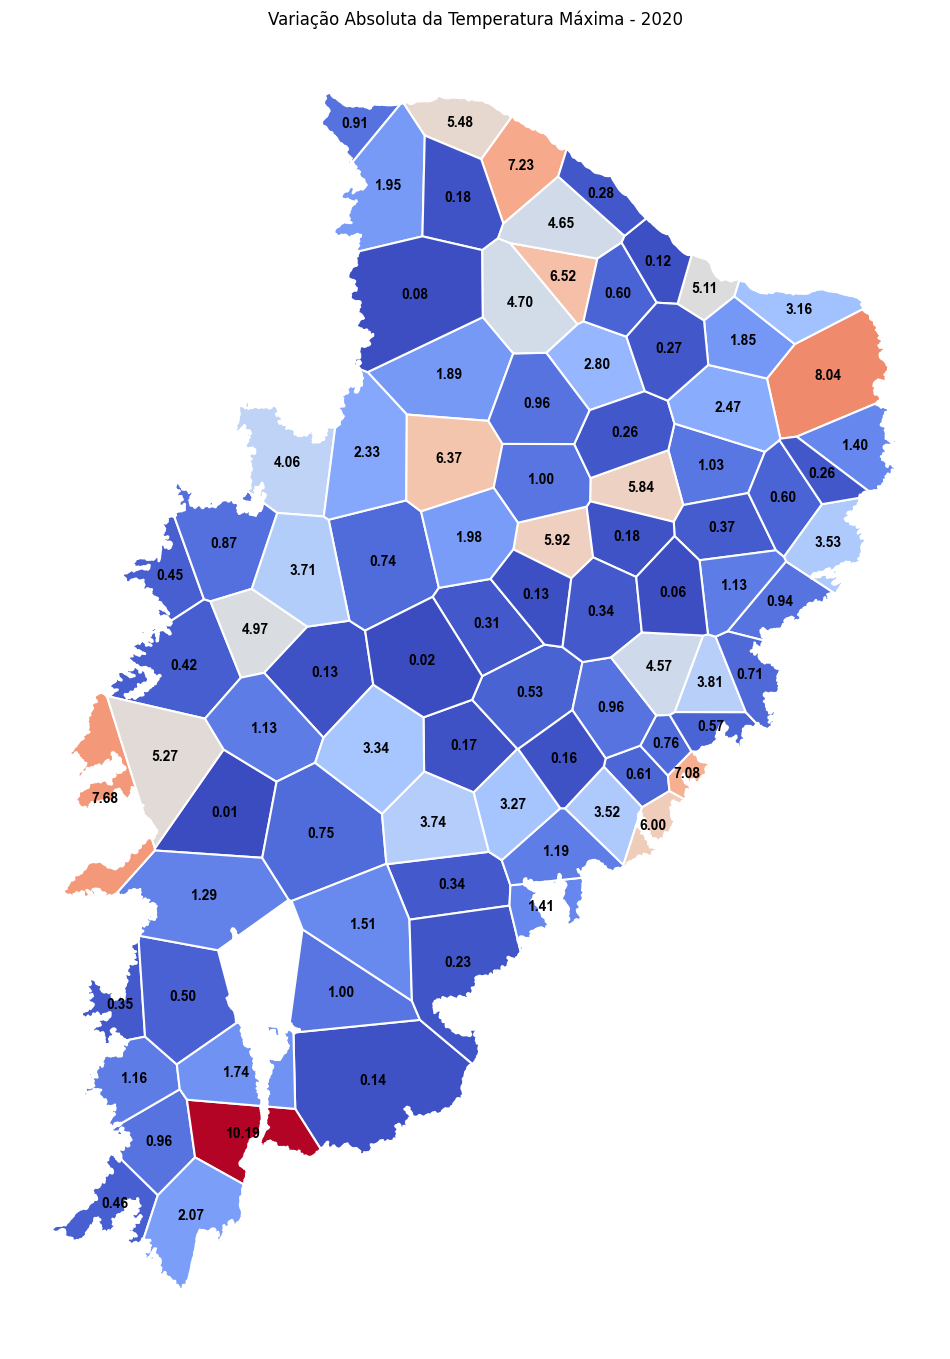

In [20]:
# Criando o mapa para o ano de 2022
fig, ax = plt.subplots(1, 1, figsize=(12, 24))

# Plotando o mapa com bordas mais grossas
gdf_voronoi_temp_filtered.plot(column='temp_difference', ax=ax, cmap='coolwarm', edgecolor='white', linewidth=1.5)

# Adicionando o valor absoluto da diferença de temperatura em cada região
for idx, row in gdf_voronoi_temp_filtered.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    temp_change = row['temp_difference']
    ax.text(x, y, f"{temp_change:.2f}", ha='center', va='center', fontsize=10, fontname='Arial', fontweight='bold', color='black')

# Remover bordas externas do plot
ax.set_axis_off()
ax.set_title(f'Variação Absoluta da Temperatura Máxima - {year_filter}')
plt.show()

# Confiabilidade da temperatura com base na área

In [22]:
# Carregar o shapefile do Voronoi previamente salvo
gdf_voronoi_clipped = gpd.read_file('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp')
gdf_voronoi_clipped.head()

id_estacao   latitude  longitude  \
0       A336  -8.441667 -43.865556   
1       A365  -8.117939 -42.975721   
2       A416 -13.332500 -44.617500   
3       A433 -14.181944 -41.672222   
4       A308  -3.086667 -41.783056   

                                            geometry  
0  MULTIPOLYGON (((-43.28134 -8.66269, -43.66635 ...  
1  MULTIPOLYGON (((-43.28134 -8.66269, -43.63515 ...  
2  MULTIPOLYGON (((-44.05675 -12.61621, -44.05717...  
3  POLYGON ((-42.21703 -13.71785, -42.21693 -13.7...  
4  POLYGON ((-41.52190 -3.55804, -41.52253 -3.558...

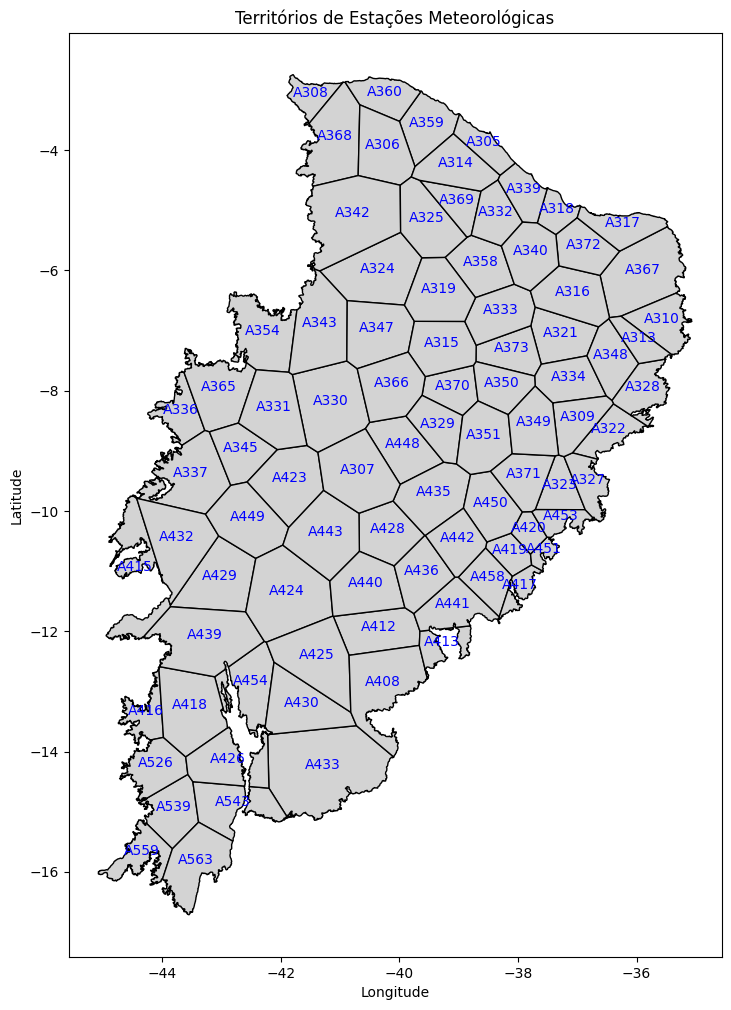

In [27]:
# Plotar o shapefile com IDs das estações
fig, ax = plt.subplots(figsize=(12, 12))

# Plotar os polígonos do shapefile
gdf_voronoi_clipped.plot(ax=ax, edgecolor='black', facecolor='lightgrey')

# Adicionar os IDs das estações no centro de cada polígono
for idx, row in gdf_voronoi_clipped.iterrows():
    # Obter o centroide de cada polígono
    centroid = row['geometry'].centroid
    # Adicionar o ID da estação no centro do polígono
    ax.annotate(row['id_estacao'], xy=(centroid.x, centroid.y), 
                horizontalalignment='center', fontsize=10, color='blue')

# Adicionar título e rótulos aos eixos
plt.title('Territórios de Estações Meteorológicas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar o gráfico
plt.show()

In [105]:
# Criar uma GeoDataFrame de pontos com as coordenadas de latitude e longitude
gdf_pontos_estacoes = gpd.GeoDataFrame(
    gdf_voronoi_clipped[['id_estacao', 'latitude', 'longitude']],
    geometry=gpd.points_from_xy(gdf_voronoi_clipped['longitude'], gdf_voronoi_clipped['latitude']),
    crs="EPSG:4326"  # Sistema de coordenadas geográficas (WGS84)
)

# Reprojetar os pontos para UTM (Exemplo UTM Zona 23S, EPSG 32723)
gdf_pontos_estacoes = gdf_pontos_estacoes.to_crs(epsg=32723)

# Reprojetar o shapefile Voronoi para UTM
gdf_voronoi_clipped_utm = gdf_voronoi_clipped.to_crs(epsg=32723)

# Calcular a área em km² corretamente
gdf_voronoi_clipped_utm['area_km2'] = gdf_voronoi_clipped_utm['geometry'].area / 1e6  # Converter m² para km²

# Substituir o centroide pelas coordenadas reais reprojetadas das estações
gdf_voronoi_clipped_utm['centroide'] = gdf_pontos_estacoes['geometry']

# Calcular a distância máxima da estação até a borda do polígono usando as novas coordenadas
gdf_voronoi_clipped_utm['dist_max'] = gdf_voronoi_clipped_utm.apply(
    lambda row: row['geometry'].boundary.distance(row['centroide']), axis=1
)

# Definir o valor de k com base nas distâncias
k = 1 / gdf_voronoi_clipped_utm['dist_max'].mean()  # Um valor ajustado baseado na média das distâncias

# Aplicar a fórmula de confiabilidade considerando o ajuste por distância máxima
gdf_voronoi_clipped_utm['confiabilidade'] = 1 / (1 + k * gdf_voronoi_clipped_utm['area_km2'])

# Visualizar os dados atualizados
gdf_voronoi_clipped_utm[['id_estacao', 'area_km2', 'dist_max', 'confiabilidade']].head()

id_estacao      area_km2      dist_max  confiabilidade
0       A336   6148.200030  11738.074282        0.828591
1       A365  12066.263616  42137.532460        0.711241
2       A416   4792.326631   1729.854354        0.861143
3       A433  28347.908334  57000.610661        0.511818
4       A308   4171.281870   8137.820820        0.876923

In [106]:
# Calcular a menor área e o id da estação correspondente
maior_area = gdf_voronoi_clipped_utm['area_km2'].min()
id_estacao_maior_area = gdf_voronoi_clipped_utm.loc[gdf_voronoi_clipped_utm['area_km2'].idxmin(), 'id_estacao']

maior_area, id_estacao_maior_area

(1633.8645075518064, 'A451')

In [107]:
# Calcular a maior área e o id da estação correspondente
maior_area = gdf_voronoi_clipped_utm['area_km2'].max()
id_estacao_maior_area = gdf_voronoi_clipped_utm.loc[gdf_voronoi_clipped_utm['area_km2'].idxmax(), 'id_estacao']

maior_area, id_estacao_maior_area

(28347.908334356664, 'A433')

In [108]:
# média das distâncias
k

3.3646907572401336e-05

- **Menor Área**: 1,633.86 km² (para a estação A451)
- **Maior Área**: 28,347.91 km² (para a estação A433)
- **\( k \)**: 2.7655470225971498e-05

### Fórmula de Confiabilidade:
$$
\text{Confiabilidade} = \frac{1}{1 + k \cdot \text{Área}}
$$

#### Cálculo da Confiabilidade para a Menor Área (A451):

$$
\text{Confiabilidade}_{\text{menor}} = \frac{1}{1 + 2.7655470225971498e-05 \cdot 1633.8645075518064}
$$
$$
\text{Confiabilidade}_{\text{menor}} = \frac{1}{1 + 0.0452015819} = \frac{1}{1.0452015819} \approx 0.9567
$$

#### Cálculo da Confiabilidade para a Maior Área (A433):

$$
\text{Confiabilidade}_{\text{maior}} = \frac{1}{1 + 2.7655470225971498e-05 \cdot 28347.908334356664}
$$
$$
\text{Confiabilidade}_{\text{maior}} = \frac{1}{1 + 0.7840142491} = \frac{1}{1.7840142491} \approx 0.5605
$$

### Comparação:
- Para a **menor área** (1,633.86 km²), a confiabilidade é aproximadamente **0.9567**, o que indica uma medição de temperatura bastante confiável devido à pequena área.
- Para a **maior área** (28,347.91 km²), a confiabilidade cai para **0.5605**, refletindo uma menor precisão na medição de temperatura, já que a estação cobre uma área muito maior.

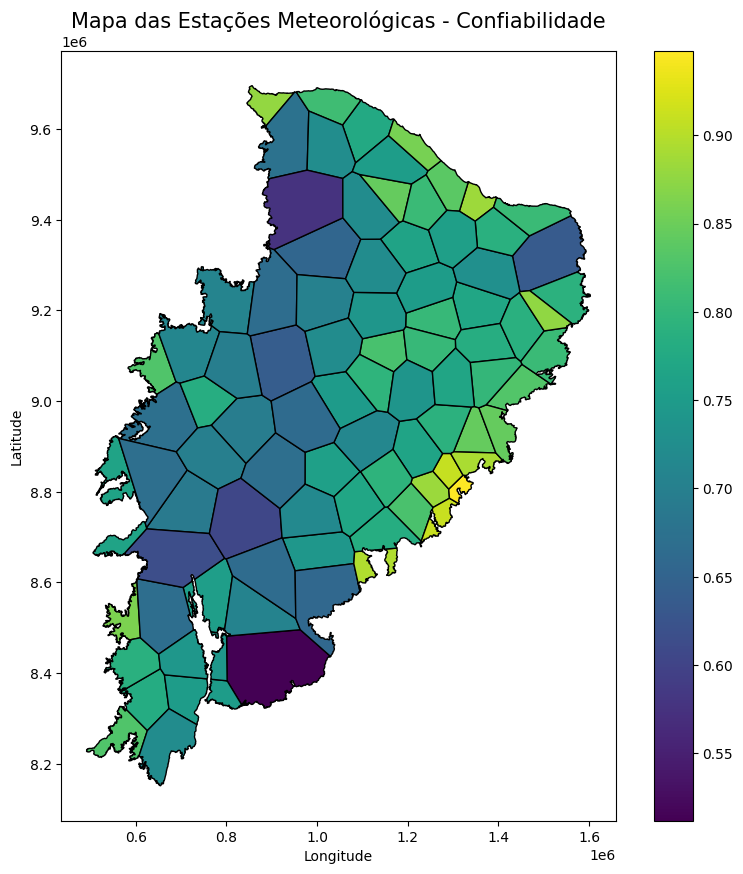

In [109]:
# Plotar o shapefile com gradiente de confiabilidade
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Adicionar polígonos coloridos de acordo com a confiabilidade
gdf_voronoi_clipped_utm.plot(column='confiabilidade', ax=ax, legend=True, cmap='viridis', edgecolor='black')

# Adicionar títulos e legendas
ax.set_title('Mapa das Estações Meteorológicas - Confiabilidade', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Mostrar o gráfico
plt.show()

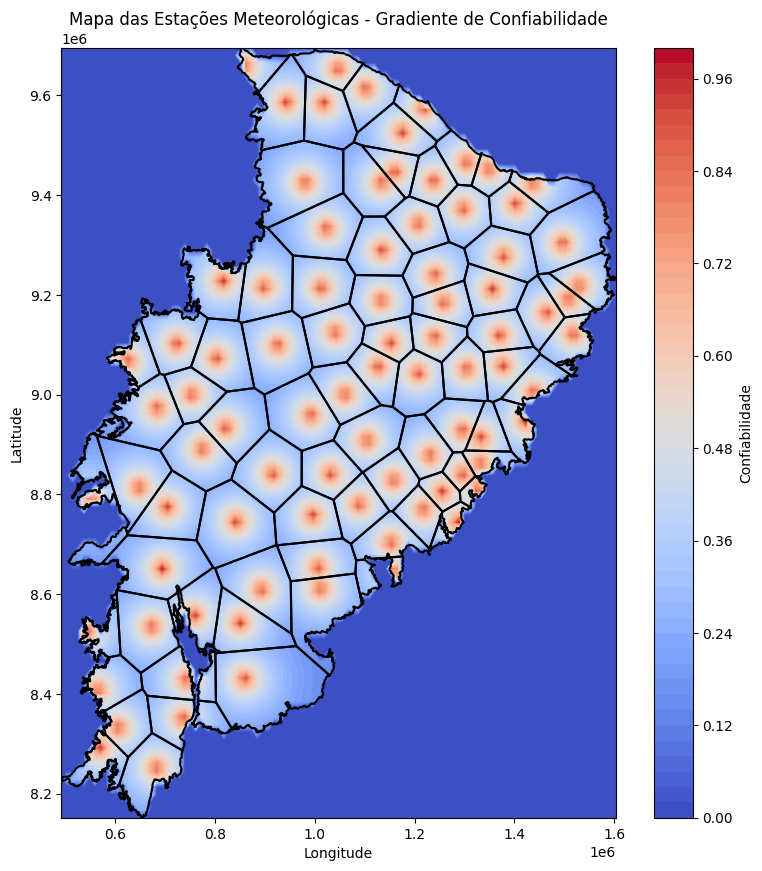

In [110]:
# Função para calcular a confiabilidade com base na distância até o centroide (raio da estação)
def calcular_confiabilidade(dist, k):
    return 1 / (1 + k * dist)

# Substituir os centroides pelos pontos reais das estações reprojetados
gdf_voronoi_clipped_utm['centroide'] = gdf_pontos_estacoes['geometry']

# Criar uma grid de pontos dentro dos polígonos para calcular a distância e gradiente
grid_size = 100  # Definir o número de pontos na grid
x_min, y_min, x_max, y_max = gdf_voronoi_clipped_utm.total_bounds
x_range = np.linspace(x_min, x_max, grid_size)
y_range = np.linspace(y_min, y_max, grid_size)
X, Y = np.meshgrid(x_range, y_range)

# Criar uma lista para armazenar os valores de confiabilidade em cada ponto
conf_values = np.zeros_like(X)

# Iterar sobre cada polígono (região de estação)
for _, row in gdf_voronoi_clipped_utm.iterrows():
    centroide = row['centroide']
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = Point(X[i, j], Y[i, j])
            if row['geometry'].contains(point):
                # Calcular a distância até o centroide (usando a localização real da estação)
                dist = point.distance(centroide)
                # Calcular a confiabilidade
                conf_values[i, j] = calcular_confiabilidade(dist, k)

# Plotar o mapa com o gradiente de confiabilidade
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, conf_values, levels=50, cmap='coolwarm')
plt.colorbar(label='Confiabilidade')
gdf_voronoi_clipped_utm.boundary.plot(ax=plt.gca(), edgecolor='black')  # Adicionar os limites dos polígonos
plt.title('Mapa das Estações Meteorológicas - Gradiente de Confiabilidade')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [111]:
gdf_voronoi_clipped_utm.head()

id_estacao   latitude  longitude  \
0       A336  -8.441667 -43.865556   
1       A365  -8.117939 -42.975721   
2       A416 -13.332500 -44.617500   
3       A433 -14.181944 -41.672222   
4       A308  -3.086667 -41.783056   

                                            geometry      area_km2  \
0  MULTIPOLYGON (((689103.763 9042011.838, 646635...   6148.200030   
1  MULTIPOLYGON (((689103.763 9042011.838, 650530...  12066.263616   
2  MULTIPOLYGON (((602446.568 8605121.577, 602401...   4792.326631   
3  POLYGON ((801004.304 8481743.198, 801011.416 8...  28347.908334   
4  POLYGON ((886521.238 9605995.462, 886451.022 9...   4171.281870   

                        centroide      dist_max  confiabilidade  
0  POINT (624884.480 9066693.170)  11738.074282        0.828591  
1  POINT (723054.179 9102107.186)  42137.532460        0.711241  
2  POINT (541423.185 8526061.997)   1729.854354        0.861143  
3  POINT (859263.746 8429593.150)  57000.610661        0.511818  
4  POINT (857637.641 9658286.228)   8137.820820        0.876923

In [112]:
# Definir as faixas de distância iniciais (em metros)
faixas_distancia_inicial = [1000, 5000, 10000, 15000, 20000]  # Por exemplo: 1 km, 5 km...

# Adicionar colunas ao GeoDataFrame para armazenar a confiabilidade de cada faixa de distância
for faixa in faixas_distancia_inicial:
    gdf_voronoi_clipped_utm[f'conf_{faixa//1000}km'] = 0.0  # Ex: conf_1km, conf_5km, etc.

# Iterar sobre cada polígono e calcular a confiabilidade para cada faixa de distância, ajustada ao tamanho do polígono
for index, row in gdf_voronoi_clipped_utm.iterrows():
    centroide = row['centroide']
    area_km2 = row['area_km2']  # Área do polígono da estação

    # Calcular o raio máximo necessário para cobrir o polígono (baseado na área)
    raio_maximo = np.sqrt(area_km2 / np.pi) * 1000  # Converter para metros

    # Ajustar as faixas de distância com base no tamanho da estação
    faixas_distancia = [faixa for faixa in faixas_distancia_inicial if faixa <= raio_maximo]

    # Calcular a confiabilidade para cada faixa de distância e preencher as colunas correspondentes
    for faixa in faixas_distancia:
        confiabilidade = calcular_confiabilidade(faixa, k)
        gdf_voronoi_clipped_utm.at[index, f'conf_{faixa//1000}km'] = confiabilidade

# Exibir os primeiros dados atualizados
gdf_voronoi_clipped_utm.head()

id_estacao   latitude  longitude  \
0       A336  -8.441667 -43.865556   
1       A365  -8.117939 -42.975721   
2       A416 -13.332500 -44.617500   
3       A433 -14.181944 -41.672222   
4       A308  -3.086667 -41.783056   

                                            geometry      area_km2  \
0  MULTIPOLYGON (((689103.763 9042011.838, 646635...   6148.200030   
1  MULTIPOLYGON (((689103.763 9042011.838, 650530...  12066.263616   
2  MULTIPOLYGON (((602446.568 8605121.577, 602401...   4792.326631   
3  POLYGON ((801004.304 8481743.198, 801011.416 8...  28347.908334   
4  POLYGON ((886521.238 9605995.462, 886451.022 9...   4171.281870   

                        centroide      dist_max  confiabilidade  conf_1km  \
0  POINT (624884.480 9066693.170)  11738.074282        0.828591  0.967448   
1  POINT (723054.179 9102107.186)  42137.532460        0.711241  0.967448   
2  POINT (541423.185 8526061.997)   1729.854354        0.861143  0.967448   
3  POINT (859263.746 8429593.150)  57000.610661        0.511818  0.967448   
4  POINT (857637.641 9658286.228)   8137.820820        0.876923  0.967448   

   conf_5km  conf_10km  conf_15km  conf_20km  
0  0.855992    0.74824   0.664583   0.597751  
1  0.855992    0.74824   0.664583   0.597751  
2  0.855992    0.74824   0.664583   0.597751  
3  0.855992    0.74824   0.664583   0.597751  
4  0.855992    0.74824   0.664583   0.597751

In [113]:
# Definir as faixas de distância iniciais (em metros)
faixas_distancia_inicial = [1000, 5000, 10000, 15000, 20000]  # Exemplo: 1 km, 5 km, 10 km, 15 km, 20 km

# Lista para armazenar os buffers recortados
buffers_clipped = []

# Iterar sobre cada polígono e criar buffers ajustados para cada estação
for index, row in gdf_voronoi_clipped_utm.iterrows():
    centroide = row['centroide']
    poligono = row['geometry']  # O polígono Voronoi da estação
    area_km2 = row['area_km2']  # Área do polígono da estação

    # Calcular o raio máximo necessário para cobrir o polígono (baseado na área)
    raio_maximo = np.sqrt(area_km2 / np.pi) * 1000  # Converter para metros
    
    # Ajustar as faixas de distância com base no tamanho da estação
    faixas_distancia = [faixa for faixa in faixas_distancia_inicial if faixa <= raio_maximo]

    # Criar buffers para cada faixa de distância e clipar com o polígono da estação
    for faixa in faixas_distancia:
        buffer = centroide.buffer(faixa)  # Criar o buffer (raio circular)
        buffer_clipped = buffer.intersection(poligono)  # Recortar o buffer para não ultrapassar o polígono

        buffers_clipped.append({
            'id_estacao': row['id_estacao'],
            'distancia_km': faixa / 1000,  # Converter para quilômetros
            'geometry': buffer_clipped
        })

# Criar um GeoDataFrame com os buffers recortados
gdf_buffers_clipped = gpd.GeoDataFrame(buffers_clipped, crs=gdf_voronoi_clipped_utm.crs)

# Exibir os primeiros resultados
gdf_buffers_clipped.head()

id_estacao  distancia_km                                           geometry
0       A336           1.0  POLYGON ((625879.665 9066595.153, 625865.265 9...
1       A336           5.0  POLYGON ((629860.404 9066203.084, 629788.406 9...
2       A336          10.0  POLYGON ((634836.327 9065712.998, 634692.333 9...
3       A336          15.0  POLYGON ((639812.251 9065222.913, 639596.259 9...
4       A336          20.0  POLYGON ((644788.175 9064732.827, 644500.186 9...

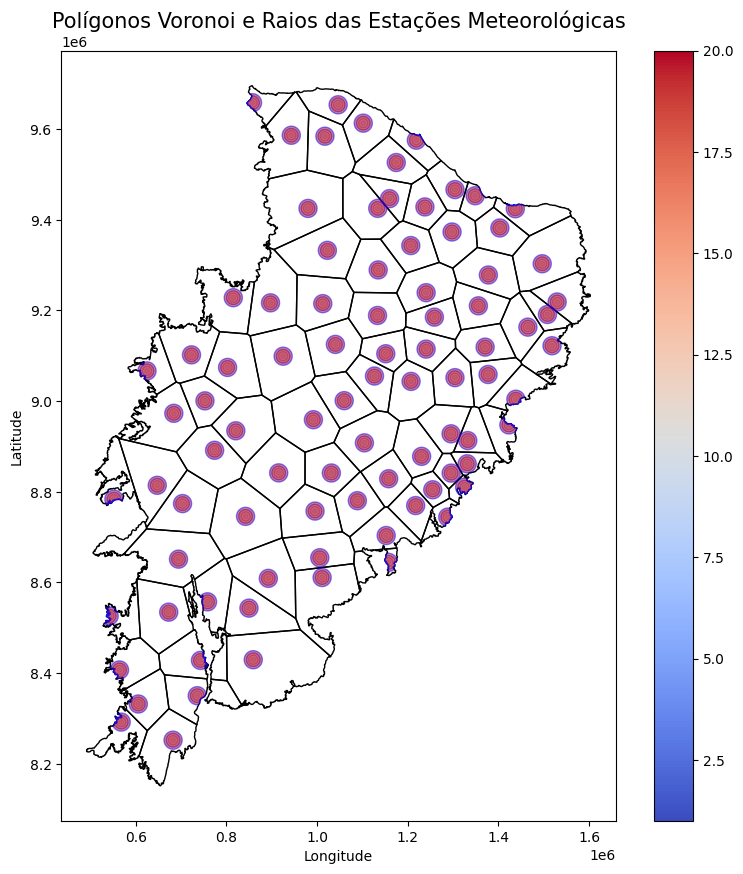

In [114]:
# Plotar os polígonos do shapefile original (gdf_voronoi_clipped_utm)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_voronoi_clipped_utm.plot(ax=ax, edgecolor='black', facecolor='none', label='Polígonos Voronoi')

# Plotar os buffers (gdf_buffers) criados para os raios ao redor das estações
gdf_buffers_clipped.plot(ax=ax, column='distancia_km', legend=True, cmap='coolwarm', edgecolor='blue', alpha=0.5)

# Adicionar títulos e rótulos
ax.set_title('Polígonos Voronoi e Raios das Estações Meteorológicas', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Mostrar o gráfico
plt.show()